In [1]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model

#If you are using Tensorflow 1.x
from keras.optimizers import Adam
#If you are using Tensorflow 2
#from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

import os

from PIL import Image

Using TensorFlow backend.


# Parameters

In [2]:
#folder containing dataset
data_path = r'D:\Downloads\selfie2anime\trainB'

#how many epochs to run the model
epoch = 50001

#how many epochs between saving your model
interval = 100

#how many images to train at one time. If batch size is less than 9, alter the save_img function to plot less images
batch = 10

#if the data has pngs set this to True to remove alpha layer from images
png = False

# Load dataset from local files

In [3]:
def load_data():
        data = []
        small = []
        paths = []
        #get all files in this folder
        for r, d, f in os.walk(data_path):
            for file in f:
                if '.jpg' in file or 'png' in file:
                    paths.append(os.path.join(r, file))
        #for each file add normal resolution and low resolution to arrays
        for path in paths:
            img = Image.open(path)
            x = np.array(img.resize((128,128)))
            y = np.array(img.resize((256,256)))
            if(png):
                x = x[...,:3]
            data.append(y)
            small.append(x)
            
        #reshaping data to be four dimension required for input to neural network
        y_train = np.array(data)
        y_train = y_train.reshape(len(data),256,256,3)
        x_train = np.array(small)
        x_train = x_train.reshape(len(small),128,128,3)
        del data
        del small
        del paths
        return y_train, x_train

In [4]:
class SRGAN():
    def __init__(self):
        
        # Shape of high resolution output image
        self.img_rows = 256
        self.img_cols = 256
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        # Shape of low resolution input image
        self.latent_dim = (128,128,3)

        #optimizer (learning rate and beta values)
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
        generator = self.generator

        # The generator takes image as input and generates high resolution image
        z = Input(shape=self.latent_dim)
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='mse', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()
        model.add(Conv2D(64, input_shape=self.latent_dim, kernel_size=(3,3), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(64, kernel_size=(3,3), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(64, kernel_size=(3,3), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=(3,3), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(64, kernel_size=(3,3), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(64, kernel_size=(3,3), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(3, kernel_size=(3,3), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.summary()

        noise = Input(shape=self.latent_dim)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)
    

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        Y_train, X_train = load_data()

        # Rescale to be between 0 & 1
        X_train = X_train / 255
        Y_train = Y_train / 255

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # Placeholder for loss function values
        g_loss_epochs = np.zeros((epochs, 1))
        d_loss_epochs = np.zeros((epochs, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, Y_train.shape[0], batch_size)
            imgs = Y_train[idx]

            # Generate super resolution images from the random batch of images
            gen_imgs = self.generator.predict(X_train[idx])

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(X_train[idx], valid)
            
            #save loss history
            g_loss_epochs[epoch] = g_loss
            d_loss_epochs[epoch] = d_loss[0]

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch, X_train, idx)
            
        return g_loss_epochs, d_loss_epochs

    def save_imgs(self, epoch, X_train, idx):
        r, c = 3, 3
        # Select 9 random images
        index = np.random.randint(0, X_train.shape[0], 9)
        images = X_train[idx]
        # Super resolution the images
        gen_imgs = self.generator.predict(images)
        gen_imgs = np.array(gen_imgs) * 255
        gen_imgs = gen_imgs.astype(int)
        # Plot each image
        fig=plt.figure(figsize=(20, 20))
        for i in range(1, c*r+1):
            img = gen_imgs[i-1]
            fig.add_subplot(r, c, i)
            plt.imshow(img)
        fig.savefig("epoch_%d.png" % epoch)
        plt.close()
        # save model to .h5 file
        self.generator.save("generator" + str(epoch) + ".h5")

# Create Model and View Summary

In [5]:
gan = SRGAN()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)      

# Train Model

In [6]:
g_loss, d_loss = gan.train(epochs=epoch, batch_size=batch, save_interval=interval)

C:\Users\Vee\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Vee\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0

0 [D loss: 0.254610, acc.: 30.00%] [G loss: 0.231031]


C:\Users\Vee\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.173481, acc.: 50.00%] [G loss: 0.207348]
2 [D loss: 0.179209, acc.: 50.00%] [G loss: 0.253865]
3 [D loss: 0.137698, acc.: 65.00%] [G loss: 0.402185]
4 [D loss: 0.193601, acc.: 50.00%] [G loss: 0.300130]
5 [D loss: 0.412134, acc.: 45.00%] [G loss: 0.072114]
6 [D loss: 0.406207, acc.: 50.00%] [G loss: 0.070110]
7 [D loss: 0.410392, acc.: 50.00%] [G loss: 0.161594]
8 [D loss: 0.357634, acc.: 50.00%] [G loss: 0.709495]
9 [D loss: 0.179455, acc.: 55.00%] [G loss: 0.672015]
10 [D loss: 0.222085, acc.: 80.00%] [G loss: 0.362534]
11 [D loss: 0.250669, acc.: 50.00%] [G loss: 0.188594]
12 [D loss: 0.293330, acc.: 50.00%] [G loss: 0.135629]
13 [D loss: 0.316239, acc.: 50.00%] [G loss: 0.109961]
14 [D loss: 0.316530, acc.: 50.00%] [G loss: 0.140749]
15 [D loss: 0.292067, acc.: 50.00%] [G loss: 0.266912]
16 [D loss: 0.233640, acc.: 55.00%] [G loss: 0.478763]
17 [D loss: 0.203629, acc.: 85.00%] [G loss: 0.468093]
18 [D loss: 0.259171, acc.: 45.00%] [G loss: 0.275820]
19 [D loss: 0.25454

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


100 [D loss: 0.286449, acc.: 55.00%] [G loss: 0.842750]
101 [D loss: 0.162877, acc.: 95.00%] [G loss: 0.523312]
102 [D loss: 0.267851, acc.: 40.00%] [G loss: 0.179992]
103 [D loss: 0.337811, acc.: 50.00%] [G loss: 0.120188]
104 [D loss: 0.391500, acc.: 50.00%] [G loss: 0.191983]
105 [D loss: 0.268923, acc.: 40.00%] [G loss: 0.840362]
106 [D loss: 0.229291, acc.: 50.00%] [G loss: 0.732978]
107 [D loss: 0.291387, acc.: 50.00%] [G loss: 0.322185]
108 [D loss: 0.266341, acc.: 40.00%] [G loss: 0.259590]
109 [D loss: 0.246549, acc.: 30.00%] [G loss: 0.245826]
110 [D loss: 0.237651, acc.: 45.00%] [G loss: 0.242340]
111 [D loss: 0.218323, acc.: 50.00%] [G loss: 0.233334]
112 [D loss: 0.210919, acc.: 50.00%] [G loss: 0.235507]
113 [D loss: 0.205515, acc.: 50.00%] [G loss: 0.233268]
114 [D loss: 0.195613, acc.: 50.00%] [G loss: 0.235189]
115 [D loss: 0.215995, acc.: 55.00%] [G loss: 0.253885]
116 [D loss: 0.218884, acc.: 55.00%] [G loss: 0.240269]
117 [D loss: 0.229307, acc.: 45.00%] [G loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


200 [D loss: 0.259224, acc.: 40.00%] [G loss: 0.263555]
201 [D loss: 0.262092, acc.: 35.00%] [G loss: 0.249964]
202 [D loss: 0.259186, acc.: 45.00%] [G loss: 0.259126]
203 [D loss: 0.247677, acc.: 45.00%] [G loss: 0.252495]
204 [D loss: 0.254652, acc.: 45.00%] [G loss: 0.264166]
205 [D loss: 0.252609, acc.: 45.00%] [G loss: 0.240817]
206 [D loss: 0.255340, acc.: 30.00%] [G loss: 0.240004]
207 [D loss: 0.249706, acc.: 50.00%] [G loss: 0.238566]
208 [D loss: 0.260943, acc.: 35.00%] [G loss: 0.256606]
209 [D loss: 0.256012, acc.: 35.00%] [G loss: 0.246926]
210 [D loss: 0.254275, acc.: 60.00%] [G loss: 0.253378]
211 [D loss: 0.253998, acc.: 50.00%] [G loss: 0.238613]
212 [D loss: 0.256259, acc.: 40.00%] [G loss: 0.253764]
213 [D loss: 0.250354, acc.: 60.00%] [G loss: 0.255499]
214 [D loss: 0.251426, acc.: 45.00%] [G loss: 0.272079]
215 [D loss: 0.253440, acc.: 40.00%] [G loss: 0.253230]
216 [D loss: 0.254016, acc.: 40.00%] [G loss: 0.259200]
217 [D loss: 0.248536, acc.: 55.00%] [G loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


300 [D loss: 0.249437, acc.: 65.00%] [G loss: 0.273977]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


301 [D loss: 0.248316, acc.: 65.00%] [G loss: 0.272804]
302 [D loss: 0.242945, acc.: 65.00%] [G loss: 0.267652]
303 [D loss: 0.244273, acc.: 70.00%] [G loss: 0.280783]
304 [D loss: 0.249023, acc.: 50.00%] [G loss: 0.258564]
305 [D loss: 0.243766, acc.: 70.00%] [G loss: 0.258399]
306 [D loss: 0.249377, acc.: 40.00%] [G loss: 0.262592]
307 [D loss: 0.242470, acc.: 65.00%] [G loss: 0.258969]
308 [D loss: 0.243149, acc.: 70.00%] [G loss: 0.258758]
309 [D loss: 0.241882, acc.: 55.00%] [G loss: 0.261250]
310 [D loss: 0.239708, acc.: 65.00%] [G loss: 0.268167]
311 [D loss: 0.242223, acc.: 75.00%] [G loss: 0.268094]
312 [D loss: 0.244894, acc.: 70.00%] [G loss: 0.265646]
313 [D loss: 0.246532, acc.: 45.00%] [G loss: 0.256949]
314 [D loss: 0.248270, acc.: 50.00%] [G loss: 0.251449]
315 [D loss: 0.243193, acc.: 60.00%] [G loss: 0.247227]
316 [D loss: 0.242433, acc.: 50.00%] [G loss: 0.257098]
317 [D loss: 0.240539, acc.: 55.00%] [G loss: 0.255311]
318 [D loss: 0.241310, acc.: 70.00%] [G loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


400 [D loss: 0.247903, acc.: 45.00%] [G loss: 0.242563]
401 [D loss: 0.243817, acc.: 60.00%] [G loss: 0.241362]
402 [D loss: 0.238935, acc.: 65.00%] [G loss: 0.271898]
403 [D loss: 0.256731, acc.: 55.00%] [G loss: 0.255571]
404 [D loss: 0.241420, acc.: 70.00%] [G loss: 0.280635]
405 [D loss: 0.252896, acc.: 50.00%] [G loss: 0.278845]
406 [D loss: 0.250428, acc.: 45.00%] [G loss: 0.261856]
407 [D loss: 0.244877, acc.: 60.00%] [G loss: 0.265783]
408 [D loss: 0.251593, acc.: 55.00%] [G loss: 0.258993]
409 [D loss: 0.248330, acc.: 45.00%] [G loss: 0.250146]
410 [D loss: 0.248804, acc.: 45.00%] [G loss: 0.250060]
411 [D loss: 0.250738, acc.: 55.00%] [G loss: 0.251866]
412 [D loss: 0.243644, acc.: 60.00%] [G loss: 0.245908]
413 [D loss: 0.253953, acc.: 50.00%] [G loss: 0.241400]
414 [D loss: 0.246474, acc.: 55.00%] [G loss: 0.260281]
415 [D loss: 0.254083, acc.: 40.00%] [G loss: 0.252839]
416 [D loss: 0.250875, acc.: 50.00%] [G loss: 0.261652]
417 [D loss: 0.250310, acc.: 55.00%] [G loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


500 [D loss: 0.257473, acc.: 30.00%] [G loss: 0.258280]
501 [D loss: 0.256873, acc.: 35.00%] [G loss: 0.249383]
502 [D loss: 0.261521, acc.: 25.00%] [G loss: 0.260519]
503 [D loss: 0.250295, acc.: 50.00%] [G loss: 0.275601]
504 [D loss: 0.252058, acc.: 60.00%] [G loss: 0.283815]
505 [D loss: 0.256260, acc.: 30.00%] [G loss: 0.256889]
506 [D loss: 0.256509, acc.: 35.00%] [G loss: 0.248430]
507 [D loss: 0.251885, acc.: 45.00%] [G loss: 0.249604]
508 [D loss: 0.252922, acc.: 45.00%] [G loss: 0.244547]
509 [D loss: 0.253480, acc.: 45.00%] [G loss: 0.256299]
510 [D loss: 0.244548, acc.: 70.00%] [G loss: 0.256877]
511 [D loss: 0.248940, acc.: 50.00%] [G loss: 0.250191]
512 [D loss: 0.251281, acc.: 50.00%] [G loss: 0.240629]
513 [D loss: 0.255551, acc.: 45.00%] [G loss: 0.238719]
514 [D loss: 0.254833, acc.: 40.00%] [G loss: 0.255659]
515 [D loss: 0.249733, acc.: 65.00%] [G loss: 0.255197]
516 [D loss: 0.255439, acc.: 40.00%] [G loss: 0.260026]
517 [D loss: 0.255355, acc.: 45.00%] [G loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


600 [D loss: 0.247640, acc.: 55.00%] [G loss: 0.248456]
601 [D loss: 0.250582, acc.: 45.00%] [G loss: 0.248936]
602 [D loss: 0.249963, acc.: 50.00%] [G loss: 0.241522]
603 [D loss: 0.250094, acc.: 40.00%] [G loss: 0.247772]
604 [D loss: 0.252971, acc.: 50.00%] [G loss: 0.261548]
605 [D loss: 0.254388, acc.: 45.00%] [G loss: 0.247712]
606 [D loss: 0.251386, acc.: 50.00%] [G loss: 0.244163]
607 [D loss: 0.255907, acc.: 30.00%] [G loss: 0.259881]
608 [D loss: 0.250952, acc.: 45.00%] [G loss: 0.245803]
609 [D loss: 0.248210, acc.: 45.00%] [G loss: 0.255524]
610 [D loss: 0.248140, acc.: 50.00%] [G loss: 0.258835]
611 [D loss: 0.249394, acc.: 50.00%] [G loss: 0.261227]
612 [D loss: 0.248631, acc.: 55.00%] [G loss: 0.258981]
613 [D loss: 0.254691, acc.: 30.00%] [G loss: 0.258905]
614 [D loss: 0.253140, acc.: 40.00%] [G loss: 0.254526]
615 [D loss: 0.252448, acc.: 40.00%] [G loss: 0.245961]
616 [D loss: 0.249821, acc.: 50.00%] [G loss: 0.251315]
617 [D loss: 0.250385, acc.: 50.00%] [G loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


700 [D loss: 0.248038, acc.: 60.00%] [G loss: 0.255307]
701 [D loss: 0.250871, acc.: 60.00%] [G loss: 0.260328]
702 [D loss: 0.251242, acc.: 50.00%] [G loss: 0.254185]
703 [D loss: 0.250770, acc.: 45.00%] [G loss: 0.253673]
704 [D loss: 0.249640, acc.: 40.00%] [G loss: 0.250009]
705 [D loss: 0.250625, acc.: 45.00%] [G loss: 0.249551]
706 [D loss: 0.252546, acc.: 40.00%] [G loss: 0.244945]
707 [D loss: 0.247962, acc.: 60.00%] [G loss: 0.251322]
708 [D loss: 0.250774, acc.: 55.00%] [G loss: 0.252513]
709 [D loss: 0.251551, acc.: 45.00%] [G loss: 0.252191]
710 [D loss: 0.251651, acc.: 45.00%] [G loss: 0.253772]
711 [D loss: 0.248447, acc.: 50.00%] [G loss: 0.261608]
712 [D loss: 0.247071, acc.: 70.00%] [G loss: 0.249632]
713 [D loss: 0.251059, acc.: 40.00%] [G loss: 0.253461]
714 [D loss: 0.247238, acc.: 60.00%] [G loss: 0.256866]
715 [D loss: 0.248883, acc.: 50.00%] [G loss: 0.259411]
716 [D loss: 0.249110, acc.: 45.00%] [G loss: 0.257938]
717 [D loss: 0.249974, acc.: 45.00%] [G loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


800 [D loss: 0.250714, acc.: 40.00%] [G loss: 0.246956]
801 [D loss: 0.246511, acc.: 70.00%] [G loss: 0.248734]
802 [D loss: 0.252812, acc.: 45.00%] [G loss: 0.253635]
803 [D loss: 0.250418, acc.: 45.00%] [G loss: 0.249096]
804 [D loss: 0.253231, acc.: 35.00%] [G loss: 0.262302]
805 [D loss: 0.251571, acc.: 50.00%] [G loss: 0.256814]
806 [D loss: 0.251028, acc.: 35.00%] [G loss: 0.263831]
807 [D loss: 0.250103, acc.: 50.00%] [G loss: 0.257741]
808 [D loss: 0.247111, acc.: 60.00%] [G loss: 0.261843]
809 [D loss: 0.249086, acc.: 55.00%] [G loss: 0.260434]
810 [D loss: 0.249839, acc.: 55.00%] [G loss: 0.254357]
811 [D loss: 0.250808, acc.: 55.00%] [G loss: 0.256302]
812 [D loss: 0.252394, acc.: 50.00%] [G loss: 0.252688]
813 [D loss: 0.252096, acc.: 35.00%] [G loss: 0.251091]
814 [D loss: 0.247604, acc.: 70.00%] [G loss: 0.251550]
815 [D loss: 0.251936, acc.: 30.00%] [G loss: 0.253197]
816 [D loss: 0.250222, acc.: 55.00%] [G loss: 0.250485]
817 [D loss: 0.251430, acc.: 50.00%] [G loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


900 [D loss: 0.248688, acc.: 60.00%] [G loss: 0.247423]
901 [D loss: 0.251838, acc.: 40.00%] [G loss: 0.251339]
902 [D loss: 0.251545, acc.: 45.00%] [G loss: 0.255283]
903 [D loss: 0.251680, acc.: 50.00%] [G loss: 0.246847]
904 [D loss: 0.247334, acc.: 55.00%] [G loss: 0.246969]
905 [D loss: 0.251091, acc.: 40.00%] [G loss: 0.252954]
906 [D loss: 0.252975, acc.: 35.00%] [G loss: 0.249077]
907 [D loss: 0.255695, acc.: 25.00%] [G loss: 0.252901]
908 [D loss: 0.250345, acc.: 55.00%] [G loss: 0.244840]
909 [D loss: 0.251581, acc.: 55.00%] [G loss: 0.256745]
910 [D loss: 0.252422, acc.: 40.00%] [G loss: 0.254660]
911 [D loss: 0.250857, acc.: 40.00%] [G loss: 0.254654]
912 [D loss: 0.251883, acc.: 40.00%] [G loss: 0.253572]
913 [D loss: 0.250215, acc.: 50.00%] [G loss: 0.251272]
914 [D loss: 0.246068, acc.: 65.00%] [G loss: 0.254745]
915 [D loss: 0.253218, acc.: 35.00%] [G loss: 0.253505]
916 [D loss: 0.249818, acc.: 55.00%] [G loss: 0.252592]
917 [D loss: 0.251149, acc.: 45.00%] [G loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1000 [D loss: 0.250952, acc.: 60.00%] [G loss: 0.255742]
1001 [D loss: 0.250638, acc.: 45.00%] [G loss: 0.251604]
1002 [D loss: 0.248457, acc.: 55.00%] [G loss: 0.248585]
1003 [D loss: 0.247687, acc.: 65.00%] [G loss: 0.251388]
1004 [D loss: 0.248161, acc.: 70.00%] [G loss: 0.255083]
1005 [D loss: 0.247430, acc.: 55.00%] [G loss: 0.251201]
1006 [D loss: 0.246809, acc.: 50.00%] [G loss: 0.246507]
1007 [D loss: 0.248998, acc.: 60.00%] [G loss: 0.246041]
1008 [D loss: 0.253294, acc.: 35.00%] [G loss: 0.245645]
1009 [D loss: 0.249762, acc.: 50.00%] [G loss: 0.244518]
1010 [D loss: 0.252186, acc.: 50.00%] [G loss: 0.247808]
1011 [D loss: 0.247099, acc.: 65.00%] [G loss: 0.243440]
1012 [D loss: 0.250389, acc.: 50.00%] [G loss: 0.256414]
1013 [D loss: 0.247402, acc.: 60.00%] [G loss: 0.256729]
1014 [D loss: 0.246805, acc.: 65.00%] [G loss: 0.259925]
1015 [D loss: 0.250277, acc.: 50.00%] [G loss: 0.259421]
1016 [D loss: 0.248322, acc.: 45.00%] [G loss: 0.262525]
1017 [D loss: 0.242847, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1100 [D loss: 0.246915, acc.: 50.00%] [G loss: 0.251914]
1101 [D loss: 0.246275, acc.: 55.00%] [G loss: 0.248161]
1102 [D loss: 0.247761, acc.: 60.00%] [G loss: 0.242975]
1103 [D loss: 0.251056, acc.: 35.00%] [G loss: 0.247040]
1104 [D loss: 0.250802, acc.: 50.00%] [G loss: 0.249667]
1105 [D loss: 0.250490, acc.: 50.00%] [G loss: 0.244698]
1106 [D loss: 0.253340, acc.: 45.00%] [G loss: 0.250538]
1107 [D loss: 0.248789, acc.: 60.00%] [G loss: 0.248407]
1108 [D loss: 0.249476, acc.: 60.00%] [G loss: 0.262299]
1109 [D loss: 0.251341, acc.: 50.00%] [G loss: 0.252790]
1110 [D loss: 0.240581, acc.: 75.00%] [G loss: 0.271444]
1111 [D loss: 0.249004, acc.: 55.00%] [G loss: 0.256740]
1112 [D loss: 0.250604, acc.: 50.00%] [G loss: 0.257108]
1113 [D loss: 0.253372, acc.: 35.00%] [G loss: 0.250049]
1114 [D loss: 0.249256, acc.: 60.00%] [G loss: 0.248058]
1115 [D loss: 0.251135, acc.: 45.00%] [G loss: 0.250871]
1116 [D loss: 0.250862, acc.: 50.00%] [G loss: 0.256692]
1117 [D loss: 0.251196, acc.: 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1200 [D loss: 0.243665, acc.: 70.00%] [G loss: 0.256394]
1201 [D loss: 0.251545, acc.: 45.00%] [G loss: 0.250009]
1202 [D loss: 0.251324, acc.: 45.00%] [G loss: 0.251435]
1203 [D loss: 0.252225, acc.: 45.00%] [G loss: 0.249355]
1204 [D loss: 0.251138, acc.: 45.00%] [G loss: 0.248245]
1205 [D loss: 0.248141, acc.: 60.00%] [G loss: 0.250596]
1206 [D loss: 0.251256, acc.: 55.00%] [G loss: 0.252681]
1207 [D loss: 0.250445, acc.: 45.00%] [G loss: 0.251108]
1208 [D loss: 0.247470, acc.: 70.00%] [G loss: 0.252646]
1209 [D loss: 0.250332, acc.: 55.00%] [G loss: 0.255340]
1210 [D loss: 0.249537, acc.: 55.00%] [G loss: 0.253638]
1211 [D loss: 0.250421, acc.: 45.00%] [G loss: 0.252176]
1212 [D loss: 0.252200, acc.: 40.00%] [G loss: 0.251300]
1213 [D loss: 0.248429, acc.: 40.00%] [G loss: 0.255082]
1214 [D loss: 0.245524, acc.: 55.00%] [G loss: 0.251409]
1215 [D loss: 0.251563, acc.: 50.00%] [G loss: 0.243384]
1216 [D loss: 0.253030, acc.: 35.00%] [G loss: 0.246671]
1217 [D loss: 0.248243, acc.: 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1300 [D loss: 0.248981, acc.: 40.00%] [G loss: 0.240123]
1301 [D loss: 0.246657, acc.: 60.00%] [G loss: 0.246776]
1302 [D loss: 0.251803, acc.: 35.00%] [G loss: 0.248578]
1303 [D loss: 0.247977, acc.: 55.00%] [G loss: 0.243705]
1304 [D loss: 0.253295, acc.: 50.00%] [G loss: 0.240450]
1305 [D loss: 0.252260, acc.: 55.00%] [G loss: 0.244546]
1306 [D loss: 0.250346, acc.: 55.00%] [G loss: 0.261014]
1307 [D loss: 0.248198, acc.: 60.00%] [G loss: 0.263108]
1308 [D loss: 0.250069, acc.: 60.00%] [G loss: 0.258800]
1309 [D loss: 0.250693, acc.: 45.00%] [G loss: 0.258161]
1310 [D loss: 0.249506, acc.: 65.00%] [G loss: 0.257244]
1311 [D loss: 0.247784, acc.: 60.00%] [G loss: 0.251811]
1312 [D loss: 0.245719, acc.: 65.00%] [G loss: 0.256159]
1313 [D loss: 0.248592, acc.: 60.00%] [G loss: 0.252577]
1314 [D loss: 0.246600, acc.: 55.00%] [G loss: 0.252256]
1315 [D loss: 0.247274, acc.: 60.00%] [G loss: 0.252226]
1316 [D loss: 0.247994, acc.: 55.00%] [G loss: 0.248662]
1317 [D loss: 0.244946, acc.: 4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1400 [D loss: 0.246945, acc.: 60.00%] [G loss: 0.253292]
1401 [D loss: 0.243653, acc.: 60.00%] [G loss: 0.249521]
1402 [D loss: 0.245227, acc.: 55.00%] [G loss: 0.250080]
1403 [D loss: 0.247266, acc.: 50.00%] [G loss: 0.250664]
1404 [D loss: 0.247927, acc.: 50.00%] [G loss: 0.245478]
1405 [D loss: 0.248058, acc.: 50.00%] [G loss: 0.244587]
1406 [D loss: 0.246053, acc.: 60.00%] [G loss: 0.239159]
1407 [D loss: 0.249737, acc.: 45.00%] [G loss: 0.252387]
1408 [D loss: 0.250722, acc.: 55.00%] [G loss: 0.257821]
1409 [D loss: 0.245523, acc.: 60.00%] [G loss: 0.247589]
1410 [D loss: 0.248752, acc.: 60.00%] [G loss: 0.248603]
1411 [D loss: 0.249429, acc.: 55.00%] [G loss: 0.248945]
1412 [D loss: 0.244879, acc.: 65.00%] [G loss: 0.257679]
1413 [D loss: 0.244765, acc.: 70.00%] [G loss: 0.259759]
1414 [D loss: 0.250312, acc.: 55.00%] [G loss: 0.247951]
1415 [D loss: 0.248344, acc.: 65.00%] [G loss: 0.249359]
1416 [D loss: 0.248162, acc.: 60.00%] [G loss: 0.250466]
1417 [D loss: 0.250939, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1500 [D loss: 0.250637, acc.: 50.00%] [G loss: 0.252070]
1501 [D loss: 0.250435, acc.: 70.00%] [G loss: 0.244553]
1502 [D loss: 0.249079, acc.: 50.00%] [G loss: 0.252854]
1503 [D loss: 0.248196, acc.: 65.00%] [G loss: 0.247729]
1504 [D loss: 0.248777, acc.: 50.00%] [G loss: 0.252311]
1505 [D loss: 0.248020, acc.: 50.00%] [G loss: 0.252174]
1506 [D loss: 0.249650, acc.: 50.00%] [G loss: 0.251142]
1507 [D loss: 0.248737, acc.: 55.00%] [G loss: 0.253441]
1508 [D loss: 0.248802, acc.: 60.00%] [G loss: 0.253849]
1509 [D loss: 0.247914, acc.: 65.00%] [G loss: 0.258323]
1510 [D loss: 0.249160, acc.: 40.00%] [G loss: 0.253292]
1511 [D loss: 0.249094, acc.: 55.00%] [G loss: 0.250953]
1512 [D loss: 0.247236, acc.: 65.00%] [G loss: 0.253538]
1513 [D loss: 0.244398, acc.: 65.00%] [G loss: 0.255193]
1514 [D loss: 0.247468, acc.: 60.00%] [G loss: 0.251442]
1515 [D loss: 0.245780, acc.: 75.00%] [G loss: 0.251859]
1516 [D loss: 0.249136, acc.: 50.00%] [G loss: 0.251668]
1517 [D loss: 0.249419, acc.: 4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1600 [D loss: 0.245189, acc.: 65.00%] [G loss: 0.250860]
1601 [D loss: 0.244658, acc.: 45.00%] [G loss: 0.253604]
1602 [D loss: 0.250702, acc.: 55.00%] [G loss: 0.249399]
1603 [D loss: 0.245152, acc.: 50.00%] [G loss: 0.246879]
1604 [D loss: 0.242390, acc.: 60.00%] [G loss: 0.244920]
1605 [D loss: 0.244479, acc.: 50.00%] [G loss: 0.243918]
1606 [D loss: 0.250141, acc.: 60.00%] [G loss: 0.255372]
1607 [D loss: 0.244260, acc.: 55.00%] [G loss: 0.255717]
1608 [D loss: 0.247583, acc.: 45.00%] [G loss: 0.255796]
1609 [D loss: 0.249676, acc.: 50.00%] [G loss: 0.264410]
1610 [D loss: 0.249131, acc.: 55.00%] [G loss: 0.241155]
1611 [D loss: 0.251552, acc.: 45.00%] [G loss: 0.247934]
1612 [D loss: 0.246701, acc.: 60.00%] [G loss: 0.268797]
1613 [D loss: 0.244326, acc.: 60.00%] [G loss: 0.275456]
1614 [D loss: 0.245931, acc.: 60.00%] [G loss: 0.267883]
1615 [D loss: 0.248321, acc.: 55.00%] [G loss: 0.261037]
1616 [D loss: 0.251711, acc.: 55.00%] [G loss: 0.251463]
1617 [D loss: 0.254254, acc.: 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1700 [D loss: 0.248727, acc.: 50.00%] [G loss: 0.250698]
1701 [D loss: 0.244348, acc.: 80.00%] [G loss: 0.255624]
1702 [D loss: 0.247735, acc.: 65.00%] [G loss: 0.244753]
1703 [D loss: 0.247294, acc.: 60.00%] [G loss: 0.253939]
1704 [D loss: 0.244832, acc.: 70.00%] [G loss: 0.248074]
1705 [D loss: 0.248721, acc.: 55.00%] [G loss: 0.253817]
1706 [D loss: 0.248409, acc.: 55.00%] [G loss: 0.243989]
1707 [D loss: 0.252579, acc.: 45.00%] [G loss: 0.249526]
1708 [D loss: 0.253857, acc.: 40.00%] [G loss: 0.243930]
1709 [D loss: 0.247078, acc.: 60.00%] [G loss: 0.245886]
1710 [D loss: 0.249920, acc.: 55.00%] [G loss: 0.244859]
1711 [D loss: 0.250591, acc.: 60.00%] [G loss: 0.251833]
1712 [D loss: 0.242464, acc.: 70.00%] [G loss: 0.261429]
1713 [D loss: 0.249943, acc.: 50.00%] [G loss: 0.255647]
1714 [D loss: 0.248686, acc.: 60.00%] [G loss: 0.266284]
1715 [D loss: 0.247647, acc.: 45.00%] [G loss: 0.259214]
1716 [D loss: 0.247335, acc.: 70.00%] [G loss: 0.258506]
1717 [D loss: 0.251377, acc.: 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1800 [D loss: 0.250773, acc.: 45.00%] [G loss: 0.257290]
1801 [D loss: 0.247137, acc.: 60.00%] [G loss: 0.259570]
1802 [D loss: 0.250882, acc.: 45.00%] [G loss: 0.252307]
1803 [D loss: 0.246190, acc.: 50.00%] [G loss: 0.258967]
1804 [D loss: 0.252068, acc.: 45.00%] [G loss: 0.252125]
1805 [D loss: 0.250414, acc.: 60.00%] [G loss: 0.254406]
1806 [D loss: 0.248565, acc.: 55.00%] [G loss: 0.251327]
1807 [D loss: 0.249441, acc.: 50.00%] [G loss: 0.249179]
1808 [D loss: 0.247178, acc.: 40.00%] [G loss: 0.263039]
1809 [D loss: 0.249439, acc.: 40.00%] [G loss: 0.254423]
1810 [D loss: 0.240078, acc.: 60.00%] [G loss: 0.249827]
1811 [D loss: 0.249029, acc.: 50.00%] [G loss: 0.246649]
1812 [D loss: 0.248683, acc.: 60.00%] [G loss: 0.252085]
1813 [D loss: 0.248809, acc.: 40.00%] [G loss: 0.249310]
1814 [D loss: 0.249711, acc.: 45.00%] [G loss: 0.253254]
1815 [D loss: 0.249008, acc.: 40.00%] [G loss: 0.263904]
1816 [D loss: 0.250087, acc.: 55.00%] [G loss: 0.254941]
1817 [D loss: 0.246312, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1900 [D loss: 0.250619, acc.: 35.00%] [G loss: 0.261088]
1901 [D loss: 0.238049, acc.: 80.00%] [G loss: 0.256656]
1902 [D loss: 0.249990, acc.: 45.00%] [G loss: 0.252020]
1903 [D loss: 0.252244, acc.: 40.00%] [G loss: 0.256650]
1904 [D loss: 0.246651, acc.: 50.00%] [G loss: 0.249778]
1905 [D loss: 0.247062, acc.: 50.00%] [G loss: 0.251706]
1906 [D loss: 0.249413, acc.: 50.00%] [G loss: 0.257446]
1907 [D loss: 0.244910, acc.: 60.00%] [G loss: 0.250745]
1908 [D loss: 0.247478, acc.: 50.00%] [G loss: 0.246688]
1909 [D loss: 0.246746, acc.: 60.00%] [G loss: 0.250598]
1910 [D loss: 0.245643, acc.: 50.00%] [G loss: 0.246804]
1911 [D loss: 0.250301, acc.: 45.00%] [G loss: 0.253489]
1912 [D loss: 0.249501, acc.: 65.00%] [G loss: 0.252135]
1913 [D loss: 0.248311, acc.: 50.00%] [G loss: 0.247291]
1914 [D loss: 0.252205, acc.: 45.00%] [G loss: 0.258594]
1915 [D loss: 0.249189, acc.: 50.00%] [G loss: 0.256649]
1916 [D loss: 0.251888, acc.: 40.00%] [G loss: 0.261139]
1917 [D loss: 0.245058, acc.: 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2000 [D loss: 0.258280, acc.: 45.00%] [G loss: 0.245847]
2001 [D loss: 0.256071, acc.: 35.00%] [G loss: 0.273683]
2002 [D loss: 0.241554, acc.: 65.00%] [G loss: 0.279913]
2003 [D loss: 0.246044, acc.: 65.00%] [G loss: 0.270482]
2004 [D loss: 0.248027, acc.: 60.00%] [G loss: 0.263757]
2005 [D loss: 0.251275, acc.: 55.00%] [G loss: 0.252877]
2006 [D loss: 0.248058, acc.: 55.00%] [G loss: 0.253807]
2007 [D loss: 0.251012, acc.: 45.00%] [G loss: 0.250199]
2008 [D loss: 0.246107, acc.: 45.00%] [G loss: 0.252068]
2009 [D loss: 0.244755, acc.: 40.00%] [G loss: 0.248498]
2010 [D loss: 0.247259, acc.: 55.00%] [G loss: 0.249128]
2011 [D loss: 0.248098, acc.: 45.00%] [G loss: 0.244246]
2012 [D loss: 0.245346, acc.: 50.00%] [G loss: 0.246605]
2013 [D loss: 0.245139, acc.: 55.00%] [G loss: 0.244310]
2014 [D loss: 0.246127, acc.: 60.00%] [G loss: 0.252668]
2015 [D loss: 0.246611, acc.: 55.00%] [G loss: 0.254505]
2016 [D loss: 0.248624, acc.: 50.00%] [G loss: 0.250180]
2017 [D loss: 0.257485, acc.: 4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2100 [D loss: 0.245235, acc.: 60.00%] [G loss: 0.267815]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2101 [D loss: 0.238694, acc.: 65.00%] [G loss: 0.253354]
2102 [D loss: 0.248763, acc.: 40.00%] [G loss: 0.254488]
2103 [D loss: 0.243394, acc.: 60.00%] [G loss: 0.253790]
2104 [D loss: 0.243771, acc.: 60.00%] [G loss: 0.253504]
2105 [D loss: 0.245367, acc.: 45.00%] [G loss: 0.250893]
2106 [D loss: 0.242110, acc.: 65.00%] [G loss: 0.245118]
2107 [D loss: 0.249975, acc.: 50.00%] [G loss: 0.253047]
2108 [D loss: 0.243977, acc.: 60.00%] [G loss: 0.249844]
2109 [D loss: 0.245062, acc.: 60.00%] [G loss: 0.246193]
2110 [D loss: 0.246317, acc.: 55.00%] [G loss: 0.254459]
2111 [D loss: 0.253570, acc.: 45.00%] [G loss: 0.247515]
2112 [D loss: 0.248272, acc.: 45.00%] [G loss: 0.260028]
2113 [D loss: 0.245731, acc.: 60.00%] [G loss: 0.277144]
2114 [D loss: 0.241587, acc.: 65.00%] [G loss: 0.275437]
2115 [D loss: 0.245549, acc.: 45.00%] [G loss: 0.274909]
2116 [D loss: 0.246173, acc.: 45.00%] [G loss: 0.271914]
2117 [D loss: 0.246507, acc.: 55.00%] [G loss: 0.256145]
2118 [D loss: 0.250729, acc.: 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2200 [D loss: 0.242489, acc.: 65.00%] [G loss: 0.249340]
2201 [D loss: 0.242530, acc.: 65.00%] [G loss: 0.253418]
2202 [D loss: 0.246931, acc.: 60.00%] [G loss: 0.259710]
2203 [D loss: 0.244631, acc.: 55.00%] [G loss: 0.244714]
2204 [D loss: 0.245053, acc.: 45.00%] [G loss: 0.239607]
2205 [D loss: 0.251509, acc.: 40.00%] [G loss: 0.250236]
2206 [D loss: 0.246549, acc.: 50.00%] [G loss: 0.266956]
2207 [D loss: 0.252974, acc.: 40.00%] [G loss: 0.240771]
2208 [D loss: 0.249233, acc.: 55.00%] [G loss: 0.260797]
2209 [D loss: 0.239137, acc.: 55.00%] [G loss: 0.283582]
2210 [D loss: 0.239788, acc.: 65.00%] [G loss: 0.273767]
2211 [D loss: 0.241581, acc.: 70.00%] [G loss: 0.268318]
2212 [D loss: 0.243976, acc.: 50.00%] [G loss: 0.252968]
2213 [D loss: 0.244779, acc.: 65.00%] [G loss: 0.264697]
2214 [D loss: 0.252866, acc.: 50.00%] [G loss: 0.262112]
2215 [D loss: 0.247565, acc.: 45.00%] [G loss: 0.253956]
2216 [D loss: 0.249784, acc.: 40.00%] [G loss: 0.250242]
2217 [D loss: 0.249051, acc.: 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2300 [D loss: 0.247279, acc.: 60.00%] [G loss: 0.256383]
2301 [D loss: 0.246832, acc.: 55.00%] [G loss: 0.258752]
2302 [D loss: 0.243547, acc.: 65.00%] [G loss: 0.260692]
2303 [D loss: 0.242058, acc.: 65.00%] [G loss: 0.257882]
2304 [D loss: 0.236708, acc.: 70.00%] [G loss: 0.252797]
2305 [D loss: 0.249938, acc.: 40.00%] [G loss: 0.249111]
2306 [D loss: 0.234440, acc.: 55.00%] [G loss: 0.249701]
2307 [D loss: 0.241663, acc.: 55.00%] [G loss: 0.240634]
2308 [D loss: 0.248069, acc.: 50.00%] [G loss: 0.233320]
2309 [D loss: 0.250138, acc.: 45.00%] [G loss: 0.242451]
2310 [D loss: 0.248031, acc.: 50.00%] [G loss: 0.256750]
2311 [D loss: 0.258724, acc.: 40.00%] [G loss: 0.266679]
2312 [D loss: 0.255173, acc.: 45.00%] [G loss: 0.273029]
2313 [D loss: 0.238964, acc.: 60.00%] [G loss: 0.307206]
2314 [D loss: 0.238826, acc.: 65.00%] [G loss: 0.280362]
2315 [D loss: 0.238667, acc.: 75.00%] [G loss: 0.276288]
2316 [D loss: 0.242925, acc.: 70.00%] [G loss: 0.277045]
2317 [D loss: 0.246641, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2400 [D loss: 0.244260, acc.: 60.00%] [G loss: 0.261127]
2401 [D loss: 0.240516, acc.: 70.00%] [G loss: 0.259350]
2402 [D loss: 0.245004, acc.: 60.00%] [G loss: 0.255642]
2403 [D loss: 0.237373, acc.: 70.00%] [G loss: 0.264633]
2404 [D loss: 0.241437, acc.: 50.00%] [G loss: 0.241153]
2405 [D loss: 0.245485, acc.: 55.00%] [G loss: 0.244603]
2406 [D loss: 0.250876, acc.: 55.00%] [G loss: 0.239701]
2407 [D loss: 0.245042, acc.: 45.00%] [G loss: 0.271202]
2408 [D loss: 0.257221, acc.: 40.00%] [G loss: 0.268110]
2409 [D loss: 0.255949, acc.: 45.00%] [G loss: 0.256324]
2410 [D loss: 0.229455, acc.: 70.00%] [G loss: 0.286033]
2411 [D loss: 0.247309, acc.: 50.00%] [G loss: 0.287006]
2412 [D loss: 0.248138, acc.: 50.00%] [G loss: 0.271016]
2413 [D loss: 0.238816, acc.: 50.00%] [G loss: 0.278688]
2414 [D loss: 0.228775, acc.: 80.00%] [G loss: 0.280307]
2415 [D loss: 0.233972, acc.: 65.00%] [G loss: 0.251511]
2416 [D loss: 0.243311, acc.: 50.00%] [G loss: 0.270434]
2417 [D loss: 0.241455, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2500 [D loss: 0.241284, acc.: 50.00%] [G loss: 0.248510]
2501 [D loss: 0.242772, acc.: 45.00%] [G loss: 0.255190]
2502 [D loss: 0.243175, acc.: 40.00%] [G loss: 0.247442]
2503 [D loss: 0.240497, acc.: 55.00%] [G loss: 0.263634]
2504 [D loss: 0.235362, acc.: 70.00%] [G loss: 0.291190]
2505 [D loss: 0.237916, acc.: 55.00%] [G loss: 0.282466]
2506 [D loss: 0.243408, acc.: 55.00%] [G loss: 0.267001]
2507 [D loss: 0.246864, acc.: 45.00%] [G loss: 0.260600]
2508 [D loss: 0.245316, acc.: 55.00%] [G loss: 0.273426]
2509 [D loss: 0.245284, acc.: 65.00%] [G loss: 0.269301]
2510 [D loss: 0.243840, acc.: 55.00%] [G loss: 0.284940]
2511 [D loss: 0.240502, acc.: 50.00%] [G loss: 0.280879]
2512 [D loss: 0.241879, acc.: 55.00%] [G loss: 0.276255]
2513 [D loss: 0.247935, acc.: 45.00%] [G loss: 0.280437]
2514 [D loss: 0.248183, acc.: 45.00%] [G loss: 0.313355]
2515 [D loss: 0.244813, acc.: 50.00%] [G loss: 0.265743]
2516 [D loss: 0.248938, acc.: 55.00%] [G loss: 0.263147]
2517 [D loss: 0.244908, acc.: 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2600 [D loss: 0.238748, acc.: 70.00%] [G loss: 0.276351]
2601 [D loss: 0.248746, acc.: 50.00%] [G loss: 0.259376]
2602 [D loss: 0.252168, acc.: 60.00%] [G loss: 0.277642]
2603 [D loss: 0.253932, acc.: 50.00%] [G loss: 0.275505]
2604 [D loss: 0.244344, acc.: 60.00%] [G loss: 0.244843]
2605 [D loss: 0.249328, acc.: 60.00%] [G loss: 0.261791]
2606 [D loss: 0.246969, acc.: 50.00%] [G loss: 0.260820]
2607 [D loss: 0.242608, acc.: 65.00%] [G loss: 0.272802]
2608 [D loss: 0.257626, acc.: 55.00%] [G loss: 0.239956]
2609 [D loss: 0.258268, acc.: 45.00%] [G loss: 0.280262]
2610 [D loss: 0.234572, acc.: 85.00%] [G loss: 0.283286]
2611 [D loss: 0.243863, acc.: 55.00%] [G loss: 0.267701]
2612 [D loss: 0.244269, acc.: 55.00%] [G loss: 0.276392]
2613 [D loss: 0.243099, acc.: 40.00%] [G loss: 0.259392]
2614 [D loss: 0.241520, acc.: 50.00%] [G loss: 0.249825]
2615 [D loss: 0.245202, acc.: 55.00%] [G loss: 0.265673]
2616 [D loss: 0.241882, acc.: 50.00%] [G loss: 0.258149]
2617 [D loss: 0.252902, acc.: 4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2700 [D loss: 0.230580, acc.: 50.00%] [G loss: 0.346395]
2701 [D loss: 0.238552, acc.: 55.00%] [G loss: 0.287443]
2702 [D loss: 0.239352, acc.: 60.00%] [G loss: 0.277471]
2703 [D loss: 0.232997, acc.: 75.00%] [G loss: 0.263400]
2704 [D loss: 0.229086, acc.: 75.00%] [G loss: 0.274616]
2705 [D loss: 0.227857, acc.: 75.00%] [G loss: 0.273688]
2706 [D loss: 0.232170, acc.: 70.00%] [G loss: 0.263574]
2707 [D loss: 0.243142, acc.: 55.00%] [G loss: 0.250653]
2708 [D loss: 0.235337, acc.: 55.00%] [G loss: 0.246759]
2709 [D loss: 0.238126, acc.: 40.00%] [G loss: 0.251690]
2710 [D loss: 0.227082, acc.: 55.00%] [G loss: 0.251786]
2711 [D loss: 0.239873, acc.: 55.00%] [G loss: 0.232283]
2712 [D loss: 0.240294, acc.: 45.00%] [G loss: 0.263757]
2713 [D loss: 0.240923, acc.: 60.00%] [G loss: 0.303590]
2714 [D loss: 0.230680, acc.: 70.00%] [G loss: 0.275079]
2715 [D loss: 0.255378, acc.: 40.00%] [G loss: 0.237855]
2716 [D loss: 0.240490, acc.: 55.00%] [G loss: 0.297019]
2717 [D loss: 0.245362, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2800 [D loss: 0.257306, acc.: 35.00%] [G loss: 0.252880]
2801 [D loss: 0.215939, acc.: 75.00%] [G loss: 0.316863]
2802 [D loss: 0.228626, acc.: 60.00%] [G loss: 0.310633]
2803 [D loss: 0.234089, acc.: 60.00%] [G loss: 0.292328]
2804 [D loss: 0.237500, acc.: 55.00%] [G loss: 0.261911]
2805 [D loss: 0.241006, acc.: 55.00%] [G loss: 0.275914]
2806 [D loss: 0.227092, acc.: 90.00%] [G loss: 0.282879]
2807 [D loss: 0.235626, acc.: 70.00%] [G loss: 0.288623]
2808 [D loss: 0.238776, acc.: 55.00%] [G loss: 0.266183]
2809 [D loss: 0.253300, acc.: 40.00%] [G loss: 0.276076]
2810 [D loss: 0.236747, acc.: 60.00%] [G loss: 0.258522]
2811 [D loss: 0.241780, acc.: 60.00%] [G loss: 0.284017]
2812 [D loss: 0.224300, acc.: 55.00%] [G loss: 0.330301]
2813 [D loss: 0.239671, acc.: 70.00%] [G loss: 0.262445]
2814 [D loss: 0.228742, acc.: 70.00%] [G loss: 0.298665]
2815 [D loss: 0.273041, acc.: 25.00%] [G loss: 0.237206]
2816 [D loss: 0.238504, acc.: 50.00%] [G loss: 0.262472]
2817 [D loss: 0.236670, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2900 [D loss: 0.238276, acc.: 60.00%] [G loss: 0.290525]
2901 [D loss: 0.246970, acc.: 50.00%] [G loss: 0.252894]
2902 [D loss: 0.255972, acc.: 40.00%] [G loss: 0.263027]
2903 [D loss: 0.247396, acc.: 60.00%] [G loss: 0.309877]
2904 [D loss: 0.229191, acc.: 65.00%] [G loss: 0.289697]
2905 [D loss: 0.242906, acc.: 70.00%] [G loss: 0.260512]
2906 [D loss: 0.231712, acc.: 75.00%] [G loss: 0.288396]
2907 [D loss: 0.250300, acc.: 55.00%] [G loss: 0.281713]
2908 [D loss: 0.243130, acc.: 55.00%] [G loss: 0.306383]
2909 [D loss: 0.241844, acc.: 55.00%] [G loss: 0.271806]
2910 [D loss: 0.251960, acc.: 50.00%] [G loss: 0.278203]
2911 [D loss: 0.243733, acc.: 65.00%] [G loss: 0.270835]
2912 [D loss: 0.241294, acc.: 70.00%] [G loss: 0.293300]
2913 [D loss: 0.246457, acc.: 55.00%] [G loss: 0.272601]
2914 [D loss: 0.231411, acc.: 60.00%] [G loss: 0.277005]
2915 [D loss: 0.248074, acc.: 45.00%] [G loss: 0.259769]
2916 [D loss: 0.242569, acc.: 60.00%] [G loss: 0.268081]
2917 [D loss: 0.238288, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3000 [D loss: 0.238411, acc.: 45.00%] [G loss: 0.298241]
3001 [D loss: 0.231776, acc.: 60.00%] [G loss: 0.337159]
3002 [D loss: 0.251031, acc.: 55.00%] [G loss: 0.271129]
3003 [D loss: 0.236898, acc.: 55.00%] [G loss: 0.288057]
3004 [D loss: 0.236031, acc.: 65.00%] [G loss: 0.274182]
3005 [D loss: 0.241585, acc.: 50.00%] [G loss: 0.287168]
3006 [D loss: 0.228146, acc.: 70.00%] [G loss: 0.264898]
3007 [D loss: 0.236006, acc.: 55.00%] [G loss: 0.287024]
3008 [D loss: 0.255153, acc.: 55.00%] [G loss: 0.280584]
3009 [D loss: 0.232916, acc.: 60.00%] [G loss: 0.289280]
3010 [D loss: 0.253822, acc.: 45.00%] [G loss: 0.264952]
3011 [D loss: 0.243435, acc.: 70.00%] [G loss: 0.272178]
3012 [D loss: 0.248785, acc.: 60.00%] [G loss: 0.270684]
3013 [D loss: 0.264187, acc.: 55.00%] [G loss: 0.254468]
3014 [D loss: 0.230124, acc.: 65.00%] [G loss: 0.275068]
3015 [D loss: 0.239180, acc.: 60.00%] [G loss: 0.279212]
3016 [D loss: 0.241294, acc.: 50.00%] [G loss: 0.275225]
3017 [D loss: 0.253923, acc.: 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3100 [D loss: 0.208639, acc.: 75.00%] [G loss: 0.328757]
3101 [D loss: 0.249197, acc.: 45.00%] [G loss: 0.303503]
3102 [D loss: 0.251897, acc.: 45.00%] [G loss: 0.309201]
3103 [D loss: 0.227540, acc.: 70.00%] [G loss: 0.337734]
3104 [D loss: 0.229150, acc.: 60.00%] [G loss: 0.344474]
3105 [D loss: 0.231492, acc.: 60.00%] [G loss: 0.314379]
3106 [D loss: 0.241422, acc.: 70.00%] [G loss: 0.274793]
3107 [D loss: 0.243082, acc.: 60.00%] [G loss: 0.278987]
3108 [D loss: 0.244685, acc.: 70.00%] [G loss: 0.262422]
3109 [D loss: 0.227519, acc.: 70.00%] [G loss: 0.269627]
3110 [D loss: 0.230703, acc.: 65.00%] [G loss: 0.287890]
3111 [D loss: 0.219318, acc.: 70.00%] [G loss: 0.274841]
3112 [D loss: 0.231834, acc.: 75.00%] [G loss: 0.291201]
3113 [D loss: 0.247224, acc.: 65.00%] [G loss: 0.281032]
3114 [D loss: 0.231438, acc.: 55.00%] [G loss: 0.290080]
3115 [D loss: 0.244081, acc.: 60.00%] [G loss: 0.282252]
3116 [D loss: 0.245259, acc.: 55.00%] [G loss: 0.270547]
3117 [D loss: 0.246056, acc.: 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3200 [D loss: 0.232074, acc.: 65.00%] [G loss: 0.278614]
3201 [D loss: 0.228735, acc.: 70.00%] [G loss: 0.263515]
3202 [D loss: 0.236167, acc.: 65.00%] [G loss: 0.270934]
3203 [D loss: 0.225228, acc.: 55.00%] [G loss: 0.273832]
3204 [D loss: 0.235711, acc.: 55.00%] [G loss: 0.264196]
3205 [D loss: 0.228166, acc.: 60.00%] [G loss: 0.254882]
3206 [D loss: 0.232660, acc.: 50.00%] [G loss: 0.253080]
3207 [D loss: 0.211348, acc.: 60.00%] [G loss: 0.305989]
3208 [D loss: 0.228780, acc.: 55.00%] [G loss: 0.318034]
3209 [D loss: 0.231487, acc.: 65.00%] [G loss: 0.356949]
3210 [D loss: 0.244123, acc.: 55.00%] [G loss: 0.290995]
3211 [D loss: 0.217925, acc.: 80.00%] [G loss: 0.293088]
3212 [D loss: 0.213071, acc.: 65.00%] [G loss: 0.317357]
3213 [D loss: 0.253582, acc.: 40.00%] [G loss: 0.278640]
3214 [D loss: 0.234112, acc.: 55.00%] [G loss: 0.314918]
3215 [D loss: 0.242762, acc.: 50.00%] [G loss: 0.297655]
3216 [D loss: 0.253779, acc.: 60.00%] [G loss: 0.268942]
3217 [D loss: 0.230339, acc.: 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3300 [D loss: 0.215273, acc.: 55.00%] [G loss: 0.347233]
3301 [D loss: 0.238185, acc.: 40.00%] [G loss: 0.288586]
3302 [D loss: 0.250098, acc.: 55.00%] [G loss: 0.289861]
3303 [D loss: 0.233476, acc.: 70.00%] [G loss: 0.281906]
3304 [D loss: 0.228356, acc.: 70.00%] [G loss: 0.267177]
3305 [D loss: 0.213829, acc.: 75.00%] [G loss: 0.301263]
3306 [D loss: 0.237262, acc.: 75.00%] [G loss: 0.297519]
3307 [D loss: 0.214508, acc.: 70.00%] [G loss: 0.310889]
3308 [D loss: 0.254040, acc.: 70.00%] [G loss: 0.299265]
3309 [D loss: 0.239410, acc.: 65.00%] [G loss: 0.273469]
3310 [D loss: 0.236856, acc.: 60.00%] [G loss: 0.277891]
3311 [D loss: 0.219156, acc.: 60.00%] [G loss: 0.312687]
3312 [D loss: 0.244480, acc.: 50.00%] [G loss: 0.263605]
3313 [D loss: 0.230165, acc.: 70.00%] [G loss: 0.320303]
3314 [D loss: 0.246121, acc.: 30.00%] [G loss: 0.287334]
3315 [D loss: 0.231894, acc.: 45.00%] [G loss: 0.289950]
3316 [D loss: 0.235433, acc.: 60.00%] [G loss: 0.286977]
3317 [D loss: 0.226942, acc.: 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3400 [D loss: 0.224779, acc.: 75.00%] [G loss: 0.296671]
3401 [D loss: 0.223523, acc.: 60.00%] [G loss: 0.259824]
3402 [D loss: 0.251075, acc.: 65.00%] [G loss: 0.260936]
3403 [D loss: 0.234224, acc.: 65.00%] [G loss: 0.276890]
3404 [D loss: 0.220213, acc.: 80.00%] [G loss: 0.305174]
3405 [D loss: 0.216986, acc.: 65.00%] [G loss: 0.288349]
3406 [D loss: 0.247901, acc.: 65.00%] [G loss: 0.281829]
3407 [D loss: 0.229699, acc.: 65.00%] [G loss: 0.304374]
3408 [D loss: 0.248782, acc.: 50.00%] [G loss: 0.312776]
3409 [D loss: 0.205253, acc.: 75.00%] [G loss: 0.313763]
3410 [D loss: 0.214453, acc.: 75.00%] [G loss: 0.316896]
3411 [D loss: 0.216960, acc.: 65.00%] [G loss: 0.278970]
3412 [D loss: 0.227611, acc.: 60.00%] [G loss: 0.287827]
3413 [D loss: 0.251563, acc.: 55.00%] [G loss: 0.288256]
3414 [D loss: 0.233292, acc.: 55.00%] [G loss: 0.304115]
3415 [D loss: 0.242422, acc.: 55.00%] [G loss: 0.292265]
3416 [D loss: 0.205225, acc.: 65.00%] [G loss: 0.331871]
3417 [D loss: 0.228325, acc.: 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3500 [D loss: 0.236883, acc.: 70.00%] [G loss: 0.278572]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3501 [D loss: 0.252397, acc.: 50.00%] [G loss: 0.241850]
3502 [D loss: 0.243068, acc.: 55.00%] [G loss: 0.274937]
3503 [D loss: 0.244047, acc.: 60.00%] [G loss: 0.364419]
3504 [D loss: 0.235305, acc.: 60.00%] [G loss: 0.315564]
3505 [D loss: 0.225187, acc.: 65.00%] [G loss: 0.335437]
3506 [D loss: 0.252354, acc.: 65.00%] [G loss: 0.280021]
3507 [D loss: 0.238239, acc.: 60.00%] [G loss: 0.286981]
3508 [D loss: 0.219479, acc.: 70.00%] [G loss: 0.352525]
3509 [D loss: 0.222487, acc.: 60.00%] [G loss: 0.309957]
3510 [D loss: 0.223911, acc.: 65.00%] [G loss: 0.320119]
3511 [D loss: 0.244262, acc.: 50.00%] [G loss: 0.296556]
3512 [D loss: 0.201365, acc.: 75.00%] [G loss: 0.324926]
3513 [D loss: 0.232116, acc.: 60.00%] [G loss: 0.286252]
3514 [D loss: 0.229346, acc.: 60.00%] [G loss: 0.314023]
3515 [D loss: 0.245746, acc.: 55.00%] [G loss: 0.323326]
3516 [D loss: 0.211274, acc.: 80.00%] [G loss: 0.299131]
3517 [D loss: 0.212070, acc.: 60.00%] [G loss: 0.318584]
3518 [D loss: 0.215528, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3600 [D loss: 0.247189, acc.: 60.00%] [G loss: 0.304902]
3601 [D loss: 0.218585, acc.: 65.00%] [G loss: 0.292506]
3602 [D loss: 0.214184, acc.: 70.00%] [G loss: 0.321746]
3603 [D loss: 0.224828, acc.: 70.00%] [G loss: 0.278377]
3604 [D loss: 0.216632, acc.: 75.00%] [G loss: 0.258907]
3605 [D loss: 0.218491, acc.: 85.00%] [G loss: 0.315769]
3606 [D loss: 0.245046, acc.: 45.00%] [G loss: 0.293666]
3607 [D loss: 0.214046, acc.: 75.00%] [G loss: 0.280424]
3608 [D loss: 0.213954, acc.: 55.00%] [G loss: 0.281423]
3609 [D loss: 0.218079, acc.: 75.00%] [G loss: 0.329796]
3610 [D loss: 0.211817, acc.: 75.00%] [G loss: 0.338081]
3611 [D loss: 0.220385, acc.: 65.00%] [G loss: 0.308300]
3612 [D loss: 0.218904, acc.: 60.00%] [G loss: 0.334195]
3613 [D loss: 0.224335, acc.: 65.00%] [G loss: 0.321161]
3614 [D loss: 0.222776, acc.: 55.00%] [G loss: 0.282446]
3615 [D loss: 0.203786, acc.: 80.00%] [G loss: 0.278938]
3616 [D loss: 0.206700, acc.: 80.00%] [G loss: 0.273914]
3617 [D loss: 0.247992, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3700 [D loss: 0.228995, acc.: 45.00%] [G loss: 0.280037]
3701 [D loss: 0.204905, acc.: 80.00%] [G loss: 0.308145]
3702 [D loss: 0.210403, acc.: 60.00%] [G loss: 0.269974]
3703 [D loss: 0.233616, acc.: 55.00%] [G loss: 0.308284]
3704 [D loss: 0.231782, acc.: 65.00%] [G loss: 0.289176]
3705 [D loss: 0.249320, acc.: 55.00%] [G loss: 0.286180]
3706 [D loss: 0.258654, acc.: 35.00%] [G loss: 0.217477]
3707 [D loss: 0.296233, acc.: 50.00%] [G loss: 0.265409]
3708 [D loss: 0.256714, acc.: 50.00%] [G loss: 0.339235]
3709 [D loss: 0.217421, acc.: 70.00%] [G loss: 0.379674]
3710 [D loss: 0.234680, acc.: 50.00%] [G loss: 0.366043]
3711 [D loss: 0.217191, acc.: 75.00%] [G loss: 0.345858]
3712 [D loss: 0.212340, acc.: 70.00%] [G loss: 0.357722]
3713 [D loss: 0.217198, acc.: 65.00%] [G loss: 0.282124]
3714 [D loss: 0.225760, acc.: 55.00%] [G loss: 0.315835]
3715 [D loss: 0.207520, acc.: 65.00%] [G loss: 0.335888]
3716 [D loss: 0.207419, acc.: 65.00%] [G loss: 0.296621]
3717 [D loss: 0.198363, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3800 [D loss: 0.204351, acc.: 75.00%] [G loss: 0.328534]
3801 [D loss: 0.216619, acc.: 70.00%] [G loss: 0.307335]
3802 [D loss: 0.219582, acc.: 60.00%] [G loss: 0.365877]
3803 [D loss: 0.242407, acc.: 45.00%] [G loss: 0.295442]
3804 [D loss: 0.222893, acc.: 60.00%] [G loss: 0.329911]
3805 [D loss: 0.240607, acc.: 55.00%] [G loss: 0.301956]
3806 [D loss: 0.225768, acc.: 60.00%] [G loss: 0.340088]
3807 [D loss: 0.244228, acc.: 55.00%] [G loss: 0.320912]
3808 [D loss: 0.229754, acc.: 60.00%] [G loss: 0.335590]
3809 [D loss: 0.200569, acc.: 60.00%] [G loss: 0.354603]
3810 [D loss: 0.200454, acc.: 85.00%] [G loss: 0.409259]
3811 [D loss: 0.239845, acc.: 60.00%] [G loss: 0.356458]
3812 [D loss: 0.242183, acc.: 55.00%] [G loss: 0.295315]
3813 [D loss: 0.218365, acc.: 80.00%] [G loss: 0.330754]
3814 [D loss: 0.224926, acc.: 60.00%] [G loss: 0.317765]
3815 [D loss: 0.225814, acc.: 70.00%] [G loss: 0.349233]
3816 [D loss: 0.238958, acc.: 50.00%] [G loss: 0.328636]
3817 [D loss: 0.201888, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3900 [D loss: 0.214384, acc.: 65.00%] [G loss: 0.378397]
3901 [D loss: 0.220148, acc.: 65.00%] [G loss: 0.282603]
3902 [D loss: 0.216192, acc.: 65.00%] [G loss: 0.289519]
3903 [D loss: 0.238544, acc.: 50.00%] [G loss: 0.311793]
3904 [D loss: 0.243520, acc.: 60.00%] [G loss: 0.295886]
3905 [D loss: 0.222245, acc.: 65.00%] [G loss: 0.307078]
3906 [D loss: 0.213286, acc.: 65.00%] [G loss: 0.439165]
3907 [D loss: 0.236141, acc.: 50.00%] [G loss: 0.341403]
3908 [D loss: 0.203770, acc.: 65.00%] [G loss: 0.320275]
3909 [D loss: 0.224748, acc.: 60.00%] [G loss: 0.343445]
3910 [D loss: 0.202565, acc.: 70.00%] [G loss: 0.383659]
3911 [D loss: 0.228541, acc.: 65.00%] [G loss: 0.338264]
3912 [D loss: 0.233612, acc.: 60.00%] [G loss: 0.272627]
3913 [D loss: 0.248619, acc.: 60.00%] [G loss: 0.356483]
3914 [D loss: 0.208742, acc.: 75.00%] [G loss: 0.364445]
3915 [D loss: 0.221952, acc.: 75.00%] [G loss: 0.315692]
3916 [D loss: 0.222076, acc.: 65.00%] [G loss: 0.281751]
3917 [D loss: 0.208846, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4000 [D loss: 0.222225, acc.: 75.00%] [G loss: 0.316544]
4001 [D loss: 0.207270, acc.: 75.00%] [G loss: 0.345989]
4002 [D loss: 0.259495, acc.: 55.00%] [G loss: 0.261817]
4003 [D loss: 0.197502, acc.: 65.00%] [G loss: 0.359162]
4004 [D loss: 0.248599, acc.: 60.00%] [G loss: 0.308928]
4005 [D loss: 0.219418, acc.: 60.00%] [G loss: 0.367794]
4006 [D loss: 0.220499, acc.: 65.00%] [G loss: 0.405881]
4007 [D loss: 0.224446, acc.: 70.00%] [G loss: 0.333254]
4008 [D loss: 0.227542, acc.: 50.00%] [G loss: 0.293048]
4009 [D loss: 0.242507, acc.: 45.00%] [G loss: 0.336684]
4010 [D loss: 0.229468, acc.: 60.00%] [G loss: 0.288352]
4011 [D loss: 0.207962, acc.: 70.00%] [G loss: 0.326908]
4012 [D loss: 0.222452, acc.: 65.00%] [G loss: 0.321263]
4013 [D loss: 0.251246, acc.: 40.00%] [G loss: 0.329911]
4014 [D loss: 0.186331, acc.: 70.00%] [G loss: 0.340209]
4015 [D loss: 0.188364, acc.: 80.00%] [G loss: 0.377711]
4016 [D loss: 0.214800, acc.: 70.00%] [G loss: 0.336334]
4017 [D loss: 0.224927, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4100 [D loss: 0.237395, acc.: 55.00%] [G loss: 0.321701]
4101 [D loss: 0.187815, acc.: 80.00%] [G loss: 0.379621]
4102 [D loss: 0.210288, acc.: 70.00%] [G loss: 0.372493]
4103 [D loss: 0.242420, acc.: 50.00%] [G loss: 0.359712]
4104 [D loss: 0.218383, acc.: 65.00%] [G loss: 0.402881]
4105 [D loss: 0.252144, acc.: 55.00%] [G loss: 0.282504]
4106 [D loss: 0.224249, acc.: 65.00%] [G loss: 0.378641]
4107 [D loss: 0.241947, acc.: 55.00%] [G loss: 0.333511]
4108 [D loss: 0.231380, acc.: 60.00%] [G loss: 0.291300]
4109 [D loss: 0.215360, acc.: 55.00%] [G loss: 0.331280]
4110 [D loss: 0.230702, acc.: 65.00%] [G loss: 0.317461]
4111 [D loss: 0.195075, acc.: 75.00%] [G loss: 0.377330]
4112 [D loss: 0.243264, acc.: 60.00%] [G loss: 0.281664]
4113 [D loss: 0.254313, acc.: 55.00%] [G loss: 0.305257]
4114 [D loss: 0.205031, acc.: 70.00%] [G loss: 0.333280]
4115 [D loss: 0.242510, acc.: 60.00%] [G loss: 0.367982]
4116 [D loss: 0.228170, acc.: 70.00%] [G loss: 0.308320]
4117 [D loss: 0.236041, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4200 [D loss: 0.225470, acc.: 55.00%] [G loss: 0.364549]
4201 [D loss: 0.214355, acc.: 65.00%] [G loss: 0.344493]
4202 [D loss: 0.225045, acc.: 70.00%] [G loss: 0.314605]
4203 [D loss: 0.218178, acc.: 70.00%] [G loss: 0.361046]
4204 [D loss: 0.197705, acc.: 75.00%] [G loss: 0.304963]
4205 [D loss: 0.235378, acc.: 60.00%] [G loss: 0.319049]
4206 [D loss: 0.211300, acc.: 65.00%] [G loss: 0.330873]
4207 [D loss: 0.235175, acc.: 55.00%] [G loss: 0.278304]
4208 [D loss: 0.220124, acc.: 70.00%] [G loss: 0.332110]
4209 [D loss: 0.225027, acc.: 50.00%] [G loss: 0.268984]
4210 [D loss: 0.201621, acc.: 70.00%] [G loss: 0.343119]
4211 [D loss: 0.243419, acc.: 60.00%] [G loss: 0.293157]
4212 [D loss: 0.228478, acc.: 55.00%] [G loss: 0.317152]
4213 [D loss: 0.249747, acc.: 60.00%] [G loss: 0.423398]
4214 [D loss: 0.192867, acc.: 75.00%] [G loss: 0.415227]
4215 [D loss: 0.221882, acc.: 70.00%] [G loss: 0.277318]
4216 [D loss: 0.211744, acc.: 55.00%] [G loss: 0.353787]
4217 [D loss: 0.215502, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4300 [D loss: 0.192371, acc.: 65.00%] [G loss: 0.319792]
4301 [D loss: 0.229619, acc.: 65.00%] [G loss: 0.341211]
4302 [D loss: 0.217368, acc.: 65.00%] [G loss: 0.334616]
4303 [D loss: 0.230683, acc.: 65.00%] [G loss: 0.325364]
4304 [D loss: 0.227094, acc.: 70.00%] [G loss: 0.290919]
4305 [D loss: 0.225893, acc.: 60.00%] [G loss: 0.315526]
4306 [D loss: 0.230247, acc.: 60.00%] [G loss: 0.314617]
4307 [D loss: 0.248798, acc.: 55.00%] [G loss: 0.318595]
4308 [D loss: 0.218959, acc.: 65.00%] [G loss: 0.319792]
4309 [D loss: 0.204314, acc.: 65.00%] [G loss: 0.330991]
4310 [D loss: 0.198527, acc.: 75.00%] [G loss: 0.368274]
4311 [D loss: 0.222634, acc.: 60.00%] [G loss: 0.334131]
4312 [D loss: 0.176558, acc.: 75.00%] [G loss: 0.366155]
4313 [D loss: 0.206416, acc.: 70.00%] [G loss: 0.339243]
4314 [D loss: 0.196975, acc.: 75.00%] [G loss: 0.399398]
4315 [D loss: 0.233171, acc.: 60.00%] [G loss: 0.303642]
4316 [D loss: 0.210403, acc.: 70.00%] [G loss: 0.354690]
4317 [D loss: 0.216389, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4400 [D loss: 0.211563, acc.: 60.00%] [G loss: 0.342129]
4401 [D loss: 0.239515, acc.: 55.00%] [G loss: 0.383182]
4402 [D loss: 0.223304, acc.: 55.00%] [G loss: 0.304946]
4403 [D loss: 0.235050, acc.: 60.00%] [G loss: 0.369833]
4404 [D loss: 0.253837, acc.: 55.00%] [G loss: 0.339716]
4405 [D loss: 0.195923, acc.: 65.00%] [G loss: 0.365797]
4406 [D loss: 0.208157, acc.: 55.00%] [G loss: 0.394643]
4407 [D loss: 0.223367, acc.: 75.00%] [G loss: 0.347526]
4408 [D loss: 0.239687, acc.: 65.00%] [G loss: 0.340508]
4409 [D loss: 0.237945, acc.: 65.00%] [G loss: 0.371063]
4410 [D loss: 0.201908, acc.: 80.00%] [G loss: 0.352739]
4411 [D loss: 0.216510, acc.: 65.00%] [G loss: 0.347759]
4412 [D loss: 0.250029, acc.: 60.00%] [G loss: 0.329024]
4413 [D loss: 0.235744, acc.: 65.00%] [G loss: 0.294821]
4414 [D loss: 0.221531, acc.: 65.00%] [G loss: 0.297912]
4415 [D loss: 0.214003, acc.: 65.00%] [G loss: 0.400911]
4416 [D loss: 0.195774, acc.: 85.00%] [G loss: 0.349081]
4417 [D loss: 0.226614, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4500 [D loss: 0.236827, acc.: 55.00%] [G loss: 0.298535]
4501 [D loss: 0.233757, acc.: 60.00%] [G loss: 0.320566]
4502 [D loss: 0.215306, acc.: 70.00%] [G loss: 0.258504]
4503 [D loss: 0.211313, acc.: 65.00%] [G loss: 0.377479]
4504 [D loss: 0.205845, acc.: 55.00%] [G loss: 0.342063]
4505 [D loss: 0.223488, acc.: 55.00%] [G loss: 0.315723]
4506 [D loss: 0.239519, acc.: 50.00%] [G loss: 0.347806]
4507 [D loss: 0.201576, acc.: 70.00%] [G loss: 0.405448]
4508 [D loss: 0.249010, acc.: 50.00%] [G loss: 0.329235]
4509 [D loss: 0.221270, acc.: 60.00%] [G loss: 0.341736]
4510 [D loss: 0.263192, acc.: 40.00%] [G loss: 0.275747]
4511 [D loss: 0.181038, acc.: 75.00%] [G loss: 0.447276]
4512 [D loss: 0.229933, acc.: 55.00%] [G loss: 0.327244]
4513 [D loss: 0.244594, acc.: 45.00%] [G loss: 0.312587]
4514 [D loss: 0.206031, acc.: 80.00%] [G loss: 0.389832]
4515 [D loss: 0.216619, acc.: 70.00%] [G loss: 0.291207]
4516 [D loss: 0.186883, acc.: 80.00%] [G loss: 0.356042]
4517 [D loss: 0.219876, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4600 [D loss: 0.210356, acc.: 65.00%] [G loss: 0.401759]
4601 [D loss: 0.209440, acc.: 60.00%] [G loss: 0.407011]
4602 [D loss: 0.210573, acc.: 65.00%] [G loss: 0.363621]
4603 [D loss: 0.195100, acc.: 70.00%] [G loss: 0.320473]
4604 [D loss: 0.217448, acc.: 55.00%] [G loss: 0.341606]
4605 [D loss: 0.236405, acc.: 55.00%] [G loss: 0.323326]
4606 [D loss: 0.194926, acc.: 70.00%] [G loss: 0.366260]
4607 [D loss: 0.203351, acc.: 65.00%] [G loss: 0.353383]
4608 [D loss: 0.212649, acc.: 70.00%] [G loss: 0.321136]
4609 [D loss: 0.220022, acc.: 55.00%] [G loss: 0.338065]
4610 [D loss: 0.199423, acc.: 70.00%] [G loss: 0.395903]
4611 [D loss: 0.241781, acc.: 55.00%] [G loss: 0.334182]
4612 [D loss: 0.193275, acc.: 65.00%] [G loss: 0.391080]
4613 [D loss: 0.203928, acc.: 65.00%] [G loss: 0.323482]
4614 [D loss: 0.184879, acc.: 85.00%] [G loss: 0.329386]
4615 [D loss: 0.167786, acc.: 85.00%] [G loss: 0.307826]
4616 [D loss: 0.222099, acc.: 65.00%] [G loss: 0.340210]
4617 [D loss: 0.194210, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4700 [D loss: 0.208251, acc.: 70.00%] [G loss: 0.412134]
4701 [D loss: 0.209075, acc.: 60.00%] [G loss: 0.400267]
4702 [D loss: 0.252616, acc.: 45.00%] [G loss: 0.274509]
4703 [D loss: 0.215335, acc.: 65.00%] [G loss: 0.345421]
4704 [D loss: 0.243033, acc.: 60.00%] [G loss: 0.323725]
4705 [D loss: 0.239541, acc.: 60.00%] [G loss: 0.319759]
4706 [D loss: 0.262392, acc.: 65.00%] [G loss: 0.317505]
4707 [D loss: 0.259610, acc.: 50.00%] [G loss: 0.328805]
4708 [D loss: 0.205651, acc.: 60.00%] [G loss: 0.350683]
4709 [D loss: 0.212340, acc.: 60.00%] [G loss: 0.370328]
4710 [D loss: 0.185579, acc.: 75.00%] [G loss: 0.380410]
4711 [D loss: 0.228251, acc.: 60.00%] [G loss: 0.340676]
4712 [D loss: 0.216233, acc.: 65.00%] [G loss: 0.374605]
4713 [D loss: 0.201246, acc.: 70.00%] [G loss: 0.307094]
4714 [D loss: 0.215141, acc.: 80.00%] [G loss: 0.351615]
4715 [D loss: 0.215643, acc.: 70.00%] [G loss: 0.363368]
4716 [D loss: 0.200278, acc.: 70.00%] [G loss: 0.368103]
4717 [D loss: 0.227262, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4800 [D loss: 0.258678, acc.: 55.00%] [G loss: 0.303186]
4801 [D loss: 0.252676, acc.: 50.00%] [G loss: 0.284877]
4802 [D loss: 0.272253, acc.: 45.00%] [G loss: 0.281005]
4803 [D loss: 0.207173, acc.: 70.00%] [G loss: 0.353956]
4804 [D loss: 0.234859, acc.: 55.00%] [G loss: 0.419446]
4805 [D loss: 0.212936, acc.: 60.00%] [G loss: 0.364360]
4806 [D loss: 0.202918, acc.: 75.00%] [G loss: 0.335022]
4807 [D loss: 0.222677, acc.: 70.00%] [G loss: 0.344435]
4808 [D loss: 0.231894, acc.: 60.00%] [G loss: 0.371319]
4809 [D loss: 0.215808, acc.: 70.00%] [G loss: 0.311404]
4810 [D loss: 0.188731, acc.: 80.00%] [G loss: 0.343145]
4811 [D loss: 0.220693, acc.: 70.00%] [G loss: 0.331133]
4812 [D loss: 0.177092, acc.: 85.00%] [G loss: 0.399690]
4813 [D loss: 0.211240, acc.: 65.00%] [G loss: 0.285593]
4814 [D loss: 0.227164, acc.: 60.00%] [G loss: 0.323082]
4815 [D loss: 0.188224, acc.: 75.00%] [G loss: 0.322845]
4816 [D loss: 0.254109, acc.: 50.00%] [G loss: 0.322013]
4817 [D loss: 0.205129, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4900 [D loss: 0.208571, acc.: 70.00%] [G loss: 0.365057]
4901 [D loss: 0.187038, acc.: 85.00%] [G loss: 0.451184]
4902 [D loss: 0.199270, acc.: 75.00%] [G loss: 0.435179]
4903 [D loss: 0.231796, acc.: 60.00%] [G loss: 0.343086]
4904 [D loss: 0.224822, acc.: 60.00%] [G loss: 0.400029]
4905 [D loss: 0.221344, acc.: 65.00%] [G loss: 0.425519]
4906 [D loss: 0.228169, acc.: 55.00%] [G loss: 0.387887]
4907 [D loss: 0.182057, acc.: 65.00%] [G loss: 0.413050]
4908 [D loss: 0.239318, acc.: 55.00%] [G loss: 0.339330]
4909 [D loss: 0.229392, acc.: 65.00%] [G loss: 0.378066]
4910 [D loss: 0.199392, acc.: 75.00%] [G loss: 0.487750]
4911 [D loss: 0.195198, acc.: 75.00%] [G loss: 0.393907]
4912 [D loss: 0.189212, acc.: 70.00%] [G loss: 0.492875]
4913 [D loss: 0.242713, acc.: 65.00%] [G loss: 0.393837]
4914 [D loss: 0.228981, acc.: 70.00%] [G loss: 0.361431]
4915 [D loss: 0.190102, acc.: 70.00%] [G loss: 0.412830]
4916 [D loss: 0.202050, acc.: 75.00%] [G loss: 0.320018]
4917 [D loss: 0.186827, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5000 [D loss: 0.211347, acc.: 70.00%] [G loss: 0.330942]
5001 [D loss: 0.182285, acc.: 75.00%] [G loss: 0.408558]
5002 [D loss: 0.203109, acc.: 70.00%] [G loss: 0.312467]
5003 [D loss: 0.219934, acc.: 50.00%] [G loss: 0.351380]
5004 [D loss: 0.199227, acc.: 70.00%] [G loss: 0.304424]
5005 [D loss: 0.210112, acc.: 65.00%] [G loss: 0.398280]
5006 [D loss: 0.189014, acc.: 75.00%] [G loss: 0.435157]
5007 [D loss: 0.198425, acc.: 65.00%] [G loss: 0.338136]
5008 [D loss: 0.187690, acc.: 70.00%] [G loss: 0.418962]
5009 [D loss: 0.220875, acc.: 60.00%] [G loss: 0.346853]
5010 [D loss: 0.212280, acc.: 50.00%] [G loss: 0.404594]
5011 [D loss: 0.183899, acc.: 85.00%] [G loss: 0.402276]
5012 [D loss: 0.227862, acc.: 60.00%] [G loss: 0.437326]
5013 [D loss: 0.236146, acc.: 55.00%] [G loss: 0.308524]
5014 [D loss: 0.195120, acc.: 75.00%] [G loss: 0.405955]
5015 [D loss: 0.215713, acc.: 75.00%] [G loss: 0.368672]
5016 [D loss: 0.211298, acc.: 75.00%] [G loss: 0.391396]
5017 [D loss: 0.214684, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5100 [D loss: 0.194730, acc.: 75.00%] [G loss: 0.365820]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5101 [D loss: 0.233086, acc.: 50.00%] [G loss: 0.343412]
5102 [D loss: 0.218381, acc.: 55.00%] [G loss: 0.377316]
5103 [D loss: 0.174665, acc.: 80.00%] [G loss: 0.401041]
5104 [D loss: 0.226548, acc.: 60.00%] [G loss: 0.382012]
5105 [D loss: 0.221453, acc.: 65.00%] [G loss: 0.307015]
5106 [D loss: 0.211961, acc.: 60.00%] [G loss: 0.322263]
5107 [D loss: 0.234729, acc.: 65.00%] [G loss: 0.347114]
5108 [D loss: 0.223398, acc.: 75.00%] [G loss: 0.395986]
5109 [D loss: 0.185018, acc.: 90.00%] [G loss: 0.356404]
5110 [D loss: 0.181882, acc.: 80.00%] [G loss: 0.342565]
5111 [D loss: 0.182906, acc.: 70.00%] [G loss: 0.390233]
5112 [D loss: 0.219566, acc.: 55.00%] [G loss: 0.365778]
5113 [D loss: 0.242642, acc.: 60.00%] [G loss: 0.351331]
5114 [D loss: 0.182605, acc.: 70.00%] [G loss: 0.332452]
5115 [D loss: 0.241609, acc.: 55.00%] [G loss: 0.322465]
5116 [D loss: 0.240672, acc.: 60.00%] [G loss: 0.382948]
5117 [D loss: 0.215413, acc.: 65.00%] [G loss: 0.428534]
5118 [D loss: 0.259228, acc.: 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5200 [D loss: 0.161408, acc.: 80.00%] [G loss: 0.346088]
5201 [D loss: 0.263614, acc.: 50.00%] [G loss: 0.283193]
5202 [D loss: 0.196376, acc.: 75.00%] [G loss: 0.392188]
5203 [D loss: 0.213957, acc.: 60.00%] [G loss: 0.375788]
5204 [D loss: 0.201161, acc.: 80.00%] [G loss: 0.328371]
5205 [D loss: 0.217594, acc.: 65.00%] [G loss: 0.271605]
5206 [D loss: 0.199552, acc.: 75.00%] [G loss: 0.296963]
5207 [D loss: 0.203089, acc.: 65.00%] [G loss: 0.409180]
5208 [D loss: 0.214893, acc.: 60.00%] [G loss: 0.348287]
5209 [D loss: 0.185036, acc.: 75.00%] [G loss: 0.367968]
5210 [D loss: 0.196576, acc.: 75.00%] [G loss: 0.349291]
5211 [D loss: 0.248121, acc.: 45.00%] [G loss: 0.315731]
5212 [D loss: 0.202309, acc.: 65.00%] [G loss: 0.363875]
5213 [D loss: 0.192720, acc.: 80.00%] [G loss: 0.389657]
5214 [D loss: 0.187243, acc.: 80.00%] [G loss: 0.389893]
5215 [D loss: 0.198120, acc.: 65.00%] [G loss: 0.490096]
5216 [D loss: 0.185294, acc.: 75.00%] [G loss: 0.394608]
5217 [D loss: 0.214322, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5300 [D loss: 0.189274, acc.: 85.00%] [G loss: 0.353577]
5301 [D loss: 0.203050, acc.: 75.00%] [G loss: 0.391990]
5302 [D loss: 0.201471, acc.: 70.00%] [G loss: 0.357660]
5303 [D loss: 0.215749, acc.: 65.00%] [G loss: 0.298394]
5304 [D loss: 0.187490, acc.: 75.00%] [G loss: 0.334322]
5305 [D loss: 0.189267, acc.: 75.00%] [G loss: 0.400676]
5306 [D loss: 0.202386, acc.: 60.00%] [G loss: 0.357866]
5307 [D loss: 0.215708, acc.: 65.00%] [G loss: 0.402729]
5308 [D loss: 0.227750, acc.: 65.00%] [G loss: 0.384200]
5309 [D loss: 0.209906, acc.: 65.00%] [G loss: 0.299147]
5310 [D loss: 0.170076, acc.: 75.00%] [G loss: 0.435776]
5311 [D loss: 0.194495, acc.: 80.00%] [G loss: 0.359764]
5312 [D loss: 0.238490, acc.: 60.00%] [G loss: 0.340971]
5313 [D loss: 0.209751, acc.: 65.00%] [G loss: 0.401249]
5314 [D loss: 0.204521, acc.: 80.00%] [G loss: 0.280697]
5315 [D loss: 0.201733, acc.: 75.00%] [G loss: 0.406856]
5316 [D loss: 0.212241, acc.: 65.00%] [G loss: 0.365770]
5317 [D loss: 0.155918, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5400 [D loss: 0.257859, acc.: 55.00%] [G loss: 0.301973]
5401 [D loss: 0.193419, acc.: 75.00%] [G loss: 0.294553]
5402 [D loss: 0.179178, acc.: 85.00%] [G loss: 0.305078]
5403 [D loss: 0.230785, acc.: 65.00%] [G loss: 0.302447]
5404 [D loss: 0.234886, acc.: 65.00%] [G loss: 0.389118]
5405 [D loss: 0.213888, acc.: 65.00%] [G loss: 0.413610]
5406 [D loss: 0.183520, acc.: 75.00%] [G loss: 0.410756]
5407 [D loss: 0.202485, acc.: 70.00%] [G loss: 0.310467]
5408 [D loss: 0.214462, acc.: 75.00%] [G loss: 0.281716]
5409 [D loss: 0.215544, acc.: 65.00%] [G loss: 0.355896]
5410 [D loss: 0.233810, acc.: 45.00%] [G loss: 0.439684]
5411 [D loss: 0.182353, acc.: 75.00%] [G loss: 0.396493]
5412 [D loss: 0.217849, acc.: 70.00%] [G loss: 0.330651]
5413 [D loss: 0.243944, acc.: 50.00%] [G loss: 0.328119]
5414 [D loss: 0.158312, acc.: 80.00%] [G loss: 0.349672]
5415 [D loss: 0.238661, acc.: 60.00%] [G loss: 0.321322]
5416 [D loss: 0.190384, acc.: 70.00%] [G loss: 0.384687]
5417 [D loss: 0.222420, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5500 [D loss: 0.246628, acc.: 50.00%] [G loss: 0.416363]
5501 [D loss: 0.255043, acc.: 50.00%] [G loss: 0.412796]
5502 [D loss: 0.194605, acc.: 85.00%] [G loss: 0.485373]
5503 [D loss: 0.227635, acc.: 70.00%] [G loss: 0.381481]
5504 [D loss: 0.179276, acc.: 85.00%] [G loss: 0.390455]
5505 [D loss: 0.151045, acc.: 100.00%] [G loss: 0.380950]
5506 [D loss: 0.235264, acc.: 50.00%] [G loss: 0.314116]
5507 [D loss: 0.150588, acc.: 85.00%] [G loss: 0.346020]
5508 [D loss: 0.207018, acc.: 70.00%] [G loss: 0.292147]
5509 [D loss: 0.266338, acc.: 45.00%] [G loss: 0.278883]
5510 [D loss: 0.220872, acc.: 60.00%] [G loss: 0.328653]
5511 [D loss: 0.217079, acc.: 60.00%] [G loss: 0.434908]
5512 [D loss: 0.237171, acc.: 70.00%] [G loss: 0.337094]
5513 [D loss: 0.206743, acc.: 80.00%] [G loss: 0.399566]
5514 [D loss: 0.206545, acc.: 60.00%] [G loss: 0.385574]
5515 [D loss: 0.232459, acc.: 60.00%] [G loss: 0.400375]
5516 [D loss: 0.183692, acc.: 80.00%] [G loss: 0.454652]
5517 [D loss: 0.198655, acc.: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5600 [D loss: 0.207112, acc.: 70.00%] [G loss: 0.314817]
5601 [D loss: 0.226547, acc.: 50.00%] [G loss: 0.287070]
5602 [D loss: 0.292509, acc.: 45.00%] [G loss: 0.375364]
5603 [D loss: 0.240985, acc.: 60.00%] [G loss: 0.358004]
5604 [D loss: 0.239726, acc.: 60.00%] [G loss: 0.408137]
5605 [D loss: 0.241345, acc.: 50.00%] [G loss: 0.305531]
5606 [D loss: 0.269177, acc.: 50.00%] [G loss: 0.348728]
5607 [D loss: 0.228360, acc.: 50.00%] [G loss: 0.386886]
5608 [D loss: 0.212947, acc.: 75.00%] [G loss: 0.313820]
5609 [D loss: 0.192873, acc.: 75.00%] [G loss: 0.345064]
5610 [D loss: 0.216066, acc.: 70.00%] [G loss: 0.373354]
5611 [D loss: 0.171220, acc.: 75.00%] [G loss: 0.416514]
5612 [D loss: 0.237644, acc.: 60.00%] [G loss: 0.370870]
5613 [D loss: 0.201237, acc.: 75.00%] [G loss: 0.318992]
5614 [D loss: 0.187887, acc.: 90.00%] [G loss: 0.411030]
5615 [D loss: 0.202015, acc.: 70.00%] [G loss: 0.412162]
5616 [D loss: 0.223863, acc.: 55.00%] [G loss: 0.345700]
5617 [D loss: 0.198637, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5700 [D loss: 0.227901, acc.: 65.00%] [G loss: 0.374185]
5701 [D loss: 0.192431, acc.: 65.00%] [G loss: 0.505988]
5702 [D loss: 0.207788, acc.: 65.00%] [G loss: 0.410735]
5703 [D loss: 0.193394, acc.: 70.00%] [G loss: 0.459201]
5704 [D loss: 0.238083, acc.: 55.00%] [G loss: 0.387252]
5705 [D loss: 0.186663, acc.: 85.00%] [G loss: 0.353543]
5706 [D loss: 0.229664, acc.: 60.00%] [G loss: 0.357676]
5707 [D loss: 0.235768, acc.: 60.00%] [G loss: 0.383825]
5708 [D loss: 0.261579, acc.: 60.00%] [G loss: 0.331908]
5709 [D loss: 0.173797, acc.: 70.00%] [G loss: 0.417438]
5710 [D loss: 0.202935, acc.: 65.00%] [G loss: 0.438595]
5711 [D loss: 0.182927, acc.: 75.00%] [G loss: 0.376737]
5712 [D loss: 0.251463, acc.: 60.00%] [G loss: 0.284945]
5713 [D loss: 0.197110, acc.: 65.00%] [G loss: 0.417136]
5714 [D loss: 0.197196, acc.: 70.00%] [G loss: 0.385163]
5715 [D loss: 0.183095, acc.: 70.00%] [G loss: 0.441074]
5716 [D loss: 0.179592, acc.: 80.00%] [G loss: 0.366419]
5717 [D loss: 0.227255, acc.: 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5800 [D loss: 0.207880, acc.: 75.00%] [G loss: 0.334665]
5801 [D loss: 0.229459, acc.: 65.00%] [G loss: 0.316593]
5802 [D loss: 0.202565, acc.: 70.00%] [G loss: 0.395180]
5803 [D loss: 0.181037, acc.: 80.00%] [G loss: 0.420917]
5804 [D loss: 0.230190, acc.: 65.00%] [G loss: 0.391220]
5805 [D loss: 0.236035, acc.: 60.00%] [G loss: 0.338755]
5806 [D loss: 0.188896, acc.: 70.00%] [G loss: 0.416624]
5807 [D loss: 0.206675, acc.: 65.00%] [G loss: 0.460413]
5808 [D loss: 0.190634, acc.: 75.00%] [G loss: 0.362860]
5809 [D loss: 0.209928, acc.: 55.00%] [G loss: 0.380937]
5810 [D loss: 0.201802, acc.: 70.00%] [G loss: 0.368775]
5811 [D loss: 0.183420, acc.: 75.00%] [G loss: 0.428740]
5812 [D loss: 0.207364, acc.: 70.00%] [G loss: 0.452760]
5813 [D loss: 0.215734, acc.: 60.00%] [G loss: 0.388884]
5814 [D loss: 0.212682, acc.: 60.00%] [G loss: 0.431406]
5815 [D loss: 0.182586, acc.: 70.00%] [G loss: 0.343688]
5816 [D loss: 0.177726, acc.: 80.00%] [G loss: 0.428547]
5817 [D loss: 0.205603, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5900 [D loss: 0.214821, acc.: 70.00%] [G loss: 0.386363]
5901 [D loss: 0.209840, acc.: 60.00%] [G loss: 0.364933]
5902 [D loss: 0.187758, acc.: 80.00%] [G loss: 0.391393]
5903 [D loss: 0.213024, acc.: 70.00%] [G loss: 0.364365]
5904 [D loss: 0.242723, acc.: 55.00%] [G loss: 0.426730]
5905 [D loss: 0.199254, acc.: 65.00%] [G loss: 0.374500]
5906 [D loss: 0.238510, acc.: 60.00%] [G loss: 0.459272]
5907 [D loss: 0.147469, acc.: 85.00%] [G loss: 0.536345]
5908 [D loss: 0.249357, acc.: 70.00%] [G loss: 0.364068]
5909 [D loss: 0.264137, acc.: 60.00%] [G loss: 0.402366]
5910 [D loss: 0.214208, acc.: 60.00%] [G loss: 0.392456]
5911 [D loss: 0.237901, acc.: 65.00%] [G loss: 0.368284]
5912 [D loss: 0.196947, acc.: 80.00%] [G loss: 0.464108]
5913 [D loss: 0.228540, acc.: 50.00%] [G loss: 0.380091]
5914 [D loss: 0.247297, acc.: 55.00%] [G loss: 0.394985]
5915 [D loss: 0.213901, acc.: 65.00%] [G loss: 0.429150]
5916 [D loss: 0.210952, acc.: 70.00%] [G loss: 0.382037]
5917 [D loss: 0.265885, acc.: 4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6000 [D loss: 0.186537, acc.: 75.00%] [G loss: 0.344988]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6001 [D loss: 0.204976, acc.: 70.00%] [G loss: 0.431327]
6002 [D loss: 0.237604, acc.: 70.00%] [G loss: 0.324989]
6003 [D loss: 0.218091, acc.: 60.00%] [G loss: 0.556633]
6004 [D loss: 0.245772, acc.: 70.00%] [G loss: 0.328122]
6005 [D loss: 0.198111, acc.: 65.00%] [G loss: 0.427644]
6006 [D loss: 0.240801, acc.: 50.00%] [G loss: 0.365176]
6007 [D loss: 0.261604, acc.: 55.00%] [G loss: 0.331531]
6008 [D loss: 0.178141, acc.: 75.00%] [G loss: 0.486339]
6009 [D loss: 0.226819, acc.: 55.00%] [G loss: 0.433052]
6010 [D loss: 0.235792, acc.: 55.00%] [G loss: 0.430848]
6011 [D loss: 0.198696, acc.: 65.00%] [G loss: 0.357093]
6012 [D loss: 0.200979, acc.: 60.00%] [G loss: 0.368846]
6013 [D loss: 0.216702, acc.: 60.00%] [G loss: 0.390054]
6014 [D loss: 0.231472, acc.: 60.00%] [G loss: 0.222165]
6015 [D loss: 0.247350, acc.: 45.00%] [G loss: 0.356640]
6016 [D loss: 0.191322, acc.: 80.00%] [G loss: 0.396323]
6017 [D loss: 0.279326, acc.: 55.00%] [G loss: 0.271674]
6018 [D loss: 0.191770, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6100 [D loss: 0.161383, acc.: 75.00%] [G loss: 0.487767]
6101 [D loss: 0.147990, acc.: 80.00%] [G loss: 0.515565]
6102 [D loss: 0.191866, acc.: 80.00%] [G loss: 0.451776]
6103 [D loss: 0.291417, acc.: 45.00%] [G loss: 0.379431]
6104 [D loss: 0.175333, acc.: 80.00%] [G loss: 0.470292]
6105 [D loss: 0.206074, acc.: 65.00%] [G loss: 0.357485]
6106 [D loss: 0.238897, acc.: 60.00%] [G loss: 0.474551]
6107 [D loss: 0.198133, acc.: 80.00%] [G loss: 0.344490]
6108 [D loss: 0.220374, acc.: 65.00%] [G loss: 0.349073]
6109 [D loss: 0.164385, acc.: 85.00%] [G loss: 0.356122]
6110 [D loss: 0.182987, acc.: 70.00%] [G loss: 0.473018]
6111 [D loss: 0.212593, acc.: 65.00%] [G loss: 0.359739]
6112 [D loss: 0.205349, acc.: 70.00%] [G loss: 0.366901]
6113 [D loss: 0.155872, acc.: 80.00%] [G loss: 0.406818]
6114 [D loss: 0.185608, acc.: 75.00%] [G loss: 0.429230]
6115 [D loss: 0.202902, acc.: 65.00%] [G loss: 0.423301]
6116 [D loss: 0.151381, acc.: 80.00%] [G loss: 0.498727]
6117 [D loss: 0.151714, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6200 [D loss: 0.217492, acc.: 65.00%] [G loss: 0.350833]
6201 [D loss: 0.191734, acc.: 70.00%] [G loss: 0.353349]
6202 [D loss: 0.149676, acc.: 90.00%] [G loss: 0.483040]
6203 [D loss: 0.240513, acc.: 70.00%] [G loss: 0.343975]
6204 [D loss: 0.223229, acc.: 55.00%] [G loss: 0.492031]
6205 [D loss: 0.206376, acc.: 60.00%] [G loss: 0.344529]
6206 [D loss: 0.189532, acc.: 70.00%] [G loss: 0.512845]
6207 [D loss: 0.211831, acc.: 65.00%] [G loss: 0.383223]
6208 [D loss: 0.244478, acc.: 65.00%] [G loss: 0.479850]
6209 [D loss: 0.224909, acc.: 70.00%] [G loss: 0.359915]
6210 [D loss: 0.274437, acc.: 55.00%] [G loss: 0.377060]
6211 [D loss: 0.211515, acc.: 55.00%] [G loss: 0.440610]
6212 [D loss: 0.158954, acc.: 80.00%] [G loss: 0.437727]
6213 [D loss: 0.170318, acc.: 75.00%] [G loss: 0.433529]
6214 [D loss: 0.167082, acc.: 85.00%] [G loss: 0.367116]
6215 [D loss: 0.221776, acc.: 60.00%] [G loss: 0.362680]
6216 [D loss: 0.200259, acc.: 85.00%] [G loss: 0.362230]
6217 [D loss: 0.229921, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6300 [D loss: 0.181116, acc.: 75.00%] [G loss: 0.464719]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6301 [D loss: 0.196835, acc.: 65.00%] [G loss: 0.297914]
6302 [D loss: 0.216997, acc.: 70.00%] [G loss: 0.333762]
6303 [D loss: 0.239265, acc.: 55.00%] [G loss: 0.332809]
6304 [D loss: 0.210365, acc.: 60.00%] [G loss: 0.351149]
6305 [D loss: 0.159529, acc.: 80.00%] [G loss: 0.346649]
6306 [D loss: 0.200465, acc.: 70.00%] [G loss: 0.359263]
6307 [D loss: 0.183743, acc.: 70.00%] [G loss: 0.404390]
6308 [D loss: 0.233731, acc.: 65.00%] [G loss: 0.493354]
6309 [D loss: 0.197014, acc.: 80.00%] [G loss: 0.459570]
6310 [D loss: 0.256115, acc.: 55.00%] [G loss: 0.361595]
6311 [D loss: 0.242893, acc.: 70.00%] [G loss: 0.335993]
6312 [D loss: 0.222165, acc.: 50.00%] [G loss: 0.347939]
6313 [D loss: 0.238591, acc.: 50.00%] [G loss: 0.379103]
6314 [D loss: 0.201680, acc.: 80.00%] [G loss: 0.385897]
6315 [D loss: 0.205923, acc.: 75.00%] [G loss: 0.390418]
6316 [D loss: 0.214321, acc.: 70.00%] [G loss: 0.372736]
6317 [D loss: 0.145224, acc.: 95.00%] [G loss: 0.364906]
6318 [D loss: 0.221093, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6400 [D loss: 0.225813, acc.: 70.00%] [G loss: 0.414278]
6401 [D loss: 0.162504, acc.: 85.00%] [G loss: 0.445256]
6402 [D loss: 0.217597, acc.: 80.00%] [G loss: 0.383177]
6403 [D loss: 0.201481, acc.: 75.00%] [G loss: 0.436672]
6404 [D loss: 0.152968, acc.: 90.00%] [G loss: 0.463224]
6405 [D loss: 0.135298, acc.: 90.00%] [G loss: 0.483282]
6406 [D loss: 0.184484, acc.: 75.00%] [G loss: 0.384434]
6407 [D loss: 0.286264, acc.: 45.00%] [G loss: 0.260981]
6408 [D loss: 0.146664, acc.: 85.00%] [G loss: 0.456695]
6409 [D loss: 0.205818, acc.: 75.00%] [G loss: 0.430543]
6410 [D loss: 0.270483, acc.: 60.00%] [G loss: 0.291608]
6411 [D loss: 0.195941, acc.: 70.00%] [G loss: 0.404968]
6412 [D loss: 0.187272, acc.: 60.00%] [G loss: 0.398683]
6413 [D loss: 0.177182, acc.: 75.00%] [G loss: 0.378009]
6414 [D loss: 0.207539, acc.: 60.00%] [G loss: 0.415206]
6415 [D loss: 0.176226, acc.: 80.00%] [G loss: 0.451958]
6416 [D loss: 0.203247, acc.: 60.00%] [G loss: 0.417889]
6417 [D loss: 0.238093, acc.: 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6500 [D loss: 0.183874, acc.: 75.00%] [G loss: 0.338278]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6501 [D loss: 0.184055, acc.: 75.00%] [G loss: 0.375565]
6502 [D loss: 0.184944, acc.: 80.00%] [G loss: 0.395539]
6503 [D loss: 0.213016, acc.: 65.00%] [G loss: 0.325167]
6504 [D loss: 0.201807, acc.: 75.00%] [G loss: 0.355561]
6505 [D loss: 0.237549, acc.: 55.00%] [G loss: 0.414735]
6506 [D loss: 0.184034, acc.: 75.00%] [G loss: 0.442874]
6507 [D loss: 0.188112, acc.: 70.00%] [G loss: 0.395141]
6508 [D loss: 0.198183, acc.: 70.00%] [G loss: 0.436585]
6509 [D loss: 0.193908, acc.: 70.00%] [G loss: 0.482182]
6510 [D loss: 0.206173, acc.: 60.00%] [G loss: 0.407499]
6511 [D loss: 0.258323, acc.: 55.00%] [G loss: 0.337501]
6512 [D loss: 0.201960, acc.: 60.00%] [G loss: 0.555191]
6513 [D loss: 0.256883, acc.: 65.00%] [G loss: 0.365804]
6514 [D loss: 0.244980, acc.: 65.00%] [G loss: 0.404996]
6515 [D loss: 0.216651, acc.: 55.00%] [G loss: 0.315896]
6516 [D loss: 0.240113, acc.: 55.00%] [G loss: 0.366765]
6517 [D loss: 0.212652, acc.: 60.00%] [G loss: 0.397529]
6518 [D loss: 0.211949, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6600 [D loss: 0.231635, acc.: 60.00%] [G loss: 0.362614]
6601 [D loss: 0.258352, acc.: 50.00%] [G loss: 0.389018]
6602 [D loss: 0.254773, acc.: 60.00%] [G loss: 0.452624]
6603 [D loss: 0.201696, acc.: 65.00%] [G loss: 0.482109]
6604 [D loss: 0.210462, acc.: 70.00%] [G loss: 0.447596]
6605 [D loss: 0.198648, acc.: 65.00%] [G loss: 0.503703]
6606 [D loss: 0.203960, acc.: 70.00%] [G loss: 0.450629]
6607 [D loss: 0.117098, acc.: 90.00%] [G loss: 0.519407]
6608 [D loss: 0.186580, acc.: 85.00%] [G loss: 0.381434]
6609 [D loss: 0.189871, acc.: 75.00%] [G loss: 0.376123]
6610 [D loss: 0.209559, acc.: 70.00%] [G loss: 0.340817]
6611 [D loss: 0.193909, acc.: 65.00%] [G loss: 0.382149]
6612 [D loss: 0.205894, acc.: 65.00%] [G loss: 0.388676]
6613 [D loss: 0.184649, acc.: 75.00%] [G loss: 0.407142]
6614 [D loss: 0.203295, acc.: 65.00%] [G loss: 0.410802]
6615 [D loss: 0.200511, acc.: 60.00%] [G loss: 0.387503]
6616 [D loss: 0.209060, acc.: 70.00%] [G loss: 0.373799]
6617 [D loss: 0.193120, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6700 [D loss: 0.229297, acc.: 55.00%] [G loss: 0.373391]
6701 [D loss: 0.156302, acc.: 85.00%] [G loss: 0.430111]
6702 [D loss: 0.231964, acc.: 60.00%] [G loss: 0.396635]
6703 [D loss: 0.254365, acc.: 65.00%] [G loss: 0.318528]
6704 [D loss: 0.147986, acc.: 90.00%] [G loss: 0.458331]
6705 [D loss: 0.192640, acc.: 80.00%] [G loss: 0.388113]
6706 [D loss: 0.144815, acc.: 85.00%] [G loss: 0.525245]
6707 [D loss: 0.214763, acc.: 65.00%] [G loss: 0.346770]
6708 [D loss: 0.205823, acc.: 65.00%] [G loss: 0.301255]
6709 [D loss: 0.207463, acc.: 70.00%] [G loss: 0.439173]
6710 [D loss: 0.181565, acc.: 70.00%] [G loss: 0.351830]
6711 [D loss: 0.194509, acc.: 75.00%] [G loss: 0.446740]
6712 [D loss: 0.214935, acc.: 65.00%] [G loss: 0.309941]
6713 [D loss: 0.207612, acc.: 65.00%] [G loss: 0.428820]
6714 [D loss: 0.197874, acc.: 60.00%] [G loss: 0.346362]
6715 [D loss: 0.231840, acc.: 60.00%] [G loss: 0.419952]
6716 [D loss: 0.208161, acc.: 65.00%] [G loss: 0.370730]
6717 [D loss: 0.212718, acc.: 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6800 [D loss: 0.225391, acc.: 70.00%] [G loss: 0.417152]
6801 [D loss: 0.266300, acc.: 55.00%] [G loss: 0.417408]
6802 [D loss: 0.239229, acc.: 65.00%] [G loss: 0.467712]
6803 [D loss: 0.166713, acc.: 75.00%] [G loss: 0.575726]
6804 [D loss: 0.171261, acc.: 80.00%] [G loss: 0.394427]
6805 [D loss: 0.254829, acc.: 55.00%] [G loss: 0.459525]
6806 [D loss: 0.165257, acc.: 80.00%] [G loss: 0.438848]
6807 [D loss: 0.181834, acc.: 75.00%] [G loss: 0.420672]
6808 [D loss: 0.256218, acc.: 50.00%] [G loss: 0.401082]
6809 [D loss: 0.257754, acc.: 55.00%] [G loss: 0.398246]
6810 [D loss: 0.184695, acc.: 80.00%] [G loss: 0.349323]
6811 [D loss: 0.173397, acc.: 80.00%] [G loss: 0.515634]
6812 [D loss: 0.187285, acc.: 75.00%] [G loss: 0.427230]
6813 [D loss: 0.167195, acc.: 65.00%] [G loss: 0.432068]
6814 [D loss: 0.203088, acc.: 75.00%] [G loss: 0.407272]
6815 [D loss: 0.192590, acc.: 75.00%] [G loss: 0.367019]
6816 [D loss: 0.217414, acc.: 65.00%] [G loss: 0.387959]
6817 [D loss: 0.210049, acc.: 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6900 [D loss: 0.183084, acc.: 70.00%] [G loss: 0.438955]
6901 [D loss: 0.197599, acc.: 60.00%] [G loss: 0.537219]
6902 [D loss: 0.178241, acc.: 75.00%] [G loss: 0.373753]
6903 [D loss: 0.220639, acc.: 65.00%] [G loss: 0.355102]
6904 [D loss: 0.162257, acc.: 65.00%] [G loss: 0.469207]
6905 [D loss: 0.211936, acc.: 70.00%] [G loss: 0.341454]
6906 [D loss: 0.156477, acc.: 90.00%] [G loss: 0.432074]
6907 [D loss: 0.204790, acc.: 70.00%] [G loss: 0.393734]
6908 [D loss: 0.220348, acc.: 55.00%] [G loss: 0.466978]
6909 [D loss: 0.232366, acc.: 60.00%] [G loss: 0.324423]
6910 [D loss: 0.227829, acc.: 65.00%] [G loss: 0.324843]
6911 [D loss: 0.133304, acc.: 80.00%] [G loss: 0.446196]
6912 [D loss: 0.170437, acc.: 85.00%] [G loss: 0.435610]
6913 [D loss: 0.203977, acc.: 65.00%] [G loss: 0.389836]
6914 [D loss: 0.216762, acc.: 40.00%] [G loss: 0.395796]
6915 [D loss: 0.215784, acc.: 55.00%] [G loss: 0.446453]
6916 [D loss: 0.165653, acc.: 80.00%] [G loss: 0.416562]
6917 [D loss: 0.177472, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7000 [D loss: 0.190831, acc.: 65.00%] [G loss: 0.383385]
7001 [D loss: 0.226494, acc.: 65.00%] [G loss: 0.353222]
7002 [D loss: 0.235669, acc.: 65.00%] [G loss: 0.334816]
7003 [D loss: 0.230713, acc.: 55.00%] [G loss: 0.354712]
7004 [D loss: 0.212933, acc.: 70.00%] [G loss: 0.399320]
7005 [D loss: 0.221786, acc.: 70.00%] [G loss: 0.377218]
7006 [D loss: 0.196809, acc.: 70.00%] [G loss: 0.381817]
7007 [D loss: 0.199325, acc.: 65.00%] [G loss: 0.459813]
7008 [D loss: 0.181938, acc.: 80.00%] [G loss: 0.415444]
7009 [D loss: 0.134234, acc.: 90.00%] [G loss: 0.487297]
7010 [D loss: 0.143885, acc.: 85.00%] [G loss: 0.511471]
7011 [D loss: 0.229640, acc.: 60.00%] [G loss: 0.347524]
7012 [D loss: 0.195484, acc.: 60.00%] [G loss: 0.496099]
7013 [D loss: 0.133470, acc.: 85.00%] [G loss: 0.504001]
7014 [D loss: 0.214368, acc.: 65.00%] [G loss: 0.532727]
7015 [D loss: 0.234276, acc.: 55.00%] [G loss: 0.456591]
7016 [D loss: 0.209679, acc.: 65.00%] [G loss: 0.402616]
7017 [D loss: 0.198966, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7100 [D loss: 0.213095, acc.: 70.00%] [G loss: 0.397675]
7101 [D loss: 0.170675, acc.: 75.00%] [G loss: 0.437514]
7102 [D loss: 0.203891, acc.: 65.00%] [G loss: 0.411224]
7103 [D loss: 0.211362, acc.: 70.00%] [G loss: 0.379152]
7104 [D loss: 0.169126, acc.: 85.00%] [G loss: 0.465024]
7105 [D loss: 0.227771, acc.: 60.00%] [G loss: 0.430097]
7106 [D loss: 0.208536, acc.: 70.00%] [G loss: 0.412614]
7107 [D loss: 0.243943, acc.: 60.00%] [G loss: 0.443391]
7108 [D loss: 0.206924, acc.: 65.00%] [G loss: 0.409654]
7109 [D loss: 0.184557, acc.: 65.00%] [G loss: 0.419581]
7110 [D loss: 0.185602, acc.: 75.00%] [G loss: 0.449287]
7111 [D loss: 0.216044, acc.: 75.00%] [G loss: 0.381311]
7112 [D loss: 0.187075, acc.: 70.00%] [G loss: 0.441431]
7113 [D loss: 0.183330, acc.: 75.00%] [G loss: 0.491275]
7114 [D loss: 0.176657, acc.: 75.00%] [G loss: 0.451527]
7115 [D loss: 0.178666, acc.: 75.00%] [G loss: 0.475426]
7116 [D loss: 0.169457, acc.: 85.00%] [G loss: 0.353546]
7117 [D loss: 0.211394, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7200 [D loss: 0.196717, acc.: 70.00%] [G loss: 0.510845]
7201 [D loss: 0.192063, acc.: 65.00%] [G loss: 0.330390]
7202 [D loss: 0.170080, acc.: 80.00%] [G loss: 0.397356]
7203 [D loss: 0.207612, acc.: 65.00%] [G loss: 0.449578]
7204 [D loss: 0.203344, acc.: 75.00%] [G loss: 0.366376]
7205 [D loss: 0.217844, acc.: 60.00%] [G loss: 0.485455]
7206 [D loss: 0.223804, acc.: 55.00%] [G loss: 0.379320]
7207 [D loss: 0.178959, acc.: 75.00%] [G loss: 0.514643]
7208 [D loss: 0.202437, acc.: 75.00%] [G loss: 0.546087]
7209 [D loss: 0.200280, acc.: 70.00%] [G loss: 0.390610]
7210 [D loss: 0.212404, acc.: 65.00%] [G loss: 0.377596]
7211 [D loss: 0.173271, acc.: 80.00%] [G loss: 0.552097]
7212 [D loss: 0.164078, acc.: 85.00%] [G loss: 0.487558]
7213 [D loss: 0.215725, acc.: 70.00%] [G loss: 0.390439]
7214 [D loss: 0.249899, acc.: 60.00%] [G loss: 0.312285]
7215 [D loss: 0.206364, acc.: 60.00%] [G loss: 0.446245]
7216 [D loss: 0.167411, acc.: 85.00%] [G loss: 0.402197]
7217 [D loss: 0.189742, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7300 [D loss: 0.159922, acc.: 80.00%] [G loss: 0.487264]
7301 [D loss: 0.193487, acc.: 70.00%] [G loss: 0.469644]
7302 [D loss: 0.194757, acc.: 65.00%] [G loss: 0.425149]
7303 [D loss: 0.254551, acc.: 55.00%] [G loss: 0.419066]
7304 [D loss: 0.184213, acc.: 65.00%] [G loss: 0.431349]
7305 [D loss: 0.207901, acc.: 75.00%] [G loss: 0.418782]
7306 [D loss: 0.152829, acc.: 85.00%] [G loss: 0.477577]
7307 [D loss: 0.207861, acc.: 65.00%] [G loss: 0.458184]
7308 [D loss: 0.193848, acc.: 75.00%] [G loss: 0.407589]
7309 [D loss: 0.220159, acc.: 75.00%] [G loss: 0.472828]
7310 [D loss: 0.228302, acc.: 70.00%] [G loss: 0.351451]
7311 [D loss: 0.171939, acc.: 80.00%] [G loss: 0.440967]
7312 [D loss: 0.183981, acc.: 70.00%] [G loss: 0.451175]
7313 [D loss: 0.226076, acc.: 70.00%] [G loss: 0.321945]
7314 [D loss: 0.153051, acc.: 90.00%] [G loss: 0.412547]
7315 [D loss: 0.173321, acc.: 80.00%] [G loss: 0.515670]
7316 [D loss: 0.216040, acc.: 65.00%] [G loss: 0.385894]
7317 [D loss: 0.173632, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7400 [D loss: 0.216892, acc.: 70.00%] [G loss: 0.332467]
7401 [D loss: 0.196743, acc.: 85.00%] [G loss: 0.331897]
7402 [D loss: 0.203918, acc.: 60.00%] [G loss: 0.465560]
7403 [D loss: 0.164061, acc.: 85.00%] [G loss: 0.391756]
7404 [D loss: 0.172022, acc.: 75.00%] [G loss: 0.522483]
7405 [D loss: 0.169107, acc.: 75.00%] [G loss: 0.510370]
7406 [D loss: 0.181570, acc.: 75.00%] [G loss: 0.523264]
7407 [D loss: 0.177853, acc.: 80.00%] [G loss: 0.352464]
7408 [D loss: 0.176609, acc.: 80.00%] [G loss: 0.397512]
7409 [D loss: 0.205433, acc.: 70.00%] [G loss: 0.359004]
7410 [D loss: 0.184717, acc.: 80.00%] [G loss: 0.416686]
7411 [D loss: 0.188992, acc.: 75.00%] [G loss: 0.366320]
7412 [D loss: 0.218985, acc.: 70.00%] [G loss: 0.408277]
7413 [D loss: 0.245855, acc.: 50.00%] [G loss: 0.329038]
7414 [D loss: 0.185185, acc.: 80.00%] [G loss: 0.431514]
7415 [D loss: 0.182301, acc.: 65.00%] [G loss: 0.577507]
7416 [D loss: 0.185638, acc.: 75.00%] [G loss: 0.376800]
7417 [D loss: 0.182574, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7500 [D loss: 0.189983, acc.: 65.00%] [G loss: 0.466628]
7501 [D loss: 0.161748, acc.: 85.00%] [G loss: 0.523201]
7502 [D loss: 0.214519, acc.: 60.00%] [G loss: 0.330853]
7503 [D loss: 0.152750, acc.: 80.00%] [G loss: 0.415779]
7504 [D loss: 0.224145, acc.: 80.00%] [G loss: 0.375232]
7505 [D loss: 0.183482, acc.: 75.00%] [G loss: 0.482172]
7506 [D loss: 0.197640, acc.: 65.00%] [G loss: 0.458325]
7507 [D loss: 0.219853, acc.: 65.00%] [G loss: 0.441379]
7508 [D loss: 0.258388, acc.: 55.00%] [G loss: 0.349540]
7509 [D loss: 0.203029, acc.: 70.00%] [G loss: 0.423461]
7510 [D loss: 0.122890, acc.: 95.00%] [G loss: 0.516205]
7511 [D loss: 0.128499, acc.: 85.00%] [G loss: 0.534918]
7512 [D loss: 0.189630, acc.: 75.00%] [G loss: 0.390290]
7513 [D loss: 0.169572, acc.: 80.00%] [G loss: 0.341224]
7514 [D loss: 0.192960, acc.: 75.00%] [G loss: 0.386727]
7515 [D loss: 0.157994, acc.: 75.00%] [G loss: 0.472327]
7516 [D loss: 0.209556, acc.: 65.00%] [G loss: 0.430916]
7517 [D loss: 0.175133, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7600 [D loss: 0.170962, acc.: 75.00%] [G loss: 0.480526]
7601 [D loss: 0.157347, acc.: 75.00%] [G loss: 0.543773]
7602 [D loss: 0.189005, acc.: 70.00%] [G loss: 0.337282]
7603 [D loss: 0.182616, acc.: 70.00%] [G loss: 0.426486]
7604 [D loss: 0.235159, acc.: 65.00%] [G loss: 0.412355]
7605 [D loss: 0.223545, acc.: 75.00%] [G loss: 0.359281]
7606 [D loss: 0.221459, acc.: 55.00%] [G loss: 0.386423]
7607 [D loss: 0.187298, acc.: 85.00%] [G loss: 0.463204]
7608 [D loss: 0.171575, acc.: 75.00%] [G loss: 0.432065]
7609 [D loss: 0.184714, acc.: 75.00%] [G loss: 0.511221]
7610 [D loss: 0.162491, acc.: 75.00%] [G loss: 0.470526]
7611 [D loss: 0.185309, acc.: 70.00%] [G loss: 0.399591]
7612 [D loss: 0.277472, acc.: 60.00%] [G loss: 0.278771]
7613 [D loss: 0.154962, acc.: 80.00%] [G loss: 0.512950]
7614 [D loss: 0.161768, acc.: 75.00%] [G loss: 0.488932]
7615 [D loss: 0.192104, acc.: 70.00%] [G loss: 0.544173]
7616 [D loss: 0.282955, acc.: 40.00%] [G loss: 0.322172]
7617 [D loss: 0.119540, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7700 [D loss: 0.154280, acc.: 90.00%] [G loss: 0.436900]
7701 [D loss: 0.175356, acc.: 70.00%] [G loss: 0.374971]
7702 [D loss: 0.249252, acc.: 50.00%] [G loss: 0.417521]
7703 [D loss: 0.143303, acc.: 75.00%] [G loss: 0.576426]
7704 [D loss: 0.207783, acc.: 60.00%] [G loss: 0.517793]
7705 [D loss: 0.167262, acc.: 70.00%] [G loss: 0.489117]
7706 [D loss: 0.238282, acc.: 55.00%] [G loss: 0.399923]
7707 [D loss: 0.199182, acc.: 80.00%] [G loss: 0.490545]
7708 [D loss: 0.158449, acc.: 80.00%] [G loss: 0.552148]
7709 [D loss: 0.147723, acc.: 80.00%] [G loss: 0.467143]
7710 [D loss: 0.144919, acc.: 90.00%] [G loss: 0.394189]
7711 [D loss: 0.186845, acc.: 80.00%] [G loss: 0.372359]
7712 [D loss: 0.183268, acc.: 70.00%] [G loss: 0.483985]
7713 [D loss: 0.125211, acc.: 85.00%] [G loss: 0.463525]
7714 [D loss: 0.180603, acc.: 80.00%] [G loss: 0.382746]
7715 [D loss: 0.169098, acc.: 80.00%] [G loss: 0.347852]
7716 [D loss: 0.141528, acc.: 75.00%] [G loss: 0.359928]
7717 [D loss: 0.157270, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7800 [D loss: 0.141665, acc.: 90.00%] [G loss: 0.395613]
7801 [D loss: 0.186085, acc.: 75.00%] [G loss: 0.407108]
7802 [D loss: 0.190157, acc.: 70.00%] [G loss: 0.359076]
7803 [D loss: 0.163809, acc.: 75.00%] [G loss: 0.447566]
7804 [D loss: 0.195406, acc.: 65.00%] [G loss: 0.533327]
7805 [D loss: 0.179542, acc.: 75.00%] [G loss: 0.465941]
7806 [D loss: 0.203701, acc.: 80.00%] [G loss: 0.422506]
7807 [D loss: 0.159335, acc.: 80.00%] [G loss: 0.426998]
7808 [D loss: 0.192586, acc.: 70.00%] [G loss: 0.372677]
7809 [D loss: 0.226612, acc.: 50.00%] [G loss: 0.400232]
7810 [D loss: 0.234439, acc.: 55.00%] [G loss: 0.432538]
7811 [D loss: 0.202217, acc.: 75.00%] [G loss: 0.397453]
7812 [D loss: 0.153988, acc.: 80.00%] [G loss: 0.417001]
7813 [D loss: 0.224894, acc.: 60.00%] [G loss: 0.414848]
7814 [D loss: 0.231424, acc.: 75.00%] [G loss: 0.457734]
7815 [D loss: 0.215792, acc.: 60.00%] [G loss: 0.434097]
7816 [D loss: 0.220123, acc.: 60.00%] [G loss: 0.488093]
7817 [D loss: 0.159669, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7900 [D loss: 0.227727, acc.: 70.00%] [G loss: 0.402509]
7901 [D loss: 0.153132, acc.: 85.00%] [G loss: 0.484058]
7902 [D loss: 0.167107, acc.: 70.00%] [G loss: 0.359678]
7903 [D loss: 0.224663, acc.: 60.00%] [G loss: 0.487349]
7904 [D loss: 0.190740, acc.: 65.00%] [G loss: 0.363697]
7905 [D loss: 0.216474, acc.: 65.00%] [G loss: 0.446304]
7906 [D loss: 0.178087, acc.: 85.00%] [G loss: 0.472878]
7907 [D loss: 0.181405, acc.: 80.00%] [G loss: 0.493432]
7908 [D loss: 0.219785, acc.: 65.00%] [G loss: 0.458664]
7909 [D loss: 0.141274, acc.: 75.00%] [G loss: 0.535907]
7910 [D loss: 0.145002, acc.: 75.00%] [G loss: 0.416687]
7911 [D loss: 0.197932, acc.: 65.00%] [G loss: 0.429547]
7912 [D loss: 0.110120, acc.: 90.00%] [G loss: 0.530985]
7913 [D loss: 0.216096, acc.: 65.00%] [G loss: 0.471591]
7914 [D loss: 0.209778, acc.: 65.00%] [G loss: 0.445455]
7915 [D loss: 0.215531, acc.: 60.00%] [G loss: 0.401208]
7916 [D loss: 0.175845, acc.: 80.00%] [G loss: 0.425397]
7917 [D loss: 0.151499, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8000 [D loss: 0.167596, acc.: 80.00%] [G loss: 0.568836]
8001 [D loss: 0.219440, acc.: 70.00%] [G loss: 0.321081]
8002 [D loss: 0.136076, acc.: 90.00%] [G loss: 0.438660]
8003 [D loss: 0.156226, acc.: 80.00%] [G loss: 0.395932]
8004 [D loss: 0.194188, acc.: 75.00%] [G loss: 0.401871]
8005 [D loss: 0.151038, acc.: 80.00%] [G loss: 0.381741]
8006 [D loss: 0.162340, acc.: 80.00%] [G loss: 0.462636]
8007 [D loss: 0.167621, acc.: 85.00%] [G loss: 0.426113]
8008 [D loss: 0.142122, acc.: 85.00%] [G loss: 0.493707]
8009 [D loss: 0.160366, acc.: 80.00%] [G loss: 0.541760]
8010 [D loss: 0.129699, acc.: 90.00%] [G loss: 0.589560]
8011 [D loss: 0.205527, acc.: 65.00%] [G loss: 0.461525]
8012 [D loss: 0.142825, acc.: 80.00%] [G loss: 0.507382]
8013 [D loss: 0.214659, acc.: 50.00%] [G loss: 0.487200]
8014 [D loss: 0.133243, acc.: 90.00%] [G loss: 0.396586]
8015 [D loss: 0.200408, acc.: 65.00%] [G loss: 0.498107]
8016 [D loss: 0.180784, acc.: 80.00%] [G loss: 0.454094]
8017 [D loss: 0.190927, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8100 [D loss: 0.193223, acc.: 75.00%] [G loss: 0.444248]
8101 [D loss: 0.178801, acc.: 75.00%] [G loss: 0.565439]
8102 [D loss: 0.246599, acc.: 60.00%] [G loss: 0.403008]
8103 [D loss: 0.188969, acc.: 75.00%] [G loss: 0.412903]
8104 [D loss: 0.140342, acc.: 85.00%] [G loss: 0.471825]
8105 [D loss: 0.207003, acc.: 75.00%] [G loss: 0.433400]
8106 [D loss: 0.213590, acc.: 75.00%] [G loss: 0.383928]
8107 [D loss: 0.208920, acc.: 70.00%] [G loss: 0.454084]
8108 [D loss: 0.131308, acc.: 85.00%] [G loss: 0.514530]
8109 [D loss: 0.237827, acc.: 55.00%] [G loss: 0.375555]
8110 [D loss: 0.158334, acc.: 75.00%] [G loss: 0.406026]
8111 [D loss: 0.163798, acc.: 65.00%] [G loss: 0.441354]
8112 [D loss: 0.211514, acc.: 60.00%] [G loss: 0.473827]
8113 [D loss: 0.198582, acc.: 75.00%] [G loss: 0.396578]
8114 [D loss: 0.189341, acc.: 70.00%] [G loss: 0.391240]
8115 [D loss: 0.159637, acc.: 85.00%] [G loss: 0.378037]
8116 [D loss: 0.156172, acc.: 80.00%] [G loss: 0.422388]
8117 [D loss: 0.252267, acc.: 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8200 [D loss: 0.202058, acc.: 75.00%] [G loss: 0.439980]
8201 [D loss: 0.194131, acc.: 70.00%] [G loss: 0.387084]
8202 [D loss: 0.165536, acc.: 65.00%] [G loss: 0.427995]
8203 [D loss: 0.127120, acc.: 90.00%] [G loss: 0.545315]
8204 [D loss: 0.142773, acc.: 95.00%] [G loss: 0.457088]
8205 [D loss: 0.216334, acc.: 65.00%] [G loss: 0.446643]
8206 [D loss: 0.102613, acc.: 85.00%] [G loss: 0.538483]
8207 [D loss: 0.223004, acc.: 60.00%] [G loss: 0.455987]
8208 [D loss: 0.182524, acc.: 75.00%] [G loss: 0.318438]
8209 [D loss: 0.183406, acc.: 75.00%] [G loss: 0.450300]
8210 [D loss: 0.162344, acc.: 80.00%] [G loss: 0.410209]
8211 [D loss: 0.241155, acc.: 60.00%] [G loss: 0.380467]
8212 [D loss: 0.211224, acc.: 70.00%] [G loss: 0.408821]
8213 [D loss: 0.165671, acc.: 80.00%] [G loss: 0.560339]
8214 [D loss: 0.185607, acc.: 65.00%] [G loss: 0.481854]
8215 [D loss: 0.160381, acc.: 85.00%] [G loss: 0.384810]
8216 [D loss: 0.137401, acc.: 85.00%] [G loss: 0.490483]
8217 [D loss: 0.174972, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8300 [D loss: 0.242842, acc.: 65.00%] [G loss: 0.355326]
8301 [D loss: 0.243827, acc.: 60.00%] [G loss: 0.296139]
8302 [D loss: 0.141810, acc.: 85.00%] [G loss: 0.398544]
8303 [D loss: 0.230645, acc.: 70.00%] [G loss: 0.510021]
8304 [D loss: 0.195197, acc.: 60.00%] [G loss: 0.428690]
8305 [D loss: 0.162312, acc.: 85.00%] [G loss: 0.529079]
8306 [D loss: 0.219804, acc.: 60.00%] [G loss: 0.498611]
8307 [D loss: 0.229121, acc.: 65.00%] [G loss: 0.387754]
8308 [D loss: 0.229646, acc.: 65.00%] [G loss: 0.401174]
8309 [D loss: 0.173663, acc.: 70.00%] [G loss: 0.459396]
8310 [D loss: 0.183927, acc.: 65.00%] [G loss: 0.429870]
8311 [D loss: 0.203534, acc.: 70.00%] [G loss: 0.337534]
8312 [D loss: 0.125231, acc.: 95.00%] [G loss: 0.524769]
8313 [D loss: 0.141583, acc.: 85.00%] [G loss: 0.473667]
8314 [D loss: 0.164098, acc.: 80.00%] [G loss: 0.474171]
8315 [D loss: 0.156836, acc.: 80.00%] [G loss: 0.424823]
8316 [D loss: 0.113640, acc.: 95.00%] [G loss: 0.409511]
8317 [D loss: 0.174280, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8400 [D loss: 0.185918, acc.: 75.00%] [G loss: 0.457389]
8401 [D loss: 0.164432, acc.: 80.00%] [G loss: 0.468898]
8402 [D loss: 0.111293, acc.: 80.00%] [G loss: 0.479444]
8403 [D loss: 0.198461, acc.: 80.00%] [G loss: 0.435499]
8404 [D loss: 0.175428, acc.: 75.00%] [G loss: 0.534430]
8405 [D loss: 0.144616, acc.: 85.00%] [G loss: 0.477542]
8406 [D loss: 0.175068, acc.: 65.00%] [G loss: 0.512687]
8407 [D loss: 0.203499, acc.: 80.00%] [G loss: 0.284627]
8408 [D loss: 0.193552, acc.: 70.00%] [G loss: 0.437571]
8409 [D loss: 0.154361, acc.: 80.00%] [G loss: 0.467024]
8410 [D loss: 0.226316, acc.: 65.00%] [G loss: 0.430144]
8411 [D loss: 0.152624, acc.: 80.00%] [G loss: 0.581326]
8412 [D loss: 0.213133, acc.: 65.00%] [G loss: 0.462315]
8413 [D loss: 0.185814, acc.: 75.00%] [G loss: 0.584566]
8414 [D loss: 0.196920, acc.: 60.00%] [G loss: 0.417306]
8415 [D loss: 0.168192, acc.: 70.00%] [G loss: 0.426625]
8416 [D loss: 0.200819, acc.: 65.00%] [G loss: 0.401262]
8417 [D loss: 0.166132, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8500 [D loss: 0.144224, acc.: 80.00%] [G loss: 0.500801]
8501 [D loss: 0.142903, acc.: 85.00%] [G loss: 0.504547]
8502 [D loss: 0.137367, acc.: 80.00%] [G loss: 0.545643]
8503 [D loss: 0.196357, acc.: 75.00%] [G loss: 0.432237]
8504 [D loss: 0.217788, acc.: 65.00%] [G loss: 0.440870]
8505 [D loss: 0.106789, acc.: 95.00%] [G loss: 0.610967]
8506 [D loss: 0.131874, acc.: 90.00%] [G loss: 0.503283]
8507 [D loss: 0.198299, acc.: 65.00%] [G loss: 0.460777]
8508 [D loss: 0.224021, acc.: 60.00%] [G loss: 0.396413]
8509 [D loss: 0.094918, acc.: 85.00%] [G loss: 0.635900]
8510 [D loss: 0.172946, acc.: 80.00%] [G loss: 0.367527]
8511 [D loss: 0.174887, acc.: 85.00%] [G loss: 0.573249]
8512 [D loss: 0.221675, acc.: 75.00%] [G loss: 0.421388]
8513 [D loss: 0.181377, acc.: 75.00%] [G loss: 0.488679]
8514 [D loss: 0.177280, acc.: 70.00%] [G loss: 0.468606]
8515 [D loss: 0.187803, acc.: 70.00%] [G loss: 0.495663]
8516 [D loss: 0.152263, acc.: 80.00%] [G loss: 0.570680]
8517 [D loss: 0.206919, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8600 [D loss: 0.169038, acc.: 75.00%] [G loss: 0.465050]
8601 [D loss: 0.234552, acc.: 65.00%] [G loss: 0.440691]
8602 [D loss: 0.223399, acc.: 45.00%] [G loss: 0.493439]
8603 [D loss: 0.214228, acc.: 60.00%] [G loss: 0.352717]
8604 [D loss: 0.107637, acc.: 90.00%] [G loss: 0.585515]
8605 [D loss: 0.149795, acc.: 90.00%] [G loss: 0.392985]
8606 [D loss: 0.158196, acc.: 85.00%] [G loss: 0.481067]
8607 [D loss: 0.204105, acc.: 55.00%] [G loss: 0.421793]
8608 [D loss: 0.199204, acc.: 80.00%] [G loss: 0.490536]
8609 [D loss: 0.202847, acc.: 65.00%] [G loss: 0.532097]
8610 [D loss: 0.220263, acc.: 50.00%] [G loss: 0.466876]
8611 [D loss: 0.216416, acc.: 70.00%] [G loss: 0.375955]
8612 [D loss: 0.156902, acc.: 80.00%] [G loss: 0.516722]
8613 [D loss: 0.158167, acc.: 70.00%] [G loss: 0.443475]
8614 [D loss: 0.145810, acc.: 85.00%] [G loss: 0.526549]
8615 [D loss: 0.198938, acc.: 75.00%] [G loss: 0.454295]
8616 [D loss: 0.234028, acc.: 55.00%] [G loss: 0.364839]
8617 [D loss: 0.202483, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8700 [D loss: 0.173748, acc.: 70.00%] [G loss: 0.383861]
8701 [D loss: 0.196941, acc.: 70.00%] [G loss: 0.440909]
8702 [D loss: 0.171347, acc.: 75.00%] [G loss: 0.499191]
8703 [D loss: 0.220861, acc.: 65.00%] [G loss: 0.379470]
8704 [D loss: 0.184962, acc.: 70.00%] [G loss: 0.420253]
8705 [D loss: 0.193968, acc.: 65.00%] [G loss: 0.523251]
8706 [D loss: 0.173397, acc.: 80.00%] [G loss: 0.450090]
8707 [D loss: 0.248135, acc.: 60.00%] [G loss: 0.522290]
8708 [D loss: 0.218189, acc.: 55.00%] [G loss: 0.426155]
8709 [D loss: 0.118921, acc.: 85.00%] [G loss: 0.505794]
8710 [D loss: 0.233281, acc.: 55.00%] [G loss: 0.387438]
8711 [D loss: 0.210608, acc.: 75.00%] [G loss: 0.548134]
8712 [D loss: 0.212810, acc.: 60.00%] [G loss: 0.524810]
8713 [D loss: 0.225102, acc.: 60.00%] [G loss: 0.539606]
8714 [D loss: 0.167956, acc.: 80.00%] [G loss: 0.575775]
8715 [D loss: 0.160933, acc.: 80.00%] [G loss: 0.558581]
8716 [D loss: 0.234577, acc.: 65.00%] [G loss: 0.410569]
8717 [D loss: 0.147835, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8800 [D loss: 0.181140, acc.: 75.00%] [G loss: 0.584012]
8801 [D loss: 0.129256, acc.: 85.00%] [G loss: 0.522090]
8802 [D loss: 0.111842, acc.: 95.00%] [G loss: 0.472260]
8803 [D loss: 0.206748, acc.: 65.00%] [G loss: 0.462988]
8804 [D loss: 0.205843, acc.: 70.00%] [G loss: 0.459550]
8805 [D loss: 0.136501, acc.: 90.00%] [G loss: 0.341287]
8806 [D loss: 0.184065, acc.: 75.00%] [G loss: 0.443613]
8807 [D loss: 0.134082, acc.: 75.00%] [G loss: 0.417893]
8808 [D loss: 0.208591, acc.: 65.00%] [G loss: 0.392392]
8809 [D loss: 0.107087, acc.: 90.00%] [G loss: 0.592577]
8810 [D loss: 0.112375, acc.: 90.00%] [G loss: 0.504272]
8811 [D loss: 0.186505, acc.: 75.00%] [G loss: 0.422894]
8812 [D loss: 0.233862, acc.: 80.00%] [G loss: 0.321706]
8813 [D loss: 0.208920, acc.: 70.00%] [G loss: 0.431125]
8814 [D loss: 0.259856, acc.: 45.00%] [G loss: 0.375738]
8815 [D loss: 0.164898, acc.: 85.00%] [G loss: 0.396102]
8816 [D loss: 0.199062, acc.: 60.00%] [G loss: 0.435135]
8817 [D loss: 0.176768, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8900 [D loss: 0.148762, acc.: 80.00%] [G loss: 0.450272]
8901 [D loss: 0.151353, acc.: 75.00%] [G loss: 0.436170]
8902 [D loss: 0.199333, acc.: 70.00%] [G loss: 0.398539]
8903 [D loss: 0.174415, acc.: 90.00%] [G loss: 0.519687]
8904 [D loss: 0.241314, acc.: 50.00%] [G loss: 0.346902]
8905 [D loss: 0.130545, acc.: 80.00%] [G loss: 0.595672]
8906 [D loss: 0.204094, acc.: 75.00%] [G loss: 0.424784]
8907 [D loss: 0.223195, acc.: 70.00%] [G loss: 0.430791]
8908 [D loss: 0.170801, acc.: 75.00%] [G loss: 0.466827]
8909 [D loss: 0.169656, acc.: 70.00%] [G loss: 0.544258]
8910 [D loss: 0.180549, acc.: 75.00%] [G loss: 0.494873]
8911 [D loss: 0.143764, acc.: 65.00%] [G loss: 0.589349]
8912 [D loss: 0.147363, acc.: 75.00%] [G loss: 0.569820]
8913 [D loss: 0.209091, acc.: 65.00%] [G loss: 0.499534]
8914 [D loss: 0.149056, acc.: 85.00%] [G loss: 0.462656]
8915 [D loss: 0.174323, acc.: 80.00%] [G loss: 0.570286]
8916 [D loss: 0.146599, acc.: 80.00%] [G loss: 0.515966]
8917 [D loss: 0.142615, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9000 [D loss: 0.148437, acc.: 70.00%] [G loss: 0.529148]
9001 [D loss: 0.128751, acc.: 85.00%] [G loss: 0.518919]
9002 [D loss: 0.146355, acc.: 65.00%] [G loss: 0.522284]
9003 [D loss: 0.139780, acc.: 80.00%] [G loss: 0.412395]
9004 [D loss: 0.188033, acc.: 65.00%] [G loss: 0.475705]
9005 [D loss: 0.236141, acc.: 55.00%] [G loss: 0.482982]
9006 [D loss: 0.165309, acc.: 75.00%] [G loss: 0.392907]
9007 [D loss: 0.171396, acc.: 75.00%] [G loss: 0.478038]
9008 [D loss: 0.199448, acc.: 65.00%] [G loss: 0.477090]
9009 [D loss: 0.116098, acc.: 90.00%] [G loss: 0.510723]
9010 [D loss: 0.171663, acc.: 75.00%] [G loss: 0.429062]
9011 [D loss: 0.160613, acc.: 85.00%] [G loss: 0.427786]
9012 [D loss: 0.188806, acc.: 75.00%] [G loss: 0.366385]
9013 [D loss: 0.210679, acc.: 65.00%] [G loss: 0.598623]
9014 [D loss: 0.172490, acc.: 65.00%] [G loss: 0.528768]
9015 [D loss: 0.202316, acc.: 70.00%] [G loss: 0.301779]
9016 [D loss: 0.195464, acc.: 70.00%] [G loss: 0.493487]
9017 [D loss: 0.187764, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9100 [D loss: 0.149812, acc.: 75.00%] [G loss: 0.529349]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9101 [D loss: 0.163050, acc.: 70.00%] [G loss: 0.460753]
9102 [D loss: 0.156067, acc.: 80.00%] [G loss: 0.438106]
9103 [D loss: 0.166055, acc.: 70.00%] [G loss: 0.487941]
9104 [D loss: 0.174785, acc.: 70.00%] [G loss: 0.467556]
9105 [D loss: 0.221975, acc.: 65.00%] [G loss: 0.346379]
9106 [D loss: 0.153601, acc.: 75.00%] [G loss: 0.395461]
9107 [D loss: 0.150598, acc.: 90.00%] [G loss: 0.447930]
9108 [D loss: 0.138936, acc.: 80.00%] [G loss: 0.409949]
9109 [D loss: 0.227788, acc.: 55.00%] [G loss: 0.329045]
9110 [D loss: 0.176107, acc.: 75.00%] [G loss: 0.557841]
9111 [D loss: 0.225687, acc.: 65.00%] [G loss: 0.557824]
9112 [D loss: 0.223204, acc.: 60.00%] [G loss: 0.517062]
9113 [D loss: 0.201818, acc.: 70.00%] [G loss: 0.474164]
9114 [D loss: 0.217922, acc.: 65.00%] [G loss: 0.462976]
9115 [D loss: 0.195362, acc.: 70.00%] [G loss: 0.455608]
9116 [D loss: 0.194431, acc.: 65.00%] [G loss: 0.420246]
9117 [D loss: 0.169603, acc.: 85.00%] [G loss: 0.349693]
9118 [D loss: 0.147098, acc.: 7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9200 [D loss: 0.208325, acc.: 65.00%] [G loss: 0.426458]
9201 [D loss: 0.245774, acc.: 55.00%] [G loss: 0.392420]
9202 [D loss: 0.146894, acc.: 75.00%] [G loss: 0.572886]
9203 [D loss: 0.116944, acc.: 75.00%] [G loss: 0.533527]
9204 [D loss: 0.188699, acc.: 70.00%] [G loss: 0.486333]
9205 [D loss: 0.212669, acc.: 60.00%] [G loss: 0.546987]
9206 [D loss: 0.152761, acc.: 75.00%] [G loss: 0.512820]
9207 [D loss: 0.096771, acc.: 95.00%] [G loss: 0.552925]
9208 [D loss: 0.158540, acc.: 80.00%] [G loss: 0.585089]
9209 [D loss: 0.113979, acc.: 85.00%] [G loss: 0.567319]
9210 [D loss: 0.210418, acc.: 65.00%] [G loss: 0.480103]
9211 [D loss: 0.179656, acc.: 70.00%] [G loss: 0.461341]
9212 [D loss: 0.208449, acc.: 70.00%] [G loss: 0.469985]
9213 [D loss: 0.145192, acc.: 80.00%] [G loss: 0.431695]
9214 [D loss: 0.187416, acc.: 65.00%] [G loss: 0.415984]
9215 [D loss: 0.193835, acc.: 75.00%] [G loss: 0.450435]
9216 [D loss: 0.118018, acc.: 90.00%] [G loss: 0.506602]
9217 [D loss: 0.121017, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9300 [D loss: 0.134935, acc.: 80.00%] [G loss: 0.620109]
9301 [D loss: 0.133938, acc.: 80.00%] [G loss: 0.478631]
9302 [D loss: 0.171599, acc.: 75.00%] [G loss: 0.478862]
9303 [D loss: 0.183135, acc.: 65.00%] [G loss: 0.465696]
9304 [D loss: 0.173152, acc.: 70.00%] [G loss: 0.570520]
9305 [D loss: 0.155824, acc.: 70.00%] [G loss: 0.480109]
9306 [D loss: 0.187591, acc.: 70.00%] [G loss: 0.544984]
9307 [D loss: 0.138670, acc.: 85.00%] [G loss: 0.388483]
9308 [D loss: 0.161497, acc.: 80.00%] [G loss: 0.522608]
9309 [D loss: 0.254119, acc.: 50.00%] [G loss: 0.442855]
9310 [D loss: 0.197261, acc.: 70.00%] [G loss: 0.362098]
9311 [D loss: 0.159586, acc.: 85.00%] [G loss: 0.406512]
9312 [D loss: 0.184303, acc.: 75.00%] [G loss: 0.444330]
9313 [D loss: 0.138128, acc.: 85.00%] [G loss: 0.512813]
9314 [D loss: 0.153255, acc.: 75.00%] [G loss: 0.399627]
9315 [D loss: 0.190148, acc.: 70.00%] [G loss: 0.537072]
9316 [D loss: 0.204467, acc.: 75.00%] [G loss: 0.466223]
9317 [D loss: 0.126739, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9400 [D loss: 0.136533, acc.: 85.00%] [G loss: 0.471909]
9401 [D loss: 0.159069, acc.: 75.00%] [G loss: 0.482897]
9402 [D loss: 0.202210, acc.: 55.00%] [G loss: 0.526218]
9403 [D loss: 0.165364, acc.: 75.00%] [G loss: 0.486766]
9404 [D loss: 0.149647, acc.: 75.00%] [G loss: 0.434303]
9405 [D loss: 0.177855, acc.: 70.00%] [G loss: 0.466174]
9406 [D loss: 0.211500, acc.: 60.00%] [G loss: 0.510545]
9407 [D loss: 0.230854, acc.: 65.00%] [G loss: 0.420219]
9408 [D loss: 0.191571, acc.: 65.00%] [G loss: 0.368796]
9409 [D loss: 0.250723, acc.: 50.00%] [G loss: 0.423129]
9410 [D loss: 0.120267, acc.: 80.00%] [G loss: 0.592371]
9411 [D loss: 0.168570, acc.: 75.00%] [G loss: 0.688421]
9412 [D loss: 0.198961, acc.: 75.00%] [G loss: 0.571360]
9413 [D loss: 0.120258, acc.: 90.00%] [G loss: 0.628882]
9414 [D loss: 0.151916, acc.: 85.00%] [G loss: 0.613838]
9415 [D loss: 0.132210, acc.: 80.00%] [G loss: 0.652380]
9416 [D loss: 0.179471, acc.: 80.00%] [G loss: 0.506603]
9417 [D loss: 0.123804, acc.: 9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9500 [D loss: 0.199379, acc.: 75.00%] [G loss: 0.447851]
9501 [D loss: 0.218384, acc.: 65.00%] [G loss: 0.416478]
9502 [D loss: 0.159638, acc.: 75.00%] [G loss: 0.481191]
9503 [D loss: 0.197739, acc.: 70.00%] [G loss: 0.426836]
9504 [D loss: 0.249075, acc.: 65.00%] [G loss: 0.371109]
9505 [D loss: 0.191152, acc.: 70.00%] [G loss: 0.583560]
9506 [D loss: 0.191028, acc.: 75.00%] [G loss: 0.485749]
9507 [D loss: 0.197353, acc.: 65.00%] [G loss: 0.527917]
9508 [D loss: 0.141625, acc.: 85.00%] [G loss: 0.468032]
9509 [D loss: 0.151666, acc.: 90.00%] [G loss: 0.531705]
9510 [D loss: 0.213854, acc.: 55.00%] [G loss: 0.460965]
9511 [D loss: 0.141589, acc.: 80.00%] [G loss: 0.500574]
9512 [D loss: 0.195687, acc.: 65.00%] [G loss: 0.563396]
9513 [D loss: 0.155564, acc.: 80.00%] [G loss: 0.564490]
9514 [D loss: 0.160122, acc.: 75.00%] [G loss: 0.515253]
9515 [D loss: 0.184213, acc.: 80.00%] [G loss: 0.507027]
9516 [D loss: 0.201361, acc.: 70.00%] [G loss: 0.527818]
9517 [D loss: 0.196394, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9600 [D loss: 0.230867, acc.: 65.00%] [G loss: 0.444606]
9601 [D loss: 0.183410, acc.: 70.00%] [G loss: 0.431332]
9602 [D loss: 0.175008, acc.: 70.00%] [G loss: 0.494339]
9603 [D loss: 0.164124, acc.: 80.00%] [G loss: 0.554000]
9604 [D loss: 0.117282, acc.: 90.00%] [G loss: 0.454110]
9605 [D loss: 0.208252, acc.: 60.00%] [G loss: 0.492952]
9606 [D loss: 0.185699, acc.: 80.00%] [G loss: 0.471819]
9607 [D loss: 0.210958, acc.: 65.00%] [G loss: 0.492155]
9608 [D loss: 0.159530, acc.: 75.00%] [G loss: 0.515182]
9609 [D loss: 0.137145, acc.: 85.00%] [G loss: 0.556957]
9610 [D loss: 0.170206, acc.: 75.00%] [G loss: 0.466438]
9611 [D loss: 0.154109, acc.: 85.00%] [G loss: 0.560212]
9612 [D loss: 0.128216, acc.: 80.00%] [G loss: 0.587507]
9613 [D loss: 0.182499, acc.: 65.00%] [G loss: 0.525992]
9614 [D loss: 0.135984, acc.: 80.00%] [G loss: 0.557931]
9615 [D loss: 0.134701, acc.: 85.00%] [G loss: 0.505967]
9616 [D loss: 0.154077, acc.: 80.00%] [G loss: 0.480430]
9617 [D loss: 0.189848, acc.: 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9700 [D loss: 0.105195, acc.: 90.00%] [G loss: 0.505544]
9701 [D loss: 0.154050, acc.: 75.00%] [G loss: 0.480139]
9702 [D loss: 0.188745, acc.: 65.00%] [G loss: 0.498606]
9703 [D loss: 0.199027, acc.: 80.00%] [G loss: 0.534857]
9704 [D loss: 0.168412, acc.: 85.00%] [G loss: 0.493473]
9705 [D loss: 0.269455, acc.: 60.00%] [G loss: 0.447318]
9706 [D loss: 0.227691, acc.: 65.00%] [G loss: 0.510193]
9707 [D loss: 0.224921, acc.: 65.00%] [G loss: 0.449799]
9708 [D loss: 0.190903, acc.: 70.00%] [G loss: 0.493888]
9709 [D loss: 0.182633, acc.: 75.00%] [G loss: 0.532604]
9710 [D loss: 0.161601, acc.: 70.00%] [G loss: 0.476716]
9711 [D loss: 0.198330, acc.: 75.00%] [G loss: 0.510651]
9712 [D loss: 0.133932, acc.: 80.00%] [G loss: 0.519624]
9713 [D loss: 0.229381, acc.: 55.00%] [G loss: 0.483431]
9714 [D loss: 0.126482, acc.: 90.00%] [G loss: 0.599288]
9715 [D loss: 0.163161, acc.: 75.00%] [G loss: 0.429259]
9716 [D loss: 0.185288, acc.: 65.00%] [G loss: 0.389342]
9717 [D loss: 0.112734, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9800 [D loss: 0.209052, acc.: 65.00%] [G loss: 0.339356]
9801 [D loss: 0.188751, acc.: 70.00%] [G loss: 0.553329]
9802 [D loss: 0.100044, acc.: 90.00%] [G loss: 0.574258]
9803 [D loss: 0.179433, acc.: 70.00%] [G loss: 0.405921]
9804 [D loss: 0.263596, acc.: 55.00%] [G loss: 0.422207]
9805 [D loss: 0.141879, acc.: 80.00%] [G loss: 0.564270]
9806 [D loss: 0.130115, acc.: 85.00%] [G loss: 0.546330]
9807 [D loss: 0.266478, acc.: 55.00%] [G loss: 0.379852]
9808 [D loss: 0.193352, acc.: 70.00%] [G loss: 0.425886]
9809 [D loss: 0.137571, acc.: 85.00%] [G loss: 0.545796]
9810 [D loss: 0.244731, acc.: 60.00%] [G loss: 0.456369]
9811 [D loss: 0.215680, acc.: 60.00%] [G loss: 0.432145]
9812 [D loss: 0.164018, acc.: 75.00%] [G loss: 0.491331]
9813 [D loss: 0.140920, acc.: 80.00%] [G loss: 0.484823]
9814 [D loss: 0.176420, acc.: 80.00%] [G loss: 0.574141]
9815 [D loss: 0.215944, acc.: 60.00%] [G loss: 0.436385]
9816 [D loss: 0.173458, acc.: 75.00%] [G loss: 0.446408]
9817 [D loss: 0.166965, acc.: 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9900 [D loss: 0.266004, acc.: 55.00%] [G loss: 0.305987]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9901 [D loss: 0.200264, acc.: 70.00%] [G loss: 0.365815]
9902 [D loss: 0.181401, acc.: 70.00%] [G loss: 0.608154]
9903 [D loss: 0.144406, acc.: 80.00%] [G loss: 0.594402]
9904 [D loss: 0.224923, acc.: 60.00%] [G loss: 0.361677]
9905 [D loss: 0.188300, acc.: 80.00%] [G loss: 0.520653]
9906 [D loss: 0.164352, acc.: 80.00%] [G loss: 0.544581]
9907 [D loss: 0.149191, acc.: 80.00%] [G loss: 0.529667]
9908 [D loss: 0.197757, acc.: 75.00%] [G loss: 0.443826]
9909 [D loss: 0.168174, acc.: 80.00%] [G loss: 0.440072]
9910 [D loss: 0.150586, acc.: 80.00%] [G loss: 0.426446]
9911 [D loss: 0.185549, acc.: 75.00%] [G loss: 0.422554]
9912 [D loss: 0.189341, acc.: 70.00%] [G loss: 0.523031]
9913 [D loss: 0.158400, acc.: 70.00%] [G loss: 0.454974]
9914 [D loss: 0.153065, acc.: 75.00%] [G loss: 0.460885]
9915 [D loss: 0.195238, acc.: 75.00%] [G loss: 0.431952]
9916 [D loss: 0.179915, acc.: 65.00%] [G loss: 0.668956]
9917 [D loss: 0.192158, acc.: 65.00%] [G loss: 0.548777]
9918 [D loss: 0.298501, acc.: 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10000 [D loss: 0.194033, acc.: 70.00%] [G loss: 0.557936]
10001 [D loss: 0.175876, acc.: 75.00%] [G loss: 0.598107]
10002 [D loss: 0.157847, acc.: 80.00%] [G loss: 0.466428]
10003 [D loss: 0.215054, acc.: 70.00%] [G loss: 0.418431]
10004 [D loss: 0.175116, acc.: 80.00%] [G loss: 0.631661]
10005 [D loss: 0.148309, acc.: 80.00%] [G loss: 0.599335]
10006 [D loss: 0.165040, acc.: 75.00%] [G loss: 0.478116]
10007 [D loss: 0.131711, acc.: 85.00%] [G loss: 0.476659]
10008 [D loss: 0.144197, acc.: 85.00%] [G loss: 0.467015]
10009 [D loss: 0.146348, acc.: 75.00%] [G loss: 0.518961]
10010 [D loss: 0.150955, acc.: 75.00%] [G loss: 0.435557]
10011 [D loss: 0.186250, acc.: 85.00%] [G loss: 0.598486]
10012 [D loss: 0.181177, acc.: 70.00%] [G loss: 0.509682]
10013 [D loss: 0.185742, acc.: 65.00%] [G loss: 0.521473]
10014 [D loss: 0.099341, acc.: 85.00%] [G loss: 0.551105]
10015 [D loss: 0.203995, acc.: 75.00%] [G loss: 0.423467]
10016 [D loss: 0.185171, acc.: 70.00%] [G loss: 0.358258]
10017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10100 [D loss: 0.215972, acc.: 65.00%] [G loss: 0.487481]
10101 [D loss: 0.241436, acc.: 65.00%] [G loss: 0.425098]
10102 [D loss: 0.149226, acc.: 70.00%] [G loss: 0.568441]
10103 [D loss: 0.188207, acc.: 75.00%] [G loss: 0.468615]
10104 [D loss: 0.166889, acc.: 70.00%] [G loss: 0.626144]
10105 [D loss: 0.171617, acc.: 65.00%] [G loss: 0.510180]
10106 [D loss: 0.142705, acc.: 75.00%] [G loss: 0.635412]
10107 [D loss: 0.140512, acc.: 85.00%] [G loss: 0.606399]
10108 [D loss: 0.159589, acc.: 75.00%] [G loss: 0.599099]
10109 [D loss: 0.119732, acc.: 80.00%] [G loss: 0.584787]
10110 [D loss: 0.154355, acc.: 85.00%] [G loss: 0.591721]
10111 [D loss: 0.156988, acc.: 75.00%] [G loss: 0.480572]
10112 [D loss: 0.173914, acc.: 70.00%] [G loss: 0.476478]
10113 [D loss: 0.200592, acc.: 80.00%] [G loss: 0.379731]
10114 [D loss: 0.220862, acc.: 60.00%] [G loss: 0.457208]
10115 [D loss: 0.188351, acc.: 65.00%] [G loss: 0.543643]
10116 [D loss: 0.185484, acc.: 70.00%] [G loss: 0.529982]
10117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10200 [D loss: 0.175326, acc.: 80.00%] [G loss: 0.549970]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10201 [D loss: 0.117085, acc.: 95.00%] [G loss: 0.458118]
10202 [D loss: 0.203626, acc.: 65.00%] [G loss: 0.476683]
10203 [D loss: 0.155418, acc.: 65.00%] [G loss: 0.493353]
10204 [D loss: 0.186606, acc.: 65.00%] [G loss: 0.507945]
10205 [D loss: 0.105928, acc.: 95.00%] [G loss: 0.517550]
10206 [D loss: 0.199396, acc.: 65.00%] [G loss: 0.396322]
10207 [D loss: 0.175369, acc.: 75.00%] [G loss: 0.468358]
10208 [D loss: 0.185736, acc.: 60.00%] [G loss: 0.540512]
10209 [D loss: 0.193986, acc.: 80.00%] [G loss: 0.545868]
10210 [D loss: 0.160496, acc.: 70.00%] [G loss: 0.520075]
10211 [D loss: 0.196265, acc.: 75.00%] [G loss: 0.546631]
10212 [D loss: 0.150084, acc.: 85.00%] [G loss: 0.540995]
10213 [D loss: 0.203852, acc.: 65.00%] [G loss: 0.406940]
10214 [D loss: 0.184457, acc.: 70.00%] [G loss: 0.467948]
10215 [D loss: 0.182260, acc.: 75.00%] [G loss: 0.584451]
10216 [D loss: 0.110790, acc.: 85.00%] [G loss: 0.582135]
10217 [D loss: 0.201764, acc.: 70.00%] [G loss: 0.377370]
10218 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10300 [D loss: 0.237040, acc.: 55.00%] [G loss: 0.429926]
10301 [D loss: 0.169202, acc.: 70.00%] [G loss: 0.521503]
10302 [D loss: 0.141264, acc.: 85.00%] [G loss: 0.546987]
10303 [D loss: 0.176090, acc.: 80.00%] [G loss: 0.401717]
10304 [D loss: 0.166532, acc.: 85.00%] [G loss: 0.490365]
10305 [D loss: 0.100812, acc.: 85.00%] [G loss: 0.540047]
10306 [D loss: 0.152828, acc.: 85.00%] [G loss: 0.388747]
10307 [D loss: 0.212561, acc.: 60.00%] [G loss: 0.483776]
10308 [D loss: 0.220435, acc.: 70.00%] [G loss: 0.495881]
10309 [D loss: 0.146072, acc.: 90.00%] [G loss: 0.573736]
10310 [D loss: 0.115160, acc.: 85.00%] [G loss: 0.492601]
10311 [D loss: 0.232633, acc.: 60.00%] [G loss: 0.370952]
10312 [D loss: 0.197857, acc.: 70.00%] [G loss: 0.436005]
10313 [D loss: 0.096352, acc.: 95.00%] [G loss: 0.502808]
10314 [D loss: 0.118569, acc.: 85.00%] [G loss: 0.745737]
10315 [D loss: 0.137571, acc.: 85.00%] [G loss: 0.523352]
10316 [D loss: 0.163014, acc.: 80.00%] [G loss: 0.547263]
10317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10400 [D loss: 0.185934, acc.: 70.00%] [G loss: 0.472416]
10401 [D loss: 0.154109, acc.: 80.00%] [G loss: 0.352062]
10402 [D loss: 0.209344, acc.: 60.00%] [G loss: 0.471164]
10403 [D loss: 0.219914, acc.: 80.00%] [G loss: 0.515609]
10404 [D loss: 0.230947, acc.: 65.00%] [G loss: 0.429932]
10405 [D loss: 0.129694, acc.: 85.00%] [G loss: 0.538074]
10406 [D loss: 0.175859, acc.: 75.00%] [G loss: 0.418021]
10407 [D loss: 0.260606, acc.: 65.00%] [G loss: 0.340315]
10408 [D loss: 0.162424, acc.: 80.00%] [G loss: 0.479273]
10409 [D loss: 0.205971, acc.: 75.00%] [G loss: 0.417091]
10410 [D loss: 0.323479, acc.: 45.00%] [G loss: 0.321250]
10411 [D loss: 0.235801, acc.: 60.00%] [G loss: 0.597015]
10412 [D loss: 0.170500, acc.: 70.00%] [G loss: 0.553486]
10413 [D loss: 0.164225, acc.: 85.00%] [G loss: 0.567907]
10414 [D loss: 0.194428, acc.: 60.00%] [G loss: 0.552054]
10415 [D loss: 0.111465, acc.: 90.00%] [G loss: 0.524021]
10416 [D loss: 0.186692, acc.: 70.00%] [G loss: 0.430659]
10417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10500 [D loss: 0.120821, acc.: 85.00%] [G loss: 0.512254]
10501 [D loss: 0.163780, acc.: 75.00%] [G loss: 0.448382]
10502 [D loss: 0.108212, acc.: 85.00%] [G loss: 0.548364]
10503 [D loss: 0.182840, acc.: 75.00%] [G loss: 0.539881]
10504 [D loss: 0.198060, acc.: 60.00%] [G loss: 0.415667]
10505 [D loss: 0.211573, acc.: 65.00%] [G loss: 0.378303]
10506 [D loss: 0.140128, acc.: 70.00%] [G loss: 0.471896]
10507 [D loss: 0.177070, acc.: 75.00%] [G loss: 0.510054]
10508 [D loss: 0.171873, acc.: 80.00%] [G loss: 0.466985]
10509 [D loss: 0.217774, acc.: 55.00%] [G loss: 0.414484]
10510 [D loss: 0.138208, acc.: 85.00%] [G loss: 0.510201]
10511 [D loss: 0.224678, acc.: 70.00%] [G loss: 0.470510]
10512 [D loss: 0.198405, acc.: 65.00%] [G loss: 0.560569]
10513 [D loss: 0.263916, acc.: 60.00%] [G loss: 0.496438]
10514 [D loss: 0.214625, acc.: 65.00%] [G loss: 0.560131]
10515 [D loss: 0.274364, acc.: 60.00%] [G loss: 0.525663]
10516 [D loss: 0.156442, acc.: 80.00%] [G loss: 0.674251]
10517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10600 [D loss: 0.182487, acc.: 85.00%] [G loss: 0.593635]
10601 [D loss: 0.194408, acc.: 65.00%] [G loss: 0.393071]
10602 [D loss: 0.092522, acc.: 95.00%] [G loss: 0.479033]
10603 [D loss: 0.178807, acc.: 65.00%] [G loss: 0.441164]
10604 [D loss: 0.200662, acc.: 70.00%] [G loss: 0.469395]
10605 [D loss: 0.187581, acc.: 75.00%] [G loss: 0.493603]
10606 [D loss: 0.172646, acc.: 75.00%] [G loss: 0.467722]
10607 [D loss: 0.201813, acc.: 70.00%] [G loss: 0.469152]
10608 [D loss: 0.237713, acc.: 65.00%] [G loss: 0.479740]
10609 [D loss: 0.210283, acc.: 65.00%] [G loss: 0.520401]
10610 [D loss: 0.244244, acc.: 65.00%] [G loss: 0.427082]
10611 [D loss: 0.159581, acc.: 75.00%] [G loss: 0.480721]
10612 [D loss: 0.170354, acc.: 70.00%] [G loss: 0.516519]
10613 [D loss: 0.159791, acc.: 75.00%] [G loss: 0.570321]
10614 [D loss: 0.241657, acc.: 55.00%] [G loss: 0.525189]
10615 [D loss: 0.166472, acc.: 75.00%] [G loss: 0.411478]
10616 [D loss: 0.145174, acc.: 70.00%] [G loss: 0.523839]
10617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10700 [D loss: 0.108782, acc.: 80.00%] [G loss: 0.612188]
10701 [D loss: 0.139141, acc.: 75.00%] [G loss: 0.617499]
10702 [D loss: 0.189322, acc.: 70.00%] [G loss: 0.566594]
10703 [D loss: 0.137902, acc.: 85.00%] [G loss: 0.516815]
10704 [D loss: 0.207218, acc.: 65.00%] [G loss: 0.325443]
10705 [D loss: 0.157011, acc.: 85.00%] [G loss: 0.487770]
10706 [D loss: 0.130702, acc.: 80.00%] [G loss: 0.610735]
10707 [D loss: 0.155839, acc.: 80.00%] [G loss: 0.475431]
10708 [D loss: 0.182483, acc.: 70.00%] [G loss: 0.453495]
10709 [D loss: 0.202951, acc.: 70.00%] [G loss: 0.527665]
10710 [D loss: 0.158698, acc.: 75.00%] [G loss: 0.555165]
10711 [D loss: 0.201447, acc.: 70.00%] [G loss: 0.478526]
10712 [D loss: 0.228933, acc.: 65.00%] [G loss: 0.485257]
10713 [D loss: 0.153472, acc.: 75.00%] [G loss: 0.494381]
10714 [D loss: 0.199075, acc.: 70.00%] [G loss: 0.574407]
10715 [D loss: 0.163047, acc.: 70.00%] [G loss: 0.507301]
10716 [D loss: 0.193574, acc.: 70.00%] [G loss: 0.557586]
10717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10800 [D loss: 0.137794, acc.: 80.00%] [G loss: 0.568555]
10801 [D loss: 0.150897, acc.: 75.00%] [G loss: 0.434110]
10802 [D loss: 0.059505, acc.: 100.00%] [G loss: 0.713517]
10803 [D loss: 0.149310, acc.: 80.00%] [G loss: 0.551475]
10804 [D loss: 0.146006, acc.: 75.00%] [G loss: 0.531788]
10805 [D loss: 0.166063, acc.: 80.00%] [G loss: 0.527772]
10806 [D loss: 0.127726, acc.: 85.00%] [G loss: 0.488565]
10807 [D loss: 0.168160, acc.: 75.00%] [G loss: 0.519201]
10808 [D loss: 0.114109, acc.: 95.00%] [G loss: 0.506307]
10809 [D loss: 0.129947, acc.: 75.00%] [G loss: 0.648956]
10810 [D loss: 0.156823, acc.: 75.00%] [G loss: 0.497708]
10811 [D loss: 0.160083, acc.: 80.00%] [G loss: 0.574860]
10812 [D loss: 0.171962, acc.: 70.00%] [G loss: 0.637575]
10813 [D loss: 0.191391, acc.: 65.00%] [G loss: 0.527260]
10814 [D loss: 0.142056, acc.: 85.00%] [G loss: 0.566886]
10815 [D loss: 0.212509, acc.: 65.00%] [G loss: 0.511387]
10816 [D loss: 0.130464, acc.: 90.00%] [G loss: 0.520605]
10817 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10900 [D loss: 0.206215, acc.: 70.00%] [G loss: 0.532820]
10901 [D loss: 0.180445, acc.: 75.00%] [G loss: 0.490003]
10902 [D loss: 0.117639, acc.: 85.00%] [G loss: 0.583470]
10903 [D loss: 0.198372, acc.: 60.00%] [G loss: 0.451560]
10904 [D loss: 0.191946, acc.: 60.00%] [G loss: 0.569647]
10905 [D loss: 0.204354, acc.: 65.00%] [G loss: 0.523565]
10906 [D loss: 0.166196, acc.: 85.00%] [G loss: 0.489565]
10907 [D loss: 0.182556, acc.: 80.00%] [G loss: 0.499012]
10908 [D loss: 0.128379, acc.: 80.00%] [G loss: 0.613613]
10909 [D loss: 0.198292, acc.: 75.00%] [G loss: 0.381078]
10910 [D loss: 0.234585, acc.: 60.00%] [G loss: 0.515820]
10911 [D loss: 0.194192, acc.: 75.00%] [G loss: 0.349944]
10912 [D loss: 0.165446, acc.: 75.00%] [G loss: 0.499814]
10913 [D loss: 0.214042, acc.: 60.00%] [G loss: 0.488685]
10914 [D loss: 0.193887, acc.: 70.00%] [G loss: 0.501854]
10915 [D loss: 0.114102, acc.: 90.00%] [G loss: 0.725049]
10916 [D loss: 0.271487, acc.: 60.00%] [G loss: 0.484200]
10917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11000 [D loss: 0.133832, acc.: 90.00%] [G loss: 0.642099]
11001 [D loss: 0.085273, acc.: 95.00%] [G loss: 0.608351]
11002 [D loss: 0.176998, acc.: 70.00%] [G loss: 0.589164]
11003 [D loss: 0.145566, acc.: 85.00%] [G loss: 0.440187]
11004 [D loss: 0.157946, acc.: 85.00%] [G loss: 0.473128]
11005 [D loss: 0.173150, acc.: 75.00%] [G loss: 0.546061]
11006 [D loss: 0.176309, acc.: 70.00%] [G loss: 0.498158]
11007 [D loss: 0.161738, acc.: 80.00%] [G loss: 0.544282]
11008 [D loss: 0.158313, acc.: 70.00%] [G loss: 0.562021]
11009 [D loss: 0.197470, acc.: 70.00%] [G loss: 0.568646]
11010 [D loss: 0.192532, acc.: 80.00%] [G loss: 0.495805]
11011 [D loss: 0.117532, acc.: 85.00%] [G loss: 0.602471]
11012 [D loss: 0.121883, acc.: 90.00%] [G loss: 0.523145]
11013 [D loss: 0.261777, acc.: 45.00%] [G loss: 0.354435]
11014 [D loss: 0.150941, acc.: 80.00%] [G loss: 0.533164]
11015 [D loss: 0.146662, acc.: 80.00%] [G loss: 0.490766]
11016 [D loss: 0.136865, acc.: 85.00%] [G loss: 0.496812]
11017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11100 [D loss: 0.223519, acc.: 60.00%] [G loss: 0.378961]
11101 [D loss: 0.122807, acc.: 80.00%] [G loss: 0.490935]
11102 [D loss: 0.123788, acc.: 85.00%] [G loss: 0.580921]
11103 [D loss: 0.199974, acc.: 65.00%] [G loss: 0.438801]
11104 [D loss: 0.239294, acc.: 55.00%] [G loss: 0.458237]
11105 [D loss: 0.167528, acc.: 80.00%] [G loss: 0.552999]
11106 [D loss: 0.315501, acc.: 50.00%] [G loss: 0.495439]
11107 [D loss: 0.219228, acc.: 65.00%] [G loss: 0.490187]
11108 [D loss: 0.116880, acc.: 75.00%] [G loss: 0.727672]
11109 [D loss: 0.221015, acc.: 65.00%] [G loss: 0.529179]
11110 [D loss: 0.262684, acc.: 55.00%] [G loss: 0.453072]
11111 [D loss: 0.205943, acc.: 70.00%] [G loss: 0.525589]
11112 [D loss: 0.236954, acc.: 70.00%] [G loss: 0.521734]
11113 [D loss: 0.168530, acc.: 65.00%] [G loss: 0.523041]
11114 [D loss: 0.188020, acc.: 75.00%] [G loss: 0.561672]
11115 [D loss: 0.162895, acc.: 80.00%] [G loss: 0.457594]
11116 [D loss: 0.198758, acc.: 65.00%] [G loss: 0.372364]
11117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11200 [D loss: 0.127152, acc.: 90.00%] [G loss: 0.559207]
11201 [D loss: 0.152458, acc.: 75.00%] [G loss: 0.548830]
11202 [D loss: 0.125750, acc.: 85.00%] [G loss: 0.493738]
11203 [D loss: 0.203061, acc.: 60.00%] [G loss: 0.432717]
11204 [D loss: 0.155771, acc.: 80.00%] [G loss: 0.570916]
11205 [D loss: 0.148065, acc.: 85.00%] [G loss: 0.550963]
11206 [D loss: 0.120225, acc.: 80.00%] [G loss: 0.593473]
11207 [D loss: 0.144903, acc.: 85.00%] [G loss: 0.569015]
11208 [D loss: 0.173036, acc.: 75.00%] [G loss: 0.478054]
11209 [D loss: 0.154439, acc.: 85.00%] [G loss: 0.496135]
11210 [D loss: 0.134507, acc.: 85.00%] [G loss: 0.589633]
11211 [D loss: 0.218851, acc.: 70.00%] [G loss: 0.485949]
11212 [D loss: 0.205288, acc.: 70.00%] [G loss: 0.455319]
11213 [D loss: 0.116813, acc.: 90.00%] [G loss: 0.479446]
11214 [D loss: 0.109540, acc.: 90.00%] [G loss: 0.487939]
11215 [D loss: 0.178500, acc.: 70.00%] [G loss: 0.486370]
11216 [D loss: 0.106573, acc.: 90.00%] [G loss: 0.618937]
11217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11300 [D loss: 0.179282, acc.: 70.00%] [G loss: 0.448706]
11301 [D loss: 0.114974, acc.: 90.00%] [G loss: 0.537136]
11302 [D loss: 0.127313, acc.: 85.00%] [G loss: 0.449482]
11303 [D loss: 0.186342, acc.: 60.00%] [G loss: 0.459806]
11304 [D loss: 0.155517, acc.: 75.00%] [G loss: 0.606258]
11305 [D loss: 0.146454, acc.: 80.00%] [G loss: 0.412832]
11306 [D loss: 0.214490, acc.: 60.00%] [G loss: 0.493559]
11307 [D loss: 0.095502, acc.: 95.00%] [G loss: 0.509635]
11308 [D loss: 0.251821, acc.: 65.00%] [G loss: 0.529003]
11309 [D loss: 0.122750, acc.: 85.00%] [G loss: 0.549489]
11310 [D loss: 0.154075, acc.: 75.00%] [G loss: 0.620532]
11311 [D loss: 0.168942, acc.: 80.00%] [G loss: 0.417427]
11312 [D loss: 0.231659, acc.: 55.00%] [G loss: 0.539392]
11313 [D loss: 0.113244, acc.: 90.00%] [G loss: 0.650278]
11314 [D loss: 0.197773, acc.: 70.00%] [G loss: 0.509941]
11315 [D loss: 0.161080, acc.: 75.00%] [G loss: 0.590156]
11316 [D loss: 0.169105, acc.: 80.00%] [G loss: 0.426223]
11317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11400 [D loss: 0.177686, acc.: 75.00%] [G loss: 0.496746]
11401 [D loss: 0.128253, acc.: 85.00%] [G loss: 0.552575]
11402 [D loss: 0.110017, acc.: 85.00%] [G loss: 0.620286]
11403 [D loss: 0.226162, acc.: 60.00%] [G loss: 0.273584]
11404 [D loss: 0.126740, acc.: 85.00%] [G loss: 0.615997]
11405 [D loss: 0.169058, acc.: 75.00%] [G loss: 0.611041]
11406 [D loss: 0.160378, acc.: 75.00%] [G loss: 0.568441]
11407 [D loss: 0.216429, acc.: 65.00%] [G loss: 0.508580]
11408 [D loss: 0.197071, acc.: 65.00%] [G loss: 0.604948]
11409 [D loss: 0.101258, acc.: 80.00%] [G loss: 0.654468]
11410 [D loss: 0.185286, acc.: 65.00%] [G loss: 0.467815]
11411 [D loss: 0.189631, acc.: 70.00%] [G loss: 0.361097]
11412 [D loss: 0.133225, acc.: 75.00%] [G loss: 0.427129]
11413 [D loss: 0.216846, acc.: 65.00%] [G loss: 0.566309]
11414 [D loss: 0.224071, acc.: 65.00%] [G loss: 0.458285]
11415 [D loss: 0.160254, acc.: 70.00%] [G loss: 0.421492]
11416 [D loss: 0.136148, acc.: 75.00%] [G loss: 0.419791]
11417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11500 [D loss: 0.120101, acc.: 75.00%] [G loss: 0.637138]
11501 [D loss: 0.127903, acc.: 75.00%] [G loss: 0.707576]
11502 [D loss: 0.249909, acc.: 50.00%] [G loss: 0.444312]
11503 [D loss: 0.179420, acc.: 75.00%] [G loss: 0.539598]
11504 [D loss: 0.169651, acc.: 70.00%] [G loss: 0.537889]
11505 [D loss: 0.230176, acc.: 65.00%] [G loss: 0.587302]
11506 [D loss: 0.155079, acc.: 80.00%] [G loss: 0.466491]
11507 [D loss: 0.098104, acc.: 95.00%] [G loss: 0.573162]
11508 [D loss: 0.163425, acc.: 85.00%] [G loss: 0.515039]
11509 [D loss: 0.171744, acc.: 75.00%] [G loss: 0.483017]
11510 [D loss: 0.219184, acc.: 65.00%] [G loss: 0.645434]
11511 [D loss: 0.153031, acc.: 85.00%] [G loss: 0.445949]
11512 [D loss: 0.135251, acc.: 90.00%] [G loss: 0.485101]
11513 [D loss: 0.070484, acc.: 90.00%] [G loss: 0.566895]
11514 [D loss: 0.216386, acc.: 70.00%] [G loss: 0.318305]
11515 [D loss: 0.184410, acc.: 65.00%] [G loss: 0.498059]
11516 [D loss: 0.142942, acc.: 85.00%] [G loss: 0.567278]
11517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11600 [D loss: 0.076342, acc.: 90.00%] [G loss: 0.679623]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11601 [D loss: 0.142328, acc.: 80.00%] [G loss: 0.487334]
11602 [D loss: 0.103445, acc.: 85.00%] [G loss: 0.667634]
11603 [D loss: 0.130338, acc.: 80.00%] [G loss: 0.606922]
11604 [D loss: 0.166503, acc.: 70.00%] [G loss: 0.428907]
11605 [D loss: 0.105108, acc.: 95.00%] [G loss: 0.726438]
11606 [D loss: 0.168310, acc.: 80.00%] [G loss: 0.420284]
11607 [D loss: 0.157913, acc.: 80.00%] [G loss: 0.480392]
11608 [D loss: 0.220282, acc.: 65.00%] [G loss: 0.440874]
11609 [D loss: 0.134221, acc.: 85.00%] [G loss: 0.511042]
11610 [D loss: 0.171270, acc.: 80.00%] [G loss: 0.629454]
11611 [D loss: 0.199243, acc.: 70.00%] [G loss: 0.472679]
11612 [D loss: 0.164616, acc.: 75.00%] [G loss: 0.610206]
11613 [D loss: 0.251757, acc.: 60.00%] [G loss: 0.306104]
11614 [D loss: 0.139340, acc.: 75.00%] [G loss: 0.532780]
11615 [D loss: 0.196784, acc.: 70.00%] [G loss: 0.545860]
11616 [D loss: 0.139914, acc.: 85.00%] [G loss: 0.449152]
11617 [D loss: 0.156604, acc.: 90.00%] [G loss: 0.515342]
11618 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11700 [D loss: 0.129746, acc.: 90.00%] [G loss: 0.463143]
11701 [D loss: 0.310361, acc.: 45.00%] [G loss: 0.471290]
11702 [D loss: 0.157287, acc.: 80.00%] [G loss: 0.471514]
11703 [D loss: 0.193409, acc.: 70.00%] [G loss: 0.445025]
11704 [D loss: 0.144406, acc.: 75.00%] [G loss: 0.609148]
11705 [D loss: 0.209074, acc.: 75.00%] [G loss: 0.498266]
11706 [D loss: 0.141993, acc.: 85.00%] [G loss: 0.486289]
11707 [D loss: 0.161231, acc.: 75.00%] [G loss: 0.389731]
11708 [D loss: 0.162682, acc.: 85.00%] [G loss: 0.433822]
11709 [D loss: 0.196737, acc.: 70.00%] [G loss: 0.396154]
11710 [D loss: 0.182504, acc.: 65.00%] [G loss: 0.564867]
11711 [D loss: 0.128826, acc.: 80.00%] [G loss: 0.620714]
11712 [D loss: 0.197140, acc.: 60.00%] [G loss: 0.419117]
11713 [D loss: 0.171662, acc.: 70.00%] [G loss: 0.610468]
11714 [D loss: 0.173085, acc.: 70.00%] [G loss: 0.573635]
11715 [D loss: 0.159397, acc.: 75.00%] [G loss: 0.548990]
11716 [D loss: 0.158375, acc.: 70.00%] [G loss: 0.506616]
11717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11800 [D loss: 0.152342, acc.: 75.00%] [G loss: 0.502603]
11801 [D loss: 0.134650, acc.: 80.00%] [G loss: 0.440791]
11802 [D loss: 0.141765, acc.: 80.00%] [G loss: 0.502467]
11803 [D loss: 0.073374, acc.: 90.00%] [G loss: 0.590848]
11804 [D loss: 0.257524, acc.: 45.00%] [G loss: 0.459434]
11805 [D loss: 0.176313, acc.: 70.00%] [G loss: 0.421703]
11806 [D loss: 0.167059, acc.: 85.00%] [G loss: 0.457400]
11807 [D loss: 0.224527, acc.: 65.00%] [G loss: 0.447726]
11808 [D loss: 0.131962, acc.: 85.00%] [G loss: 0.508248]
11809 [D loss: 0.154074, acc.: 85.00%] [G loss: 0.344017]
11810 [D loss: 0.166921, acc.: 75.00%] [G loss: 0.520692]
11811 [D loss: 0.124446, acc.: 85.00%] [G loss: 0.670583]
11812 [D loss: 0.152583, acc.: 80.00%] [G loss: 0.483460]
11813 [D loss: 0.138104, acc.: 80.00%] [G loss: 0.628613]
11814 [D loss: 0.159007, acc.: 85.00%] [G loss: 0.451662]
11815 [D loss: 0.142876, acc.: 70.00%] [G loss: 0.532164]
11816 [D loss: 0.116418, acc.: 80.00%] [G loss: 0.520663]
11817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11900 [D loss: 0.183465, acc.: 80.00%] [G loss: 0.482536]
11901 [D loss: 0.178852, acc.: 65.00%] [G loss: 0.642277]
11902 [D loss: 0.106432, acc.: 90.00%] [G loss: 0.666211]
11903 [D loss: 0.170748, acc.: 70.00%] [G loss: 0.637963]
11904 [D loss: 0.190312, acc.: 65.00%] [G loss: 0.544249]
11905 [D loss: 0.218981, acc.: 65.00%] [G loss: 0.480973]
11906 [D loss: 0.164079, acc.: 75.00%] [G loss: 0.624230]
11907 [D loss: 0.106724, acc.: 95.00%] [G loss: 0.596989]
11908 [D loss: 0.141751, acc.: 70.00%] [G loss: 0.568197]
11909 [D loss: 0.174689, acc.: 75.00%] [G loss: 0.539822]
11910 [D loss: 0.189294, acc.: 70.00%] [G loss: 0.565642]
11911 [D loss: 0.202999, acc.: 65.00%] [G loss: 0.527923]
11912 [D loss: 0.177852, acc.: 75.00%] [G loss: 0.616207]
11913 [D loss: 0.175443, acc.: 75.00%] [G loss: 0.541738]
11914 [D loss: 0.170853, acc.: 65.00%] [G loss: 0.589726]
11915 [D loss: 0.156367, acc.: 80.00%] [G loss: 0.575382]
11916 [D loss: 0.242619, acc.: 55.00%] [G loss: 0.514311]
11917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12000 [D loss: 0.148068, acc.: 80.00%] [G loss: 0.456060]
12001 [D loss: 0.150802, acc.: 85.00%] [G loss: 0.449579]
12002 [D loss: 0.111093, acc.: 85.00%] [G loss: 0.658284]
12003 [D loss: 0.191714, acc.: 70.00%] [G loss: 0.439528]
12004 [D loss: 0.099845, acc.: 90.00%] [G loss: 0.650435]
12005 [D loss: 0.161912, acc.: 75.00%] [G loss: 0.512648]
12006 [D loss: 0.224741, acc.: 65.00%] [G loss: 0.582112]
12007 [D loss: 0.190919, acc.: 70.00%] [G loss: 0.520243]
12008 [D loss: 0.166516, acc.: 75.00%] [G loss: 0.566338]
12009 [D loss: 0.227874, acc.: 60.00%] [G loss: 0.499298]
12010 [D loss: 0.239367, acc.: 60.00%] [G loss: 0.487568]
12011 [D loss: 0.210837, acc.: 70.00%] [G loss: 0.518524]
12012 [D loss: 0.081872, acc.: 100.00%] [G loss: 0.598197]
12013 [D loss: 0.228154, acc.: 60.00%] [G loss: 0.310914]
12014 [D loss: 0.136193, acc.: 80.00%] [G loss: 0.585932]
12015 [D loss: 0.115851, acc.: 90.00%] [G loss: 0.527063]
12016 [D loss: 0.223965, acc.: 65.00%] [G loss: 0.547763]
12017 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12100 [D loss: 0.112684, acc.: 90.00%] [G loss: 0.578669]
12101 [D loss: 0.209285, acc.: 60.00%] [G loss: 0.351503]
12102 [D loss: 0.133465, acc.: 80.00%] [G loss: 0.626965]
12103 [D loss: 0.111157, acc.: 85.00%] [G loss: 0.592833]
12104 [D loss: 0.117460, acc.: 85.00%] [G loss: 0.417103]
12105 [D loss: 0.102909, acc.: 90.00%] [G loss: 0.588725]
12106 [D loss: 0.194133, acc.: 65.00%] [G loss: 0.476017]
12107 [D loss: 0.111319, acc.: 90.00%] [G loss: 0.559795]
12108 [D loss: 0.175022, acc.: 80.00%] [G loss: 0.664858]
12109 [D loss: 0.151814, acc.: 80.00%] [G loss: 0.482847]
12110 [D loss: 0.303007, acc.: 55.00%] [G loss: 0.400636]
12111 [D loss: 0.135028, acc.: 85.00%] [G loss: 0.641318]
12112 [D loss: 0.133502, acc.: 85.00%] [G loss: 0.598779]
12113 [D loss: 0.119021, acc.: 80.00%] [G loss: 0.557521]
12114 [D loss: 0.204022, acc.: 70.00%] [G loss: 0.582026]
12115 [D loss: 0.199095, acc.: 70.00%] [G loss: 0.525604]
12116 [D loss: 0.237043, acc.: 70.00%] [G loss: 0.401294]
12117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12200 [D loss: 0.171170, acc.: 80.00%] [G loss: 0.567598]
12201 [D loss: 0.173106, acc.: 70.00%] [G loss: 0.576582]
12202 [D loss: 0.189216, acc.: 55.00%] [G loss: 0.647334]
12203 [D loss: 0.216475, acc.: 60.00%] [G loss: 0.497385]
12204 [D loss: 0.095443, acc.: 90.00%] [G loss: 0.638271]
12205 [D loss: 0.158806, acc.: 75.00%] [G loss: 0.602765]
12206 [D loss: 0.113670, acc.: 80.00%] [G loss: 0.652972]
12207 [D loss: 0.144086, acc.: 90.00%] [G loss: 0.473880]
12208 [D loss: 0.169559, acc.: 65.00%] [G loss: 0.552777]
12209 [D loss: 0.193811, acc.: 75.00%] [G loss: 0.452544]
12210 [D loss: 0.131648, acc.: 80.00%] [G loss: 0.525930]
12211 [D loss: 0.113820, acc.: 90.00%] [G loss: 0.616961]
12212 [D loss: 0.108147, acc.: 80.00%] [G loss: 0.593908]
12213 [D loss: 0.206793, acc.: 65.00%] [G loss: 0.444617]
12214 [D loss: 0.183784, acc.: 65.00%] [G loss: 0.573109]
12215 [D loss: 0.115219, acc.: 90.00%] [G loss: 0.399388]
12216 [D loss: 0.213069, acc.: 55.00%] [G loss: 0.427647]
12217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12300 [D loss: 0.136543, acc.: 75.00%] [G loss: 0.613352]
12301 [D loss: 0.218369, acc.: 75.00%] [G loss: 0.465387]
12302 [D loss: 0.158982, acc.: 80.00%] [G loss: 0.641324]
12303 [D loss: 0.197429, acc.: 65.00%] [G loss: 0.563823]
12304 [D loss: 0.185849, acc.: 70.00%] [G loss: 0.570940]
12305 [D loss: 0.275168, acc.: 55.00%] [G loss: 0.589861]
12306 [D loss: 0.222301, acc.: 70.00%] [G loss: 0.447989]
12307 [D loss: 0.176957, acc.: 70.00%] [G loss: 0.553791]
12308 [D loss: 0.253186, acc.: 55.00%] [G loss: 0.389747]
12309 [D loss: 0.189230, acc.: 75.00%] [G loss: 0.568498]
12310 [D loss: 0.127682, acc.: 75.00%] [G loss: 0.589295]
12311 [D loss: 0.261137, acc.: 60.00%] [G loss: 0.496552]
12312 [D loss: 0.208159, acc.: 70.00%] [G loss: 0.457586]
12313 [D loss: 0.151537, acc.: 80.00%] [G loss: 0.540507]
12314 [D loss: 0.160175, acc.: 85.00%] [G loss: 0.588198]
12315 [D loss: 0.172133, acc.: 70.00%] [G loss: 0.485457]
12316 [D loss: 0.189784, acc.: 70.00%] [G loss: 0.486606]
12317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12400 [D loss: 0.112703, acc.: 85.00%] [G loss: 0.567003]
12401 [D loss: 0.183756, acc.: 75.00%] [G loss: 0.321283]
12402 [D loss: 0.160600, acc.: 80.00%] [G loss: 0.514735]
12403 [D loss: 0.136223, acc.: 90.00%] [G loss: 0.552560]
12404 [D loss: 0.199802, acc.: 70.00%] [G loss: 0.548785]
12405 [D loss: 0.162635, acc.: 85.00%] [G loss: 0.559556]
12406 [D loss: 0.176349, acc.: 70.00%] [G loss: 0.605325]
12407 [D loss: 0.203496, acc.: 65.00%] [G loss: 0.423456]
12408 [D loss: 0.162064, acc.: 80.00%] [G loss: 0.515405]
12409 [D loss: 0.145428, acc.: 75.00%] [G loss: 0.462909]
12410 [D loss: 0.176724, acc.: 65.00%] [G loss: 0.528240]
12411 [D loss: 0.210447, acc.: 60.00%] [G loss: 0.490466]
12412 [D loss: 0.147456, acc.: 80.00%] [G loss: 0.659378]
12413 [D loss: 0.113064, acc.: 80.00%] [G loss: 0.634991]
12414 [D loss: 0.181786, acc.: 70.00%] [G loss: 0.485506]
12415 [D loss: 0.206428, acc.: 65.00%] [G loss: 0.605610]
12416 [D loss: 0.193236, acc.: 65.00%] [G loss: 0.544548]
12417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12500 [D loss: 0.144696, acc.: 75.00%] [G loss: 0.527728]
12501 [D loss: 0.141459, acc.: 80.00%] [G loss: 0.585525]
12502 [D loss: 0.253553, acc.: 60.00%] [G loss: 0.441560]
12503 [D loss: 0.106666, acc.: 80.00%] [G loss: 0.619213]
12504 [D loss: 0.196711, acc.: 75.00%] [G loss: 0.474446]
12505 [D loss: 0.127012, acc.: 85.00%] [G loss: 0.554341]
12506 [D loss: 0.177802, acc.: 80.00%] [G loss: 0.427500]
12507 [D loss: 0.168330, acc.: 70.00%] [G loss: 0.492577]
12508 [D loss: 0.178032, acc.: 80.00%] [G loss: 0.645911]
12509 [D loss: 0.214066, acc.: 70.00%] [G loss: 0.515405]
12510 [D loss: 0.106196, acc.: 90.00%] [G loss: 0.678719]
12511 [D loss: 0.184975, acc.: 70.00%] [G loss: 0.604110]
12512 [D loss: 0.145888, acc.: 85.00%] [G loss: 0.630938]
12513 [D loss: 0.233262, acc.: 60.00%] [G loss: 0.468156]
12514 [D loss: 0.216773, acc.: 60.00%] [G loss: 0.481335]
12515 [D loss: 0.170448, acc.: 75.00%] [G loss: 0.559444]
12516 [D loss: 0.099043, acc.: 80.00%] [G loss: 0.647189]
12517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12600 [D loss: 0.182987, acc.: 60.00%] [G loss: 0.539878]
12601 [D loss: 0.180900, acc.: 70.00%] [G loss: 0.536667]
12602 [D loss: 0.225609, acc.: 65.00%] [G loss: 0.441645]
12603 [D loss: 0.216433, acc.: 75.00%] [G loss: 0.548029]
12604 [D loss: 0.202223, acc.: 65.00%] [G loss: 0.725859]
12605 [D loss: 0.104376, acc.: 90.00%] [G loss: 0.584449]
12606 [D loss: 0.197384, acc.: 65.00%] [G loss: 0.494136]
12607 [D loss: 0.148066, acc.: 75.00%] [G loss: 0.519890]
12608 [D loss: 0.231454, acc.: 60.00%] [G loss: 0.566410]
12609 [D loss: 0.189702, acc.: 75.00%] [G loss: 0.518253]
12610 [D loss: 0.201312, acc.: 65.00%] [G loss: 0.574033]
12611 [D loss: 0.193824, acc.: 65.00%] [G loss: 0.586156]
12612 [D loss: 0.167836, acc.: 75.00%] [G loss: 0.540227]
12613 [D loss: 0.137960, acc.: 80.00%] [G loss: 0.568571]
12614 [D loss: 0.189117, acc.: 70.00%] [G loss: 0.368423]
12615 [D loss: 0.221622, acc.: 60.00%] [G loss: 0.560355]
12616 [D loss: 0.160063, acc.: 75.00%] [G loss: 0.522935]
12617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12700 [D loss: 0.158081, acc.: 75.00%] [G loss: 0.476290]
12701 [D loss: 0.163390, acc.: 75.00%] [G loss: 0.497584]
12702 [D loss: 0.138350, acc.: 85.00%] [G loss: 0.512102]
12703 [D loss: 0.254322, acc.: 60.00%] [G loss: 0.510917]
12704 [D loss: 0.311990, acc.: 50.00%] [G loss: 0.419365]
12705 [D loss: 0.164515, acc.: 75.00%] [G loss: 0.514577]
12706 [D loss: 0.123846, acc.: 85.00%] [G loss: 0.538768]
12707 [D loss: 0.173730, acc.: 80.00%] [G loss: 0.451589]
12708 [D loss: 0.083724, acc.: 90.00%] [G loss: 0.497712]
12709 [D loss: 0.138237, acc.: 80.00%] [G loss: 0.584249]
12710 [D loss: 0.208259, acc.: 55.00%] [G loss: 0.481118]
12711 [D loss: 0.123223, acc.: 90.00%] [G loss: 0.479872]
12712 [D loss: 0.125591, acc.: 80.00%] [G loss: 0.443597]
12713 [D loss: 0.184722, acc.: 75.00%] [G loss: 0.376563]
12714 [D loss: 0.148187, acc.: 65.00%] [G loss: 0.447984]
12715 [D loss: 0.171199, acc.: 75.00%] [G loss: 0.464714]
12716 [D loss: 0.171960, acc.: 75.00%] [G loss: 0.603910]
12717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12800 [D loss: 0.156126, acc.: 80.00%] [G loss: 0.478700]
12801 [D loss: 0.177150, acc.: 75.00%] [G loss: 0.573680]
12802 [D loss: 0.083591, acc.: 95.00%] [G loss: 0.793023]
12803 [D loss: 0.202119, acc.: 70.00%] [G loss: 0.551372]
12804 [D loss: 0.222179, acc.: 70.00%] [G loss: 0.557454]
12805 [D loss: 0.117058, acc.: 90.00%] [G loss: 0.673409]
12806 [D loss: 0.201591, acc.: 70.00%] [G loss: 0.576119]
12807 [D loss: 0.198216, acc.: 60.00%] [G loss: 0.557674]
12808 [D loss: 0.187074, acc.: 70.00%] [G loss: 0.670082]
12809 [D loss: 0.131232, acc.: 85.00%] [G loss: 0.276897]
12810 [D loss: 0.185109, acc.: 75.00%] [G loss: 0.338550]
12811 [D loss: 0.152098, acc.: 80.00%] [G loss: 0.442841]
12812 [D loss: 0.239000, acc.: 45.00%] [G loss: 0.499620]
12813 [D loss: 0.149904, acc.: 75.00%] [G loss: 0.541994]
12814 [D loss: 0.190780, acc.: 85.00%] [G loss: 0.497131]
12815 [D loss: 0.144463, acc.: 80.00%] [G loss: 0.496907]
12816 [D loss: 0.217710, acc.: 70.00%] [G loss: 0.407813]
12817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12900 [D loss: 0.133288, acc.: 65.00%] [G loss: 0.700812]
12901 [D loss: 0.155721, acc.: 75.00%] [G loss: 0.428532]
12902 [D loss: 0.232559, acc.: 50.00%] [G loss: 0.501495]
12903 [D loss: 0.110901, acc.: 90.00%] [G loss: 0.546025]
12904 [D loss: 0.141163, acc.: 80.00%] [G loss: 0.479704]
12905 [D loss: 0.162475, acc.: 75.00%] [G loss: 0.612063]
12906 [D loss: 0.173271, acc.: 80.00%] [G loss: 0.509567]
12907 [D loss: 0.122478, acc.: 85.00%] [G loss: 0.457036]
12908 [D loss: 0.161338, acc.: 75.00%] [G loss: 0.505777]
12909 [D loss: 0.134883, acc.: 80.00%] [G loss: 0.540161]
12910 [D loss: 0.189642, acc.: 70.00%] [G loss: 0.437443]
12911 [D loss: 0.222943, acc.: 65.00%] [G loss: 0.481090]
12912 [D loss: 0.224439, acc.: 60.00%] [G loss: 0.381410]
12913 [D loss: 0.127661, acc.: 85.00%] [G loss: 0.493165]
12914 [D loss: 0.169849, acc.: 80.00%] [G loss: 0.519912]
12915 [D loss: 0.083572, acc.: 90.00%] [G loss: 0.710998]
12916 [D loss: 0.175868, acc.: 65.00%] [G loss: 0.611875]
12917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13000 [D loss: 0.154309, acc.: 85.00%] [G loss: 0.536475]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13001 [D loss: 0.134399, acc.: 95.00%] [G loss: 0.588987]
13002 [D loss: 0.104333, acc.: 95.00%] [G loss: 0.502462]
13003 [D loss: 0.174594, acc.: 70.00%] [G loss: 0.559990]
13004 [D loss: 0.111009, acc.: 85.00%] [G loss: 0.647620]
13005 [D loss: 0.227894, acc.: 65.00%] [G loss: 0.569373]
13006 [D loss: 0.191629, acc.: 60.00%] [G loss: 0.572627]
13007 [D loss: 0.160830, acc.: 75.00%] [G loss: 0.615071]
13008 [D loss: 0.133083, acc.: 80.00%] [G loss: 0.465774]
13009 [D loss: 0.230817, acc.: 60.00%] [G loss: 0.484125]
13010 [D loss: 0.229707, acc.: 60.00%] [G loss: 0.563402]
13011 [D loss: 0.186647, acc.: 75.00%] [G loss: 0.617199]
13012 [D loss: 0.213773, acc.: 70.00%] [G loss: 0.398867]
13013 [D loss: 0.143385, acc.: 85.00%] [G loss: 0.630338]
13014 [D loss: 0.143871, acc.: 80.00%] [G loss: 0.442166]
13015 [D loss: 0.161800, acc.: 80.00%] [G loss: 0.482806]
13016 [D loss: 0.168951, acc.: 65.00%] [G loss: 0.635932]
13017 [D loss: 0.120662, acc.: 85.00%] [G loss: 0.517006]
13018 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13100 [D loss: 0.088580, acc.: 85.00%] [G loss: 0.652229]
13101 [D loss: 0.156306, acc.: 80.00%] [G loss: 0.599150]
13102 [D loss: 0.194844, acc.: 70.00%] [G loss: 0.642096]
13103 [D loss: 0.118789, acc.: 85.00%] [G loss: 0.618259]
13104 [D loss: 0.146257, acc.: 75.00%] [G loss: 0.573558]
13105 [D loss: 0.115432, acc.: 80.00%] [G loss: 0.507111]
13106 [D loss: 0.115186, acc.: 85.00%] [G loss: 0.623271]
13107 [D loss: 0.103544, acc.: 90.00%] [G loss: 0.428002]
13108 [D loss: 0.123380, acc.: 80.00%] [G loss: 0.594503]
13109 [D loss: 0.140998, acc.: 75.00%] [G loss: 0.606756]
13110 [D loss: 0.229157, acc.: 65.00%] [G loss: 0.598571]
13111 [D loss: 0.178375, acc.: 75.00%] [G loss: 0.618030]
13112 [D loss: 0.155323, acc.: 70.00%] [G loss: 0.645050]
13113 [D loss: 0.195024, acc.: 65.00%] [G loss: 0.537836]
13114 [D loss: 0.170864, acc.: 65.00%] [G loss: 0.499236]
13115 [D loss: 0.149031, acc.: 80.00%] [G loss: 0.666867]
13116 [D loss: 0.146126, acc.: 85.00%] [G loss: 0.608496]
13117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13200 [D loss: 0.152301, acc.: 85.00%] [G loss: 0.567755]
13201 [D loss: 0.080264, acc.: 90.00%] [G loss: 0.601406]
13202 [D loss: 0.160390, acc.: 75.00%] [G loss: 0.619838]
13203 [D loss: 0.133199, acc.: 80.00%] [G loss: 0.523804]
13204 [D loss: 0.154239, acc.: 85.00%] [G loss: 0.583169]
13205 [D loss: 0.246339, acc.: 55.00%] [G loss: 0.406897]
13206 [D loss: 0.065591, acc.: 100.00%] [G loss: 0.622167]
13207 [D loss: 0.236873, acc.: 65.00%] [G loss: 0.395934]
13208 [D loss: 0.131663, acc.: 80.00%] [G loss: 0.551613]
13209 [D loss: 0.135152, acc.: 85.00%] [G loss: 0.531951]
13210 [D loss: 0.262683, acc.: 55.00%] [G loss: 0.500232]
13211 [D loss: 0.220519, acc.: 60.00%] [G loss: 0.580763]
13212 [D loss: 0.169702, acc.: 75.00%] [G loss: 0.624995]
13213 [D loss: 0.149242, acc.: 75.00%] [G loss: 0.597694]
13214 [D loss: 0.139007, acc.: 85.00%] [G loss: 0.609899]
13215 [D loss: 0.121970, acc.: 90.00%] [G loss: 0.602260]
13216 [D loss: 0.192913, acc.: 80.00%] [G loss: 0.556121]
13217 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13300 [D loss: 0.122155, acc.: 80.00%] [G loss: 0.618592]
13301 [D loss: 0.111908, acc.: 85.00%] [G loss: 0.551286]
13302 [D loss: 0.156136, acc.: 70.00%] [G loss: 0.560442]
13303 [D loss: 0.118297, acc.: 90.00%] [G loss: 0.519366]
13304 [D loss: 0.104128, acc.: 85.00%] [G loss: 0.677527]
13305 [D loss: 0.148068, acc.: 75.00%] [G loss: 0.588863]
13306 [D loss: 0.089314, acc.: 90.00%] [G loss: 0.621353]
13307 [D loss: 0.148421, acc.: 85.00%] [G loss: 0.560550]
13308 [D loss: 0.104649, acc.: 85.00%] [G loss: 0.659010]
13309 [D loss: 0.173358, acc.: 70.00%] [G loss: 0.483982]
13310 [D loss: 0.118650, acc.: 85.00%] [G loss: 0.698141]
13311 [D loss: 0.195149, acc.: 60.00%] [G loss: 0.487437]
13312 [D loss: 0.189572, acc.: 60.00%] [G loss: 0.361405]
13313 [D loss: 0.181891, acc.: 80.00%] [G loss: 0.531790]
13314 [D loss: 0.093501, acc.: 90.00%] [G loss: 0.686046]
13315 [D loss: 0.231452, acc.: 65.00%] [G loss: 0.357505]
13316 [D loss: 0.269593, acc.: 55.00%] [G loss: 0.475398]
13317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13400 [D loss: 0.140637, acc.: 75.00%] [G loss: 0.588194]
13401 [D loss: 0.167371, acc.: 80.00%] [G loss: 0.590146]
13402 [D loss: 0.099258, acc.: 85.00%] [G loss: 0.558171]
13403 [D loss: 0.198960, acc.: 75.00%] [G loss: 0.529042]
13404 [D loss: 0.169154, acc.: 80.00%] [G loss: 0.549693]
13405 [D loss: 0.141182, acc.: 75.00%] [G loss: 0.520818]
13406 [D loss: 0.123923, acc.: 85.00%] [G loss: 0.559012]
13407 [D loss: 0.108425, acc.: 85.00%] [G loss: 0.468500]
13408 [D loss: 0.149243, acc.: 80.00%] [G loss: 0.400608]
13409 [D loss: 0.122870, acc.: 90.00%] [G loss: 0.606119]
13410 [D loss: 0.167837, acc.: 65.00%] [G loss: 0.563582]
13411 [D loss: 0.161820, acc.: 85.00%] [G loss: 0.596116]
13412 [D loss: 0.193898, acc.: 80.00%] [G loss: 0.538073]
13413 [D loss: 0.104975, acc.: 85.00%] [G loss: 0.630256]
13414 [D loss: 0.096851, acc.: 85.00%] [G loss: 0.439293]
13415 [D loss: 0.203584, acc.: 65.00%] [G loss: 0.480484]
13416 [D loss: 0.168292, acc.: 75.00%] [G loss: 0.680802]
13417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13500 [D loss: 0.164362, acc.: 75.00%] [G loss: 0.558437]
13501 [D loss: 0.212446, acc.: 65.00%] [G loss: 0.456339]
13502 [D loss: 0.248300, acc.: 60.00%] [G loss: 0.462125]
13503 [D loss: 0.178731, acc.: 70.00%] [G loss: 0.489212]
13504 [D loss: 0.204386, acc.: 60.00%] [G loss: 0.518844]
13505 [D loss: 0.175469, acc.: 80.00%] [G loss: 0.573397]
13506 [D loss: 0.213788, acc.: 65.00%] [G loss: 0.505421]
13507 [D loss: 0.162488, acc.: 65.00%] [G loss: 0.554557]
13508 [D loss: 0.221050, acc.: 70.00%] [G loss: 0.521545]
13509 [D loss: 0.142859, acc.: 80.00%] [G loss: 0.556694]
13510 [D loss: 0.124174, acc.: 90.00%] [G loss: 0.656124]
13511 [D loss: 0.158147, acc.: 80.00%] [G loss: 0.435513]
13512 [D loss: 0.134042, acc.: 85.00%] [G loss: 0.541657]
13513 [D loss: 0.148500, acc.: 80.00%] [G loss: 0.527326]
13514 [D loss: 0.152902, acc.: 80.00%] [G loss: 0.483144]
13515 [D loss: 0.183959, acc.: 70.00%] [G loss: 0.477105]
13516 [D loss: 0.175473, acc.: 70.00%] [G loss: 0.603083]
13517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13600 [D loss: 0.121135, acc.: 90.00%] [G loss: 0.526717]
13601 [D loss: 0.115929, acc.: 80.00%] [G loss: 0.496580]
13602 [D loss: 0.170188, acc.: 75.00%] [G loss: 0.668689]
13603 [D loss: 0.106806, acc.: 85.00%] [G loss: 0.574859]
13604 [D loss: 0.202984, acc.: 65.00%] [G loss: 0.427059]
13605 [D loss: 0.146743, acc.: 75.00%] [G loss: 0.601984]
13606 [D loss: 0.123715, acc.: 70.00%] [G loss: 0.581000]
13607 [D loss: 0.161388, acc.: 75.00%] [G loss: 0.439957]
13608 [D loss: 0.093741, acc.: 90.00%] [G loss: 0.653500]
13609 [D loss: 0.195655, acc.: 65.00%] [G loss: 0.426534]
13610 [D loss: 0.171639, acc.: 75.00%] [G loss: 0.456754]
13611 [D loss: 0.161116, acc.: 75.00%] [G loss: 0.484085]
13612 [D loss: 0.279944, acc.: 45.00%] [G loss: 0.415292]
13613 [D loss: 0.138258, acc.: 80.00%] [G loss: 0.572443]
13614 [D loss: 0.146524, acc.: 80.00%] [G loss: 0.412347]
13615 [D loss: 0.191956, acc.: 75.00%] [G loss: 0.502812]
13616 [D loss: 0.190132, acc.: 75.00%] [G loss: 0.499322]
13617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13700 [D loss: 0.157827, acc.: 85.00%] [G loss: 0.431083]
13701 [D loss: 0.206169, acc.: 65.00%] [G loss: 0.350166]
13702 [D loss: 0.190681, acc.: 65.00%] [G loss: 0.402707]
13703 [D loss: 0.074765, acc.: 90.00%] [G loss: 0.642353]
13704 [D loss: 0.160394, acc.: 85.00%] [G loss: 0.435229]
13705 [D loss: 0.116320, acc.: 90.00%] [G loss: 0.666919]
13706 [D loss: 0.179774, acc.: 65.00%] [G loss: 0.476586]
13707 [D loss: 0.178670, acc.: 65.00%] [G loss: 0.621134]
13708 [D loss: 0.148309, acc.: 75.00%] [G loss: 0.704406]
13709 [D loss: 0.131713, acc.: 90.00%] [G loss: 0.530861]
13710 [D loss: 0.192507, acc.: 70.00%] [G loss: 0.704995]
13711 [D loss: 0.198865, acc.: 65.00%] [G loss: 0.630337]
13712 [D loss: 0.097781, acc.: 85.00%] [G loss: 0.648084]
13713 [D loss: 0.127778, acc.: 80.00%] [G loss: 0.565268]
13714 [D loss: 0.167406, acc.: 75.00%] [G loss: 0.518941]
13715 [D loss: 0.165008, acc.: 75.00%] [G loss: 0.491190]
13716 [D loss: 0.136764, acc.: 85.00%] [G loss: 0.528175]
13717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13800 [D loss: 0.124568, acc.: 80.00%] [G loss: 0.799378]
13801 [D loss: 0.208416, acc.: 65.00%] [G loss: 0.507016]
13802 [D loss: 0.167081, acc.: 75.00%] [G loss: 0.577780]
13803 [D loss: 0.141545, acc.: 80.00%] [G loss: 0.642878]
13804 [D loss: 0.168406, acc.: 85.00%] [G loss: 0.631079]
13805 [D loss: 0.155233, acc.: 70.00%] [G loss: 0.520892]
13806 [D loss: 0.172717, acc.: 75.00%] [G loss: 0.542536]
13807 [D loss: 0.211459, acc.: 65.00%] [G loss: 0.459223]
13808 [D loss: 0.157398, acc.: 75.00%] [G loss: 0.519568]
13809 [D loss: 0.201189, acc.: 80.00%] [G loss: 0.565044]
13810 [D loss: 0.122252, acc.: 90.00%] [G loss: 0.549941]
13811 [D loss: 0.195846, acc.: 70.00%] [G loss: 0.539190]
13812 [D loss: 0.106387, acc.: 90.00%] [G loss: 0.572317]
13813 [D loss: 0.147498, acc.: 75.00%] [G loss: 0.477527]
13814 [D loss: 0.195370, acc.: 65.00%] [G loss: 0.442964]
13815 [D loss: 0.214931, acc.: 65.00%] [G loss: 0.534935]
13816 [D loss: 0.126078, acc.: 80.00%] [G loss: 0.458049]
13817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13900 [D loss: 0.115261, acc.: 80.00%] [G loss: 0.695205]
13901 [D loss: 0.159953, acc.: 75.00%] [G loss: 0.502610]
13902 [D loss: 0.175336, acc.: 70.00%] [G loss: 0.513855]
13903 [D loss: 0.140432, acc.: 80.00%] [G loss: 0.570484]
13904 [D loss: 0.172480, acc.: 75.00%] [G loss: 0.562047]
13905 [D loss: 0.152398, acc.: 75.00%] [G loss: 0.421711]
13906 [D loss: 0.091745, acc.: 95.00%] [G loss: 0.577970]
13907 [D loss: 0.217918, acc.: 65.00%] [G loss: 0.488952]
13908 [D loss: 0.146763, acc.: 85.00%] [G loss: 0.457817]
13909 [D loss: 0.107285, acc.: 85.00%] [G loss: 0.524507]
13910 [D loss: 0.193546, acc.: 65.00%] [G loss: 0.508180]
13911 [D loss: 0.143180, acc.: 70.00%] [G loss: 0.571930]
13912 [D loss: 0.162309, acc.: 65.00%] [G loss: 0.673104]
13913 [D loss: 0.124583, acc.: 90.00%] [G loss: 0.651873]
13914 [D loss: 0.235832, acc.: 70.00%] [G loss: 0.597062]
13915 [D loss: 0.147577, acc.: 75.00%] [G loss: 0.658989]
13916 [D loss: 0.190558, acc.: 70.00%] [G loss: 0.469008]
13917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14000 [D loss: 0.142533, acc.: 70.00%] [G loss: 0.574617]
14001 [D loss: 0.144996, acc.: 80.00%] [G loss: 0.546247]
14002 [D loss: 0.152105, acc.: 75.00%] [G loss: 0.575081]
14003 [D loss: 0.181213, acc.: 70.00%] [G loss: 0.599722]
14004 [D loss: 0.125069, acc.: 85.00%] [G loss: 0.541558]
14005 [D loss: 0.136130, acc.: 75.00%] [G loss: 0.468454]
14006 [D loss: 0.138857, acc.: 85.00%] [G loss: 0.643297]
14007 [D loss: 0.049666, acc.: 95.00%] [G loss: 0.852866]
14008 [D loss: 0.178629, acc.: 75.00%] [G loss: 0.463091]
14009 [D loss: 0.145490, acc.: 80.00%] [G loss: 0.624498]
14010 [D loss: 0.068759, acc.: 100.00%] [G loss: 0.586399]
14011 [D loss: 0.162788, acc.: 70.00%] [G loss: 0.496580]
14012 [D loss: 0.157952, acc.: 75.00%] [G loss: 0.627634]
14013 [D loss: 0.127613, acc.: 70.00%] [G loss: 0.750712]
14014 [D loss: 0.221344, acc.: 65.00%] [G loss: 0.596148]
14015 [D loss: 0.180455, acc.: 70.00%] [G loss: 0.613939]
14016 [D loss: 0.132617, acc.: 75.00%] [G loss: 0.755938]
14017 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14100 [D loss: 0.176057, acc.: 75.00%] [G loss: 0.735141]
14101 [D loss: 0.111564, acc.: 85.00%] [G loss: 0.652275]
14102 [D loss: 0.159628, acc.: 70.00%] [G loss: 0.604565]
14103 [D loss: 0.198081, acc.: 80.00%] [G loss: 0.579952]
14104 [D loss: 0.068719, acc.: 95.00%] [G loss: 0.531816]
14105 [D loss: 0.178603, acc.: 70.00%] [G loss: 0.609063]
14106 [D loss: 0.152622, acc.: 80.00%] [G loss: 0.552141]
14107 [D loss: 0.161847, acc.: 75.00%] [G loss: 0.583366]
14108 [D loss: 0.131010, acc.: 80.00%] [G loss: 0.631163]
14109 [D loss: 0.242228, acc.: 60.00%] [G loss: 0.435549]
14110 [D loss: 0.103786, acc.: 85.00%] [G loss: 0.542226]
14111 [D loss: 0.125283, acc.: 85.00%] [G loss: 0.580222]
14112 [D loss: 0.129883, acc.: 75.00%] [G loss: 0.715821]
14113 [D loss: 0.195210, acc.: 70.00%] [G loss: 0.453254]
14114 [D loss: 0.126679, acc.: 75.00%] [G loss: 0.518911]
14115 [D loss: 0.198664, acc.: 65.00%] [G loss: 0.550856]
14116 [D loss: 0.209721, acc.: 70.00%] [G loss: 0.470167]
14117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14200 [D loss: 0.246319, acc.: 55.00%] [G loss: 0.546403]
14201 [D loss: 0.306077, acc.: 40.00%] [G loss: 0.409810]
14202 [D loss: 0.156818, acc.: 75.00%] [G loss: 0.559250]
14203 [D loss: 0.219102, acc.: 60.00%] [G loss: 0.591822]
14204 [D loss: 0.080260, acc.: 90.00%] [G loss: 0.606930]
14205 [D loss: 0.219371, acc.: 55.00%] [G loss: 0.604359]
14206 [D loss: 0.106028, acc.: 75.00%] [G loss: 0.617025]
14207 [D loss: 0.146585, acc.: 80.00%] [G loss: 0.547198]
14208 [D loss: 0.164110, acc.: 75.00%] [G loss: 0.520146]
14209 [D loss: 0.261693, acc.: 50.00%] [G loss: 0.551339]
14210 [D loss: 0.173882, acc.: 70.00%] [G loss: 0.498482]
14211 [D loss: 0.189451, acc.: 75.00%] [G loss: 0.689832]
14212 [D loss: 0.125242, acc.: 80.00%] [G loss: 0.591948]
14213 [D loss: 0.127223, acc.: 85.00%] [G loss: 0.587665]
14214 [D loss: 0.101014, acc.: 90.00%] [G loss: 0.589824]
14215 [D loss: 0.129702, acc.: 75.00%] [G loss: 0.575046]
14216 [D loss: 0.179794, acc.: 75.00%] [G loss: 0.546918]
14217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14300 [D loss: 0.139915, acc.: 80.00%] [G loss: 0.495120]
14301 [D loss: 0.197217, acc.: 60.00%] [G loss: 0.478364]
14302 [D loss: 0.150024, acc.: 85.00%] [G loss: 0.526220]
14303 [D loss: 0.143306, acc.: 75.00%] [G loss: 0.557636]
14304 [D loss: 0.126441, acc.: 75.00%] [G loss: 0.480605]
14305 [D loss: 0.114801, acc.: 85.00%] [G loss: 0.501914]
14306 [D loss: 0.146615, acc.: 85.00%] [G loss: 0.603354]
14307 [D loss: 0.109600, acc.: 90.00%] [G loss: 0.535434]
14308 [D loss: 0.212175, acc.: 55.00%] [G loss: 0.505222]
14309 [D loss: 0.246106, acc.: 50.00%] [G loss: 0.415493]
14310 [D loss: 0.197350, acc.: 70.00%] [G loss: 0.353113]
14311 [D loss: 0.186722, acc.: 70.00%] [G loss: 0.465764]
14312 [D loss: 0.154802, acc.: 85.00%] [G loss: 0.382176]
14313 [D loss: 0.137967, acc.: 85.00%] [G loss: 0.702287]
14314 [D loss: 0.217817, acc.: 75.00%] [G loss: 0.570942]
14315 [D loss: 0.209797, acc.: 60.00%] [G loss: 0.482755]
14316 [D loss: 0.187240, acc.: 80.00%] [G loss: 0.546695]
14317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14400 [D loss: 0.178104, acc.: 75.00%] [G loss: 0.516245]
14401 [D loss: 0.250799, acc.: 55.00%] [G loss: 0.400505]
14402 [D loss: 0.118556, acc.: 80.00%] [G loss: 0.656192]
14403 [D loss: 0.220888, acc.: 70.00%] [G loss: 0.451051]
14404 [D loss: 0.110978, acc.: 85.00%] [G loss: 0.482435]
14405 [D loss: 0.141887, acc.: 75.00%] [G loss: 0.562327]
14406 [D loss: 0.159259, acc.: 75.00%] [G loss: 0.609450]
14407 [D loss: 0.112501, acc.: 90.00%] [G loss: 0.590379]
14408 [D loss: 0.244474, acc.: 55.00%] [G loss: 0.418811]
14409 [D loss: 0.189710, acc.: 70.00%] [G loss: 0.522946]
14410 [D loss: 0.211483, acc.: 65.00%] [G loss: 0.463513]
14411 [D loss: 0.209612, acc.: 70.00%] [G loss: 0.509500]
14412 [D loss: 0.189696, acc.: 65.00%] [G loss: 0.514165]
14413 [D loss: 0.144641, acc.: 80.00%] [G loss: 0.588955]
14414 [D loss: 0.142474, acc.: 80.00%] [G loss: 0.721962]
14415 [D loss: 0.174733, acc.: 80.00%] [G loss: 0.629718]
14416 [D loss: 0.156916, acc.: 75.00%] [G loss: 0.579398]
14417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14500 [D loss: 0.151348, acc.: 80.00%] [G loss: 0.468891]
14501 [D loss: 0.154407, acc.: 75.00%] [G loss: 0.588350]
14502 [D loss: 0.138877, acc.: 90.00%] [G loss: 0.504967]
14503 [D loss: 0.162776, acc.: 75.00%] [G loss: 0.495931]
14504 [D loss: 0.109280, acc.: 85.00%] [G loss: 0.572145]
14505 [D loss: 0.189914, acc.: 75.00%] [G loss: 0.473345]
14506 [D loss: 0.173756, acc.: 70.00%] [G loss: 0.519186]
14507 [D loss: 0.155646, acc.: 75.00%] [G loss: 0.622077]
14508 [D loss: 0.251112, acc.: 55.00%] [G loss: 0.461824]
14509 [D loss: 0.161343, acc.: 80.00%] [G loss: 0.519759]
14510 [D loss: 0.196048, acc.: 80.00%] [G loss: 0.577947]
14511 [D loss: 0.246037, acc.: 70.00%] [G loss: 0.574194]
14512 [D loss: 0.209419, acc.: 65.00%] [G loss: 0.506192]
14513 [D loss: 0.120140, acc.: 80.00%] [G loss: 0.695305]
14514 [D loss: 0.118753, acc.: 85.00%] [G loss: 0.726664]
14515 [D loss: 0.109191, acc.: 90.00%] [G loss: 0.801759]
14516 [D loss: 0.212346, acc.: 75.00%] [G loss: 0.539932]
14517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14600 [D loss: 0.078089, acc.: 90.00%] [G loss: 0.612357]
14601 [D loss: 0.185617, acc.: 75.00%] [G loss: 0.620315]
14602 [D loss: 0.128948, acc.: 85.00%] [G loss: 0.453014]
14603 [D loss: 0.115255, acc.: 85.00%] [G loss: 0.563888]
14604 [D loss: 0.130852, acc.: 80.00%] [G loss: 0.572984]
14605 [D loss: 0.171555, acc.: 75.00%] [G loss: 0.628071]
14606 [D loss: 0.110296, acc.: 85.00%] [G loss: 0.510219]
14607 [D loss: 0.148109, acc.: 80.00%] [G loss: 0.557394]
14608 [D loss: 0.163376, acc.: 80.00%] [G loss: 0.518910]
14609 [D loss: 0.135825, acc.: 75.00%] [G loss: 0.633521]
14610 [D loss: 0.166940, acc.: 80.00%] [G loss: 0.482660]
14611 [D loss: 0.132113, acc.: 80.00%] [G loss: 0.613195]
14612 [D loss: 0.218688, acc.: 65.00%] [G loss: 0.522601]
14613 [D loss: 0.177836, acc.: 70.00%] [G loss: 0.553077]
14614 [D loss: 0.137869, acc.: 75.00%] [G loss: 0.699800]
14615 [D loss: 0.208541, acc.: 65.00%] [G loss: 0.519625]
14616 [D loss: 0.188723, acc.: 70.00%] [G loss: 0.501545]
14617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14700 [D loss: 0.130821, acc.: 80.00%] [G loss: 0.588352]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14701 [D loss: 0.185092, acc.: 70.00%] [G loss: 0.717684]
14702 [D loss: 0.098214, acc.: 95.00%] [G loss: 0.632626]
14703 [D loss: 0.194644, acc.: 65.00%] [G loss: 0.651000]
14704 [D loss: 0.216117, acc.: 65.00%] [G loss: 0.649661]
14705 [D loss: 0.177266, acc.: 80.00%] [G loss: 0.602655]
14706 [D loss: 0.163779, acc.: 75.00%] [G loss: 0.539785]
14707 [D loss: 0.054835, acc.: 100.00%] [G loss: 0.589342]
14708 [D loss: 0.109049, acc.: 80.00%] [G loss: 0.693953]
14709 [D loss: 0.141000, acc.: 85.00%] [G loss: 0.724466]
14710 [D loss: 0.091963, acc.: 85.00%] [G loss: 0.627559]
14711 [D loss: 0.106209, acc.: 90.00%] [G loss: 0.619227]
14712 [D loss: 0.209050, acc.: 70.00%] [G loss: 0.593239]
14713 [D loss: 0.204649, acc.: 75.00%] [G loss: 0.528226]
14714 [D loss: 0.123175, acc.: 90.00%] [G loss: 0.719884]
14715 [D loss: 0.136101, acc.: 85.00%] [G loss: 0.512656]
14716 [D loss: 0.250622, acc.: 65.00%] [G loss: 0.352107]
14717 [D loss: 0.148370, acc.: 80.00%] [G loss: 0.664654]
14718 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14800 [D loss: 0.090154, acc.: 95.00%] [G loss: 0.641579]
14801 [D loss: 0.148428, acc.: 75.00%] [G loss: 0.656861]
14802 [D loss: 0.114768, acc.: 90.00%] [G loss: 0.679144]
14803 [D loss: 0.187297, acc.: 70.00%] [G loss: 0.416709]
14804 [D loss: 0.128970, acc.: 80.00%] [G loss: 0.560309]
14805 [D loss: 0.160751, acc.: 80.00%] [G loss: 0.607107]
14806 [D loss: 0.128038, acc.: 80.00%] [G loss: 0.673089]
14807 [D loss: 0.131306, acc.: 80.00%] [G loss: 0.528078]
14808 [D loss: 0.092022, acc.: 85.00%] [G loss: 0.678565]
14809 [D loss: 0.317213, acc.: 55.00%] [G loss: 0.382633]
14810 [D loss: 0.171626, acc.: 75.00%] [G loss: 0.508189]
14811 [D loss: 0.169130, acc.: 75.00%] [G loss: 0.508233]
14812 [D loss: 0.156325, acc.: 75.00%] [G loss: 0.770009]
14813 [D loss: 0.169576, acc.: 75.00%] [G loss: 0.625927]
14814 [D loss: 0.126549, acc.: 85.00%] [G loss: 0.555091]
14815 [D loss: 0.256600, acc.: 60.00%] [G loss: 0.462058]
14816 [D loss: 0.162010, acc.: 70.00%] [G loss: 0.660756]
14817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14900 [D loss: 0.213158, acc.: 70.00%] [G loss: 0.465142]
14901 [D loss: 0.178743, acc.: 80.00%] [G loss: 0.474214]
14902 [D loss: 0.142154, acc.: 65.00%] [G loss: 0.578353]
14903 [D loss: 0.167808, acc.: 75.00%] [G loss: 0.463564]
14904 [D loss: 0.106478, acc.: 80.00%] [G loss: 0.579188]
14905 [D loss: 0.197792, acc.: 65.00%] [G loss: 0.484166]
14906 [D loss: 0.223349, acc.: 70.00%] [G loss: 0.582736]
14907 [D loss: 0.155652, acc.: 85.00%] [G loss: 0.613458]
14908 [D loss: 0.155090, acc.: 70.00%] [G loss: 0.628571]
14909 [D loss: 0.119725, acc.: 90.00%] [G loss: 0.553139]
14910 [D loss: 0.133853, acc.: 85.00%] [G loss: 0.588096]
14911 [D loss: 0.145165, acc.: 80.00%] [G loss: 0.533811]
14912 [D loss: 0.161696, acc.: 75.00%] [G loss: 0.677622]
14913 [D loss: 0.124424, acc.: 85.00%] [G loss: 0.537175]
14914 [D loss: 0.207233, acc.: 65.00%] [G loss: 0.505258]
14915 [D loss: 0.079724, acc.: 100.00%] [G loss: 0.594735]
14916 [D loss: 0.108439, acc.: 90.00%] [G loss: 0.558583]
14917 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15000 [D loss: 0.143565, acc.: 80.00%] [G loss: 0.714626]
15001 [D loss: 0.062230, acc.: 95.00%] [G loss: 0.661483]
15002 [D loss: 0.208571, acc.: 55.00%] [G loss: 0.562120]
15003 [D loss: 0.092715, acc.: 90.00%] [G loss: 0.602723]
15004 [D loss: 0.138202, acc.: 80.00%] [G loss: 0.586259]
15005 [D loss: 0.110540, acc.: 85.00%] [G loss: 0.596934]
15006 [D loss: 0.153779, acc.: 75.00%] [G loss: 0.666099]
15007 [D loss: 0.124443, acc.: 80.00%] [G loss: 0.636324]
15008 [D loss: 0.148763, acc.: 80.00%] [G loss: 0.690869]
15009 [D loss: 0.128097, acc.: 80.00%] [G loss: 0.469571]
15010 [D loss: 0.148555, acc.: 80.00%] [G loss: 0.530606]
15011 [D loss: 0.151406, acc.: 80.00%] [G loss: 0.469443]
15012 [D loss: 0.249309, acc.: 65.00%] [G loss: 0.519874]
15013 [D loss: 0.234382, acc.: 60.00%] [G loss: 0.543162]
15014 [D loss: 0.123272, acc.: 90.00%] [G loss: 0.615413]
15015 [D loss: 0.131156, acc.: 80.00%] [G loss: 0.600615]
15016 [D loss: 0.187449, acc.: 70.00%] [G loss: 0.584955]
15017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15100 [D loss: 0.129416, acc.: 75.00%] [G loss: 0.534210]
15101 [D loss: 0.156443, acc.: 75.00%] [G loss: 0.720325]
15102 [D loss: 0.242667, acc.: 60.00%] [G loss: 0.467153]
15103 [D loss: 0.083478, acc.: 90.00%] [G loss: 0.673274]
15104 [D loss: 0.277991, acc.: 45.00%] [G loss: 0.488484]
15105 [D loss: 0.076714, acc.: 95.00%] [G loss: 0.699316]
15106 [D loss: 0.097618, acc.: 95.00%] [G loss: 0.578982]
15107 [D loss: 0.095909, acc.: 95.00%] [G loss: 0.684831]
15108 [D loss: 0.106946, acc.: 80.00%] [G loss: 0.586693]
15109 [D loss: 0.223288, acc.: 60.00%] [G loss: 0.468776]
15110 [D loss: 0.173128, acc.: 65.00%] [G loss: 0.617178]
15111 [D loss: 0.143606, acc.: 85.00%] [G loss: 0.633373]
15112 [D loss: 0.248328, acc.: 70.00%] [G loss: 0.437055]
15113 [D loss: 0.110650, acc.: 90.00%] [G loss: 0.748808]
15114 [D loss: 0.124802, acc.: 90.00%] [G loss: 0.579017]
15115 [D loss: 0.181649, acc.: 70.00%] [G loss: 0.638698]
15116 [D loss: 0.156220, acc.: 70.00%] [G loss: 0.469215]
15117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15200 [D loss: 0.130728, acc.: 80.00%] [G loss: 0.558316]
15201 [D loss: 0.108522, acc.: 85.00%] [G loss: 0.568432]
15202 [D loss: 0.133816, acc.: 80.00%] [G loss: 0.485076]
15203 [D loss: 0.143351, acc.: 80.00%] [G loss: 0.613711]
15204 [D loss: 0.098249, acc.: 90.00%] [G loss: 0.693965]
15205 [D loss: 0.217856, acc.: 70.00%] [G loss: 0.551911]
15206 [D loss: 0.079546, acc.: 90.00%] [G loss: 0.834503]
15207 [D loss: 0.074513, acc.: 95.00%] [G loss: 0.667108]
15208 [D loss: 0.208563, acc.: 70.00%] [G loss: 0.458675]
15209 [D loss: 0.205807, acc.: 70.00%] [G loss: 0.499767]
15210 [D loss: 0.120081, acc.: 80.00%] [G loss: 0.504077]
15211 [D loss: 0.198013, acc.: 70.00%] [G loss: 0.443259]
15212 [D loss: 0.095031, acc.: 90.00%] [G loss: 0.727796]
15213 [D loss: 0.181550, acc.: 65.00%] [G loss: 0.545393]
15214 [D loss: 0.150053, acc.: 75.00%] [G loss: 0.642767]
15215 [D loss: 0.144292, acc.: 70.00%] [G loss: 0.417053]
15216 [D loss: 0.171206, acc.: 75.00%] [G loss: 0.572945]
15217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15300 [D loss: 0.176279, acc.: 75.00%] [G loss: 0.640908]
15301 [D loss: 0.172906, acc.: 75.00%] [G loss: 0.498983]
15302 [D loss: 0.107383, acc.: 90.00%] [G loss: 0.629220]
15303 [D loss: 0.244615, acc.: 60.00%] [G loss: 0.527864]
15304 [D loss: 0.125690, acc.: 80.00%] [G loss: 0.571079]
15305 [D loss: 0.168721, acc.: 70.00%] [G loss: 0.572723]
15306 [D loss: 0.169397, acc.: 75.00%] [G loss: 0.603121]
15307 [D loss: 0.214913, acc.: 60.00%] [G loss: 0.467694]
15308 [D loss: 0.082987, acc.: 90.00%] [G loss: 0.688017]
15309 [D loss: 0.189315, acc.: 70.00%] [G loss: 0.602776]
15310 [D loss: 0.195413, acc.: 70.00%] [G loss: 0.571153]
15311 [D loss: 0.152531, acc.: 85.00%] [G loss: 0.616527]
15312 [D loss: 0.124956, acc.: 85.00%] [G loss: 0.594830]
15313 [D loss: 0.202595, acc.: 75.00%] [G loss: 0.559684]
15314 [D loss: 0.157987, acc.: 75.00%] [G loss: 0.577966]
15315 [D loss: 0.233971, acc.: 50.00%] [G loss: 0.516827]
15316 [D loss: 0.148697, acc.: 80.00%] [G loss: 0.742424]
15317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15400 [D loss: 0.185574, acc.: 80.00%] [G loss: 0.533130]
15401 [D loss: 0.203927, acc.: 65.00%] [G loss: 0.573212]
15402 [D loss: 0.076680, acc.: 90.00%] [G loss: 0.746817]
15403 [D loss: 0.175527, acc.: 75.00%] [G loss: 0.427475]
15404 [D loss: 0.116423, acc.: 85.00%] [G loss: 0.539724]
15405 [D loss: 0.112199, acc.: 85.00%] [G loss: 0.655948]
15406 [D loss: 0.151478, acc.: 85.00%] [G loss: 0.510161]
15407 [D loss: 0.239362, acc.: 50.00%] [G loss: 0.445482]
15408 [D loss: 0.163084, acc.: 80.00%] [G loss: 0.610758]
15409 [D loss: 0.154795, acc.: 80.00%] [G loss: 0.508956]
15410 [D loss: 0.170556, acc.: 70.00%] [G loss: 0.757484]
15411 [D loss: 0.148535, acc.: 80.00%] [G loss: 0.604095]
15412 [D loss: 0.126349, acc.: 80.00%] [G loss: 0.638811]
15413 [D loss: 0.201709, acc.: 65.00%] [G loss: 0.613797]
15414 [D loss: 0.242087, acc.: 50.00%] [G loss: 0.653245]
15415 [D loss: 0.115684, acc.: 95.00%] [G loss: 0.614591]
15416 [D loss: 0.131166, acc.: 75.00%] [G loss: 0.634964]
15417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15500 [D loss: 0.158712, acc.: 90.00%] [G loss: 0.495034]
15501 [D loss: 0.149112, acc.: 85.00%] [G loss: 0.546141]
15502 [D loss: 0.173211, acc.: 75.00%] [G loss: 0.593732]
15503 [D loss: 0.171234, acc.: 70.00%] [G loss: 0.513616]
15504 [D loss: 0.136388, acc.: 70.00%] [G loss: 0.635391]
15505 [D loss: 0.175281, acc.: 75.00%] [G loss: 0.590607]
15506 [D loss: 0.164616, acc.: 70.00%] [G loss: 0.552945]
15507 [D loss: 0.080479, acc.: 90.00%] [G loss: 0.629263]
15508 [D loss: 0.135885, acc.: 85.00%] [G loss: 0.630544]
15509 [D loss: 0.139978, acc.: 80.00%] [G loss: 0.496002]
15510 [D loss: 0.136628, acc.: 75.00%] [G loss: 0.630473]
15511 [D loss: 0.180638, acc.: 65.00%] [G loss: 0.512691]
15512 [D loss: 0.118845, acc.: 90.00%] [G loss: 0.697701]
15513 [D loss: 0.164018, acc.: 65.00%] [G loss: 0.595522]
15514 [D loss: 0.224739, acc.: 55.00%] [G loss: 0.484964]
15515 [D loss: 0.240267, acc.: 60.00%] [G loss: 0.425946]
15516 [D loss: 0.078399, acc.: 95.00%] [G loss: 0.516116]
15517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15600 [D loss: 0.201132, acc.: 65.00%] [G loss: 0.501498]
15601 [D loss: 0.155123, acc.: 75.00%] [G loss: 0.597865]
15602 [D loss: 0.109819, acc.: 90.00%] [G loss: 0.539697]
15603 [D loss: 0.208600, acc.: 60.00%] [G loss: 0.561032]
15604 [D loss: 0.088093, acc.: 90.00%] [G loss: 0.683746]
15605 [D loss: 0.173302, acc.: 75.00%] [G loss: 0.583395]
15606 [D loss: 0.141325, acc.: 80.00%] [G loss: 0.625404]
15607 [D loss: 0.185993, acc.: 65.00%] [G loss: 0.634031]
15608 [D loss: 0.204878, acc.: 75.00%] [G loss: 0.635659]
15609 [D loss: 0.135458, acc.: 80.00%] [G loss: 0.620843]
15610 [D loss: 0.271204, acc.: 65.00%] [G loss: 0.400313]
15611 [D loss: 0.132687, acc.: 85.00%] [G loss: 0.532796]
15612 [D loss: 0.125018, acc.: 80.00%] [G loss: 0.538087]
15613 [D loss: 0.142256, acc.: 80.00%] [G loss: 0.590890]
15614 [D loss: 0.170796, acc.: 75.00%] [G loss: 0.551871]
15615 [D loss: 0.186161, acc.: 75.00%] [G loss: 0.622303]
15616 [D loss: 0.167823, acc.: 75.00%] [G loss: 0.565941]
15617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15700 [D loss: 0.126549, acc.: 80.00%] [G loss: 0.620172]
15701 [D loss: 0.149821, acc.: 75.00%] [G loss: 0.427583]
15702 [D loss: 0.212960, acc.: 65.00%] [G loss: 0.439923]
15703 [D loss: 0.211378, acc.: 75.00%] [G loss: 0.433379]
15704 [D loss: 0.092390, acc.: 95.00%] [G loss: 0.652096]
15705 [D loss: 0.128454, acc.: 80.00%] [G loss: 0.577732]
15706 [D loss: 0.162531, acc.: 75.00%] [G loss: 0.577064]
15707 [D loss: 0.181268, acc.: 70.00%] [G loss: 0.625036]
15708 [D loss: 0.223558, acc.: 65.00%] [G loss: 0.421425]
15709 [D loss: 0.242645, acc.: 55.00%] [G loss: 0.546272]
15710 [D loss: 0.150430, acc.: 80.00%] [G loss: 0.569551]
15711 [D loss: 0.210991, acc.: 65.00%] [G loss: 0.491505]
15712 [D loss: 0.172605, acc.: 75.00%] [G loss: 0.630786]
15713 [D loss: 0.201219, acc.: 80.00%] [G loss: 0.580121]
15714 [D loss: 0.180338, acc.: 75.00%] [G loss: 0.658159]
15715 [D loss: 0.194582, acc.: 65.00%] [G loss: 0.613599]
15716 [D loss: 0.124550, acc.: 90.00%] [G loss: 0.628420]
15717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15800 [D loss: 0.175971, acc.: 65.00%] [G loss: 0.531219]
15801 [D loss: 0.179676, acc.: 65.00%] [G loss: 0.448110]
15802 [D loss: 0.212702, acc.: 75.00%] [G loss: 0.568435]
15803 [D loss: 0.108256, acc.: 90.00%] [G loss: 0.512095]
15804 [D loss: 0.136388, acc.: 85.00%] [G loss: 0.514929]
15805 [D loss: 0.194775, acc.: 75.00%] [G loss: 0.541387]
15806 [D loss: 0.054743, acc.: 100.00%] [G loss: 0.627594]
15807 [D loss: 0.113723, acc.: 95.00%] [G loss: 0.613780]
15808 [D loss: 0.207384, acc.: 65.00%] [G loss: 0.441002]
15809 [D loss: 0.222214, acc.: 55.00%] [G loss: 0.511342]
15810 [D loss: 0.098776, acc.: 85.00%] [G loss: 0.616383]
15811 [D loss: 0.187177, acc.: 70.00%] [G loss: 0.472306]
15812 [D loss: 0.144187, acc.: 80.00%] [G loss: 0.512094]
15813 [D loss: 0.235167, acc.: 55.00%] [G loss: 0.526341]
15814 [D loss: 0.140853, acc.: 90.00%] [G loss: 0.434089]
15815 [D loss: 0.085542, acc.: 95.00%] [G loss: 0.682433]
15816 [D loss: 0.105513, acc.: 90.00%] [G loss: 0.533999]
15817 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15900 [D loss: 0.140298, acc.: 75.00%] [G loss: 0.587538]
15901 [D loss: 0.140994, acc.: 80.00%] [G loss: 0.561916]
15902 [D loss: 0.109484, acc.: 90.00%] [G loss: 0.580106]
15903 [D loss: 0.157486, acc.: 80.00%] [G loss: 0.711610]
15904 [D loss: 0.165560, acc.: 80.00%] [G loss: 0.596067]
15905 [D loss: 0.148235, acc.: 70.00%] [G loss: 0.670761]
15906 [D loss: 0.141774, acc.: 80.00%] [G loss: 0.691255]
15907 [D loss: 0.167504, acc.: 75.00%] [G loss: 0.529268]
15908 [D loss: 0.157288, acc.: 75.00%] [G loss: 0.404947]
15909 [D loss: 0.100556, acc.: 85.00%] [G loss: 0.657596]
15910 [D loss: 0.149976, acc.: 85.00%] [G loss: 0.652348]
15911 [D loss: 0.156692, acc.: 70.00%] [G loss: 0.520572]
15912 [D loss: 0.169877, acc.: 65.00%] [G loss: 0.474006]
15913 [D loss: 0.159329, acc.: 70.00%] [G loss: 0.630904]
15914 [D loss: 0.137846, acc.: 75.00%] [G loss: 0.732565]
15915 [D loss: 0.209169, acc.: 70.00%] [G loss: 0.568356]
15916 [D loss: 0.135607, acc.: 90.00%] [G loss: 0.660478]
15917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16000 [D loss: 0.195741, acc.: 70.00%] [G loss: 0.621951]
16001 [D loss: 0.116970, acc.: 85.00%] [G loss: 0.634767]
16002 [D loss: 0.237864, acc.: 55.00%] [G loss: 0.501927]
16003 [D loss: 0.157678, acc.: 90.00%] [G loss: 0.574363]
16004 [D loss: 0.114227, acc.: 85.00%] [G loss: 0.582607]
16005 [D loss: 0.151812, acc.: 80.00%] [G loss: 0.576756]
16006 [D loss: 0.115002, acc.: 80.00%] [G loss: 0.570687]
16007 [D loss: 0.057016, acc.: 100.00%] [G loss: 0.555720]
16008 [D loss: 0.146425, acc.: 75.00%] [G loss: 0.589242]
16009 [D loss: 0.249800, acc.: 60.00%] [G loss: 0.514699]
16010 [D loss: 0.086295, acc.: 95.00%] [G loss: 0.722723]
16011 [D loss: 0.104966, acc.: 90.00%] [G loss: 0.507212]
16012 [D loss: 0.133808, acc.: 75.00%] [G loss: 0.605137]
16013 [D loss: 0.126577, acc.: 85.00%] [G loss: 0.571647]
16014 [D loss: 0.143307, acc.: 75.00%] [G loss: 0.610203]
16015 [D loss: 0.088811, acc.: 90.00%] [G loss: 0.583653]
16016 [D loss: 0.209704, acc.: 65.00%] [G loss: 0.637670]
16017 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16100 [D loss: 0.093686, acc.: 95.00%] [G loss: 0.605962]
16101 [D loss: 0.127235, acc.: 85.00%] [G loss: 0.584262]
16102 [D loss: 0.178030, acc.: 75.00%] [G loss: 0.371098]
16103 [D loss: 0.171509, acc.: 70.00%] [G loss: 0.631360]
16104 [D loss: 0.102371, acc.: 90.00%] [G loss: 0.691621]
16105 [D loss: 0.173561, acc.: 75.00%] [G loss: 0.648473]
16106 [D loss: 0.167632, acc.: 75.00%] [G loss: 0.672799]
16107 [D loss: 0.168042, acc.: 65.00%] [G loss: 0.586439]
16108 [D loss: 0.163936, acc.: 80.00%] [G loss: 0.534674]
16109 [D loss: 0.147795, acc.: 80.00%] [G loss: 0.563946]
16110 [D loss: 0.131716, acc.: 80.00%] [G loss: 0.564512]
16111 [D loss: 0.095383, acc.: 95.00%] [G loss: 0.463634]
16112 [D loss: 0.160982, acc.: 80.00%] [G loss: 0.631934]
16113 [D loss: 0.068439, acc.: 100.00%] [G loss: 0.513622]
16114 [D loss: 0.185026, acc.: 65.00%] [G loss: 0.657647]
16115 [D loss: 0.175036, acc.: 80.00%] [G loss: 0.406512]
16116 [D loss: 0.119550, acc.: 80.00%] [G loss: 0.653691]
16117 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16200 [D loss: 0.191413, acc.: 65.00%] [G loss: 0.483511]
16201 [D loss: 0.213720, acc.: 70.00%] [G loss: 0.614653]
16202 [D loss: 0.153534, acc.: 75.00%] [G loss: 0.519584]
16203 [D loss: 0.255326, acc.: 70.00%] [G loss: 0.531547]
16204 [D loss: 0.111781, acc.: 85.00%] [G loss: 0.668459]
16205 [D loss: 0.182740, acc.: 75.00%] [G loss: 0.607422]
16206 [D loss: 0.093869, acc.: 90.00%] [G loss: 0.599146]
16207 [D loss: 0.183016, acc.: 80.00%] [G loss: 0.435257]
16208 [D loss: 0.170359, acc.: 80.00%] [G loss: 0.587428]
16209 [D loss: 0.143835, acc.: 75.00%] [G loss: 0.706201]
16210 [D loss: 0.130944, acc.: 75.00%] [G loss: 0.648778]
16211 [D loss: 0.180627, acc.: 65.00%] [G loss: 0.740541]
16212 [D loss: 0.197664, acc.: 70.00%] [G loss: 0.637281]
16213 [D loss: 0.211494, acc.: 80.00%] [G loss: 0.620835]
16214 [D loss: 0.208336, acc.: 65.00%] [G loss: 0.587349]
16215 [D loss: 0.169006, acc.: 75.00%] [G loss: 0.671304]
16216 [D loss: 0.217032, acc.: 70.00%] [G loss: 0.486237]
16217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16300 [D loss: 0.100575, acc.: 95.00%] [G loss: 0.675662]
16301 [D loss: 0.181028, acc.: 75.00%] [G loss: 0.643666]
16302 [D loss: 0.132104, acc.: 80.00%] [G loss: 0.613733]
16303 [D loss: 0.141175, acc.: 85.00%] [G loss: 0.568357]
16304 [D loss: 0.119316, acc.: 85.00%] [G loss: 0.721746]
16305 [D loss: 0.119866, acc.: 90.00%] [G loss: 0.536183]
16306 [D loss: 0.211446, acc.: 75.00%] [G loss: 0.520063]
16307 [D loss: 0.162022, acc.: 85.00%] [G loss: 0.529960]
16308 [D loss: 0.176847, acc.: 75.00%] [G loss: 0.498181]
16309 [D loss: 0.121610, acc.: 85.00%] [G loss: 0.639368]
16310 [D loss: 0.189168, acc.: 75.00%] [G loss: 0.489193]
16311 [D loss: 0.190097, acc.: 75.00%] [G loss: 0.705340]
16312 [D loss: 0.141892, acc.: 75.00%] [G loss: 0.717423]
16313 [D loss: 0.196767, acc.: 70.00%] [G loss: 0.591732]
16314 [D loss: 0.170120, acc.: 75.00%] [G loss: 0.662219]
16315 [D loss: 0.201043, acc.: 70.00%] [G loss: 0.514739]
16316 [D loss: 0.198245, acc.: 65.00%] [G loss: 0.552627]
16317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16400 [D loss: 0.151256, acc.: 80.00%] [G loss: 0.537845]
16401 [D loss: 0.191948, acc.: 75.00%] [G loss: 0.444438]
16402 [D loss: 0.205335, acc.: 65.00%] [G loss: 0.554533]
16403 [D loss: 0.139769, acc.: 85.00%] [G loss: 0.479095]
16404 [D loss: 0.195518, acc.: 70.00%] [G loss: 0.441781]
16405 [D loss: 0.199168, acc.: 65.00%] [G loss: 0.690473]
16406 [D loss: 0.122972, acc.: 85.00%] [G loss: 0.788301]
16407 [D loss: 0.117964, acc.: 85.00%] [G loss: 0.647509]
16408 [D loss: 0.163605, acc.: 80.00%] [G loss: 0.632213]
16409 [D loss: 0.096147, acc.: 90.00%] [G loss: 0.558602]
16410 [D loss: 0.195061, acc.: 65.00%] [G loss: 0.462326]
16411 [D loss: 0.193967, acc.: 75.00%] [G loss: 0.595856]
16412 [D loss: 0.176937, acc.: 75.00%] [G loss: 0.569926]
16413 [D loss: 0.120891, acc.: 90.00%] [G loss: 0.643793]
16414 [D loss: 0.142237, acc.: 80.00%] [G loss: 0.658817]
16415 [D loss: 0.203917, acc.: 70.00%] [G loss: 0.628137]
16416 [D loss: 0.188328, acc.: 70.00%] [G loss: 0.372396]
16417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16500 [D loss: 0.104251, acc.: 85.00%] [G loss: 0.610070]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16501 [D loss: 0.106903, acc.: 90.00%] [G loss: 0.658840]
16502 [D loss: 0.229128, acc.: 70.00%] [G loss: 0.512184]
16503 [D loss: 0.107703, acc.: 80.00%] [G loss: 0.716507]
16504 [D loss: 0.192644, acc.: 75.00%] [G loss: 0.477180]
16505 [D loss: 0.159156, acc.: 85.00%] [G loss: 0.566658]
16506 [D loss: 0.183119, acc.: 70.00%] [G loss: 0.563593]
16507 [D loss: 0.153698, acc.: 85.00%] [G loss: 0.710212]
16508 [D loss: 0.209593, acc.: 65.00%] [G loss: 0.729735]
16509 [D loss: 0.154372, acc.: 80.00%] [G loss: 0.552475]
16510 [D loss: 0.247143, acc.: 55.00%] [G loss: 0.463940]
16511 [D loss: 0.203169, acc.: 75.00%] [G loss: 0.630864]
16512 [D loss: 0.133942, acc.: 80.00%] [G loss: 0.488373]
16513 [D loss: 0.178235, acc.: 70.00%] [G loss: 0.616379]
16514 [D loss: 0.152674, acc.: 75.00%] [G loss: 0.552025]
16515 [D loss: 0.122670, acc.: 75.00%] [G loss: 0.476538]
16516 [D loss: 0.134989, acc.: 75.00%] [G loss: 0.678886]
16517 [D loss: 0.144449, acc.: 70.00%] [G loss: 0.693465]
16518 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16600 [D loss: 0.201106, acc.: 70.00%] [G loss: 0.459926]
16601 [D loss: 0.116668, acc.: 90.00%] [G loss: 0.579780]
16602 [D loss: 0.201473, acc.: 70.00%] [G loss: 0.453772]
16603 [D loss: 0.102228, acc.: 85.00%] [G loss: 0.654408]
16604 [D loss: 0.115510, acc.: 80.00%] [G loss: 0.624056]
16605 [D loss: 0.169005, acc.: 80.00%] [G loss: 0.647614]
16606 [D loss: 0.227169, acc.: 65.00%] [G loss: 0.561938]
16607 [D loss: 0.108370, acc.: 85.00%] [G loss: 0.599841]
16608 [D loss: 0.183866, acc.: 70.00%] [G loss: 0.706365]
16609 [D loss: 0.058337, acc.: 95.00%] [G loss: 0.637261]
16610 [D loss: 0.160594, acc.: 80.00%] [G loss: 0.689486]
16611 [D loss: 0.165747, acc.: 75.00%] [G loss: 0.453074]
16612 [D loss: 0.189165, acc.: 75.00%] [G loss: 0.513718]
16613 [D loss: 0.201375, acc.: 60.00%] [G loss: 0.516780]
16614 [D loss: 0.217215, acc.: 55.00%] [G loss: 0.637995]
16615 [D loss: 0.133490, acc.: 75.00%] [G loss: 0.613375]
16616 [D loss: 0.119740, acc.: 85.00%] [G loss: 0.612976]
16617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16700 [D loss: 0.232674, acc.: 65.00%] [G loss: 0.502256]
16701 [D loss: 0.087814, acc.: 90.00%] [G loss: 0.515844]
16702 [D loss: 0.165975, acc.: 75.00%] [G loss: 0.493689]
16703 [D loss: 0.171439, acc.: 70.00%] [G loss: 0.621541]
16704 [D loss: 0.142331, acc.: 80.00%] [G loss: 0.553202]
16705 [D loss: 0.168921, acc.: 80.00%] [G loss: 0.461455]
16706 [D loss: 0.163860, acc.: 80.00%] [G loss: 0.518337]
16707 [D loss: 0.201786, acc.: 65.00%] [G loss: 0.491295]
16708 [D loss: 0.188530, acc.: 70.00%] [G loss: 0.552026]
16709 [D loss: 0.200930, acc.: 65.00%] [G loss: 0.485636]
16710 [D loss: 0.045990, acc.: 100.00%] [G loss: 0.650657]
16711 [D loss: 0.157009, acc.: 70.00%] [G loss: 0.681030]
16712 [D loss: 0.196792, acc.: 75.00%] [G loss: 0.544006]
16713 [D loss: 0.175166, acc.: 70.00%] [G loss: 0.630749]
16714 [D loss: 0.170264, acc.: 75.00%] [G loss: 0.663554]
16715 [D loss: 0.081516, acc.: 90.00%] [G loss: 0.608821]
16716 [D loss: 0.122895, acc.: 85.00%] [G loss: 0.561749]
16717 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16800 [D loss: 0.101672, acc.: 90.00%] [G loss: 0.614803]
16801 [D loss: 0.166241, acc.: 80.00%] [G loss: 0.571054]
16802 [D loss: 0.110785, acc.: 90.00%] [G loss: 0.660354]
16803 [D loss: 0.172419, acc.: 75.00%] [G loss: 0.644623]
16804 [D loss: 0.122310, acc.: 85.00%] [G loss: 0.550902]
16805 [D loss: 0.116303, acc.: 75.00%] [G loss: 0.675233]
16806 [D loss: 0.202375, acc.: 70.00%] [G loss: 0.532876]
16807 [D loss: 0.141097, acc.: 70.00%] [G loss: 0.548559]
16808 [D loss: 0.130719, acc.: 85.00%] [G loss: 0.511393]
16809 [D loss: 0.119838, acc.: 80.00%] [G loss: 0.581866]
16810 [D loss: 0.124752, acc.: 85.00%] [G loss: 0.442079]
16811 [D loss: 0.182435, acc.: 70.00%] [G loss: 0.621092]
16812 [D loss: 0.193853, acc.: 70.00%] [G loss: 0.593161]
16813 [D loss: 0.143889, acc.: 80.00%] [G loss: 0.499628]
16814 [D loss: 0.166885, acc.: 65.00%] [G loss: 0.584657]
16815 [D loss: 0.165919, acc.: 75.00%] [G loss: 0.690266]
16816 [D loss: 0.214554, acc.: 55.00%] [G loss: 0.532600]
16817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16900 [D loss: 0.154822, acc.: 75.00%] [G loss: 0.519743]
16901 [D loss: 0.183147, acc.: 65.00%] [G loss: 0.554891]
16902 [D loss: 0.158833, acc.: 85.00%] [G loss: 0.558602]
16903 [D loss: 0.116662, acc.: 80.00%] [G loss: 0.642488]
16904 [D loss: 0.165569, acc.: 80.00%] [G loss: 0.749622]
16905 [D loss: 0.200775, acc.: 70.00%] [G loss: 0.524993]
16906 [D loss: 0.157437, acc.: 75.00%] [G loss: 0.563975]
16907 [D loss: 0.096387, acc.: 85.00%] [G loss: 0.679035]
16908 [D loss: 0.231874, acc.: 60.00%] [G loss: 0.577728]
16909 [D loss: 0.248872, acc.: 60.00%] [G loss: 0.424863]
16910 [D loss: 0.102953, acc.: 90.00%] [G loss: 0.596810]
16911 [D loss: 0.180677, acc.: 75.00%] [G loss: 0.542849]
16912 [D loss: 0.184339, acc.: 75.00%] [G loss: 0.708912]
16913 [D loss: 0.097883, acc.: 90.00%] [G loss: 0.608456]
16914 [D loss: 0.183288, acc.: 80.00%] [G loss: 0.599200]
16915 [D loss: 0.173479, acc.: 75.00%] [G loss: 0.711425]
16916 [D loss: 0.129725, acc.: 85.00%] [G loss: 0.562345]
16917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17000 [D loss: 0.120148, acc.: 90.00%] [G loss: 0.648833]
17001 [D loss: 0.197317, acc.: 70.00%] [G loss: 0.604143]
17002 [D loss: 0.073741, acc.: 95.00%] [G loss: 0.569255]
17003 [D loss: 0.081747, acc.: 90.00%] [G loss: 0.704297]
17004 [D loss: 0.176661, acc.: 75.00%] [G loss: 0.513124]
17005 [D loss: 0.159680, acc.: 80.00%] [G loss: 0.524398]
17006 [D loss: 0.206798, acc.: 75.00%] [G loss: 0.395348]
17007 [D loss: 0.158069, acc.: 80.00%] [G loss: 0.634153]
17008 [D loss: 0.151627, acc.: 70.00%] [G loss: 0.571457]
17009 [D loss: 0.086503, acc.: 90.00%] [G loss: 0.625613]
17010 [D loss: 0.153473, acc.: 75.00%] [G loss: 0.554137]
17011 [D loss: 0.128491, acc.: 85.00%] [G loss: 0.558292]
17012 [D loss: 0.193178, acc.: 70.00%] [G loss: 0.518993]
17013 [D loss: 0.157180, acc.: 75.00%] [G loss: 0.516248]
17014 [D loss: 0.168412, acc.: 75.00%] [G loss: 0.502039]
17015 [D loss: 0.149562, acc.: 75.00%] [G loss: 0.662297]
17016 [D loss: 0.080320, acc.: 95.00%] [G loss: 0.605219]
17017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17100 [D loss: 0.198361, acc.: 75.00%] [G loss: 0.480606]
17101 [D loss: 0.119448, acc.: 80.00%] [G loss: 0.672182]
17102 [D loss: 0.180570, acc.: 75.00%] [G loss: 0.669804]
17103 [D loss: 0.255287, acc.: 60.00%] [G loss: 0.451253]
17104 [D loss: 0.250576, acc.: 65.00%] [G loss: 0.586990]
17105 [D loss: 0.161369, acc.: 70.00%] [G loss: 0.547121]
17106 [D loss: 0.168516, acc.: 75.00%] [G loss: 0.478079]
17107 [D loss: 0.213544, acc.: 65.00%] [G loss: 0.535932]
17108 [D loss: 0.166949, acc.: 65.00%] [G loss: 0.684300]
17109 [D loss: 0.122127, acc.: 85.00%] [G loss: 0.778429]
17110 [D loss: 0.126530, acc.: 85.00%] [G loss: 0.638450]
17111 [D loss: 0.189161, acc.: 70.00%] [G loss: 0.508580]
17112 [D loss: 0.178659, acc.: 75.00%] [G loss: 0.458965]
17113 [D loss: 0.114788, acc.: 80.00%] [G loss: 0.478834]
17114 [D loss: 0.096004, acc.: 90.00%] [G loss: 0.730398]
17115 [D loss: 0.140196, acc.: 80.00%] [G loss: 0.639060]
17116 [D loss: 0.196123, acc.: 70.00%] [G loss: 0.546565]
17117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17200 [D loss: 0.186690, acc.: 70.00%] [G loss: 0.627505]
17201 [D loss: 0.277202, acc.: 55.00%] [G loss: 0.474404]
17202 [D loss: 0.140817, acc.: 80.00%] [G loss: 0.610316]
17203 [D loss: 0.146652, acc.: 75.00%] [G loss: 0.629984]
17204 [D loss: 0.183423, acc.: 70.00%] [G loss: 0.569720]
17205 [D loss: 0.112723, acc.: 90.00%] [G loss: 0.659911]
17206 [D loss: 0.175711, acc.: 80.00%] [G loss: 0.578426]
17207 [D loss: 0.180890, acc.: 70.00%] [G loss: 0.511809]
17208 [D loss: 0.150394, acc.: 85.00%] [G loss: 0.467390]
17209 [D loss: 0.125875, acc.: 80.00%] [G loss: 0.621914]
17210 [D loss: 0.148934, acc.: 75.00%] [G loss: 0.509206]
17211 [D loss: 0.141975, acc.: 85.00%] [G loss: 0.729582]
17212 [D loss: 0.195283, acc.: 70.00%] [G loss: 0.461068]
17213 [D loss: 0.096429, acc.: 95.00%] [G loss: 0.573084]
17214 [D loss: 0.108608, acc.: 90.00%] [G loss: 0.577935]
17215 [D loss: 0.263871, acc.: 50.00%] [G loss: 0.575181]
17216 [D loss: 0.173387, acc.: 80.00%] [G loss: 0.521499]
17217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17300 [D loss: 0.144195, acc.: 80.00%] [G loss: 0.578253]
17301 [D loss: 0.172369, acc.: 85.00%] [G loss: 0.561170]
17302 [D loss: 0.181793, acc.: 70.00%] [G loss: 0.454574]
17303 [D loss: 0.170205, acc.: 80.00%] [G loss: 0.581616]
17304 [D loss: 0.147522, acc.: 80.00%] [G loss: 0.704410]
17305 [D loss: 0.131894, acc.: 85.00%] [G loss: 0.573401]
17306 [D loss: 0.175298, acc.: 75.00%] [G loss: 0.612059]
17307 [D loss: 0.120790, acc.: 75.00%] [G loss: 0.678788]
17308 [D loss: 0.135136, acc.: 75.00%] [G loss: 0.636189]
17309 [D loss: 0.192017, acc.: 60.00%] [G loss: 0.403210]
17310 [D loss: 0.129534, acc.: 75.00%] [G loss: 0.602637]
17311 [D loss: 0.104219, acc.: 90.00%] [G loss: 0.712172]
17312 [D loss: 0.160035, acc.: 75.00%] [G loss: 0.631755]
17313 [D loss: 0.113647, acc.: 90.00%] [G loss: 0.538435]
17314 [D loss: 0.165757, acc.: 70.00%] [G loss: 0.511274]
17315 [D loss: 0.109722, acc.: 85.00%] [G loss: 0.579732]
17316 [D loss: 0.179896, acc.: 70.00%] [G loss: 0.451435]
17317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17400 [D loss: 0.196093, acc.: 75.00%] [G loss: 0.642457]
17401 [D loss: 0.186372, acc.: 70.00%] [G loss: 0.635729]
17402 [D loss: 0.170581, acc.: 75.00%] [G loss: 0.615682]
17403 [D loss: 0.297879, acc.: 50.00%] [G loss: 0.510733]
17404 [D loss: 0.121339, acc.: 80.00%] [G loss: 0.655068]
17405 [D loss: 0.099056, acc.: 90.00%] [G loss: 0.723529]
17406 [D loss: 0.197869, acc.: 75.00%] [G loss: 0.558106]
17407 [D loss: 0.131831, acc.: 80.00%] [G loss: 0.672125]
17408 [D loss: 0.143746, acc.: 75.00%] [G loss: 0.574504]
17409 [D loss: 0.095658, acc.: 80.00%] [G loss: 0.645665]
17410 [D loss: 0.130888, acc.: 75.00%] [G loss: 0.512099]
17411 [D loss: 0.137519, acc.: 80.00%] [G loss: 0.722475]
17412 [D loss: 0.142695, acc.: 85.00%] [G loss: 0.497596]
17413 [D loss: 0.125362, acc.: 90.00%] [G loss: 0.521646]
17414 [D loss: 0.194644, acc.: 70.00%] [G loss: 0.468045]
17415 [D loss: 0.161374, acc.: 75.00%] [G loss: 0.564218]
17416 [D loss: 0.119255, acc.: 90.00%] [G loss: 0.602790]
17417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17500 [D loss: 0.155491, acc.: 75.00%] [G loss: 0.524309]
17501 [D loss: 0.174175, acc.: 75.00%] [G loss: 0.734788]
17502 [D loss: 0.154087, acc.: 80.00%] [G loss: 0.665350]
17503 [D loss: 0.130271, acc.: 85.00%] [G loss: 0.822163]
17504 [D loss: 0.174766, acc.: 70.00%] [G loss: 0.618718]
17505 [D loss: 0.152805, acc.: 80.00%] [G loss: 0.552518]
17506 [D loss: 0.135603, acc.: 75.00%] [G loss: 0.506919]
17507 [D loss: 0.134033, acc.: 80.00%] [G loss: 0.610611]
17508 [D loss: 0.196847, acc.: 65.00%] [G loss: 0.692143]
17509 [D loss: 0.125089, acc.: 85.00%] [G loss: 0.530078]
17510 [D loss: 0.161666, acc.: 70.00%] [G loss: 0.497217]
17511 [D loss: 0.174607, acc.: 70.00%] [G loss: 0.639458]
17512 [D loss: 0.144622, acc.: 80.00%] [G loss: 0.560945]
17513 [D loss: 0.198874, acc.: 70.00%] [G loss: 0.543270]
17514 [D loss: 0.174892, acc.: 70.00%] [G loss: 0.679056]
17515 [D loss: 0.196595, acc.: 75.00%] [G loss: 0.698398]
17516 [D loss: 0.125525, acc.: 85.00%] [G loss: 0.657540]
17517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17600 [D loss: 0.178261, acc.: 75.00%] [G loss: 0.610111]
17601 [D loss: 0.154476, acc.: 75.00%] [G loss: 0.709428]
17602 [D loss: 0.199677, acc.: 75.00%] [G loss: 0.642905]
17603 [D loss: 0.135416, acc.: 85.00%] [G loss: 0.667593]
17604 [D loss: 0.231169, acc.: 55.00%] [G loss: 0.669581]
17605 [D loss: 0.057684, acc.: 95.00%] [G loss: 0.590547]
17606 [D loss: 0.101952, acc.: 90.00%] [G loss: 0.683827]
17607 [D loss: 0.182248, acc.: 75.00%] [G loss: 0.665329]
17608 [D loss: 0.194753, acc.: 60.00%] [G loss: 0.399629]
17609 [D loss: 0.076469, acc.: 100.00%] [G loss: 0.669577]
17610 [D loss: 0.129035, acc.: 80.00%] [G loss: 0.541370]
17611 [D loss: 0.169929, acc.: 75.00%] [G loss: 0.431549]
17612 [D loss: 0.116891, acc.: 80.00%] [G loss: 0.696520]
17613 [D loss: 0.119268, acc.: 80.00%] [G loss: 0.711231]
17614 [D loss: 0.103284, acc.: 85.00%] [G loss: 0.745826]
17615 [D loss: 0.193571, acc.: 60.00%] [G loss: 0.576854]
17616 [D loss: 0.222686, acc.: 65.00%] [G loss: 0.395337]
17617 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17700 [D loss: 0.236842, acc.: 55.00%] [G loss: 0.510632]
17701 [D loss: 0.082281, acc.: 90.00%] [G loss: 0.737525]
17702 [D loss: 0.215311, acc.: 60.00%] [G loss: 0.525535]
17703 [D loss: 0.152752, acc.: 70.00%] [G loss: 0.447521]
17704 [D loss: 0.133296, acc.: 85.00%] [G loss: 0.523644]
17705 [D loss: 0.087983, acc.: 85.00%] [G loss: 0.581831]
17706 [D loss: 0.184289, acc.: 80.00%] [G loss: 0.616392]
17707 [D loss: 0.202121, acc.: 65.00%] [G loss: 0.595355]
17708 [D loss: 0.131098, acc.: 85.00%] [G loss: 0.728487]
17709 [D loss: 0.106807, acc.: 85.00%] [G loss: 0.510508]
17710 [D loss: 0.169434, acc.: 80.00%] [G loss: 0.579777]
17711 [D loss: 0.131429, acc.: 85.00%] [G loss: 0.652414]
17712 [D loss: 0.229220, acc.: 65.00%] [G loss: 0.515330]
17713 [D loss: 0.179295, acc.: 65.00%] [G loss: 0.492259]
17714 [D loss: 0.222711, acc.: 65.00%] [G loss: 0.575162]
17715 [D loss: 0.192997, acc.: 80.00%] [G loss: 0.741515]
17716 [D loss: 0.243930, acc.: 65.00%] [G loss: 0.391039]
17717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17800 [D loss: 0.141844, acc.: 80.00%] [G loss: 0.622134]
17801 [D loss: 0.218237, acc.: 65.00%] [G loss: 0.527101]
17802 [D loss: 0.150409, acc.: 70.00%] [G loss: 0.725975]
17803 [D loss: 0.188160, acc.: 70.00%] [G loss: 0.570483]
17804 [D loss: 0.099814, acc.: 85.00%] [G loss: 0.663303]
17805 [D loss: 0.152951, acc.: 75.00%] [G loss: 0.499950]
17806 [D loss: 0.139654, acc.: 70.00%] [G loss: 0.518966]
17807 [D loss: 0.098961, acc.: 85.00%] [G loss: 0.540018]
17808 [D loss: 0.255400, acc.: 50.00%] [G loss: 0.476434]
17809 [D loss: 0.186427, acc.: 75.00%] [G loss: 0.530429]
17810 [D loss: 0.147463, acc.: 75.00%] [G loss: 0.556470]
17811 [D loss: 0.081127, acc.: 95.00%] [G loss: 0.698731]
17812 [D loss: 0.126645, acc.: 85.00%] [G loss: 0.605070]
17813 [D loss: 0.118047, acc.: 85.00%] [G loss: 0.671645]
17814 [D loss: 0.123908, acc.: 85.00%] [G loss: 0.555558]
17815 [D loss: 0.216906, acc.: 60.00%] [G loss: 0.703296]
17816 [D loss: 0.112968, acc.: 80.00%] [G loss: 0.741753]
17817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17900 [D loss: 0.112804, acc.: 85.00%] [G loss: 0.583399]
17901 [D loss: 0.115034, acc.: 85.00%] [G loss: 0.657919]
17902 [D loss: 0.184318, acc.: 75.00%] [G loss: 0.590126]
17903 [D loss: 0.098337, acc.: 95.00%] [G loss: 0.562554]
17904 [D loss: 0.107356, acc.: 80.00%] [G loss: 0.628268]
17905 [D loss: 0.203618, acc.: 70.00%] [G loss: 0.650660]
17906 [D loss: 0.149364, acc.: 80.00%] [G loss: 0.439523]
17907 [D loss: 0.284153, acc.: 50.00%] [G loss: 0.583039]
17908 [D loss: 0.099387, acc.: 85.00%] [G loss: 0.695752]
17909 [D loss: 0.101219, acc.: 90.00%] [G loss: 0.705946]
17910 [D loss: 0.229292, acc.: 70.00%] [G loss: 0.466434]
17911 [D loss: 0.092290, acc.: 90.00%] [G loss: 0.612653]
17912 [D loss: 0.201490, acc.: 70.00%] [G loss: 0.628098]
17913 [D loss: 0.204208, acc.: 70.00%] [G loss: 0.535093]
17914 [D loss: 0.112024, acc.: 80.00%] [G loss: 0.715152]
17915 [D loss: 0.196498, acc.: 70.00%] [G loss: 0.658328]
17916 [D loss: 0.187436, acc.: 60.00%] [G loss: 0.654277]
17917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18000 [D loss: 0.141888, acc.: 90.00%] [G loss: 0.582610]
18001 [D loss: 0.147990, acc.: 85.00%] [G loss: 0.669616]
18002 [D loss: 0.119730, acc.: 85.00%] [G loss: 0.586842]
18003 [D loss: 0.148866, acc.: 75.00%] [G loss: 0.622252]
18004 [D loss: 0.131542, acc.: 85.00%] [G loss: 0.500737]
18005 [D loss: 0.200806, acc.: 65.00%] [G loss: 0.524294]
18006 [D loss: 0.131430, acc.: 85.00%] [G loss: 0.518738]
18007 [D loss: 0.210198, acc.: 70.00%] [G loss: 0.481379]
18008 [D loss: 0.174001, acc.: 80.00%] [G loss: 0.592241]
18009 [D loss: 0.183749, acc.: 70.00%] [G loss: 0.427878]
18010 [D loss: 0.240003, acc.: 65.00%] [G loss: 0.481446]
18011 [D loss: 0.127587, acc.: 85.00%] [G loss: 0.631310]
18012 [D loss: 0.185773, acc.: 70.00%] [G loss: 0.658077]
18013 [D loss: 0.163906, acc.: 75.00%] [G loss: 0.633750]
18014 [D loss: 0.186109, acc.: 70.00%] [G loss: 0.568810]
18015 [D loss: 0.145067, acc.: 80.00%] [G loss: 0.601902]
18016 [D loss: 0.091409, acc.: 95.00%] [G loss: 0.554398]
18017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18100 [D loss: 0.186860, acc.: 65.00%] [G loss: 0.393978]
18101 [D loss: 0.078774, acc.: 95.00%] [G loss: 0.758717]
18102 [D loss: 0.190274, acc.: 70.00%] [G loss: 0.564866]
18103 [D loss: 0.194174, acc.: 80.00%] [G loss: 0.568541]
18104 [D loss: 0.188915, acc.: 75.00%] [G loss: 0.507957]
18105 [D loss: 0.192515, acc.: 75.00%] [G loss: 0.534639]
18106 [D loss: 0.138645, acc.: 80.00%] [G loss: 0.560424]
18107 [D loss: 0.109376, acc.: 85.00%] [G loss: 0.678290]
18108 [D loss: 0.137881, acc.: 80.00%] [G loss: 0.603539]
18109 [D loss: 0.116350, acc.: 80.00%] [G loss: 0.506670]
18110 [D loss: 0.140765, acc.: 80.00%] [G loss: 0.538906]
18111 [D loss: 0.222296, acc.: 65.00%] [G loss: 0.559125]
18112 [D loss: 0.148977, acc.: 75.00%] [G loss: 0.612155]
18113 [D loss: 0.136799, acc.: 80.00%] [G loss: 0.674277]
18114 [D loss: 0.146450, acc.: 80.00%] [G loss: 0.638922]
18115 [D loss: 0.138058, acc.: 80.00%] [G loss: 0.642443]
18116 [D loss: 0.139873, acc.: 85.00%] [G loss: 0.488107]
18117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18200 [D loss: 0.126162, acc.: 80.00%] [G loss: 0.585298]
18201 [D loss: 0.248894, acc.: 60.00%] [G loss: 0.609019]
18202 [D loss: 0.145211, acc.: 85.00%] [G loss: 0.645270]
18203 [D loss: 0.209306, acc.: 70.00%] [G loss: 0.615040]
18204 [D loss: 0.223057, acc.: 75.00%] [G loss: 0.571571]
18205 [D loss: 0.092947, acc.: 90.00%] [G loss: 0.862249]
18206 [D loss: 0.227159, acc.: 65.00%] [G loss: 0.472239]
18207 [D loss: 0.090200, acc.: 90.00%] [G loss: 0.540480]
18208 [D loss: 0.132510, acc.: 85.00%] [G loss: 0.778090]
18209 [D loss: 0.194122, acc.: 75.00%] [G loss: 0.627954]
18210 [D loss: 0.126903, acc.: 90.00%] [G loss: 0.706530]
18211 [D loss: 0.149857, acc.: 70.00%] [G loss: 0.617613]
18212 [D loss: 0.122694, acc.: 80.00%] [G loss: 0.569071]
18213 [D loss: 0.232193, acc.: 60.00%] [G loss: 0.620996]
18214 [D loss: 0.104286, acc.: 85.00%] [G loss: 0.696485]
18215 [D loss: 0.118334, acc.: 85.00%] [G loss: 0.625621]
18216 [D loss: 0.152391, acc.: 80.00%] [G loss: 0.550451]
18217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18300 [D loss: 0.175726, acc.: 75.00%] [G loss: 0.478516]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18301 [D loss: 0.196087, acc.: 70.00%] [G loss: 0.645760]
18302 [D loss: 0.129068, acc.: 75.00%] [G loss: 0.685963]
18303 [D loss: 0.178944, acc.: 70.00%] [G loss: 0.520767]
18304 [D loss: 0.132582, acc.: 80.00%] [G loss: 0.574252]
18305 [D loss: 0.177287, acc.: 75.00%] [G loss: 0.631642]
18306 [D loss: 0.136970, acc.: 80.00%] [G loss: 0.672243]
18307 [D loss: 0.172481, acc.: 85.00%] [G loss: 0.587301]
18308 [D loss: 0.176608, acc.: 70.00%] [G loss: 0.578318]
18309 [D loss: 0.193996, acc.: 70.00%] [G loss: 0.466672]
18310 [D loss: 0.144099, acc.: 75.00%] [G loss: 0.552825]
18311 [D loss: 0.184079, acc.: 70.00%] [G loss: 0.647353]
18312 [D loss: 0.150078, acc.: 85.00%] [G loss: 0.547302]
18313 [D loss: 0.131313, acc.: 75.00%] [G loss: 0.673117]
18314 [D loss: 0.142783, acc.: 80.00%] [G loss: 0.583824]
18315 [D loss: 0.135366, acc.: 85.00%] [G loss: 0.509673]
18316 [D loss: 0.130983, acc.: 80.00%] [G loss: 0.495531]
18317 [D loss: 0.197659, acc.: 65.00%] [G loss: 0.637637]
18318 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18400 [D loss: 0.152104, acc.: 85.00%] [G loss: 0.757089]
18401 [D loss: 0.138091, acc.: 75.00%] [G loss: 0.677748]
18402 [D loss: 0.191768, acc.: 70.00%] [G loss: 0.642231]
18403 [D loss: 0.127710, acc.: 80.00%] [G loss: 0.784722]
18404 [D loss: 0.135406, acc.: 90.00%] [G loss: 0.692351]
18405 [D loss: 0.217093, acc.: 60.00%] [G loss: 0.583510]
18406 [D loss: 0.153842, acc.: 80.00%] [G loss: 0.687057]
18407 [D loss: 0.238768, acc.: 65.00%] [G loss: 0.504857]
18408 [D loss: 0.125330, acc.: 85.00%] [G loss: 0.691664]
18409 [D loss: 0.198765, acc.: 70.00%] [G loss: 0.657403]
18410 [D loss: 0.190781, acc.: 65.00%] [G loss: 0.535811]
18411 [D loss: 0.114992, acc.: 85.00%] [G loss: 0.666754]
18412 [D loss: 0.144726, acc.: 70.00%] [G loss: 0.522815]
18413 [D loss: 0.121073, acc.: 85.00%] [G loss: 0.584978]
18414 [D loss: 0.189805, acc.: 70.00%] [G loss: 0.678071]
18415 [D loss: 0.150967, acc.: 75.00%] [G loss: 0.439465]
18416 [D loss: 0.094681, acc.: 90.00%] [G loss: 0.593544]
18417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18500 [D loss: 0.157686, acc.: 75.00%] [G loss: 0.566735]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18501 [D loss: 0.188301, acc.: 75.00%] [G loss: 0.550193]
18502 [D loss: 0.136054, acc.: 80.00%] [G loss: 0.686144]
18503 [D loss: 0.145977, acc.: 85.00%] [G loss: 0.477858]
18504 [D loss: 0.141376, acc.: 80.00%] [G loss: 0.659881]
18505 [D loss: 0.148927, acc.: 80.00%] [G loss: 0.559374]
18506 [D loss: 0.073048, acc.: 95.00%] [G loss: 0.614052]
18507 [D loss: 0.193327, acc.: 70.00%] [G loss: 0.461631]
18508 [D loss: 0.125204, acc.: 85.00%] [G loss: 0.755436]
18509 [D loss: 0.084016, acc.: 85.00%] [G loss: 0.611320]
18510 [D loss: 0.109302, acc.: 80.00%] [G loss: 0.760277]
18511 [D loss: 0.108545, acc.: 75.00%] [G loss: 0.579790]
18512 [D loss: 0.145604, acc.: 75.00%] [G loss: 0.543388]
18513 [D loss: 0.177206, acc.: 70.00%] [G loss: 0.468440]
18514 [D loss: 0.210356, acc.: 70.00%] [G loss: 0.448212]
18515 [D loss: 0.125407, acc.: 80.00%] [G loss: 0.598172]
18516 [D loss: 0.150258, acc.: 75.00%] [G loss: 0.730690]
18517 [D loss: 0.197786, acc.: 65.00%] [G loss: 0.677678]
18518 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18600 [D loss: 0.084608, acc.: 90.00%] [G loss: 0.731191]
18601 [D loss: 0.202144, acc.: 65.00%] [G loss: 0.498410]
18602 [D loss: 0.156098, acc.: 75.00%] [G loss: 0.727902]
18603 [D loss: 0.069253, acc.: 90.00%] [G loss: 0.654950]
18604 [D loss: 0.102448, acc.: 85.00%] [G loss: 0.528067]
18605 [D loss: 0.141142, acc.: 90.00%] [G loss: 0.578558]
18606 [D loss: 0.135070, acc.: 85.00%] [G loss: 0.481463]
18607 [D loss: 0.119952, acc.: 85.00%] [G loss: 0.610612]
18608 [D loss: 0.129052, acc.: 80.00%] [G loss: 0.569046]
18609 [D loss: 0.092137, acc.: 85.00%] [G loss: 0.720915]
18610 [D loss: 0.162341, acc.: 80.00%] [G loss: 0.662072]
18611 [D loss: 0.126232, acc.: 80.00%] [G loss: 0.452931]
18612 [D loss: 0.169959, acc.: 80.00%] [G loss: 0.556761]
18613 [D loss: 0.156710, acc.: 75.00%] [G loss: 0.644055]
18614 [D loss: 0.116727, acc.: 85.00%] [G loss: 0.643461]
18615 [D loss: 0.155707, acc.: 75.00%] [G loss: 0.712202]
18616 [D loss: 0.086379, acc.: 95.00%] [G loss: 0.805977]
18617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18700 [D loss: 0.099842, acc.: 90.00%] [G loss: 0.726263]
18701 [D loss: 0.123265, acc.: 85.00%] [G loss: 0.642174]
18702 [D loss: 0.158119, acc.: 75.00%] [G loss: 0.379064]
18703 [D loss: 0.072922, acc.: 95.00%] [G loss: 0.494256]
18704 [D loss: 0.134586, acc.: 80.00%] [G loss: 0.383933]
18705 [D loss: 0.158356, acc.: 70.00%] [G loss: 0.525748]
18706 [D loss: 0.223760, acc.: 70.00%] [G loss: 0.669080]
18707 [D loss: 0.144023, acc.: 90.00%] [G loss: 0.659849]
18708 [D loss: 0.146379, acc.: 75.00%] [G loss: 0.683340]
18709 [D loss: 0.129420, acc.: 75.00%] [G loss: 0.757290]
18710 [D loss: 0.063765, acc.: 95.00%] [G loss: 0.688632]
18711 [D loss: 0.131768, acc.: 90.00%] [G loss: 0.652762]
18712 [D loss: 0.168251, acc.: 70.00%] [G loss: 0.541580]
18713 [D loss: 0.119025, acc.: 85.00%] [G loss: 0.635489]
18714 [D loss: 0.109699, acc.: 90.00%] [G loss: 0.443086]
18715 [D loss: 0.210253, acc.: 50.00%] [G loss: 0.583322]
18716 [D loss: 0.110265, acc.: 85.00%] [G loss: 0.622220]
18717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18800 [D loss: 0.176063, acc.: 70.00%] [G loss: 0.633764]
18801 [D loss: 0.177168, acc.: 65.00%] [G loss: 0.610218]
18802 [D loss: 0.213441, acc.: 65.00%] [G loss: 0.654900]
18803 [D loss: 0.201298, acc.: 65.00%] [G loss: 0.514847]
18804 [D loss: 0.081064, acc.: 85.00%] [G loss: 0.429148]
18805 [D loss: 0.117233, acc.: 90.00%] [G loss: 0.543629]
18806 [D loss: 0.117246, acc.: 80.00%] [G loss: 0.430776]
18807 [D loss: 0.144772, acc.: 80.00%] [G loss: 0.700090]
18808 [D loss: 0.200823, acc.: 65.00%] [G loss: 0.663308]
18809 [D loss: 0.119229, acc.: 75.00%] [G loss: 0.621784]
18810 [D loss: 0.071560, acc.: 90.00%] [G loss: 0.688291]
18811 [D loss: 0.160174, acc.: 75.00%] [G loss: 0.542219]
18812 [D loss: 0.182407, acc.: 85.00%] [G loss: 0.499575]
18813 [D loss: 0.093278, acc.: 90.00%] [G loss: 0.673669]
18814 [D loss: 0.119163, acc.: 90.00%] [G loss: 0.511624]
18815 [D loss: 0.141298, acc.: 70.00%] [G loss: 0.577981]
18816 [D loss: 0.145219, acc.: 80.00%] [G loss: 0.631889]
18817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18900 [D loss: 0.128073, acc.: 85.00%] [G loss: 0.544875]
18901 [D loss: 0.089355, acc.: 90.00%] [G loss: 0.584170]
18902 [D loss: 0.105184, acc.: 90.00%] [G loss: 0.552404]
18903 [D loss: 0.141352, acc.: 80.00%] [G loss: 0.534371]
18904 [D loss: 0.214487, acc.: 70.00%] [G loss: 0.497076]
18905 [D loss: 0.161028, acc.: 85.00%] [G loss: 0.490474]
18906 [D loss: 0.150566, acc.: 80.00%] [G loss: 0.679889]
18907 [D loss: 0.115282, acc.: 85.00%] [G loss: 0.719699]
18908 [D loss: 0.150242, acc.: 80.00%] [G loss: 0.592193]
18909 [D loss: 0.165949, acc.: 80.00%] [G loss: 0.776748]
18910 [D loss: 0.185033, acc.: 70.00%] [G loss: 0.611819]
18911 [D loss: 0.178400, acc.: 70.00%] [G loss: 0.489859]
18912 [D loss: 0.151100, acc.: 80.00%] [G loss: 0.548922]
18913 [D loss: 0.194440, acc.: 75.00%] [G loss: 0.598236]
18914 [D loss: 0.097074, acc.: 85.00%] [G loss: 0.624087]
18915 [D loss: 0.156842, acc.: 75.00%] [G loss: 0.753854]
18916 [D loss: 0.172257, acc.: 75.00%] [G loss: 0.645290]
18917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19000 [D loss: 0.093430, acc.: 85.00%] [G loss: 0.783402]
19001 [D loss: 0.201242, acc.: 65.00%] [G loss: 0.644047]
19002 [D loss: 0.157789, acc.: 75.00%] [G loss: 0.579296]
19003 [D loss: 0.202500, acc.: 75.00%] [G loss: 0.470203]
19004 [D loss: 0.215074, acc.: 70.00%] [G loss: 0.588966]
19005 [D loss: 0.109609, acc.: 90.00%] [G loss: 0.592956]
19006 [D loss: 0.182454, acc.: 65.00%] [G loss: 0.577519]
19007 [D loss: 0.238529, acc.: 60.00%] [G loss: 0.509945]
19008 [D loss: 0.119520, acc.: 90.00%] [G loss: 0.665529]
19009 [D loss: 0.074196, acc.: 90.00%] [G loss: 0.543870]
19010 [D loss: 0.146458, acc.: 85.00%] [G loss: 0.544806]
19011 [D loss: 0.176417, acc.: 80.00%] [G loss: 0.606411]
19012 [D loss: 0.123499, acc.: 85.00%] [G loss: 0.475043]
19013 [D loss: 0.136536, acc.: 80.00%] [G loss: 0.677028]
19014 [D loss: 0.172304, acc.: 80.00%] [G loss: 0.579956]
19015 [D loss: 0.120738, acc.: 85.00%] [G loss: 0.690477]
19016 [D loss: 0.104139, acc.: 90.00%] [G loss: 0.580638]
19017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19100 [D loss: 0.156851, acc.: 75.00%] [G loss: 0.411372]
19101 [D loss: 0.291212, acc.: 60.00%] [G loss: 0.412855]
19102 [D loss: 0.173836, acc.: 75.00%] [G loss: 0.827339]
19103 [D loss: 0.116213, acc.: 85.00%] [G loss: 0.529608]
19104 [D loss: 0.102462, acc.: 90.00%] [G loss: 0.679066]
19105 [D loss: 0.142044, acc.: 75.00%] [G loss: 0.442946]
19106 [D loss: 0.150634, acc.: 70.00%] [G loss: 0.711592]
19107 [D loss: 0.150832, acc.: 85.00%] [G loss: 0.659072]
19108 [D loss: 0.207825, acc.: 70.00%] [G loss: 0.422522]
19109 [D loss: 0.170210, acc.: 70.00%] [G loss: 0.660376]
19110 [D loss: 0.164414, acc.: 75.00%] [G loss: 0.596584]
19111 [D loss: 0.094562, acc.: 90.00%] [G loss: 0.582469]
19112 [D loss: 0.114240, acc.: 85.00%] [G loss: 0.705340]
19113 [D loss: 0.123112, acc.: 80.00%] [G loss: 0.718807]
19114 [D loss: 0.141047, acc.: 75.00%] [G loss: 0.591504]
19115 [D loss: 0.167386, acc.: 75.00%] [G loss: 0.580906]
19116 [D loss: 0.153962, acc.: 75.00%] [G loss: 0.617826]
19117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19200 [D loss: 0.174309, acc.: 75.00%] [G loss: 0.632011]
19201 [D loss: 0.121793, acc.: 85.00%] [G loss: 0.587798]
19202 [D loss: 0.081907, acc.: 100.00%] [G loss: 0.800777]
19203 [D loss: 0.112749, acc.: 80.00%] [G loss: 0.712159]
19204 [D loss: 0.249460, acc.: 60.00%] [G loss: 0.475002]
19205 [D loss: 0.152786, acc.: 80.00%] [G loss: 0.662042]
19206 [D loss: 0.199337, acc.: 65.00%] [G loss: 0.466536]
19207 [D loss: 0.103886, acc.: 90.00%] [G loss: 0.698588]
19208 [D loss: 0.184773, acc.: 80.00%] [G loss: 0.597775]
19209 [D loss: 0.151225, acc.: 75.00%] [G loss: 0.499175]
19210 [D loss: 0.102409, acc.: 90.00%] [G loss: 0.602102]
19211 [D loss: 0.122308, acc.: 85.00%] [G loss: 0.716260]
19212 [D loss: 0.127782, acc.: 75.00%] [G loss: 0.651882]
19213 [D loss: 0.068076, acc.: 95.00%] [G loss: 0.549956]
19214 [D loss: 0.091612, acc.: 85.00%] [G loss: 0.553900]
19215 [D loss: 0.130130, acc.: 75.00%] [G loss: 0.598017]
19216 [D loss: 0.107389, acc.: 80.00%] [G loss: 0.500923]
19217 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19300 [D loss: 0.154973, acc.: 80.00%] [G loss: 0.661945]
19301 [D loss: 0.149584, acc.: 75.00%] [G loss: 0.560555]
19302 [D loss: 0.150044, acc.: 80.00%] [G loss: 0.370185]
19303 [D loss: 0.153311, acc.: 80.00%] [G loss: 0.524190]
19304 [D loss: 0.053237, acc.: 95.00%] [G loss: 0.692475]
19305 [D loss: 0.130041, acc.: 80.00%] [G loss: 0.555992]
19306 [D loss: 0.187779, acc.: 55.00%] [G loss: 0.533154]
19307 [D loss: 0.151271, acc.: 65.00%] [G loss: 0.610181]
19308 [D loss: 0.205034, acc.: 70.00%] [G loss: 0.517201]
19309 [D loss: 0.154543, acc.: 70.00%] [G loss: 0.544211]
19310 [D loss: 0.158391, acc.: 75.00%] [G loss: 0.666296]
19311 [D loss: 0.163941, acc.: 75.00%] [G loss: 0.795478]
19312 [D loss: 0.126516, acc.: 85.00%] [G loss: 0.517149]
19313 [D loss: 0.151185, acc.: 80.00%] [G loss: 0.574949]
19314 [D loss: 0.170907, acc.: 80.00%] [G loss: 0.479117]
19315 [D loss: 0.162495, acc.: 75.00%] [G loss: 0.589821]
19316 [D loss: 0.141976, acc.: 85.00%] [G loss: 0.600348]
19317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19400 [D loss: 0.097012, acc.: 80.00%] [G loss: 0.524246]
19401 [D loss: 0.167498, acc.: 65.00%] [G loss: 0.514895]
19402 [D loss: 0.100856, acc.: 95.00%] [G loss: 0.774015]
19403 [D loss: 0.122016, acc.: 80.00%] [G loss: 0.628349]
19404 [D loss: 0.115950, acc.: 85.00%] [G loss: 0.672414]
19405 [D loss: 0.136805, acc.: 85.00%] [G loss: 0.619667]
19406 [D loss: 0.116066, acc.: 80.00%] [G loss: 0.586766]
19407 [D loss: 0.112563, acc.: 90.00%] [G loss: 0.615798]
19408 [D loss: 0.139509, acc.: 80.00%] [G loss: 0.551629]
19409 [D loss: 0.189602, acc.: 70.00%] [G loss: 0.520384]
19410 [D loss: 0.105880, acc.: 85.00%] [G loss: 0.577737]
19411 [D loss: 0.108792, acc.: 85.00%] [G loss: 0.665561]
19412 [D loss: 0.124471, acc.: 90.00%] [G loss: 0.620956]
19413 [D loss: 0.154182, acc.: 80.00%] [G loss: 0.577259]
19414 [D loss: 0.141119, acc.: 80.00%] [G loss: 0.575014]
19415 [D loss: 0.139936, acc.: 80.00%] [G loss: 0.637580]
19416 [D loss: 0.226876, acc.: 75.00%] [G loss: 0.563123]
19417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19500 [D loss: 0.220434, acc.: 70.00%] [G loss: 0.387881]
19501 [D loss: 0.132824, acc.: 85.00%] [G loss: 0.538764]
19502 [D loss: 0.153478, acc.: 80.00%] [G loss: 0.588786]
19503 [D loss: 0.144522, acc.: 80.00%] [G loss: 0.646297]
19504 [D loss: 0.104201, acc.: 90.00%] [G loss: 0.507851]
19505 [D loss: 0.160146, acc.: 75.00%] [G loss: 0.640232]
19506 [D loss: 0.173475, acc.: 80.00%] [G loss: 0.546059]
19507 [D loss: 0.153320, acc.: 80.00%] [G loss: 0.587100]
19508 [D loss: 0.124032, acc.: 85.00%] [G loss: 0.527344]
19509 [D loss: 0.094565, acc.: 90.00%] [G loss: 0.653084]
19510 [D loss: 0.214166, acc.: 65.00%] [G loss: 0.454760]
19511 [D loss: 0.132067, acc.: 80.00%] [G loss: 0.636629]
19512 [D loss: 0.113737, acc.: 85.00%] [G loss: 0.603838]
19513 [D loss: 0.106818, acc.: 85.00%] [G loss: 0.600064]
19514 [D loss: 0.144304, acc.: 80.00%] [G loss: 0.572540]
19515 [D loss: 0.162640, acc.: 70.00%] [G loss: 0.705455]
19516 [D loss: 0.159946, acc.: 65.00%] [G loss: 0.547446]
19517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19600 [D loss: 0.133700, acc.: 80.00%] [G loss: 0.544073]
19601 [D loss: 0.208096, acc.: 70.00%] [G loss: 0.634709]
19602 [D loss: 0.062782, acc.: 95.00%] [G loss: 0.699672]
19603 [D loss: 0.145044, acc.: 70.00%] [G loss: 0.577960]
19604 [D loss: 0.083210, acc.: 85.00%] [G loss: 0.677460]
19605 [D loss: 0.082202, acc.: 90.00%] [G loss: 0.489171]
19606 [D loss: 0.115513, acc.: 80.00%] [G loss: 0.491830]
19607 [D loss: 0.108854, acc.: 90.00%] [G loss: 0.511093]
19608 [D loss: 0.230809, acc.: 70.00%] [G loss: 0.573208]
19609 [D loss: 0.163414, acc.: 70.00%] [G loss: 0.496297]
19610 [D loss: 0.287963, acc.: 50.00%] [G loss: 0.541948]
19611 [D loss: 0.153041, acc.: 75.00%] [G loss: 0.698718]
19612 [D loss: 0.094515, acc.: 85.00%] [G loss: 0.796457]
19613 [D loss: 0.202128, acc.: 75.00%] [G loss: 0.471991]
19614 [D loss: 0.098536, acc.: 90.00%] [G loss: 0.779536]
19615 [D loss: 0.190885, acc.: 65.00%] [G loss: 0.672500]
19616 [D loss: 0.112680, acc.: 80.00%] [G loss: 0.655840]
19617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19700 [D loss: 0.182059, acc.: 75.00%] [G loss: 0.583559]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19701 [D loss: 0.065244, acc.: 95.00%] [G loss: 0.653208]
19702 [D loss: 0.158403, acc.: 75.00%] [G loss: 0.626203]
19703 [D loss: 0.109065, acc.: 90.00%] [G loss: 0.687841]
19704 [D loss: 0.162074, acc.: 80.00%] [G loss: 0.473844]
19705 [D loss: 0.175606, acc.: 75.00%] [G loss: 0.486484]
19706 [D loss: 0.093381, acc.: 90.00%] [G loss: 0.697041]
19707 [D loss: 0.116251, acc.: 85.00%] [G loss: 0.582081]
19708 [D loss: 0.228859, acc.: 65.00%] [G loss: 0.598749]
19709 [D loss: 0.190538, acc.: 60.00%] [G loss: 0.691933]
19710 [D loss: 0.080926, acc.: 85.00%] [G loss: 0.717036]
19711 [D loss: 0.130396, acc.: 85.00%] [G loss: 0.435311]
19712 [D loss: 0.245540, acc.: 55.00%] [G loss: 0.668316]
19713 [D loss: 0.125148, acc.: 75.00%] [G loss: 0.563680]
19714 [D loss: 0.262802, acc.: 55.00%] [G loss: 0.715120]
19715 [D loss: 0.080689, acc.: 95.00%] [G loss: 0.754345]
19716 [D loss: 0.048895, acc.: 100.00%] [G loss: 0.739845]
19717 [D loss: 0.079202, acc.: 85.00%] [G loss: 0.675248]
19718 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19800 [D loss: 0.229089, acc.: 65.00%] [G loss: 0.548847]
19801 [D loss: 0.118683, acc.: 80.00%] [G loss: 0.700779]
19802 [D loss: 0.136716, acc.: 80.00%] [G loss: 0.567448]
19803 [D loss: 0.068537, acc.: 95.00%] [G loss: 0.743584]
19804 [D loss: 0.241356, acc.: 65.00%] [G loss: 0.512342]
19805 [D loss: 0.136181, acc.: 85.00%] [G loss: 0.675566]
19806 [D loss: 0.104017, acc.: 90.00%] [G loss: 0.738683]
19807 [D loss: 0.194486, acc.: 70.00%] [G loss: 0.657428]
19808 [D loss: 0.184522, acc.: 70.00%] [G loss: 0.724632]
19809 [D loss: 0.116679, acc.: 80.00%] [G loss: 0.582533]
19810 [D loss: 0.186250, acc.: 75.00%] [G loss: 0.582465]
19811 [D loss: 0.161287, acc.: 75.00%] [G loss: 0.566823]
19812 [D loss: 0.165847, acc.: 75.00%] [G loss: 0.464759]
19813 [D loss: 0.081287, acc.: 95.00%] [G loss: 0.684708]
19814 [D loss: 0.116624, acc.: 85.00%] [G loss: 0.655470]
19815 [D loss: 0.049039, acc.: 100.00%] [G loss: 0.559381]
19816 [D loss: 0.105127, acc.: 85.00%] [G loss: 0.698979]
19817 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19900 [D loss: 0.175863, acc.: 80.00%] [G loss: 0.529773]
19901 [D loss: 0.130788, acc.: 85.00%] [G loss: 0.672986]
19902 [D loss: 0.137637, acc.: 80.00%] [G loss: 0.596824]
19903 [D loss: 0.146160, acc.: 75.00%] [G loss: 0.529783]
19904 [D loss: 0.187328, acc.: 65.00%] [G loss: 0.475517]
19905 [D loss: 0.173762, acc.: 75.00%] [G loss: 0.487560]
19906 [D loss: 0.177125, acc.: 80.00%] [G loss: 0.500800]
19907 [D loss: 0.077071, acc.: 90.00%] [G loss: 0.776441]
19908 [D loss: 0.158080, acc.: 70.00%] [G loss: 0.609262]
19909 [D loss: 0.154400, acc.: 80.00%] [G loss: 0.566118]
19910 [D loss: 0.138915, acc.: 80.00%] [G loss: 0.597304]
19911 [D loss: 0.220439, acc.: 60.00%] [G loss: 0.564313]
19912 [D loss: 0.230191, acc.: 75.00%] [G loss: 0.512163]
19913 [D loss: 0.119887, acc.: 85.00%] [G loss: 0.514743]
19914 [D loss: 0.194884, acc.: 70.00%] [G loss: 0.580252]
19915 [D loss: 0.110212, acc.: 85.00%] [G loss: 0.668137]
19916 [D loss: 0.174319, acc.: 80.00%] [G loss: 0.421064]
19917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20000 [D loss: 0.149805, acc.: 85.00%] [G loss: 0.520338]
20001 [D loss: 0.100550, acc.: 90.00%] [G loss: 0.572516]
20002 [D loss: 0.070812, acc.: 95.00%] [G loss: 0.561680]
20003 [D loss: 0.218555, acc.: 60.00%] [G loss: 0.517974]
20004 [D loss: 0.132609, acc.: 75.00%] [G loss: 0.478103]
20005 [D loss: 0.101849, acc.: 85.00%] [G loss: 0.590833]
20006 [D loss: 0.120014, acc.: 85.00%] [G loss: 0.388137]
20007 [D loss: 0.132736, acc.: 75.00%] [G loss: 0.641704]
20008 [D loss: 0.109828, acc.: 80.00%] [G loss: 0.605368]
20009 [D loss: 0.166188, acc.: 80.00%] [G loss: 0.612582]
20010 [D loss: 0.092971, acc.: 95.00%] [G loss: 0.610545]
20011 [D loss: 0.115162, acc.: 80.00%] [G loss: 0.669663]
20012 [D loss: 0.138706, acc.: 85.00%] [G loss: 0.527143]
20013 [D loss: 0.156295, acc.: 80.00%] [G loss: 0.472040]
20014 [D loss: 0.112862, acc.: 90.00%] [G loss: 0.615617]
20015 [D loss: 0.194880, acc.: 75.00%] [G loss: 0.453371]
20016 [D loss: 0.123275, acc.: 85.00%] [G loss: 0.520925]
20017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20100 [D loss: 0.167656, acc.: 65.00%] [G loss: 0.490339]
20101 [D loss: 0.155242, acc.: 80.00%] [G loss: 0.533778]
20102 [D loss: 0.084011, acc.: 95.00%] [G loss: 0.706608]
20103 [D loss: 0.159720, acc.: 75.00%] [G loss: 0.668082]
20104 [D loss: 0.150920, acc.: 75.00%] [G loss: 0.587760]
20105 [D loss: 0.104455, acc.: 85.00%] [G loss: 0.582151]
20106 [D loss: 0.153568, acc.: 80.00%] [G loss: 0.521880]
20107 [D loss: 0.186741, acc.: 70.00%] [G loss: 0.739484]
20108 [D loss: 0.182899, acc.: 75.00%] [G loss: 0.633111]
20109 [D loss: 0.124184, acc.: 90.00%] [G loss: 0.598428]
20110 [D loss: 0.100556, acc.: 90.00%] [G loss: 0.670248]
20111 [D loss: 0.097826, acc.: 95.00%] [G loss: 0.573802]
20112 [D loss: 0.109106, acc.: 90.00%] [G loss: 0.880562]
20113 [D loss: 0.084926, acc.: 90.00%] [G loss: 0.605386]
20114 [D loss: 0.151627, acc.: 75.00%] [G loss: 0.738899]
20115 [D loss: 0.021947, acc.: 100.00%] [G loss: 0.681691]
20116 [D loss: 0.190509, acc.: 70.00%] [G loss: 0.531902]
20117 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20200 [D loss: 0.184683, acc.: 75.00%] [G loss: 0.586671]
20201 [D loss: 0.177545, acc.: 75.00%] [G loss: 0.643675]
20202 [D loss: 0.086337, acc.: 90.00%] [G loss: 0.761929]
20203 [D loss: 0.172669, acc.: 80.00%] [G loss: 0.448990]
20204 [D loss: 0.164944, acc.: 65.00%] [G loss: 0.587971]
20205 [D loss: 0.134903, acc.: 80.00%] [G loss: 0.566744]
20206 [D loss: 0.102028, acc.: 95.00%] [G loss: 0.579237]
20207 [D loss: 0.152772, acc.: 70.00%] [G loss: 0.487291]
20208 [D loss: 0.127541, acc.: 75.00%] [G loss: 0.737387]
20209 [D loss: 0.167249, acc.: 75.00%] [G loss: 0.616123]
20210 [D loss: 0.199831, acc.: 75.00%] [G loss: 0.470221]
20211 [D loss: 0.137779, acc.: 75.00%] [G loss: 0.613278]
20212 [D loss: 0.151599, acc.: 75.00%] [G loss: 0.655194]
20213 [D loss: 0.100270, acc.: 90.00%] [G loss: 0.715010]
20214 [D loss: 0.161864, acc.: 85.00%] [G loss: 0.674653]
20215 [D loss: 0.108734, acc.: 85.00%] [G loss: 0.537481]
20216 [D loss: 0.203441, acc.: 65.00%] [G loss: 0.622329]
20217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20300 [D loss: 0.165689, acc.: 70.00%] [G loss: 0.682955]
20301 [D loss: 0.152219, acc.: 75.00%] [G loss: 0.567029]
20302 [D loss: 0.079193, acc.: 90.00%] [G loss: 0.706103]
20303 [D loss: 0.198432, acc.: 75.00%] [G loss: 0.595217]
20304 [D loss: 0.144707, acc.: 85.00%] [G loss: 0.797527]
20305 [D loss: 0.151356, acc.: 80.00%] [G loss: 0.645220]
20306 [D loss: 0.100555, acc.: 80.00%] [G loss: 0.680215]
20307 [D loss: 0.203462, acc.: 80.00%] [G loss: 0.498113]
20308 [D loss: 0.140896, acc.: 80.00%] [G loss: 0.644327]
20309 [D loss: 0.117406, acc.: 90.00%] [G loss: 0.705010]
20310 [D loss: 0.110044, acc.: 85.00%] [G loss: 0.521176]
20311 [D loss: 0.086203, acc.: 90.00%] [G loss: 0.613037]
20312 [D loss: 0.144077, acc.: 75.00%] [G loss: 0.595834]
20313 [D loss: 0.183827, acc.: 75.00%] [G loss: 0.590768]
20314 [D loss: 0.152599, acc.: 65.00%] [G loss: 0.588601]
20315 [D loss: 0.146959, acc.: 80.00%] [G loss: 0.543880]
20316 [D loss: 0.210236, acc.: 65.00%] [G loss: 0.739845]
20317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20400 [D loss: 0.153643, acc.: 80.00%] [G loss: 0.409174]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20401 [D loss: 0.122879, acc.: 85.00%] [G loss: 0.675438]
20402 [D loss: 0.095331, acc.: 80.00%] [G loss: 0.835203]
20403 [D loss: 0.161550, acc.: 60.00%] [G loss: 0.573251]
20404 [D loss: 0.150312, acc.: 80.00%] [G loss: 0.653227]
20405 [D loss: 0.115028, acc.: 80.00%] [G loss: 0.564590]
20406 [D loss: 0.087696, acc.: 90.00%] [G loss: 0.800898]
20407 [D loss: 0.126219, acc.: 80.00%] [G loss: 0.680231]
20408 [D loss: 0.157583, acc.: 75.00%] [G loss: 0.594392]
20409 [D loss: 0.183072, acc.: 70.00%] [G loss: 0.531600]
20410 [D loss: 0.063387, acc.: 90.00%] [G loss: 0.744233]
20411 [D loss: 0.094146, acc.: 90.00%] [G loss: 0.588594]
20412 [D loss: 0.141860, acc.: 95.00%] [G loss: 0.638452]
20413 [D loss: 0.132353, acc.: 85.00%] [G loss: 0.639220]
20414 [D loss: 0.157246, acc.: 75.00%] [G loss: 0.592734]
20415 [D loss: 0.160427, acc.: 75.00%] [G loss: 0.621949]
20416 [D loss: 0.139940, acc.: 80.00%] [G loss: 0.653616]
20417 [D loss: 0.076404, acc.: 90.00%] [G loss: 0.588961]
20418 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20500 [D loss: 0.161738, acc.: 80.00%] [G loss: 0.547412]
20501 [D loss: 0.074045, acc.: 95.00%] [G loss: 0.832515]
20502 [D loss: 0.136883, acc.: 75.00%] [G loss: 0.651209]
20503 [D loss: 0.073141, acc.: 90.00%] [G loss: 0.733716]
20504 [D loss: 0.168182, acc.: 75.00%] [G loss: 0.545184]
20505 [D loss: 0.278294, acc.: 60.00%] [G loss: 0.455113]
20506 [D loss: 0.120708, acc.: 80.00%] [G loss: 0.726058]
20507 [D loss: 0.115858, acc.: 85.00%] [G loss: 0.813569]
20508 [D loss: 0.165144, acc.: 65.00%] [G loss: 0.662789]
20509 [D loss: 0.233883, acc.: 65.00%] [G loss: 0.513123]
20510 [D loss: 0.132807, acc.: 75.00%] [G loss: 0.710218]
20511 [D loss: 0.070840, acc.: 95.00%] [G loss: 0.709937]
20512 [D loss: 0.101118, acc.: 85.00%] [G loss: 0.645503]
20513 [D loss: 0.140792, acc.: 75.00%] [G loss: 0.526417]
20514 [D loss: 0.120954, acc.: 85.00%] [G loss: 0.547281]
20515 [D loss: 0.140296, acc.: 80.00%] [G loss: 0.665475]
20516 [D loss: 0.137573, acc.: 80.00%] [G loss: 0.591393]
20517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20600 [D loss: 0.109089, acc.: 85.00%] [G loss: 0.693486]
20601 [D loss: 0.146381, acc.: 75.00%] [G loss: 0.566013]
20602 [D loss: 0.101708, acc.: 80.00%] [G loss: 0.669426]
20603 [D loss: 0.122857, acc.: 80.00%] [G loss: 0.604588]
20604 [D loss: 0.147381, acc.: 80.00%] [G loss: 0.540334]
20605 [D loss: 0.171046, acc.: 75.00%] [G loss: 0.455905]
20606 [D loss: 0.140115, acc.: 90.00%] [G loss: 0.540428]
20607 [D loss: 0.208795, acc.: 65.00%] [G loss: 0.531081]
20608 [D loss: 0.139094, acc.: 75.00%] [G loss: 0.603118]
20609 [D loss: 0.148875, acc.: 70.00%] [G loss: 0.730202]
20610 [D loss: 0.156165, acc.: 80.00%] [G loss: 0.596922]
20611 [D loss: 0.196241, acc.: 60.00%] [G loss: 0.576144]
20612 [D loss: 0.161992, acc.: 80.00%] [G loss: 0.600967]
20613 [D loss: 0.317378, acc.: 35.00%] [G loss: 0.478688]
20614 [D loss: 0.161914, acc.: 75.00%] [G loss: 0.650433]
20615 [D loss: 0.252179, acc.: 55.00%] [G loss: 0.516671]
20616 [D loss: 0.131839, acc.: 85.00%] [G loss: 0.517017]
20617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20700 [D loss: 0.127212, acc.: 80.00%] [G loss: 0.724410]
20701 [D loss: 0.196522, acc.: 70.00%] [G loss: 0.437399]
20702 [D loss: 0.072713, acc.: 90.00%] [G loss: 0.867208]
20703 [D loss: 0.163440, acc.: 75.00%] [G loss: 0.728975]
20704 [D loss: 0.156538, acc.: 75.00%] [G loss: 0.694737]
20705 [D loss: 0.161803, acc.: 80.00%] [G loss: 0.651983]
20706 [D loss: 0.111601, acc.: 85.00%] [G loss: 0.752662]
20707 [D loss: 0.145442, acc.: 75.00%] [G loss: 0.559870]
20708 [D loss: 0.124119, acc.: 85.00%] [G loss: 0.573477]
20709 [D loss: 0.115410, acc.: 85.00%] [G loss: 0.597374]
20710 [D loss: 0.268757, acc.: 65.00%] [G loss: 0.550632]
20711 [D loss: 0.078097, acc.: 95.00%] [G loss: 0.618890]
20712 [D loss: 0.181938, acc.: 75.00%] [G loss: 0.658797]
20713 [D loss: 0.188029, acc.: 75.00%] [G loss: 0.746607]
20714 [D loss: 0.109606, acc.: 85.00%] [G loss: 0.720182]
20715 [D loss: 0.098892, acc.: 90.00%] [G loss: 0.647476]
20716 [D loss: 0.146243, acc.: 80.00%] [G loss: 0.545493]
20717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20800 [D loss: 0.194715, acc.: 65.00%] [G loss: 0.566836]
20801 [D loss: 0.105452, acc.: 90.00%] [G loss: 0.637523]
20802 [D loss: 0.180427, acc.: 70.00%] [G loss: 0.497418]
20803 [D loss: 0.146607, acc.: 80.00%] [G loss: 0.499204]
20804 [D loss: 0.188732, acc.: 70.00%] [G loss: 0.656702]
20805 [D loss: 0.161435, acc.: 80.00%] [G loss: 0.483834]
20806 [D loss: 0.196431, acc.: 75.00%] [G loss: 0.618519]
20807 [D loss: 0.081632, acc.: 90.00%] [G loss: 0.500063]
20808 [D loss: 0.247942, acc.: 60.00%] [G loss: 0.585439]
20809 [D loss: 0.089778, acc.: 90.00%] [G loss: 0.627842]
20810 [D loss: 0.064143, acc.: 95.00%] [G loss: 0.585036]
20811 [D loss: 0.154970, acc.: 80.00%] [G loss: 0.575334]
20812 [D loss: 0.132550, acc.: 80.00%] [G loss: 0.558181]
20813 [D loss: 0.105719, acc.: 85.00%] [G loss: 0.569308]
20814 [D loss: 0.112667, acc.: 80.00%] [G loss: 0.730830]
20815 [D loss: 0.153333, acc.: 70.00%] [G loss: 0.671914]
20816 [D loss: 0.175246, acc.: 80.00%] [G loss: 0.670262]
20817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20900 [D loss: 0.152014, acc.: 75.00%] [G loss: 0.708529]
20901 [D loss: 0.145887, acc.: 85.00%] [G loss: 0.622066]
20902 [D loss: 0.116872, acc.: 90.00%] [G loss: 0.693959]
20903 [D loss: 0.170110, acc.: 80.00%] [G loss: 0.729842]
20904 [D loss: 0.117235, acc.: 85.00%] [G loss: 0.678026]
20905 [D loss: 0.202487, acc.: 85.00%] [G loss: 0.520088]
20906 [D loss: 0.214794, acc.: 65.00%] [G loss: 0.604483]
20907 [D loss: 0.201517, acc.: 75.00%] [G loss: 0.504128]
20908 [D loss: 0.130842, acc.: 80.00%] [G loss: 0.437373]
20909 [D loss: 0.191076, acc.: 80.00%] [G loss: 0.633257]
20910 [D loss: 0.170347, acc.: 70.00%] [G loss: 0.596297]
20911 [D loss: 0.104717, acc.: 80.00%] [G loss: 0.676398]
20912 [D loss: 0.170919, acc.: 80.00%] [G loss: 0.517275]
20913 [D loss: 0.124821, acc.: 85.00%] [G loss: 0.583494]
20914 [D loss: 0.112818, acc.: 90.00%] [G loss: 0.618604]
20915 [D loss: 0.137694, acc.: 80.00%] [G loss: 0.812661]
20916 [D loss: 0.150941, acc.: 80.00%] [G loss: 0.480124]
20917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21000 [D loss: 0.048024, acc.: 100.00%] [G loss: 0.814210]
21001 [D loss: 0.098725, acc.: 90.00%] [G loss: 0.758971]
21002 [D loss: 0.180188, acc.: 70.00%] [G loss: 0.558715]
21003 [D loss: 0.167701, acc.: 75.00%] [G loss: 0.785802]
21004 [D loss: 0.073706, acc.: 90.00%] [G loss: 0.785831]
21005 [D loss: 0.156872, acc.: 80.00%] [G loss: 0.567249]
21006 [D loss: 0.110517, acc.: 90.00%] [G loss: 0.502709]
21007 [D loss: 0.157683, acc.: 70.00%] [G loss: 0.606178]
21008 [D loss: 0.150141, acc.: 70.00%] [G loss: 0.705686]
21009 [D loss: 0.077615, acc.: 90.00%] [G loss: 0.677804]
21010 [D loss: 0.205670, acc.: 55.00%] [G loss: 0.512621]
21011 [D loss: 0.152056, acc.: 70.00%] [G loss: 0.620306]
21012 [D loss: 0.069722, acc.: 95.00%] [G loss: 0.823361]
21013 [D loss: 0.102056, acc.: 90.00%] [G loss: 0.634102]
21014 [D loss: 0.150800, acc.: 80.00%] [G loss: 0.686292]
21015 [D loss: 0.123463, acc.: 75.00%] [G loss: 0.708323]
21016 [D loss: 0.132690, acc.: 85.00%] [G loss: 0.723498]
21017 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21100 [D loss: 0.059274, acc.: 95.00%] [G loss: 0.724660]
21101 [D loss: 0.117906, acc.: 80.00%] [G loss: 0.771298]
21102 [D loss: 0.119072, acc.: 85.00%] [G loss: 0.775417]
21103 [D loss: 0.156040, acc.: 80.00%] [G loss: 0.471455]
21104 [D loss: 0.200997, acc.: 70.00%] [G loss: 0.665780]
21105 [D loss: 0.178644, acc.: 75.00%] [G loss: 0.583565]
21106 [D loss: 0.120192, acc.: 80.00%] [G loss: 0.576793]
21107 [D loss: 0.194771, acc.: 70.00%] [G loss: 0.569241]
21108 [D loss: 0.142851, acc.: 80.00%] [G loss: 0.727558]
21109 [D loss: 0.135287, acc.: 80.00%] [G loss: 0.647742]
21110 [D loss: 0.105903, acc.: 75.00%] [G loss: 0.570802]
21111 [D loss: 0.101461, acc.: 80.00%] [G loss: 0.724766]
21112 [D loss: 0.232812, acc.: 60.00%] [G loss: 0.638195]
21113 [D loss: 0.233733, acc.: 65.00%] [G loss: 0.537777]
21114 [D loss: 0.118296, acc.: 80.00%] [G loss: 0.680263]
21115 [D loss: 0.158851, acc.: 80.00%] [G loss: 0.569515]
21116 [D loss: 0.129636, acc.: 85.00%] [G loss: 0.660723]
21117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21200 [D loss: 0.149089, acc.: 75.00%] [G loss: 0.674964]
21201 [D loss: 0.186519, acc.: 75.00%] [G loss: 0.559700]
21202 [D loss: 0.204670, acc.: 65.00%] [G loss: 0.639840]
21203 [D loss: 0.138645, acc.: 80.00%] [G loss: 0.671797]
21204 [D loss: 0.118911, acc.: 90.00%] [G loss: 0.666561]
21205 [D loss: 0.144236, acc.: 85.00%] [G loss: 0.658397]
21206 [D loss: 0.227940, acc.: 65.00%] [G loss: 0.610697]
21207 [D loss: 0.102977, acc.: 80.00%] [G loss: 0.587302]
21208 [D loss: 0.165715, acc.: 80.00%] [G loss: 0.716795]
21209 [D loss: 0.098578, acc.: 90.00%] [G loss: 0.611629]
21210 [D loss: 0.175159, acc.: 75.00%] [G loss: 0.657808]
21211 [D loss: 0.137002, acc.: 80.00%] [G loss: 0.604504]
21212 [D loss: 0.184825, acc.: 70.00%] [G loss: 0.572276]
21213 [D loss: 0.120323, acc.: 85.00%] [G loss: 0.656548]
21214 [D loss: 0.105982, acc.: 90.00%] [G loss: 0.676255]
21215 [D loss: 0.155745, acc.: 80.00%] [G loss: 0.632241]
21216 [D loss: 0.136720, acc.: 70.00%] [G loss: 0.686288]
21217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21300 [D loss: 0.098479, acc.: 90.00%] [G loss: 0.608869]
21301 [D loss: 0.081120, acc.: 95.00%] [G loss: 0.579032]
21302 [D loss: 0.114021, acc.: 85.00%] [G loss: 0.637996]
21303 [D loss: 0.173768, acc.: 70.00%] [G loss: 0.432740]
21304 [D loss: 0.132705, acc.: 80.00%] [G loss: 0.620146]
21305 [D loss: 0.200434, acc.: 65.00%] [G loss: 0.735391]
21306 [D loss: 0.128481, acc.: 80.00%] [G loss: 0.691286]
21307 [D loss: 0.098814, acc.: 80.00%] [G loss: 0.668167]
21308 [D loss: 0.071866, acc.: 95.00%] [G loss: 0.628107]
21309 [D loss: 0.155648, acc.: 80.00%] [G loss: 0.454368]
21310 [D loss: 0.135694, acc.: 80.00%] [G loss: 0.466509]
21311 [D loss: 0.171071, acc.: 70.00%] [G loss: 0.555042]
21312 [D loss: 0.151849, acc.: 70.00%] [G loss: 0.565278]
21313 [D loss: 0.126386, acc.: 85.00%] [G loss: 0.668998]
21314 [D loss: 0.202619, acc.: 70.00%] [G loss: 0.623089]
21315 [D loss: 0.154552, acc.: 85.00%] [G loss: 0.581447]
21316 [D loss: 0.162082, acc.: 90.00%] [G loss: 0.571473]
21317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21400 [D loss: 0.089097, acc.: 90.00%] [G loss: 0.661155]
21401 [D loss: 0.140010, acc.: 75.00%] [G loss: 0.460827]
21402 [D loss: 0.134559, acc.: 80.00%] [G loss: 0.547410]
21403 [D loss: 0.143428, acc.: 85.00%] [G loss: 0.683558]
21404 [D loss: 0.220549, acc.: 70.00%] [G loss: 0.686148]
21405 [D loss: 0.102615, acc.: 80.00%] [G loss: 0.681811]
21406 [D loss: 0.061900, acc.: 95.00%] [G loss: 0.727210]
21407 [D loss: 0.228455, acc.: 65.00%] [G loss: 0.564004]
21408 [D loss: 0.170297, acc.: 70.00%] [G loss: 0.563653]
21409 [D loss: 0.096114, acc.: 90.00%] [G loss: 0.662822]
21410 [D loss: 0.183849, acc.: 75.00%] [G loss: 0.503217]
21411 [D loss: 0.138863, acc.: 80.00%] [G loss: 0.714907]
21412 [D loss: 0.151536, acc.: 75.00%] [G loss: 0.588782]
21413 [D loss: 0.065338, acc.: 90.00%] [G loss: 0.590596]
21414 [D loss: 0.093439, acc.: 90.00%] [G loss: 0.742932]
21415 [D loss: 0.100922, acc.: 90.00%] [G loss: 0.611807]
21416 [D loss: 0.139574, acc.: 80.00%] [G loss: 0.534523]
21417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21500 [D loss: 0.094325, acc.: 90.00%] [G loss: 0.747366]
21501 [D loss: 0.150364, acc.: 70.00%] [G loss: 0.621212]
21502 [D loss: 0.157244, acc.: 75.00%] [G loss: 0.524794]
21503 [D loss: 0.223758, acc.: 75.00%] [G loss: 0.654846]
21504 [D loss: 0.199006, acc.: 75.00%] [G loss: 0.473862]
21505 [D loss: 0.075530, acc.: 95.00%] [G loss: 0.641223]
21506 [D loss: 0.224074, acc.: 70.00%] [G loss: 0.557502]
21507 [D loss: 0.152860, acc.: 85.00%] [G loss: 0.697892]
21508 [D loss: 0.145391, acc.: 80.00%] [G loss: 0.684621]
21509 [D loss: 0.083354, acc.: 90.00%] [G loss: 0.712704]
21510 [D loss: 0.201783, acc.: 65.00%] [G loss: 0.560708]
21511 [D loss: 0.152715, acc.: 60.00%] [G loss: 0.578739]
21512 [D loss: 0.077323, acc.: 90.00%] [G loss: 0.682241]
21513 [D loss: 0.196445, acc.: 75.00%] [G loss: 0.596042]
21514 [D loss: 0.127585, acc.: 90.00%] [G loss: 0.527326]
21515 [D loss: 0.130172, acc.: 80.00%] [G loss: 0.743213]
21516 [D loss: 0.158916, acc.: 70.00%] [G loss: 0.665154]
21517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21600 [D loss: 0.143211, acc.: 80.00%] [G loss: 0.631065]
21601 [D loss: 0.208654, acc.: 60.00%] [G loss: 0.701629]
21602 [D loss: 0.068750, acc.: 95.00%] [G loss: 0.758342]
21603 [D loss: 0.170457, acc.: 80.00%] [G loss: 0.558967]
21604 [D loss: 0.147332, acc.: 80.00%] [G loss: 0.670592]
21605 [D loss: 0.183714, acc.: 75.00%] [G loss: 0.608045]
21606 [D loss: 0.132757, acc.: 75.00%] [G loss: 0.660756]
21607 [D loss: 0.226556, acc.: 70.00%] [G loss: 0.637839]
21608 [D loss: 0.140990, acc.: 70.00%] [G loss: 0.514225]
21609 [D loss: 0.143587, acc.: 70.00%] [G loss: 0.649627]
21610 [D loss: 0.219055, acc.: 70.00%] [G loss: 0.622978]
21611 [D loss: 0.151482, acc.: 80.00%] [G loss: 0.614941]
21612 [D loss: 0.152414, acc.: 85.00%] [G loss: 0.521096]
21613 [D loss: 0.123548, acc.: 80.00%] [G loss: 0.557503]
21614 [D loss: 0.237929, acc.: 70.00%] [G loss: 0.511412]
21615 [D loss: 0.167659, acc.: 80.00%] [G loss: 0.570797]
21616 [D loss: 0.157249, acc.: 75.00%] [G loss: 0.493524]
21617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21700 [D loss: 0.177453, acc.: 70.00%] [G loss: 0.501585]
21701 [D loss: 0.127515, acc.: 85.00%] [G loss: 0.825283]
21702 [D loss: 0.043606, acc.: 100.00%] [G loss: 0.703628]
21703 [D loss: 0.161992, acc.: 75.00%] [G loss: 0.601031]
21704 [D loss: 0.100617, acc.: 95.00%] [G loss: 0.484110]
21705 [D loss: 0.142350, acc.: 75.00%] [G loss: 0.619602]
21706 [D loss: 0.101954, acc.: 95.00%] [G loss: 0.680860]
21707 [D loss: 0.137650, acc.: 85.00%] [G loss: 0.546389]
21708 [D loss: 0.148651, acc.: 75.00%] [G loss: 0.504927]
21709 [D loss: 0.125889, acc.: 80.00%] [G loss: 0.595712]
21710 [D loss: 0.153911, acc.: 75.00%] [G loss: 0.474101]
21711 [D loss: 0.116734, acc.: 90.00%] [G loss: 0.663301]
21712 [D loss: 0.240464, acc.: 55.00%] [G loss: 0.609106]
21713 [D loss: 0.132552, acc.: 80.00%] [G loss: 0.442014]
21714 [D loss: 0.159758, acc.: 70.00%] [G loss: 0.633102]
21715 [D loss: 0.136531, acc.: 80.00%] [G loss: 0.623261]
21716 [D loss: 0.147033, acc.: 75.00%] [G loss: 0.690051]
21717 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21800 [D loss: 0.138362, acc.: 80.00%] [G loss: 0.689184]
21801 [D loss: 0.219934, acc.: 70.00%] [G loss: 0.485109]
21802 [D loss: 0.184424, acc.: 70.00%] [G loss: 0.538386]
21803 [D loss: 0.196682, acc.: 60.00%] [G loss: 0.563625]
21804 [D loss: 0.118194, acc.: 80.00%] [G loss: 0.642117]
21805 [D loss: 0.102462, acc.: 90.00%] [G loss: 0.694621]
21806 [D loss: 0.149647, acc.: 75.00%] [G loss: 0.631321]
21807 [D loss: 0.156723, acc.: 85.00%] [G loss: 0.511797]
21808 [D loss: 0.239023, acc.: 60.00%] [G loss: 0.661765]
21809 [D loss: 0.128171, acc.: 80.00%] [G loss: 0.704034]
21810 [D loss: 0.125189, acc.: 80.00%] [G loss: 0.588628]
21811 [D loss: 0.211055, acc.: 65.00%] [G loss: 0.537512]
21812 [D loss: 0.145335, acc.: 75.00%] [G loss: 0.582780]
21813 [D loss: 0.171553, acc.: 80.00%] [G loss: 0.544371]
21814 [D loss: 0.200832, acc.: 65.00%] [G loss: 0.491392]
21815 [D loss: 0.145054, acc.: 75.00%] [G loss: 0.625156]
21816 [D loss: 0.122348, acc.: 80.00%] [G loss: 0.673897]
21817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21900 [D loss: 0.097543, acc.: 90.00%] [G loss: 0.688310]
21901 [D loss: 0.128175, acc.: 85.00%] [G loss: 0.533853]
21902 [D loss: 0.142466, acc.: 80.00%] [G loss: 0.631087]
21903 [D loss: 0.162826, acc.: 70.00%] [G loss: 0.730279]
21904 [D loss: 0.144879, acc.: 70.00%] [G loss: 0.501189]
21905 [D loss: 0.184734, acc.: 70.00%] [G loss: 0.653033]
21906 [D loss: 0.097257, acc.: 90.00%] [G loss: 0.713729]
21907 [D loss: 0.143535, acc.: 80.00%] [G loss: 0.685665]
21908 [D loss: 0.115061, acc.: 75.00%] [G loss: 0.613821]
21909 [D loss: 0.099666, acc.: 85.00%] [G loss: 0.555414]
21910 [D loss: 0.173952, acc.: 70.00%] [G loss: 0.542759]
21911 [D loss: 0.195387, acc.: 70.00%] [G loss: 0.573242]
21912 [D loss: 0.109943, acc.: 95.00%] [G loss: 0.627171]
21913 [D loss: 0.096623, acc.: 85.00%] [G loss: 0.685930]
21914 [D loss: 0.120787, acc.: 80.00%] [G loss: 0.440163]
21915 [D loss: 0.198325, acc.: 75.00%] [G loss: 0.559453]
21916 [D loss: 0.207793, acc.: 70.00%] [G loss: 0.519041]
21917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22000 [D loss: 0.137606, acc.: 85.00%] [G loss: 0.790042]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22001 [D loss: 0.091666, acc.: 95.00%] [G loss: 0.558449]
22002 [D loss: 0.112269, acc.: 90.00%] [G loss: 0.635868]
22003 [D loss: 0.168647, acc.: 70.00%] [G loss: 0.528218]
22004 [D loss: 0.096352, acc.: 95.00%] [G loss: 0.569392]
22005 [D loss: 0.145694, acc.: 70.00%] [G loss: 0.544193]
22006 [D loss: 0.102028, acc.: 90.00%] [G loss: 0.632071]
22007 [D loss: 0.141845, acc.: 80.00%] [G loss: 0.712340]
22008 [D loss: 0.160787, acc.: 75.00%] [G loss: 0.616571]
22009 [D loss: 0.161325, acc.: 75.00%] [G loss: 0.656888]
22010 [D loss: 0.208098, acc.: 70.00%] [G loss: 0.525661]
22011 [D loss: 0.196876, acc.: 70.00%] [G loss: 0.644773]
22012 [D loss: 0.133061, acc.: 75.00%] [G loss: 0.553037]
22013 [D loss: 0.114340, acc.: 85.00%] [G loss: 0.710923]
22014 [D loss: 0.231370, acc.: 65.00%] [G loss: 0.494742]
22015 [D loss: 0.159502, acc.: 80.00%] [G loss: 0.653120]
22016 [D loss: 0.101044, acc.: 85.00%] [G loss: 0.593150]
22017 [D loss: 0.149320, acc.: 80.00%] [G loss: 0.517916]
22018 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22100 [D loss: 0.179199, acc.: 70.00%] [G loss: 0.676851]
22101 [D loss: 0.142599, acc.: 75.00%] [G loss: 0.648342]
22102 [D loss: 0.179408, acc.: 80.00%] [G loss: 0.625997]
22103 [D loss: 0.231170, acc.: 65.00%] [G loss: 0.585209]
22104 [D loss: 0.164952, acc.: 75.00%] [G loss: 0.545804]
22105 [D loss: 0.039775, acc.: 95.00%] [G loss: 0.673560]
22106 [D loss: 0.070851, acc.: 95.00%] [G loss: 0.674627]
22107 [D loss: 0.130526, acc.: 75.00%] [G loss: 0.703278]
22108 [D loss: 0.066987, acc.: 90.00%] [G loss: 0.679689]
22109 [D loss: 0.114234, acc.: 75.00%] [G loss: 0.706619]
22110 [D loss: 0.104550, acc.: 80.00%] [G loss: 0.504068]
22111 [D loss: 0.117199, acc.: 85.00%] [G loss: 0.644487]
22112 [D loss: 0.127108, acc.: 80.00%] [G loss: 0.644443]
22113 [D loss: 0.163364, acc.: 75.00%] [G loss: 0.507623]
22114 [D loss: 0.237506, acc.: 70.00%] [G loss: 0.654728]
22115 [D loss: 0.209120, acc.: 65.00%] [G loss: 0.530099]
22116 [D loss: 0.103487, acc.: 90.00%] [G loss: 0.677885]
22117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22200 [D loss: 0.130286, acc.: 80.00%] [G loss: 0.555010]
22201 [D loss: 0.193290, acc.: 75.00%] [G loss: 0.430204]
22202 [D loss: 0.110327, acc.: 85.00%] [G loss: 0.579892]
22203 [D loss: 0.105481, acc.: 90.00%] [G loss: 0.708721]
22204 [D loss: 0.111227, acc.: 85.00%] [G loss: 0.593902]
22205 [D loss: 0.108482, acc.: 80.00%] [G loss: 0.576196]
22206 [D loss: 0.191007, acc.: 70.00%] [G loss: 0.513730]
22207 [D loss: 0.111354, acc.: 85.00%] [G loss: 0.681776]
22208 [D loss: 0.154938, acc.: 80.00%] [G loss: 0.630005]
22209 [D loss: 0.179068, acc.: 75.00%] [G loss: 0.390696]
22210 [D loss: 0.169106, acc.: 75.00%] [G loss: 0.610775]
22211 [D loss: 0.090971, acc.: 90.00%] [G loss: 0.622103]
22212 [D loss: 0.136175, acc.: 90.00%] [G loss: 0.552834]
22213 [D loss: 0.165436, acc.: 75.00%] [G loss: 0.460397]
22214 [D loss: 0.106407, acc.: 85.00%] [G loss: 0.484898]
22215 [D loss: 0.157258, acc.: 80.00%] [G loss: 0.566427]
22216 [D loss: 0.139528, acc.: 75.00%] [G loss: 0.555760]
22217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22300 [D loss: 0.087784, acc.: 90.00%] [G loss: 0.617634]
22301 [D loss: 0.106611, acc.: 85.00%] [G loss: 0.629678]
22302 [D loss: 0.114779, acc.: 80.00%] [G loss: 0.559816]
22303 [D loss: 0.184884, acc.: 75.00%] [G loss: 0.592767]
22304 [D loss: 0.201870, acc.: 60.00%] [G loss: 0.455945]
22305 [D loss: 0.142359, acc.: 75.00%] [G loss: 0.692674]
22306 [D loss: 0.228758, acc.: 55.00%] [G loss: 0.633007]
22307 [D loss: 0.078859, acc.: 95.00%] [G loss: 0.740627]
22308 [D loss: 0.200004, acc.: 65.00%] [G loss: 0.502779]
22309 [D loss: 0.211997, acc.: 60.00%] [G loss: 0.549700]
22310 [D loss: 0.175148, acc.: 80.00%] [G loss: 0.570840]
22311 [D loss: 0.114826, acc.: 80.00%] [G loss: 0.696293]
22312 [D loss: 0.129641, acc.: 85.00%] [G loss: 0.634433]
22313 [D loss: 0.210883, acc.: 65.00%] [G loss: 0.621718]
22314 [D loss: 0.088213, acc.: 85.00%] [G loss: 0.598971]
22315 [D loss: 0.131712, acc.: 75.00%] [G loss: 0.640795]
22316 [D loss: 0.189686, acc.: 65.00%] [G loss: 0.532363]
22317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22400 [D loss: 0.179197, acc.: 70.00%] [G loss: 0.515620]
22401 [D loss: 0.134806, acc.: 80.00%] [G loss: 0.695789]
22402 [D loss: 0.164994, acc.: 75.00%] [G loss: 0.708326]
22403 [D loss: 0.202336, acc.: 65.00%] [G loss: 0.571503]
22404 [D loss: 0.160421, acc.: 80.00%] [G loss: 0.635851]
22405 [D loss: 0.149991, acc.: 75.00%] [G loss: 0.580709]
22406 [D loss: 0.175053, acc.: 85.00%] [G loss: 0.567346]
22407 [D loss: 0.183564, acc.: 75.00%] [G loss: 0.634810]
22408 [D loss: 0.219503, acc.: 65.00%] [G loss: 0.546559]
22409 [D loss: 0.133898, acc.: 75.00%] [G loss: 0.576485]
22410 [D loss: 0.165214, acc.: 80.00%] [G loss: 0.516203]
22411 [D loss: 0.149260, acc.: 90.00%] [G loss: 0.511554]
22412 [D loss: 0.167652, acc.: 70.00%] [G loss: 0.698805]
22413 [D loss: 0.099173, acc.: 85.00%] [G loss: 0.666661]
22414 [D loss: 0.179853, acc.: 65.00%] [G loss: 0.700489]
22415 [D loss: 0.162255, acc.: 80.00%] [G loss: 0.599217]
22416 [D loss: 0.071192, acc.: 95.00%] [G loss: 0.581684]
22417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22500 [D loss: 0.177483, acc.: 75.00%] [G loss: 0.574785]
22501 [D loss: 0.252244, acc.: 60.00%] [G loss: 0.577516]
22502 [D loss: 0.098957, acc.: 90.00%] [G loss: 0.660209]
22503 [D loss: 0.156329, acc.: 85.00%] [G loss: 0.475220]
22504 [D loss: 0.213360, acc.: 65.00%] [G loss: 0.570619]
22505 [D loss: 0.166377, acc.: 80.00%] [G loss: 0.499545]
22506 [D loss: 0.143964, acc.: 75.00%] [G loss: 0.712518]
22507 [D loss: 0.079391, acc.: 85.00%] [G loss: 0.559744]
22508 [D loss: 0.184106, acc.: 75.00%] [G loss: 0.779034]
22509 [D loss: 0.146267, acc.: 70.00%] [G loss: 0.639503]
22510 [D loss: 0.118046, acc.: 85.00%] [G loss: 0.629758]
22511 [D loss: 0.127122, acc.: 80.00%] [G loss: 0.744549]
22512 [D loss: 0.217780, acc.: 65.00%] [G loss: 0.682449]
22513 [D loss: 0.110320, acc.: 90.00%] [G loss: 0.623756]
22514 [D loss: 0.179229, acc.: 75.00%] [G loss: 0.663293]
22515 [D loss: 0.167779, acc.: 75.00%] [G loss: 0.620956]
22516 [D loss: 0.176816, acc.: 75.00%] [G loss: 0.563896]
22517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22600 [D loss: 0.164816, acc.: 75.00%] [G loss: 0.575152]
22601 [D loss: 0.274423, acc.: 65.00%] [G loss: 0.628811]
22602 [D loss: 0.095852, acc.: 85.00%] [G loss: 0.665057]
22603 [D loss: 0.188413, acc.: 80.00%] [G loss: 0.763882]
22604 [D loss: 0.211622, acc.: 70.00%] [G loss: 0.593332]
22605 [D loss: 0.162237, acc.: 70.00%] [G loss: 0.812951]
22606 [D loss: 0.194502, acc.: 75.00%] [G loss: 0.619726]
22607 [D loss: 0.147683, acc.: 75.00%] [G loss: 0.746852]
22608 [D loss: 0.124759, acc.: 80.00%] [G loss: 0.679980]
22609 [D loss: 0.140050, acc.: 80.00%] [G loss: 0.846197]
22610 [D loss: 0.126247, acc.: 85.00%] [G loss: 0.652174]
22611 [D loss: 0.278731, acc.: 60.00%] [G loss: 0.417476]
22612 [D loss: 0.147747, acc.: 70.00%] [G loss: 0.830326]
22613 [D loss: 0.260385, acc.: 60.00%] [G loss: 0.666945]
22614 [D loss: 0.130284, acc.: 85.00%] [G loss: 0.728272]
22615 [D loss: 0.164990, acc.: 70.00%] [G loss: 0.629346]
22616 [D loss: 0.138704, acc.: 80.00%] [G loss: 0.765411]
22617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22700 [D loss: 0.107473, acc.: 95.00%] [G loss: 0.792424]
22701 [D loss: 0.147745, acc.: 75.00%] [G loss: 0.492359]
22702 [D loss: 0.166316, acc.: 85.00%] [G loss: 0.586766]
22703 [D loss: 0.116064, acc.: 90.00%] [G loss: 0.423289]
22704 [D loss: 0.168831, acc.: 70.00%] [G loss: 0.538247]
22705 [D loss: 0.211829, acc.: 70.00%] [G loss: 0.561288]
22706 [D loss: 0.102944, acc.: 80.00%] [G loss: 0.527320]
22707 [D loss: 0.116549, acc.: 85.00%] [G loss: 0.600807]
22708 [D loss: 0.121484, acc.: 85.00%] [G loss: 0.611739]
22709 [D loss: 0.202369, acc.: 70.00%] [G loss: 0.509241]
22710 [D loss: 0.059179, acc.: 95.00%] [G loss: 0.602140]
22711 [D loss: 0.111810, acc.: 85.00%] [G loss: 0.642385]
22712 [D loss: 0.200424, acc.: 65.00%] [G loss: 0.578585]
22713 [D loss: 0.153763, acc.: 75.00%] [G loss: 0.357291]
22714 [D loss: 0.119542, acc.: 80.00%] [G loss: 0.569918]
22715 [D loss: 0.114586, acc.: 85.00%] [G loss: 0.573041]
22716 [D loss: 0.067939, acc.: 90.00%] [G loss: 0.619760]
22717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22800 [D loss: 0.210372, acc.: 60.00%] [G loss: 0.512274]
22801 [D loss: 0.120374, acc.: 85.00%] [G loss: 0.721326]
22802 [D loss: 0.259878, acc.: 60.00%] [G loss: 0.594217]
22803 [D loss: 0.166205, acc.: 80.00%] [G loss: 0.505647]
22804 [D loss: 0.228093, acc.: 60.00%] [G loss: 0.558867]
22805 [D loss: 0.117816, acc.: 80.00%] [G loss: 0.723297]
22806 [D loss: 0.181854, acc.: 75.00%] [G loss: 0.612382]
22807 [D loss: 0.137089, acc.: 75.00%] [G loss: 0.810448]
22808 [D loss: 0.142314, acc.: 80.00%] [G loss: 0.693006]
22809 [D loss: 0.134863, acc.: 80.00%] [G loss: 0.646855]
22810 [D loss: 0.094215, acc.: 85.00%] [G loss: 0.398959]
22811 [D loss: 0.084373, acc.: 95.00%] [G loss: 0.721283]
22812 [D loss: 0.099760, acc.: 85.00%] [G loss: 0.718802]
22813 [D loss: 0.062697, acc.: 90.00%] [G loss: 0.516349]
22814 [D loss: 0.098568, acc.: 90.00%] [G loss: 0.648737]
22815 [D loss: 0.125162, acc.: 85.00%] [G loss: 0.542891]
22816 [D loss: 0.130488, acc.: 70.00%] [G loss: 0.675151]
22817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22900 [D loss: 0.102180, acc.: 90.00%] [G loss: 0.581957]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22901 [D loss: 0.181752, acc.: 70.00%] [G loss: 0.703648]
22902 [D loss: 0.123729, acc.: 85.00%] [G loss: 0.659375]
22903 [D loss: 0.196904, acc.: 60.00%] [G loss: 0.521772]
22904 [D loss: 0.110815, acc.: 80.00%] [G loss: 0.743162]
22905 [D loss: 0.174017, acc.: 70.00%] [G loss: 0.476258]
22906 [D loss: 0.150300, acc.: 75.00%] [G loss: 0.732091]
22907 [D loss: 0.154177, acc.: 85.00%] [G loss: 0.647077]
22908 [D loss: 0.104486, acc.: 90.00%] [G loss: 0.614810]
22909 [D loss: 0.089388, acc.: 95.00%] [G loss: 0.601365]
22910 [D loss: 0.098486, acc.: 85.00%] [G loss: 0.749565]
22911 [D loss: 0.108987, acc.: 80.00%] [G loss: 0.833868]
22912 [D loss: 0.096946, acc.: 85.00%] [G loss: 0.661245]
22913 [D loss: 0.137408, acc.: 80.00%] [G loss: 0.680261]
22914 [D loss: 0.103872, acc.: 95.00%] [G loss: 0.541550]
22915 [D loss: 0.153794, acc.: 65.00%] [G loss: 0.639660]
22916 [D loss: 0.129210, acc.: 90.00%] [G loss: 0.504585]
22917 [D loss: 0.105716, acc.: 80.00%] [G loss: 0.622493]
22918 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23000 [D loss: 0.177144, acc.: 70.00%] [G loss: 0.585886]
23001 [D loss: 0.175405, acc.: 70.00%] [G loss: 0.520797]
23002 [D loss: 0.113489, acc.: 80.00%] [G loss: 0.576820]
23003 [D loss: 0.200291, acc.: 75.00%] [G loss: 0.521855]
23004 [D loss: 0.085900, acc.: 85.00%] [G loss: 0.831339]
23005 [D loss: 0.104430, acc.: 90.00%] [G loss: 0.655225]
23006 [D loss: 0.099984, acc.: 90.00%] [G loss: 0.574529]
23007 [D loss: 0.171500, acc.: 75.00%] [G loss: 0.604256]
23008 [D loss: 0.114289, acc.: 90.00%] [G loss: 0.657195]
23009 [D loss: 0.122645, acc.: 85.00%] [G loss: 0.602248]
23010 [D loss: 0.098707, acc.: 85.00%] [G loss: 0.640555]
23011 [D loss: 0.156840, acc.: 75.00%] [G loss: 0.631474]
23012 [D loss: 0.113977, acc.: 85.00%] [G loss: 0.552495]
23013 [D loss: 0.133976, acc.: 80.00%] [G loss: 0.523858]
23014 [D loss: 0.160388, acc.: 75.00%] [G loss: 0.669228]
23015 [D loss: 0.151970, acc.: 80.00%] [G loss: 0.657206]
23016 [D loss: 0.089025, acc.: 85.00%] [G loss: 0.667895]
23017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23100 [D loss: 0.184798, acc.: 75.00%] [G loss: 0.678236]
23101 [D loss: 0.140026, acc.: 80.00%] [G loss: 0.724113]
23102 [D loss: 0.124318, acc.: 85.00%] [G loss: 0.655349]
23103 [D loss: 0.062655, acc.: 100.00%] [G loss: 0.679502]
23104 [D loss: 0.096787, acc.: 85.00%] [G loss: 0.760586]
23105 [D loss: 0.133202, acc.: 85.00%] [G loss: 0.505881]
23106 [D loss: 0.194964, acc.: 60.00%] [G loss: 0.646817]
23107 [D loss: 0.139834, acc.: 85.00%] [G loss: 0.450302]
23108 [D loss: 0.143325, acc.: 80.00%] [G loss: 0.624209]
23109 [D loss: 0.163399, acc.: 80.00%] [G loss: 0.543424]
23110 [D loss: 0.181566, acc.: 70.00%] [G loss: 0.592209]
23111 [D loss: 0.105703, acc.: 80.00%] [G loss: 0.754366]
23112 [D loss: 0.159879, acc.: 80.00%] [G loss: 0.746912]
23113 [D loss: 0.114065, acc.: 90.00%] [G loss: 0.498504]
23114 [D loss: 0.151661, acc.: 85.00%] [G loss: 0.506024]
23115 [D loss: 0.148096, acc.: 75.00%] [G loss: 0.622481]
23116 [D loss: 0.091436, acc.: 80.00%] [G loss: 0.834695]
23117 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23200 [D loss: 0.191578, acc.: 65.00%] [G loss: 0.671920]
23201 [D loss: 0.121688, acc.: 85.00%] [G loss: 0.560476]
23202 [D loss: 0.177563, acc.: 70.00%] [G loss: 0.656720]
23203 [D loss: 0.210147, acc.: 75.00%] [G loss: 0.462868]
23204 [D loss: 0.179630, acc.: 75.00%] [G loss: 0.720323]
23205 [D loss: 0.165790, acc.: 75.00%] [G loss: 0.588417]
23206 [D loss: 0.147619, acc.: 80.00%] [G loss: 0.770888]
23207 [D loss: 0.145658, acc.: 80.00%] [G loss: 0.513775]
23208 [D loss: 0.090826, acc.: 90.00%] [G loss: 0.544672]
23209 [D loss: 0.157912, acc.: 80.00%] [G loss: 0.604838]
23210 [D loss: 0.145826, acc.: 80.00%] [G loss: 0.622103]
23211 [D loss: 0.165711, acc.: 80.00%] [G loss: 0.616976]
23212 [D loss: 0.188381, acc.: 60.00%] [G loss: 0.579923]
23213 [D loss: 0.114967, acc.: 85.00%] [G loss: 0.608792]
23214 [D loss: 0.074857, acc.: 95.00%] [G loss: 0.676163]
23215 [D loss: 0.074366, acc.: 95.00%] [G loss: 0.673189]
23216 [D loss: 0.078100, acc.: 95.00%] [G loss: 0.645783]
23217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23300 [D loss: 0.076659, acc.: 95.00%] [G loss: 0.593971]
23301 [D loss: 0.139438, acc.: 85.00%] [G loss: 0.541317]
23302 [D loss: 0.167972, acc.: 70.00%] [G loss: 0.631098]
23303 [D loss: 0.096667, acc.: 85.00%] [G loss: 0.664159]
23304 [D loss: 0.138226, acc.: 85.00%] [G loss: 0.680317]
23305 [D loss: 0.106075, acc.: 85.00%] [G loss: 0.601917]
23306 [D loss: 0.094176, acc.: 95.00%] [G loss: 0.719572]
23307 [D loss: 0.138038, acc.: 85.00%] [G loss: 0.759480]
23308 [D loss: 0.199712, acc.: 65.00%] [G loss: 0.566276]
23309 [D loss: 0.099785, acc.: 90.00%] [G loss: 0.655405]
23310 [D loss: 0.184011, acc.: 70.00%] [G loss: 0.714916]
23311 [D loss: 0.141514, acc.: 75.00%] [G loss: 0.569092]
23312 [D loss: 0.135293, acc.: 85.00%] [G loss: 0.556086]
23313 [D loss: 0.146288, acc.: 80.00%] [G loss: 0.567486]
23314 [D loss: 0.083675, acc.: 90.00%] [G loss: 0.656931]
23315 [D loss: 0.112744, acc.: 80.00%] [G loss: 0.681476]
23316 [D loss: 0.201866, acc.: 65.00%] [G loss: 0.708899]
23317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23400 [D loss: 0.097747, acc.: 85.00%] [G loss: 0.625120]
23401 [D loss: 0.092521, acc.: 85.00%] [G loss: 0.587137]
23402 [D loss: 0.158008, acc.: 80.00%] [G loss: 0.658589]
23403 [D loss: 0.160417, acc.: 75.00%] [G loss: 0.669971]
23404 [D loss: 0.127294, acc.: 75.00%] [G loss: 0.646311]
23405 [D loss: 0.254323, acc.: 60.00%] [G loss: 0.627433]
23406 [D loss: 0.145651, acc.: 80.00%] [G loss: 0.587333]
23407 [D loss: 0.213391, acc.: 65.00%] [G loss: 0.831450]
23408 [D loss: 0.098407, acc.: 90.00%] [G loss: 0.858560]
23409 [D loss: 0.197498, acc.: 65.00%] [G loss: 0.651962]
23410 [D loss: 0.220416, acc.: 70.00%] [G loss: 0.615566]
23411 [D loss: 0.211183, acc.: 70.00%] [G loss: 0.405940]
23412 [D loss: 0.102247, acc.: 85.00%] [G loss: 0.815833]
23413 [D loss: 0.117106, acc.: 80.00%] [G loss: 0.642037]
23414 [D loss: 0.186428, acc.: 70.00%] [G loss: 0.712863]
23415 [D loss: 0.117560, acc.: 85.00%] [G loss: 0.641309]
23416 [D loss: 0.208531, acc.: 75.00%] [G loss: 0.710856]
23417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23500 [D loss: 0.066369, acc.: 90.00%] [G loss: 0.565495]
23501 [D loss: 0.122630, acc.: 85.00%] [G loss: 0.688311]
23502 [D loss: 0.106465, acc.: 95.00%] [G loss: 0.511324]
23503 [D loss: 0.161649, acc.: 80.00%] [G loss: 0.596119]
23504 [D loss: 0.226159, acc.: 55.00%] [G loss: 0.569548]
23505 [D loss: 0.138533, acc.: 70.00%] [G loss: 0.669746]
23506 [D loss: 0.199931, acc.: 70.00%] [G loss: 0.541988]
23507 [D loss: 0.165639, acc.: 80.00%] [G loss: 0.563210]
23508 [D loss: 0.135677, acc.: 80.00%] [G loss: 0.761486]
23509 [D loss: 0.115443, acc.: 80.00%] [G loss: 0.754494]
23510 [D loss: 0.190823, acc.: 75.00%] [G loss: 0.636478]
23511 [D loss: 0.183689, acc.: 70.00%] [G loss: 0.621826]
23512 [D loss: 0.130033, acc.: 80.00%] [G loss: 0.500199]
23513 [D loss: 0.131610, acc.: 75.00%] [G loss: 0.601554]
23514 [D loss: 0.144517, acc.: 80.00%] [G loss: 0.776938]
23515 [D loss: 0.107248, acc.: 85.00%] [G loss: 0.675230]
23516 [D loss: 0.156803, acc.: 70.00%] [G loss: 0.616753]
23517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23600 [D loss: 0.117506, acc.: 75.00%] [G loss: 0.592846]
23601 [D loss: 0.146056, acc.: 80.00%] [G loss: 0.634343]
23602 [D loss: 0.144326, acc.: 80.00%] [G loss: 0.586237]
23603 [D loss: 0.141008, acc.: 75.00%] [G loss: 0.722558]
23604 [D loss: 0.110539, acc.: 85.00%] [G loss: 0.658681]
23605 [D loss: 0.212184, acc.: 65.00%] [G loss: 0.513269]
23606 [D loss: 0.156418, acc.: 70.00%] [G loss: 0.663991]
23607 [D loss: 0.105972, acc.: 85.00%] [G loss: 0.755713]
23608 [D loss: 0.243393, acc.: 60.00%] [G loss: 0.589335]
23609 [D loss: 0.088858, acc.: 95.00%] [G loss: 0.567398]
23610 [D loss: 0.123694, acc.: 90.00%] [G loss: 0.706196]
23611 [D loss: 0.134299, acc.: 80.00%] [G loss: 0.683057]
23612 [D loss: 0.188442, acc.: 75.00%] [G loss: 0.555259]
23613 [D loss: 0.173162, acc.: 70.00%] [G loss: 0.447943]
23614 [D loss: 0.177469, acc.: 70.00%] [G loss: 0.587790]
23615 [D loss: 0.135833, acc.: 80.00%] [G loss: 0.705282]
23616 [D loss: 0.110211, acc.: 85.00%] [G loss: 0.613488]
23617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23700 [D loss: 0.124486, acc.: 85.00%] [G loss: 0.599055]
23701 [D loss: 0.213666, acc.: 65.00%] [G loss: 0.500200]
23702 [D loss: 0.040583, acc.: 100.00%] [G loss: 0.722444]
23703 [D loss: 0.127570, acc.: 80.00%] [G loss: 0.574603]
23704 [D loss: 0.178883, acc.: 75.00%] [G loss: 0.514604]
23705 [D loss: 0.173412, acc.: 65.00%] [G loss: 0.540383]
23706 [D loss: 0.124831, acc.: 80.00%] [G loss: 0.718223]
23707 [D loss: 0.108145, acc.: 90.00%] [G loss: 0.716611]
23708 [D loss: 0.145550, acc.: 80.00%] [G loss: 0.724403]
23709 [D loss: 0.110922, acc.: 80.00%] [G loss: 0.692776]
23710 [D loss: 0.146407, acc.: 85.00%] [G loss: 0.716752]
23711 [D loss: 0.098086, acc.: 90.00%] [G loss: 0.640682]
23712 [D loss: 0.121183, acc.: 85.00%] [G loss: 0.693120]
23713 [D loss: 0.111501, acc.: 95.00%] [G loss: 0.582053]
23714 [D loss: 0.196031, acc.: 75.00%] [G loss: 0.668590]
23715 [D loss: 0.242912, acc.: 65.00%] [G loss: 0.659641]
23716 [D loss: 0.183431, acc.: 65.00%] [G loss: 0.536257]
23717 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23800 [D loss: 0.107114, acc.: 85.00%] [G loss: 0.669989]
23801 [D loss: 0.076300, acc.: 90.00%] [G loss: 0.710567]
23802 [D loss: 0.166233, acc.: 75.00%] [G loss: 0.598549]
23803 [D loss: 0.120190, acc.: 85.00%] [G loss: 0.808458]
23804 [D loss: 0.097643, acc.: 90.00%] [G loss: 0.674634]
23805 [D loss: 0.202104, acc.: 60.00%] [G loss: 0.606499]
23806 [D loss: 0.132704, acc.: 80.00%] [G loss: 0.695125]
23807 [D loss: 0.115540, acc.: 85.00%] [G loss: 0.654456]
23808 [D loss: 0.232805, acc.: 55.00%] [G loss: 0.503889]
23809 [D loss: 0.119931, acc.: 90.00%] [G loss: 0.711748]
23810 [D loss: 0.228635, acc.: 70.00%] [G loss: 0.602741]
23811 [D loss: 0.215524, acc.: 65.00%] [G loss: 0.540682]
23812 [D loss: 0.095463, acc.: 90.00%] [G loss: 0.563120]
23813 [D loss: 0.185923, acc.: 80.00%] [G loss: 0.424847]
23814 [D loss: 0.092913, acc.: 85.00%] [G loss: 0.648064]
23815 [D loss: 0.161432, acc.: 70.00%] [G loss: 0.618435]
23816 [D loss: 0.105537, acc.: 85.00%] [G loss: 0.640555]
23817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


23900 [D loss: 0.131980, acc.: 80.00%] [G loss: 0.682116]
23901 [D loss: 0.067323, acc.: 95.00%] [G loss: 0.735166]
23902 [D loss: 0.146231, acc.: 75.00%] [G loss: 0.550804]
23903 [D loss: 0.169209, acc.: 65.00%] [G loss: 0.672242]
23904 [D loss: 0.179980, acc.: 75.00%] [G loss: 0.560605]
23905 [D loss: 0.153643, acc.: 80.00%] [G loss: 0.670398]
23906 [D loss: 0.147463, acc.: 75.00%] [G loss: 0.684172]
23907 [D loss: 0.204559, acc.: 65.00%] [G loss: 0.588302]
23908 [D loss: 0.139929, acc.: 75.00%] [G loss: 0.672162]
23909 [D loss: 0.176991, acc.: 75.00%] [G loss: 0.581535]
23910 [D loss: 0.076949, acc.: 90.00%] [G loss: 0.771311]
23911 [D loss: 0.063502, acc.: 95.00%] [G loss: 0.798475]
23912 [D loss: 0.078070, acc.: 80.00%] [G loss: 0.719627]
23913 [D loss: 0.193965, acc.: 65.00%] [G loss: 0.590918]
23914 [D loss: 0.180883, acc.: 75.00%] [G loss: 0.669388]
23915 [D loss: 0.117454, acc.: 80.00%] [G loss: 0.712381]
23916 [D loss: 0.220690, acc.: 70.00%] [G loss: 0.740628]
23917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24000 [D loss: 0.209178, acc.: 70.00%] [G loss: 0.722632]
24001 [D loss: 0.088917, acc.: 85.00%] [G loss: 0.581365]
24002 [D loss: 0.190061, acc.: 70.00%] [G loss: 0.487281]
24003 [D loss: 0.086502, acc.: 95.00%] [G loss: 0.644654]
24004 [D loss: 0.039250, acc.: 100.00%] [G loss: 0.815251]
24005 [D loss: 0.206547, acc.: 70.00%] [G loss: 0.608216]
24006 [D loss: 0.136826, acc.: 70.00%] [G loss: 0.624629]
24007 [D loss: 0.087700, acc.: 85.00%] [G loss: 0.570218]
24008 [D loss: 0.105398, acc.: 85.00%] [G loss: 0.714570]
24009 [D loss: 0.062564, acc.: 95.00%] [G loss: 0.584935]
24010 [D loss: 0.191274, acc.: 65.00%] [G loss: 0.338780]
24011 [D loss: 0.112432, acc.: 80.00%] [G loss: 0.735668]
24012 [D loss: 0.143122, acc.: 75.00%] [G loss: 0.703700]
24013 [D loss: 0.159282, acc.: 80.00%] [G loss: 0.693957]
24014 [D loss: 0.063673, acc.: 95.00%] [G loss: 0.746287]
24015 [D loss: 0.173457, acc.: 75.00%] [G loss: 0.781445]
24016 [D loss: 0.103119, acc.: 80.00%] [G loss: 0.530828]
24017 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24100 [D loss: 0.247413, acc.: 65.00%] [G loss: 0.732155]
24101 [D loss: 0.146812, acc.: 85.00%] [G loss: 0.655653]
24102 [D loss: 0.243213, acc.: 75.00%] [G loss: 0.602674]
24103 [D loss: 0.131103, acc.: 85.00%] [G loss: 0.650825]
24104 [D loss: 0.146473, acc.: 70.00%] [G loss: 0.780933]
24105 [D loss: 0.149634, acc.: 75.00%] [G loss: 0.569640]
24106 [D loss: 0.069604, acc.: 95.00%] [G loss: 0.536733]
24107 [D loss: 0.140271, acc.: 85.00%] [G loss: 0.650639]
24108 [D loss: 0.068768, acc.: 90.00%] [G loss: 0.755711]
24109 [D loss: 0.082594, acc.: 95.00%] [G loss: 0.852969]
24110 [D loss: 0.021966, acc.: 100.00%] [G loss: 0.712428]
24111 [D loss: 0.174796, acc.: 80.00%] [G loss: 0.524649]
24112 [D loss: 0.115098, acc.: 85.00%] [G loss: 0.706126]
24113 [D loss: 0.123101, acc.: 85.00%] [G loss: 0.619721]
24114 [D loss: 0.176275, acc.: 75.00%] [G loss: 0.593578]
24115 [D loss: 0.111665, acc.: 85.00%] [G loss: 0.560525]
24116 [D loss: 0.197215, acc.: 75.00%] [G loss: 0.573789]
24117 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24200 [D loss: 0.118217, acc.: 85.00%] [G loss: 0.665757]
24201 [D loss: 0.059039, acc.: 100.00%] [G loss: 0.545135]
24202 [D loss: 0.096830, acc.: 90.00%] [G loss: 0.630947]
24203 [D loss: 0.233208, acc.: 55.00%] [G loss: 0.611990]
24204 [D loss: 0.097275, acc.: 85.00%] [G loss: 0.608448]
24205 [D loss: 0.099024, acc.: 80.00%] [G loss: 0.593864]
24206 [D loss: 0.174015, acc.: 70.00%] [G loss: 0.687886]
24207 [D loss: 0.067673, acc.: 90.00%] [G loss: 0.714681]
24208 [D loss: 0.078369, acc.: 90.00%] [G loss: 0.659195]
24209 [D loss: 0.179776, acc.: 75.00%] [G loss: 0.569424]
24210 [D loss: 0.120107, acc.: 85.00%] [G loss: 0.615694]
24211 [D loss: 0.069908, acc.: 95.00%] [G loss: 0.663080]
24212 [D loss: 0.124305, acc.: 80.00%] [G loss: 0.679855]
24213 [D loss: 0.135580, acc.: 70.00%] [G loss: 0.671442]
24214 [D loss: 0.168861, acc.: 75.00%] [G loss: 0.736990]
24215 [D loss: 0.128924, acc.: 75.00%] [G loss: 0.457127]
24216 [D loss: 0.149219, acc.: 75.00%] [G loss: 0.598543]
24217 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24300 [D loss: 0.090842, acc.: 85.00%] [G loss: 0.580039]
24301 [D loss: 0.108393, acc.: 90.00%] [G loss: 0.456820]
24302 [D loss: 0.082715, acc.: 85.00%] [G loss: 0.527720]
24303 [D loss: 0.196982, acc.: 75.00%] [G loss: 0.582605]
24304 [D loss: 0.100876, acc.: 80.00%] [G loss: 0.705642]
24305 [D loss: 0.217858, acc.: 70.00%] [G loss: 0.584410]
24306 [D loss: 0.173331, acc.: 70.00%] [G loss: 0.647833]
24307 [D loss: 0.100149, acc.: 90.00%] [G loss: 0.628545]
24308 [D loss: 0.202397, acc.: 55.00%] [G loss: 0.633551]
24309 [D loss: 0.169756, acc.: 75.00%] [G loss: 0.664505]
24310 [D loss: 0.192885, acc.: 80.00%] [G loss: 0.636618]
24311 [D loss: 0.182270, acc.: 70.00%] [G loss: 0.482471]
24312 [D loss: 0.113249, acc.: 85.00%] [G loss: 0.657871]
24313 [D loss: 0.189112, acc.: 75.00%] [G loss: 0.671867]
24314 [D loss: 0.163462, acc.: 75.00%] [G loss: 0.692317]
24315 [D loss: 0.117716, acc.: 85.00%] [G loss: 0.617591]
24316 [D loss: 0.138504, acc.: 80.00%] [G loss: 0.465334]
24317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24400 [D loss: 0.124670, acc.: 85.00%] [G loss: 0.547987]
24401 [D loss: 0.138623, acc.: 75.00%] [G loss: 0.663989]
24402 [D loss: 0.041526, acc.: 95.00%] [G loss: 0.870257]
24403 [D loss: 0.170248, acc.: 70.00%] [G loss: 0.629296]
24404 [D loss: 0.083342, acc.: 85.00%] [G loss: 0.716828]
24405 [D loss: 0.066572, acc.: 95.00%] [G loss: 0.543174]
24406 [D loss: 0.150000, acc.: 75.00%] [G loss: 0.751325]
24407 [D loss: 0.188143, acc.: 70.00%] [G loss: 0.640348]
24408 [D loss: 0.166579, acc.: 70.00%] [G loss: 0.672353]
24409 [D loss: 0.158484, acc.: 75.00%] [G loss: 0.620397]
24410 [D loss: 0.154878, acc.: 75.00%] [G loss: 0.641540]
24411 [D loss: 0.158102, acc.: 80.00%] [G loss: 0.626877]
24412 [D loss: 0.229976, acc.: 65.00%] [G loss: 0.657362]
24413 [D loss: 0.102908, acc.: 85.00%] [G loss: 0.575968]
24414 [D loss: 0.183121, acc.: 75.00%] [G loss: 0.603392]
24415 [D loss: 0.114139, acc.: 85.00%] [G loss: 0.732027]
24416 [D loss: 0.103644, acc.: 85.00%] [G loss: 0.616662]
24417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24500 [D loss: 0.126401, acc.: 85.00%] [G loss: 0.607557]
24501 [D loss: 0.092766, acc.: 90.00%] [G loss: 0.673067]
24502 [D loss: 0.115244, acc.: 85.00%] [G loss: 0.580798]
24503 [D loss: 0.188681, acc.: 70.00%] [G loss: 0.643014]
24504 [D loss: 0.193909, acc.: 70.00%] [G loss: 0.504676]
24505 [D loss: 0.142154, acc.: 85.00%] [G loss: 0.510152]
24506 [D loss: 0.201167, acc.: 70.00%] [G loss: 0.482171]
24507 [D loss: 0.083730, acc.: 90.00%] [G loss: 0.575972]
24508 [D loss: 0.135998, acc.: 80.00%] [G loss: 0.802700]
24509 [D loss: 0.117553, acc.: 85.00%] [G loss: 0.541977]
24510 [D loss: 0.094059, acc.: 85.00%] [G loss: 0.703683]
24511 [D loss: 0.196527, acc.: 70.00%] [G loss: 0.672548]
24512 [D loss: 0.162892, acc.: 75.00%] [G loss: 0.597905]
24513 [D loss: 0.154214, acc.: 85.00%] [G loss: 0.491616]
24514 [D loss: 0.144255, acc.: 75.00%] [G loss: 0.633718]
24515 [D loss: 0.114702, acc.: 85.00%] [G loss: 0.704430]
24516 [D loss: 0.125784, acc.: 80.00%] [G loss: 0.562404]
24517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24600 [D loss: 0.205518, acc.: 60.00%] [G loss: 0.571341]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24601 [D loss: 0.136936, acc.: 85.00%] [G loss: 0.790075]
24602 [D loss: 0.175471, acc.: 70.00%] [G loss: 0.667744]
24603 [D loss: 0.198047, acc.: 65.00%] [G loss: 0.719045]
24604 [D loss: 0.124834, acc.: 80.00%] [G loss: 0.653591]
24605 [D loss: 0.141493, acc.: 80.00%] [G loss: 0.624803]
24606 [D loss: 0.170181, acc.: 80.00%] [G loss: 0.722383]
24607 [D loss: 0.264350, acc.: 60.00%] [G loss: 0.577434]
24608 [D loss: 0.300423, acc.: 65.00%] [G loss: 0.336588]
24609 [D loss: 0.068979, acc.: 95.00%] [G loss: 0.714269]
24610 [D loss: 0.213721, acc.: 75.00%] [G loss: 0.517878]
24611 [D loss: 0.078534, acc.: 95.00%] [G loss: 0.623030]
24612 [D loss: 0.192588, acc.: 65.00%] [G loss: 0.631949]
24613 [D loss: 0.150482, acc.: 85.00%] [G loss: 0.633296]
24614 [D loss: 0.118807, acc.: 85.00%] [G loss: 0.764346]
24615 [D loss: 0.063525, acc.: 95.00%] [G loss: 0.705957]
24616 [D loss: 0.104822, acc.: 80.00%] [G loss: 0.639637]
24617 [D loss: 0.092793, acc.: 90.00%] [G loss: 0.644344]
24618 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24700 [D loss: 0.136429, acc.: 75.00%] [G loss: 0.660231]
24701 [D loss: 0.225771, acc.: 65.00%] [G loss: 0.506139]
24702 [D loss: 0.054889, acc.: 95.00%] [G loss: 0.890850]
24703 [D loss: 0.091635, acc.: 85.00%] [G loss: 0.652125]
24704 [D loss: 0.107351, acc.: 85.00%] [G loss: 0.553352]
24705 [D loss: 0.076839, acc.: 95.00%] [G loss: 0.663307]
24706 [D loss: 0.096760, acc.: 90.00%] [G loss: 0.644599]
24707 [D loss: 0.081148, acc.: 85.00%] [G loss: 0.707560]
24708 [D loss: 0.130530, acc.: 85.00%] [G loss: 0.501145]
24709 [D loss: 0.077655, acc.: 95.00%] [G loss: 0.563631]
24710 [D loss: 0.109784, acc.: 85.00%] [G loss: 0.639340]
24711 [D loss: 0.106020, acc.: 90.00%] [G loss: 0.488932]
24712 [D loss: 0.089450, acc.: 85.00%] [G loss: 0.620592]
24713 [D loss: 0.202552, acc.: 65.00%] [G loss: 0.545910]
24714 [D loss: 0.118823, acc.: 90.00%] [G loss: 0.642292]
24715 [D loss: 0.204786, acc.: 65.00%] [G loss: 0.515744]
24716 [D loss: 0.140380, acc.: 90.00%] [G loss: 0.643629]
24717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24800 [D loss: 0.106374, acc.: 85.00%] [G loss: 0.649034]
24801 [D loss: 0.170035, acc.: 75.00%] [G loss: 0.678677]
24802 [D loss: 0.131650, acc.: 85.00%] [G loss: 0.687257]
24803 [D loss: 0.116005, acc.: 85.00%] [G loss: 0.658865]
24804 [D loss: 0.165831, acc.: 70.00%] [G loss: 0.450311]
24805 [D loss: 0.152756, acc.: 75.00%] [G loss: 0.648019]
24806 [D loss: 0.136046, acc.: 75.00%] [G loss: 0.572463]
24807 [D loss: 0.207300, acc.: 65.00%] [G loss: 0.741079]
24808 [D loss: 0.206465, acc.: 75.00%] [G loss: 0.782373]
24809 [D loss: 0.137576, acc.: 80.00%] [G loss: 0.561439]
24810 [D loss: 0.102527, acc.: 75.00%] [G loss: 0.550895]
24811 [D loss: 0.207206, acc.: 70.00%] [G loss: 0.766393]
24812 [D loss: 0.101490, acc.: 85.00%] [G loss: 0.663251]
24813 [D loss: 0.034581, acc.: 95.00%] [G loss: 0.799460]
24814 [D loss: 0.081505, acc.: 85.00%] [G loss: 0.773874]
24815 [D loss: 0.091169, acc.: 90.00%] [G loss: 0.604121]
24816 [D loss: 0.086695, acc.: 95.00%] [G loss: 0.420619]
24817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24900 [D loss: 0.199125, acc.: 70.00%] [G loss: 0.547960]
24901 [D loss: 0.156395, acc.: 75.00%] [G loss: 0.501471]
24902 [D loss: 0.033609, acc.: 95.00%] [G loss: 0.829206]
24903 [D loss: 0.251283, acc.: 65.00%] [G loss: 0.454663]
24904 [D loss: 0.233606, acc.: 60.00%] [G loss: 0.606772]
24905 [D loss: 0.209164, acc.: 65.00%] [G loss: 0.462398]
24906 [D loss: 0.180906, acc.: 75.00%] [G loss: 0.492924]
24907 [D loss: 0.095145, acc.: 85.00%] [G loss: 0.825810]
24908 [D loss: 0.166053, acc.: 75.00%] [G loss: 0.795520]
24909 [D loss: 0.089437, acc.: 90.00%] [G loss: 0.705412]
24910 [D loss: 0.167534, acc.: 80.00%] [G loss: 0.668315]
24911 [D loss: 0.231127, acc.: 70.00%] [G loss: 0.445393]
24912 [D loss: 0.120109, acc.: 85.00%] [G loss: 0.528456]
24913 [D loss: 0.060471, acc.: 95.00%] [G loss: 0.588593]
24914 [D loss: 0.193057, acc.: 70.00%] [G loss: 0.521952]
24915 [D loss: 0.086681, acc.: 85.00%] [G loss: 0.540368]
24916 [D loss: 0.102864, acc.: 95.00%] [G loss: 0.674374]
24917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25000 [D loss: 0.068756, acc.: 90.00%] [G loss: 0.711183]
25001 [D loss: 0.145674, acc.: 70.00%] [G loss: 0.549476]
25002 [D loss: 0.134897, acc.: 85.00%] [G loss: 0.577554]
25003 [D loss: 0.059474, acc.: 90.00%] [G loss: 0.733817]
25004 [D loss: 0.156238, acc.: 75.00%] [G loss: 0.613056]
25005 [D loss: 0.142368, acc.: 75.00%] [G loss: 0.757988]
25006 [D loss: 0.131851, acc.: 80.00%] [G loss: 0.617183]
25007 [D loss: 0.158954, acc.: 75.00%] [G loss: 0.695555]
25008 [D loss: 0.154033, acc.: 75.00%] [G loss: 0.610365]
25009 [D loss: 0.092006, acc.: 90.00%] [G loss: 0.582194]
25010 [D loss: 0.041185, acc.: 95.00%] [G loss: 0.814065]
25011 [D loss: 0.093610, acc.: 90.00%] [G loss: 0.666230]
25012 [D loss: 0.114663, acc.: 80.00%] [G loss: 0.476914]
25013 [D loss: 0.151497, acc.: 80.00%] [G loss: 0.679897]
25014 [D loss: 0.128233, acc.: 85.00%] [G loss: 0.810711]
25015 [D loss: 0.158491, acc.: 75.00%] [G loss: 0.731556]
25016 [D loss: 0.176927, acc.: 80.00%] [G loss: 0.784758]
25017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25100 [D loss: 0.133704, acc.: 80.00%] [G loss: 0.831326]
25101 [D loss: 0.090292, acc.: 90.00%] [G loss: 0.776379]
25102 [D loss: 0.243595, acc.: 65.00%] [G loss: 0.477311]
25103 [D loss: 0.119561, acc.: 80.00%] [G loss: 0.472103]
25104 [D loss: 0.314048, acc.: 40.00%] [G loss: 0.444769]
25105 [D loss: 0.078880, acc.: 90.00%] [G loss: 0.550669]
25106 [D loss: 0.063985, acc.: 95.00%] [G loss: 0.752025]
25107 [D loss: 0.156878, acc.: 85.00%] [G loss: 0.683791]
25108 [D loss: 0.136100, acc.: 85.00%] [G loss: 0.664060]
25109 [D loss: 0.095305, acc.: 90.00%] [G loss: 0.665523]
25110 [D loss: 0.132244, acc.: 80.00%] [G loss: 0.793513]
25111 [D loss: 0.208718, acc.: 70.00%] [G loss: 0.719037]
25112 [D loss: 0.126100, acc.: 90.00%] [G loss: 0.542772]
25113 [D loss: 0.157707, acc.: 80.00%] [G loss: 0.586378]
25114 [D loss: 0.124442, acc.: 80.00%] [G loss: 0.705023]
25115 [D loss: 0.151021, acc.: 85.00%] [G loss: 0.601459]
25116 [D loss: 0.080284, acc.: 95.00%] [G loss: 0.669630]
25117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25200 [D loss: 0.130481, acc.: 85.00%] [G loss: 0.632716]
25201 [D loss: 0.087408, acc.: 85.00%] [G loss: 0.798897]
25202 [D loss: 0.133805, acc.: 80.00%] [G loss: 0.595465]
25203 [D loss: 0.159990, acc.: 80.00%] [G loss: 0.478060]
25204 [D loss: 0.099578, acc.: 90.00%] [G loss: 0.756996]
25205 [D loss: 0.191772, acc.: 70.00%] [G loss: 0.661802]
25206 [D loss: 0.083449, acc.: 85.00%] [G loss: 0.656386]
25207 [D loss: 0.234935, acc.: 65.00%] [G loss: 0.581915]
25208 [D loss: 0.189532, acc.: 70.00%] [G loss: 0.606689]
25209 [D loss: 0.179949, acc.: 80.00%] [G loss: 0.615591]
25210 [D loss: 0.213592, acc.: 70.00%] [G loss: 0.717711]
25211 [D loss: 0.147943, acc.: 80.00%] [G loss: 0.491601]
25212 [D loss: 0.168316, acc.: 75.00%] [G loss: 0.744652]
25213 [D loss: 0.122576, acc.: 85.00%] [G loss: 0.657857]
25214 [D loss: 0.114224, acc.: 85.00%] [G loss: 0.600107]
25215 [D loss: 0.167310, acc.: 75.00%] [G loss: 0.593428]
25216 [D loss: 0.145788, acc.: 70.00%] [G loss: 0.842422]
25217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25300 [D loss: 0.151492, acc.: 75.00%] [G loss: 0.633261]
25301 [D loss: 0.130700, acc.: 85.00%] [G loss: 0.626799]
25302 [D loss: 0.083132, acc.: 90.00%] [G loss: 0.610192]
25303 [D loss: 0.083505, acc.: 95.00%] [G loss: 0.517040]
25304 [D loss: 0.093455, acc.: 85.00%] [G loss: 0.555713]
25305 [D loss: 0.168913, acc.: 75.00%] [G loss: 0.715333]
25306 [D loss: 0.129509, acc.: 80.00%] [G loss: 0.550211]
25307 [D loss: 0.142553, acc.: 75.00%] [G loss: 0.516425]
25308 [D loss: 0.119616, acc.: 75.00%] [G loss: 0.712144]
25309 [D loss: 0.129275, acc.: 85.00%] [G loss: 0.688128]
25310 [D loss: 0.054930, acc.: 95.00%] [G loss: 0.903477]
25311 [D loss: 0.119653, acc.: 85.00%] [G loss: 0.458179]
25312 [D loss: 0.114297, acc.: 80.00%] [G loss: 0.766344]
25313 [D loss: 0.117008, acc.: 85.00%] [G loss: 0.801485]
25314 [D loss: 0.126376, acc.: 90.00%] [G loss: 0.602233]
25315 [D loss: 0.148777, acc.: 80.00%] [G loss: 0.628144]
25316 [D loss: 0.165737, acc.: 75.00%] [G loss: 0.695571]
25317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25400 [D loss: 0.110043, acc.: 90.00%] [G loss: 0.744945]
25401 [D loss: 0.067759, acc.: 95.00%] [G loss: 0.608637]
25402 [D loss: 0.125421, acc.: 90.00%] [G loss: 0.692280]
25403 [D loss: 0.150719, acc.: 80.00%] [G loss: 0.660824]
25404 [D loss: 0.094241, acc.: 85.00%] [G loss: 0.626871]
25405 [D loss: 0.124859, acc.: 85.00%] [G loss: 0.594356]
25406 [D loss: 0.104792, acc.: 95.00%] [G loss: 0.620485]
25407 [D loss: 0.180812, acc.: 70.00%] [G loss: 0.593477]
25408 [D loss: 0.140912, acc.: 75.00%] [G loss: 0.573415]
25409 [D loss: 0.092645, acc.: 90.00%] [G loss: 0.709443]
25410 [D loss: 0.194267, acc.: 65.00%] [G loss: 0.470388]
25411 [D loss: 0.110999, acc.: 80.00%] [G loss: 0.609330]
25412 [D loss: 0.140857, acc.: 85.00%] [G loss: 0.378474]
25413 [D loss: 0.212260, acc.: 65.00%] [G loss: 0.715843]
25414 [D loss: 0.114353, acc.: 80.00%] [G loss: 0.778567]
25415 [D loss: 0.251284, acc.: 60.00%] [G loss: 0.657534]
25416 [D loss: 0.188204, acc.: 80.00%] [G loss: 0.658440]
25417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25500 [D loss: 0.157368, acc.: 80.00%] [G loss: 0.683766]
25501 [D loss: 0.109861, acc.: 85.00%] [G loss: 0.643052]
25502 [D loss: 0.073154, acc.: 95.00%] [G loss: 0.659496]
25503 [D loss: 0.069109, acc.: 95.00%] [G loss: 0.596762]
25504 [D loss: 0.142992, acc.: 85.00%] [G loss: 0.672378]
25505 [D loss: 0.158697, acc.: 75.00%] [G loss: 0.463926]
25506 [D loss: 0.151656, acc.: 75.00%] [G loss: 0.785415]
25507 [D loss: 0.073047, acc.: 90.00%] [G loss: 0.659150]
25508 [D loss: 0.120026, acc.: 85.00%] [G loss: 0.618884]
25509 [D loss: 0.159719, acc.: 75.00%] [G loss: 0.672413]
25510 [D loss: 0.101124, acc.: 80.00%] [G loss: 0.733012]
25511 [D loss: 0.115442, acc.: 80.00%] [G loss: 0.610474]
25512 [D loss: 0.097835, acc.: 95.00%] [G loss: 0.539286]
25513 [D loss: 0.154763, acc.: 75.00%] [G loss: 0.566693]
25514 [D loss: 0.174828, acc.: 75.00%] [G loss: 0.630431]
25515 [D loss: 0.138440, acc.: 75.00%] [G loss: 0.687243]
25516 [D loss: 0.111814, acc.: 90.00%] [G loss: 0.666836]
25517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25600 [D loss: 0.052962, acc.: 100.00%] [G loss: 0.764754]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25601 [D loss: 0.240602, acc.: 55.00%] [G loss: 0.427160]
25602 [D loss: 0.173798, acc.: 75.00%] [G loss: 0.688678]
25603 [D loss: 0.207337, acc.: 65.00%] [G loss: 0.626295]
25604 [D loss: 0.091881, acc.: 80.00%] [G loss: 0.659275]
25605 [D loss: 0.146637, acc.: 80.00%] [G loss: 0.545288]
25606 [D loss: 0.161862, acc.: 75.00%] [G loss: 0.744419]
25607 [D loss: 0.071183, acc.: 90.00%] [G loss: 0.643838]
25608 [D loss: 0.117734, acc.: 85.00%] [G loss: 0.531824]
25609 [D loss: 0.082915, acc.: 85.00%] [G loss: 0.840814]
25610 [D loss: 0.068176, acc.: 90.00%] [G loss: 0.745654]
25611 [D loss: 0.112897, acc.: 85.00%] [G loss: 0.644800]
25612 [D loss: 0.153612, acc.: 80.00%] [G loss: 0.572398]
25613 [D loss: 0.115571, acc.: 80.00%] [G loss: 0.774775]
25614 [D loss: 0.127436, acc.: 80.00%] [G loss: 0.583254]
25615 [D loss: 0.147222, acc.: 70.00%] [G loss: 0.586393]
25616 [D loss: 0.125637, acc.: 70.00%] [G loss: 0.682926]
25617 [D loss: 0.182031, acc.: 75.00%] [G loss: 0.786605]
25618 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25700 [D loss: 0.201508, acc.: 70.00%] [G loss: 0.491439]
25701 [D loss: 0.163024, acc.: 85.00%] [G loss: 0.677323]
25702 [D loss: 0.127941, acc.: 85.00%] [G loss: 0.643806]
25703 [D loss: 0.119247, acc.: 75.00%] [G loss: 0.659271]
25704 [D loss: 0.177987, acc.: 75.00%] [G loss: 0.487653]
25705 [D loss: 0.193034, acc.: 70.00%] [G loss: 0.543060]
25706 [D loss: 0.135511, acc.: 85.00%] [G loss: 0.658379]
25707 [D loss: 0.172148, acc.: 75.00%] [G loss: 0.598454]
25708 [D loss: 0.238896, acc.: 70.00%] [G loss: 0.605421]
25709 [D loss: 0.166425, acc.: 70.00%] [G loss: 0.666583]
25710 [D loss: 0.089475, acc.: 90.00%] [G loss: 0.571377]
25711 [D loss: 0.214063, acc.: 70.00%] [G loss: 0.581234]
25712 [D loss: 0.188534, acc.: 65.00%] [G loss: 0.536780]
25713 [D loss: 0.190937, acc.: 75.00%] [G loss: 0.661462]
25714 [D loss: 0.158089, acc.: 75.00%] [G loss: 0.556172]
25715 [D loss: 0.227912, acc.: 60.00%] [G loss: 0.542661]
25716 [D loss: 0.144636, acc.: 75.00%] [G loss: 0.574420]
25717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25800 [D loss: 0.143812, acc.: 85.00%] [G loss: 0.653663]
25801 [D loss: 0.129077, acc.: 80.00%] [G loss: 0.471104]
25802 [D loss: 0.222351, acc.: 60.00%] [G loss: 0.462931]
25803 [D loss: 0.195012, acc.: 60.00%] [G loss: 0.745993]
25804 [D loss: 0.187719, acc.: 80.00%] [G loss: 0.831777]
25805 [D loss: 0.028210, acc.: 100.00%] [G loss: 0.778331]
25806 [D loss: 0.152469, acc.: 75.00%] [G loss: 0.679426]
25807 [D loss: 0.176235, acc.: 70.00%] [G loss: 0.622983]
25808 [D loss: 0.113817, acc.: 80.00%] [G loss: 0.753749]
25809 [D loss: 0.021066, acc.: 100.00%] [G loss: 0.629264]
25810 [D loss: 0.154164, acc.: 80.00%] [G loss: 0.653614]
25811 [D loss: 0.175188, acc.: 70.00%] [G loss: 0.634494]
25812 [D loss: 0.139630, acc.: 80.00%] [G loss: 0.812959]
25813 [D loss: 0.119540, acc.: 75.00%] [G loss: 0.622298]
25814 [D loss: 0.110370, acc.: 90.00%] [G loss: 0.716499]
25815 [D loss: 0.244685, acc.: 65.00%] [G loss: 0.820280]
25816 [D loss: 0.170169, acc.: 70.00%] [G loss: 0.744398]
25817 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25900 [D loss: 0.097053, acc.: 90.00%] [G loss: 0.547189]
25901 [D loss: 0.129436, acc.: 85.00%] [G loss: 0.628621]
25902 [D loss: 0.074412, acc.: 90.00%] [G loss: 0.740166]
25903 [D loss: 0.144397, acc.: 80.00%] [G loss: 0.625239]
25904 [D loss: 0.117443, acc.: 85.00%] [G loss: 0.813089]
25905 [D loss: 0.128392, acc.: 85.00%] [G loss: 0.689878]
25906 [D loss: 0.045593, acc.: 95.00%] [G loss: 0.829250]
25907 [D loss: 0.132097, acc.: 85.00%] [G loss: 0.621033]
25908 [D loss: 0.205548, acc.: 60.00%] [G loss: 0.696953]
25909 [D loss: 0.042592, acc.: 95.00%] [G loss: 0.633334]
25910 [D loss: 0.223878, acc.: 65.00%] [G loss: 0.398105]
25911 [D loss: 0.147864, acc.: 75.00%] [G loss: 0.588660]
25912 [D loss: 0.197992, acc.: 85.00%] [G loss: 0.464662]
25913 [D loss: 0.071495, acc.: 95.00%] [G loss: 0.749462]
25914 [D loss: 0.094731, acc.: 85.00%] [G loss: 0.771862]
25915 [D loss: 0.198975, acc.: 60.00%] [G loss: 0.747606]
25916 [D loss: 0.142895, acc.: 75.00%] [G loss: 0.652222]
25917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26000 [D loss: 0.142798, acc.: 80.00%] [G loss: 0.686734]
26001 [D loss: 0.127624, acc.: 80.00%] [G loss: 0.656505]
26002 [D loss: 0.206592, acc.: 75.00%] [G loss: 0.464143]
26003 [D loss: 0.082948, acc.: 90.00%] [G loss: 0.436112]
26004 [D loss: 0.224799, acc.: 65.00%] [G loss: 0.704840]
26005 [D loss: 0.128350, acc.: 80.00%] [G loss: 0.588769]
26006 [D loss: 0.137959, acc.: 90.00%] [G loss: 0.790316]
26007 [D loss: 0.145611, acc.: 75.00%] [G loss: 0.575737]
26008 [D loss: 0.110910, acc.: 90.00%] [G loss: 0.767650]
26009 [D loss: 0.076632, acc.: 90.00%] [G loss: 0.538408]
26010 [D loss: 0.119965, acc.: 85.00%] [G loss: 0.625060]
26011 [D loss: 0.163368, acc.: 75.00%] [G loss: 0.566242]
26012 [D loss: 0.172049, acc.: 75.00%] [G loss: 0.655074]
26013 [D loss: 0.103164, acc.: 90.00%] [G loss: 0.562083]
26014 [D loss: 0.055037, acc.: 90.00%] [G loss: 0.786119]
26015 [D loss: 0.158649, acc.: 75.00%] [G loss: 0.574878]
26016 [D loss: 0.140524, acc.: 85.00%] [G loss: 0.414736]
26017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26100 [D loss: 0.081330, acc.: 95.00%] [G loss: 0.550264]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26101 [D loss: 0.164529, acc.: 80.00%] [G loss: 0.552193]
26102 [D loss: 0.139148, acc.: 80.00%] [G loss: 0.565164]
26103 [D loss: 0.142388, acc.: 75.00%] [G loss: 0.689165]
26104 [D loss: 0.075211, acc.: 90.00%] [G loss: 0.694319]
26105 [D loss: 0.214762, acc.: 65.00%] [G loss: 0.710445]
26106 [D loss: 0.141654, acc.: 80.00%] [G loss: 0.616075]
26107 [D loss: 0.131937, acc.: 80.00%] [G loss: 0.646471]
26108 [D loss: 0.074335, acc.: 90.00%] [G loss: 0.723795]
26109 [D loss: 0.163244, acc.: 80.00%] [G loss: 0.667010]
26110 [D loss: 0.080575, acc.: 90.00%] [G loss: 0.692076]
26111 [D loss: 0.226690, acc.: 70.00%] [G loss: 0.525031]
26112 [D loss: 0.163035, acc.: 80.00%] [G loss: 0.690015]
26113 [D loss: 0.160469, acc.: 75.00%] [G loss: 0.704833]
26114 [D loss: 0.174635, acc.: 70.00%] [G loss: 0.668696]
26115 [D loss: 0.103584, acc.: 90.00%] [G loss: 0.659236]
26116 [D loss: 0.107366, acc.: 80.00%] [G loss: 0.640092]
26117 [D loss: 0.145146, acc.: 80.00%] [G loss: 0.639914]
26118 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26200 [D loss: 0.199640, acc.: 65.00%] [G loss: 0.472303]
26201 [D loss: 0.179183, acc.: 70.00%] [G loss: 0.641114]
26202 [D loss: 0.034337, acc.: 100.00%] [G loss: 0.811589]
26203 [D loss: 0.140371, acc.: 80.00%] [G loss: 0.598475]
26204 [D loss: 0.188114, acc.: 75.00%] [G loss: 0.700786]
26205 [D loss: 0.101359, acc.: 90.00%] [G loss: 0.758566]
26206 [D loss: 0.162118, acc.: 85.00%] [G loss: 0.750320]
26207 [D loss: 0.097186, acc.: 90.00%] [G loss: 0.562190]
26208 [D loss: 0.139509, acc.: 70.00%] [G loss: 0.638831]
26209 [D loss: 0.160286, acc.: 80.00%] [G loss: 0.650942]
26210 [D loss: 0.171379, acc.: 70.00%] [G loss: 0.521978]
26211 [D loss: 0.078523, acc.: 90.00%] [G loss: 0.668663]
26212 [D loss: 0.116572, acc.: 85.00%] [G loss: 0.717550]
26213 [D loss: 0.168614, acc.: 75.00%] [G loss: 0.645312]
26214 [D loss: 0.081847, acc.: 90.00%] [G loss: 0.699772]
26215 [D loss: 0.200832, acc.: 70.00%] [G loss: 0.638744]
26216 [D loss: 0.116899, acc.: 85.00%] [G loss: 0.792349]
26217 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26300 [D loss: 0.135134, acc.: 80.00%] [G loss: 0.596243]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26301 [D loss: 0.116860, acc.: 85.00%] [G loss: 0.709294]
26302 [D loss: 0.086450, acc.: 95.00%] [G loss: 0.704836]
26303 [D loss: 0.117200, acc.: 90.00%] [G loss: 0.834862]
26304 [D loss: 0.057766, acc.: 95.00%] [G loss: 0.736879]
26305 [D loss: 0.182487, acc.: 65.00%] [G loss: 0.669044]
26306 [D loss: 0.142319, acc.: 85.00%] [G loss: 0.543834]
26307 [D loss: 0.254643, acc.: 65.00%] [G loss: 0.679196]
26308 [D loss: 0.093513, acc.: 90.00%] [G loss: 0.694042]
26309 [D loss: 0.154164, acc.: 75.00%] [G loss: 0.601802]
26310 [D loss: 0.172061, acc.: 75.00%] [G loss: 0.661875]
26311 [D loss: 0.127606, acc.: 85.00%] [G loss: 0.645224]
26312 [D loss: 0.237322, acc.: 70.00%] [G loss: 0.652842]
26313 [D loss: 0.094877, acc.: 80.00%] [G loss: 0.716303]
26314 [D loss: 0.094673, acc.: 85.00%] [G loss: 0.847032]
26315 [D loss: 0.148194, acc.: 80.00%] [G loss: 0.708231]
26316 [D loss: 0.153260, acc.: 85.00%] [G loss: 0.614050]
26317 [D loss: 0.122078, acc.: 85.00%] [G loss: 0.682797]
26318 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26400 [D loss: 0.185629, acc.: 65.00%] [G loss: 0.523065]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26401 [D loss: 0.066284, acc.: 85.00%] [G loss: 0.736110]
26402 [D loss: 0.200695, acc.: 60.00%] [G loss: 0.541746]
26403 [D loss: 0.114890, acc.: 80.00%] [G loss: 0.504667]
26404 [D loss: 0.070781, acc.: 90.00%] [G loss: 0.682762]
26405 [D loss: 0.161012, acc.: 80.00%] [G loss: 0.573128]
26406 [D loss: 0.108335, acc.: 80.00%] [G loss: 0.680276]
26407 [D loss: 0.089827, acc.: 80.00%] [G loss: 0.810866]
26408 [D loss: 0.168289, acc.: 75.00%] [G loss: 0.750766]
26409 [D loss: 0.118309, acc.: 85.00%] [G loss: 0.566587]
26410 [D loss: 0.131877, acc.: 90.00%] [G loss: 0.389720]
26411 [D loss: 0.091280, acc.: 90.00%] [G loss: 0.654028]
26412 [D loss: 0.150183, acc.: 85.00%] [G loss: 0.806879]
26413 [D loss: 0.150066, acc.: 80.00%] [G loss: 0.679817]
26414 [D loss: 0.093735, acc.: 85.00%] [G loss: 0.730875]
26415 [D loss: 0.152563, acc.: 85.00%] [G loss: 0.566747]
26416 [D loss: 0.165830, acc.: 80.00%] [G loss: 0.604331]
26417 [D loss: 0.164766, acc.: 70.00%] [G loss: 0.652447]
26418 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26500 [D loss: 0.121100, acc.: 85.00%] [G loss: 0.621757]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26501 [D loss: 0.152720, acc.: 75.00%] [G loss: 0.617190]
26502 [D loss: 0.188730, acc.: 60.00%] [G loss: 0.750354]
26503 [D loss: 0.149430, acc.: 80.00%] [G loss: 0.754865]
26504 [D loss: 0.275763, acc.: 60.00%] [G loss: 0.517036]
26505 [D loss: 0.150929, acc.: 80.00%] [G loss: 0.579613]
26506 [D loss: 0.167585, acc.: 80.00%] [G loss: 0.622460]
26507 [D loss: 0.137355, acc.: 90.00%] [G loss: 0.593955]
26508 [D loss: 0.079603, acc.: 90.00%] [G loss: 0.662911]
26509 [D loss: 0.062457, acc.: 90.00%] [G loss: 0.727855]
26510 [D loss: 0.152707, acc.: 75.00%] [G loss: 0.431309]
26511 [D loss: 0.124486, acc.: 80.00%] [G loss: 0.583055]
26512 [D loss: 0.096159, acc.: 85.00%] [G loss: 0.758216]
26513 [D loss: 0.168211, acc.: 65.00%] [G loss: 0.559265]
26514 [D loss: 0.100946, acc.: 85.00%] [G loss: 0.719909]
26515 [D loss: 0.206189, acc.: 60.00%] [G loss: 0.551008]
26516 [D loss: 0.193885, acc.: 70.00%] [G loss: 0.573519]
26517 [D loss: 0.042314, acc.: 95.00%] [G loss: 0.718832]
26518 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26600 [D loss: 0.171613, acc.: 80.00%] [G loss: 0.659649]
26601 [D loss: 0.124032, acc.: 85.00%] [G loss: 0.539676]
26602 [D loss: 0.120320, acc.: 90.00%] [G loss: 0.773710]
26603 [D loss: 0.116701, acc.: 80.00%] [G loss: 0.614499]
26604 [D loss: 0.097481, acc.: 85.00%] [G loss: 0.816567]
26605 [D loss: 0.109475, acc.: 90.00%] [G loss: 0.717853]
26606 [D loss: 0.160884, acc.: 75.00%] [G loss: 0.516454]
26607 [D loss: 0.102934, acc.: 85.00%] [G loss: 0.795046]
26608 [D loss: 0.097522, acc.: 90.00%] [G loss: 0.753740]
26609 [D loss: 0.103892, acc.: 85.00%] [G loss: 0.494467]
26610 [D loss: 0.239477, acc.: 65.00%] [G loss: 0.520417]
26611 [D loss: 0.142297, acc.: 85.00%] [G loss: 0.635394]
26612 [D loss: 0.205389, acc.: 65.00%] [G loss: 0.526380]
26613 [D loss: 0.102675, acc.: 90.00%] [G loss: 0.678491]
26614 [D loss: 0.164083, acc.: 75.00%] [G loss: 0.786132]
26615 [D loss: 0.057422, acc.: 95.00%] [G loss: 0.720511]
26616 [D loss: 0.115381, acc.: 75.00%] [G loss: 0.740132]
26617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26700 [D loss: 0.112664, acc.: 85.00%] [G loss: 0.576583]
26701 [D loss: 0.163325, acc.: 75.00%] [G loss: 0.600915]
26702 [D loss: 0.097937, acc.: 85.00%] [G loss: 0.761151]
26703 [D loss: 0.090387, acc.: 90.00%] [G loss: 0.631941]
26704 [D loss: 0.122211, acc.: 90.00%] [G loss: 0.440426]
26705 [D loss: 0.280741, acc.: 60.00%] [G loss: 0.508258]
26706 [D loss: 0.214297, acc.: 75.00%] [G loss: 0.658066]
26707 [D loss: 0.083286, acc.: 90.00%] [G loss: 0.672810]
26708 [D loss: 0.088827, acc.: 90.00%] [G loss: 0.747480]
26709 [D loss: 0.101563, acc.: 85.00%] [G loss: 0.620328]
26710 [D loss: 0.121718, acc.: 80.00%] [G loss: 0.827741]
26711 [D loss: 0.108524, acc.: 80.00%] [G loss: 0.740802]
26712 [D loss: 0.225236, acc.: 60.00%] [G loss: 0.527607]
26713 [D loss: 0.205176, acc.: 75.00%] [G loss: 0.644623]
26714 [D loss: 0.110542, acc.: 85.00%] [G loss: 0.609253]
26715 [D loss: 0.107698, acc.: 75.00%] [G loss: 0.666710]
26716 [D loss: 0.111730, acc.: 90.00%] [G loss: 0.623112]
26717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26800 [D loss: 0.122754, acc.: 90.00%] [G loss: 0.658085]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26801 [D loss: 0.059811, acc.: 100.00%] [G loss: 0.715430]
26802 [D loss: 0.248406, acc.: 65.00%] [G loss: 0.614801]
26803 [D loss: 0.103331, acc.: 85.00%] [G loss: 0.754965]
26804 [D loss: 0.101422, acc.: 85.00%] [G loss: 0.659517]
26805 [D loss: 0.054942, acc.: 95.00%] [G loss: 0.721141]
26806 [D loss: 0.188853, acc.: 75.00%] [G loss: 0.551135]
26807 [D loss: 0.076429, acc.: 95.00%] [G loss: 0.761338]
26808 [D loss: 0.213908, acc.: 60.00%] [G loss: 0.559777]
26809 [D loss: 0.036303, acc.: 100.00%] [G loss: 0.661362]
26810 [D loss: 0.233907, acc.: 75.00%] [G loss: 0.683766]
26811 [D loss: 0.073309, acc.: 95.00%] [G loss: 0.538587]
26812 [D loss: 0.240658, acc.: 60.00%] [G loss: 0.709028]
26813 [D loss: 0.165834, acc.: 70.00%] [G loss: 0.617746]
26814 [D loss: 0.204589, acc.: 70.00%] [G loss: 0.679688]
26815 [D loss: 0.219185, acc.: 65.00%] [G loss: 0.507704]
26816 [D loss: 0.195319, acc.: 75.00%] [G loss: 0.651511]
26817 [D loss: 0.109638, acc.: 95.00%] [G loss: 0.699630]
26818 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26900 [D loss: 0.191989, acc.: 65.00%] [G loss: 0.672892]
26901 [D loss: 0.193843, acc.: 75.00%] [G loss: 0.555623]
26902 [D loss: 0.161937, acc.: 80.00%] [G loss: 0.573814]
26903 [D loss: 0.123216, acc.: 85.00%] [G loss: 0.572766]
26904 [D loss: 0.134850, acc.: 75.00%] [G loss: 0.642730]
26905 [D loss: 0.161043, acc.: 80.00%] [G loss: 0.491474]
26906 [D loss: 0.136172, acc.: 85.00%] [G loss: 0.485634]
26907 [D loss: 0.185717, acc.: 75.00%] [G loss: 0.608371]
26908 [D loss: 0.214456, acc.: 60.00%] [G loss: 0.514912]
26909 [D loss: 0.202964, acc.: 70.00%] [G loss: 0.596758]
26910 [D loss: 0.091186, acc.: 90.00%] [G loss: 0.719289]
26911 [D loss: 0.221585, acc.: 65.00%] [G loss: 0.712645]
26912 [D loss: 0.168366, acc.: 80.00%] [G loss: 0.572401]
26913 [D loss: 0.141503, acc.: 85.00%] [G loss: 0.665284]
26914 [D loss: 0.163365, acc.: 75.00%] [G loss: 0.526594]
26915 [D loss: 0.109724, acc.: 85.00%] [G loss: 0.607452]
26916 [D loss: 0.157637, acc.: 70.00%] [G loss: 0.729999]
26917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


27000 [D loss: 0.112321, acc.: 90.00%] [G loss: 0.685092]
27001 [D loss: 0.091608, acc.: 90.00%] [G loss: 0.734905]
27002 [D loss: 0.138518, acc.: 80.00%] [G loss: 0.686771]
27003 [D loss: 0.171832, acc.: 80.00%] [G loss: 0.602866]
27004 [D loss: 0.190521, acc.: 65.00%] [G loss: 0.727113]
27005 [D loss: 0.131951, acc.: 80.00%] [G loss: 0.779296]
27006 [D loss: 0.151865, acc.: 75.00%] [G loss: 0.527001]
27007 [D loss: 0.203820, acc.: 75.00%] [G loss: 0.615380]
27008 [D loss: 0.165571, acc.: 70.00%] [G loss: 0.642677]
27009 [D loss: 0.135967, acc.: 80.00%] [G loss: 0.694531]
27010 [D loss: 0.151026, acc.: 70.00%] [G loss: 0.595611]
27011 [D loss: 0.147920, acc.: 80.00%] [G loss: 0.682840]
27012 [D loss: 0.095920, acc.: 90.00%] [G loss: 0.683879]
27013 [D loss: 0.058169, acc.: 90.00%] [G loss: 0.793473]
27014 [D loss: 0.204394, acc.: 75.00%] [G loss: 0.508198]
27015 [D loss: 0.220672, acc.: 65.00%] [G loss: 0.677594]
27016 [D loss: 0.181802, acc.: 75.00%] [G loss: 0.647339]
27017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


27100 [D loss: 0.107083, acc.: 90.00%] [G loss: 0.719906]
27101 [D loss: 0.182086, acc.: 80.00%] [G loss: 0.568333]
27102 [D loss: 0.194990, acc.: 80.00%] [G loss: 0.637426]
27103 [D loss: 0.164862, acc.: 80.00%] [G loss: 0.479069]
27104 [D loss: 0.137027, acc.: 80.00%] [G loss: 0.742083]
27105 [D loss: 0.137556, acc.: 75.00%] [G loss: 0.674307]
27106 [D loss: 0.206367, acc.: 70.00%] [G loss: 0.651981]
27107 [D loss: 0.163206, acc.: 75.00%] [G loss: 0.797796]
27108 [D loss: 0.105294, acc.: 85.00%] [G loss: 0.744662]
27109 [D loss: 0.102405, acc.: 85.00%] [G loss: 0.624166]
27110 [D loss: 0.122952, acc.: 85.00%] [G loss: 0.705639]
27111 [D loss: 0.185999, acc.: 65.00%] [G loss: 0.663912]
27112 [D loss: 0.083427, acc.: 85.00%] [G loss: 0.702542]
27113 [D loss: 0.117674, acc.: 80.00%] [G loss: 0.553639]
27114 [D loss: 0.137418, acc.: 80.00%] [G loss: 0.675960]
27115 [D loss: 0.130726, acc.: 85.00%] [G loss: 0.691630]
27116 [D loss: 0.148802, acc.: 85.00%] [G loss: 0.735300]
27117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


27200 [D loss: 0.098945, acc.: 80.00%] [G loss: 0.697387]
27201 [D loss: 0.155497, acc.: 75.00%] [G loss: 0.473038]
27202 [D loss: 0.074278, acc.: 90.00%] [G loss: 0.478595]
27203 [D loss: 0.116986, acc.: 85.00%] [G loss: 0.466586]
27204 [D loss: 0.100326, acc.: 90.00%] [G loss: 0.500178]
27205 [D loss: 0.177988, acc.: 70.00%] [G loss: 0.694361]
27206 [D loss: 0.086721, acc.: 85.00%] [G loss: 0.802270]
27207 [D loss: 0.170708, acc.: 70.00%] [G loss: 0.708952]
27208 [D loss: 0.134245, acc.: 80.00%] [G loss: 0.635311]
27209 [D loss: 0.090891, acc.: 95.00%] [G loss: 0.664981]
27210 [D loss: 0.068802, acc.: 95.00%] [G loss: 0.665581]
27211 [D loss: 0.163572, acc.: 75.00%] [G loss: 0.545330]
27212 [D loss: 0.179063, acc.: 75.00%] [G loss: 0.681264]
27213 [D loss: 0.123045, acc.: 80.00%] [G loss: 0.724129]
27214 [D loss: 0.205266, acc.: 70.00%] [G loss: 0.637812]
27215 [D loss: 0.093137, acc.: 95.00%] [G loss: 0.547936]
27216 [D loss: 0.196237, acc.: 65.00%] [G loss: 0.536820]
27217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


27300 [D loss: 0.081437, acc.: 95.00%] [G loss: 0.580220]
27301 [D loss: 0.088439, acc.: 85.00%] [G loss: 0.607876]
27302 [D loss: 0.128846, acc.: 85.00%] [G loss: 0.557281]
27303 [D loss: 0.132571, acc.: 75.00%] [G loss: 0.665540]
27304 [D loss: 0.160538, acc.: 75.00%] [G loss: 0.660688]
27305 [D loss: 0.181655, acc.: 70.00%] [G loss: 0.659921]
27306 [D loss: 0.186798, acc.: 75.00%] [G loss: 0.650146]
27307 [D loss: 0.141393, acc.: 80.00%] [G loss: 0.600506]
27308 [D loss: 0.074920, acc.: 95.00%] [G loss: 0.753200]
27309 [D loss: 0.122915, acc.: 80.00%] [G loss: 0.603031]
27310 [D loss: 0.174204, acc.: 70.00%] [G loss: 0.681562]
27311 [D loss: 0.066579, acc.: 85.00%] [G loss: 0.693317]
27312 [D loss: 0.180943, acc.: 65.00%] [G loss: 0.700133]
27313 [D loss: 0.121323, acc.: 90.00%] [G loss: 0.857761]
27314 [D loss: 0.125120, acc.: 85.00%] [G loss: 0.864737]
27315 [D loss: 0.191744, acc.: 65.00%] [G loss: 0.817733]
27316 [D loss: 0.081693, acc.: 85.00%] [G loss: 0.638323]
27317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


27400 [D loss: 0.133820, acc.: 80.00%] [G loss: 0.742741]
27401 [D loss: 0.112363, acc.: 80.00%] [G loss: 0.774482]
27402 [D loss: 0.144602, acc.: 80.00%] [G loss: 0.616070]
27403 [D loss: 0.173693, acc.: 80.00%] [G loss: 0.607085]
27404 [D loss: 0.139483, acc.: 70.00%] [G loss: 0.629701]
27405 [D loss: 0.163037, acc.: 75.00%] [G loss: 0.562824]
27406 [D loss: 0.055993, acc.: 90.00%] [G loss: 0.650628]
27407 [D loss: 0.075331, acc.: 90.00%] [G loss: 0.633370]
27408 [D loss: 0.132220, acc.: 80.00%] [G loss: 0.821273]
27409 [D loss: 0.131532, acc.: 85.00%] [G loss: 0.605794]
27410 [D loss: 0.084846, acc.: 90.00%] [G loss: 0.761340]
27411 [D loss: 0.149227, acc.: 80.00%] [G loss: 0.551029]
27412 [D loss: 0.154476, acc.: 80.00%] [G loss: 0.632620]
27413 [D loss: 0.106377, acc.: 85.00%] [G loss: 0.615561]
27414 [D loss: 0.222548, acc.: 70.00%] [G loss: 0.534881]
27415 [D loss: 0.163413, acc.: 75.00%] [G loss: 0.562356]
27416 [D loss: 0.129567, acc.: 90.00%] [G loss: 0.608910]
27417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


27500 [D loss: 0.129962, acc.: 90.00%] [G loss: 0.623941]
27501 [D loss: 0.146826, acc.: 85.00%] [G loss: 0.706106]
27502 [D loss: 0.132915, acc.: 90.00%] [G loss: 0.552770]
27503 [D loss: 0.087628, acc.: 95.00%] [G loss: 0.578639]
27504 [D loss: 0.108957, acc.: 80.00%] [G loss: 0.679694]
27505 [D loss: 0.174034, acc.: 80.00%] [G loss: 0.456530]
27506 [D loss: 0.159453, acc.: 80.00%] [G loss: 0.676287]
27507 [D loss: 0.123982, acc.: 80.00%] [G loss: 0.669444]
27508 [D loss: 0.168106, acc.: 75.00%] [G loss: 0.568872]
27509 [D loss: 0.148507, acc.: 85.00%] [G loss: 0.571879]
27510 [D loss: 0.112389, acc.: 90.00%] [G loss: 0.669509]
27511 [D loss: 0.234869, acc.: 55.00%] [G loss: 0.586403]
27512 [D loss: 0.095134, acc.: 85.00%] [G loss: 0.664976]
27513 [D loss: 0.060962, acc.: 90.00%] [G loss: 0.676641]
27514 [D loss: 0.036141, acc.: 100.00%] [G loss: 0.772259]
27515 [D loss: 0.091374, acc.: 85.00%] [G loss: 0.612560]
27516 [D loss: 0.107923, acc.: 90.00%] [G loss: 0.617269]
27517 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


27600 [D loss: 0.084123, acc.: 85.00%] [G loss: 0.601956]
27601 [D loss: 0.061709, acc.: 90.00%] [G loss: 0.726775]
27602 [D loss: 0.101492, acc.: 85.00%] [G loss: 0.497397]
27603 [D loss: 0.080263, acc.: 90.00%] [G loss: 0.567371]
27604 [D loss: 0.195038, acc.: 65.00%] [G loss: 0.646440]
27605 [D loss: 0.080387, acc.: 85.00%] [G loss: 0.658318]
27606 [D loss: 0.057065, acc.: 90.00%] [G loss: 0.669680]
27607 [D loss: 0.066253, acc.: 90.00%] [G loss: 0.573324]
27608 [D loss: 0.115272, acc.: 80.00%] [G loss: 0.634319]
27609 [D loss: 0.208123, acc.: 65.00%] [G loss: 0.516740]
27610 [D loss: 0.083801, acc.: 85.00%] [G loss: 0.688370]
27611 [D loss: 0.221468, acc.: 70.00%] [G loss: 0.468947]
27612 [D loss: 0.108315, acc.: 80.00%] [G loss: 0.777451]
27613 [D loss: 0.172621, acc.: 75.00%] [G loss: 0.596151]
27614 [D loss: 0.187679, acc.: 70.00%] [G loss: 0.675666]
27615 [D loss: 0.159570, acc.: 80.00%] [G loss: 0.789447]
27616 [D loss: 0.087769, acc.: 90.00%] [G loss: 0.760310]
27617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


27700 [D loss: 0.060837, acc.: 90.00%] [G loss: 0.751233]
27701 [D loss: 0.067002, acc.: 90.00%] [G loss: 0.792925]
27702 [D loss: 0.194201, acc.: 65.00%] [G loss: 0.585834]
27703 [D loss: 0.138961, acc.: 75.00%] [G loss: 0.593266]
27704 [D loss: 0.125988, acc.: 85.00%] [G loss: 0.702681]
27705 [D loss: 0.160701, acc.: 75.00%] [G loss: 0.613458]
27706 [D loss: 0.079444, acc.: 90.00%] [G loss: 0.626161]
27707 [D loss: 0.246073, acc.: 60.00%] [G loss: 0.657064]
27708 [D loss: 0.098929, acc.: 85.00%] [G loss: 0.709514]
27709 [D loss: 0.067282, acc.: 90.00%] [G loss: 0.706483]
27710 [D loss: 0.122815, acc.: 80.00%] [G loss: 0.433624]
27711 [D loss: 0.184004, acc.: 80.00%] [G loss: 0.723174]
27712 [D loss: 0.089989, acc.: 85.00%] [G loss: 0.551637]
27713 [D loss: 0.058213, acc.: 95.00%] [G loss: 0.724847]
27714 [D loss: 0.107965, acc.: 85.00%] [G loss: 0.665227]
27715 [D loss: 0.153091, acc.: 70.00%] [G loss: 0.692654]
27716 [D loss: 0.170068, acc.: 75.00%] [G loss: 0.556821]
27717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


27800 [D loss: 0.256391, acc.: 55.00%] [G loss: 0.603659]
27801 [D loss: 0.144866, acc.: 80.00%] [G loss: 0.660871]
27802 [D loss: 0.126392, acc.: 85.00%] [G loss: 0.702271]
27803 [D loss: 0.078475, acc.: 90.00%] [G loss: 0.690144]
27804 [D loss: 0.118216, acc.: 85.00%] [G loss: 0.552682]
27805 [D loss: 0.115225, acc.: 90.00%] [G loss: 0.735060]
27806 [D loss: 0.058141, acc.: 95.00%] [G loss: 0.730871]
27807 [D loss: 0.105603, acc.: 85.00%] [G loss: 0.555982]
27808 [D loss: 0.132915, acc.: 80.00%] [G loss: 0.560863]
27809 [D loss: 0.170133, acc.: 70.00%] [G loss: 0.676645]
27810 [D loss: 0.150170, acc.: 75.00%] [G loss: 0.679130]
27811 [D loss: 0.144013, acc.: 75.00%] [G loss: 0.593495]
27812 [D loss: 0.151326, acc.: 85.00%] [G loss: 0.715217]
27813 [D loss: 0.051070, acc.: 100.00%] [G loss: 0.660769]
27814 [D loss: 0.141564, acc.: 80.00%] [G loss: 0.586197]
27815 [D loss: 0.104304, acc.: 90.00%] [G loss: 0.559224]
27816 [D loss: 0.102701, acc.: 85.00%] [G loss: 0.620963]
27817 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


27900 [D loss: 0.190292, acc.: 65.00%] [G loss: 0.589368]
27901 [D loss: 0.176205, acc.: 75.00%] [G loss: 0.612663]
27902 [D loss: 0.054264, acc.: 100.00%] [G loss: 0.651311]
27903 [D loss: 0.133238, acc.: 80.00%] [G loss: 0.595205]
27904 [D loss: 0.187455, acc.: 75.00%] [G loss: 0.580404]
27905 [D loss: 0.121128, acc.: 80.00%] [G loss: 0.475328]
27906 [D loss: 0.115994, acc.: 80.00%] [G loss: 0.669897]
27907 [D loss: 0.100356, acc.: 90.00%] [G loss: 0.660442]
27908 [D loss: 0.057775, acc.: 100.00%] [G loss: 0.789868]
27909 [D loss: 0.129829, acc.: 85.00%] [G loss: 0.793877]
27910 [D loss: 0.096936, acc.: 90.00%] [G loss: 0.862193]
27911 [D loss: 0.163563, acc.: 75.00%] [G loss: 0.644390]
27912 [D loss: 0.088976, acc.: 95.00%] [G loss: 0.715045]
27913 [D loss: 0.122299, acc.: 80.00%] [G loss: 0.666544]
27914 [D loss: 0.067660, acc.: 90.00%] [G loss: 0.832691]
27915 [D loss: 0.150363, acc.: 80.00%] [G loss: 0.492782]
27916 [D loss: 0.057551, acc.: 90.00%] [G loss: 0.707518]
27917 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


28000 [D loss: 0.161788, acc.: 75.00%] [G loss: 0.553895]
28001 [D loss: 0.107834, acc.: 85.00%] [G loss: 0.744002]
28002 [D loss: 0.103421, acc.: 85.00%] [G loss: 0.733029]
28003 [D loss: 0.147587, acc.: 80.00%] [G loss: 0.603592]
28004 [D loss: 0.167499, acc.: 85.00%] [G loss: 0.638909]
28005 [D loss: 0.231887, acc.: 65.00%] [G loss: 0.649885]
28006 [D loss: 0.186120, acc.: 70.00%] [G loss: 0.611158]
28007 [D loss: 0.174637, acc.: 80.00%] [G loss: 0.591655]
28008 [D loss: 0.096013, acc.: 90.00%] [G loss: 0.646620]
28009 [D loss: 0.134466, acc.: 80.00%] [G loss: 0.630581]
28010 [D loss: 0.175865, acc.: 75.00%] [G loss: 0.573771]
28011 [D loss: 0.130412, acc.: 80.00%] [G loss: 0.748183]
28012 [D loss: 0.106908, acc.: 85.00%] [G loss: 0.623589]
28013 [D loss: 0.054738, acc.: 95.00%] [G loss: 0.695163]
28014 [D loss: 0.087486, acc.: 85.00%] [G loss: 0.708966]
28015 [D loss: 0.179566, acc.: 70.00%] [G loss: 0.689508]
28016 [D loss: 0.095375, acc.: 85.00%] [G loss: 0.609987]
28017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


28100 [D loss: 0.113249, acc.: 90.00%] [G loss: 0.692381]
28101 [D loss: 0.160156, acc.: 75.00%] [G loss: 0.697484]
28102 [D loss: 0.211864, acc.: 65.00%] [G loss: 0.527520]
28103 [D loss: 0.180107, acc.: 75.00%] [G loss: 0.710309]
28104 [D loss: 0.192917, acc.: 70.00%] [G loss: 0.755617]
28105 [D loss: 0.140653, acc.: 75.00%] [G loss: 0.897478]
28106 [D loss: 0.160671, acc.: 75.00%] [G loss: 0.562370]
28107 [D loss: 0.225029, acc.: 60.00%] [G loss: 0.634892]
28108 [D loss: 0.239081, acc.: 70.00%] [G loss: 0.711226]
28109 [D loss: 0.101363, acc.: 85.00%] [G loss: 0.675715]
28110 [D loss: 0.144073, acc.: 85.00%] [G loss: 0.614182]
28111 [D loss: 0.139701, acc.: 85.00%] [G loss: 0.750543]
28112 [D loss: 0.147845, acc.: 80.00%] [G loss: 0.842572]
28113 [D loss: 0.177878, acc.: 80.00%] [G loss: 0.608859]
28114 [D loss: 0.252424, acc.: 65.00%] [G loss: 0.715556]
28115 [D loss: 0.105413, acc.: 80.00%] [G loss: 0.674062]
28116 [D loss: 0.154500, acc.: 70.00%] [G loss: 0.519117]
28117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


28200 [D loss: 0.117634, acc.: 80.00%] [G loss: 0.727850]
28201 [D loss: 0.131534, acc.: 80.00%] [G loss: 0.639437]
28202 [D loss: 0.077556, acc.: 85.00%] [G loss: 0.780475]
28203 [D loss: 0.163306, acc.: 75.00%] [G loss: 0.542111]
28204 [D loss: 0.108603, acc.: 90.00%] [G loss: 0.584735]
28205 [D loss: 0.040516, acc.: 100.00%] [G loss: 0.594581]
28206 [D loss: 0.136742, acc.: 80.00%] [G loss: 0.730441]
28207 [D loss: 0.203822, acc.: 80.00%] [G loss: 0.459572]
28208 [D loss: 0.189925, acc.: 75.00%] [G loss: 0.555110]
28209 [D loss: 0.295431, acc.: 50.00%] [G loss: 0.451459]
28210 [D loss: 0.202757, acc.: 70.00%] [G loss: 0.483364]
28211 [D loss: 0.132404, acc.: 85.00%] [G loss: 0.654438]
28212 [D loss: 0.163336, acc.: 80.00%] [G loss: 0.563171]
28213 [D loss: 0.101160, acc.: 90.00%] [G loss: 0.594910]
28214 [D loss: 0.096150, acc.: 90.00%] [G loss: 0.713573]
28215 [D loss: 0.125900, acc.: 80.00%] [G loss: 0.750627]
28216 [D loss: 0.065420, acc.: 95.00%] [G loss: 0.883812]
28217 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


28300 [D loss: 0.113839, acc.: 85.00%] [G loss: 0.620843]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


28301 [D loss: 0.190406, acc.: 70.00%] [G loss: 0.773146]
28302 [D loss: 0.150369, acc.: 80.00%] [G loss: 0.646088]
28303 [D loss: 0.240580, acc.: 65.00%] [G loss: 0.730102]
28304 [D loss: 0.083227, acc.: 95.00%] [G loss: 0.599974]
28305 [D loss: 0.165180, acc.: 85.00%] [G loss: 0.590513]
28306 [D loss: 0.121637, acc.: 75.00%] [G loss: 0.542000]
28307 [D loss: 0.060628, acc.: 95.00%] [G loss: 0.768582]
28308 [D loss: 0.192927, acc.: 75.00%] [G loss: 0.668062]
28309 [D loss: 0.204192, acc.: 70.00%] [G loss: 0.720676]
28310 [D loss: 0.098994, acc.: 85.00%] [G loss: 0.578817]
28311 [D loss: 0.231955, acc.: 60.00%] [G loss: 0.382797]
28312 [D loss: 0.120701, acc.: 85.00%] [G loss: 0.640991]
28313 [D loss: 0.147220, acc.: 80.00%] [G loss: 0.743575]
28314 [D loss: 0.141482, acc.: 70.00%] [G loss: 0.557074]
28315 [D loss: 0.146205, acc.: 90.00%] [G loss: 0.731717]
28316 [D loss: 0.149206, acc.: 90.00%] [G loss: 0.669749]
28317 [D loss: 0.084626, acc.: 90.00%] [G loss: 0.580924]
28318 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


28400 [D loss: 0.142078, acc.: 75.00%] [G loss: 0.558617]
28401 [D loss: 0.199795, acc.: 70.00%] [G loss: 0.625137]
28402 [D loss: 0.061940, acc.: 95.00%] [G loss: 0.661995]
28403 [D loss: 0.139084, acc.: 75.00%] [G loss: 0.639304]
28404 [D loss: 0.197467, acc.: 75.00%] [G loss: 0.699114]
28405 [D loss: 0.066956, acc.: 90.00%] [G loss: 0.856277]
28406 [D loss: 0.206363, acc.: 70.00%] [G loss: 0.592631]
28407 [D loss: 0.076376, acc.: 95.00%] [G loss: 0.571699]
28408 [D loss: 0.170828, acc.: 75.00%] [G loss: 0.490942]
28409 [D loss: 0.085253, acc.: 85.00%] [G loss: 0.685379]
28410 [D loss: 0.185814, acc.: 70.00%] [G loss: 0.588521]
28411 [D loss: 0.109317, acc.: 90.00%] [G loss: 0.665107]
28412 [D loss: 0.086819, acc.: 95.00%] [G loss: 0.652082]
28413 [D loss: 0.164177, acc.: 75.00%] [G loss: 0.792391]
28414 [D loss: 0.122503, acc.: 85.00%] [G loss: 0.678192]
28415 [D loss: 0.191639, acc.: 60.00%] [G loss: 0.676263]
28416 [D loss: 0.205513, acc.: 75.00%] [G loss: 0.649177]
28417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


28500 [D loss: 0.195174, acc.: 70.00%] [G loss: 0.636998]
28501 [D loss: 0.101355, acc.: 85.00%] [G loss: 0.756110]
28502 [D loss: 0.147984, acc.: 80.00%] [G loss: 0.656594]
28503 [D loss: 0.219759, acc.: 65.00%] [G loss: 0.729694]
28504 [D loss: 0.211411, acc.: 70.00%] [G loss: 0.689352]
28505 [D loss: 0.173393, acc.: 80.00%] [G loss: 0.605006]
28506 [D loss: 0.088511, acc.: 85.00%] [G loss: 0.719386]
28507 [D loss: 0.112691, acc.: 75.00%] [G loss: 0.676816]
28508 [D loss: 0.126958, acc.: 80.00%] [G loss: 0.642181]
28509 [D loss: 0.099270, acc.: 85.00%] [G loss: 0.799890]
28510 [D loss: 0.157909, acc.: 70.00%] [G loss: 0.557728]
28511 [D loss: 0.142320, acc.: 85.00%] [G loss: 0.733584]
28512 [D loss: 0.075755, acc.: 95.00%] [G loss: 0.738344]
28513 [D loss: 0.151273, acc.: 70.00%] [G loss: 0.590836]
28514 [D loss: 0.100963, acc.: 85.00%] [G loss: 0.628090]
28515 [D loss: 0.119913, acc.: 90.00%] [G loss: 0.691418]
28516 [D loss: 0.048905, acc.: 100.00%] [G loss: 0.621150]
28517 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


28600 [D loss: 0.145201, acc.: 80.00%] [G loss: 0.771206]
28601 [D loss: 0.250723, acc.: 65.00%] [G loss: 0.476319]
28602 [D loss: 0.201463, acc.: 75.00%] [G loss: 0.570460]
28603 [D loss: 0.180836, acc.: 65.00%] [G loss: 0.649972]
28604 [D loss: 0.113002, acc.: 85.00%] [G loss: 0.782341]
28605 [D loss: 0.224684, acc.: 65.00%] [G loss: 0.593012]
28606 [D loss: 0.116039, acc.: 85.00%] [G loss: 0.723091]
28607 [D loss: 0.079687, acc.: 85.00%] [G loss: 0.686526]
28608 [D loss: 0.076037, acc.: 95.00%] [G loss: 0.695473]
28609 [D loss: 0.214729, acc.: 60.00%] [G loss: 0.654299]
28610 [D loss: 0.159226, acc.: 75.00%] [G loss: 0.488041]
28611 [D loss: 0.144944, acc.: 85.00%] [G loss: 0.611336]
28612 [D loss: 0.124783, acc.: 80.00%] [G loss: 0.678065]
28613 [D loss: 0.174179, acc.: 70.00%] [G loss: 0.732946]
28614 [D loss: 0.087179, acc.: 85.00%] [G loss: 0.552823]
28615 [D loss: 0.206735, acc.: 65.00%] [G loss: 0.713727]
28616 [D loss: 0.076943, acc.: 95.00%] [G loss: 0.645053]
28617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


28700 [D loss: 0.197145, acc.: 75.00%] [G loss: 0.543033]
28701 [D loss: 0.230398, acc.: 60.00%] [G loss: 0.676167]
28702 [D loss: 0.149525, acc.: 80.00%] [G loss: 0.705807]
28703 [D loss: 0.130800, acc.: 75.00%] [G loss: 0.469076]
28704 [D loss: 0.051886, acc.: 90.00%] [G loss: 0.662886]
28705 [D loss: 0.182008, acc.: 75.00%] [G loss: 0.427073]
28706 [D loss: 0.251900, acc.: 50.00%] [G loss: 0.574018]
28707 [D loss: 0.123092, acc.: 85.00%] [G loss: 0.608167]
28708 [D loss: 0.215673, acc.: 70.00%] [G loss: 0.660924]
28709 [D loss: 0.161699, acc.: 70.00%] [G loss: 0.633312]
28710 [D loss: 0.104066, acc.: 90.00%] [G loss: 0.577549]
28711 [D loss: 0.235303, acc.: 60.00%] [G loss: 0.737722]
28712 [D loss: 0.092707, acc.: 85.00%] [G loss: 0.626300]
28713 [D loss: 0.221423, acc.: 70.00%] [G loss: 0.483634]
28714 [D loss: 0.152826, acc.: 80.00%] [G loss: 0.471770]
28715 [D loss: 0.144242, acc.: 80.00%] [G loss: 0.471372]
28716 [D loss: 0.252200, acc.: 60.00%] [G loss: 0.571022]
28717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


28800 [D loss: 0.138340, acc.: 80.00%] [G loss: 0.546616]
28801 [D loss: 0.056328, acc.: 95.00%] [G loss: 0.630303]
28802 [D loss: 0.141948, acc.: 70.00%] [G loss: 0.642723]
28803 [D loss: 0.133048, acc.: 75.00%] [G loss: 0.634816]
28804 [D loss: 0.155143, acc.: 80.00%] [G loss: 0.724636]
28805 [D loss: 0.095918, acc.: 85.00%] [G loss: 0.631086]
28806 [D loss: 0.097470, acc.: 90.00%] [G loss: 0.659780]
28807 [D loss: 0.098896, acc.: 95.00%] [G loss: 0.539092]
28808 [D loss: 0.233292, acc.: 65.00%] [G loss: 0.571354]
28809 [D loss: 0.122898, acc.: 80.00%] [G loss: 0.679704]
28810 [D loss: 0.250358, acc.: 55.00%] [G loss: 0.792435]
28811 [D loss: 0.222241, acc.: 65.00%] [G loss: 0.786371]
28812 [D loss: 0.164174, acc.: 75.00%] [G loss: 0.788423]
28813 [D loss: 0.197662, acc.: 70.00%] [G loss: 0.624044]
28814 [D loss: 0.142025, acc.: 80.00%] [G loss: 0.623332]
28815 [D loss: 0.110072, acc.: 90.00%] [G loss: 0.752430]
28816 [D loss: 0.148802, acc.: 80.00%] [G loss: 0.655955]
28817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


28900 [D loss: 0.218938, acc.: 65.00%] [G loss: 0.520659]
28901 [D loss: 0.086981, acc.: 90.00%] [G loss: 0.510683]
28902 [D loss: 0.175012, acc.: 70.00%] [G loss: 0.641911]
28903 [D loss: 0.083885, acc.: 90.00%] [G loss: 0.677109]
28904 [D loss: 0.204781, acc.: 60.00%] [G loss: 0.686608]
28905 [D loss: 0.134255, acc.: 80.00%] [G loss: 0.586962]
28906 [D loss: 0.108335, acc.: 80.00%] [G loss: 0.718055]
28907 [D loss: 0.151161, acc.: 80.00%] [G loss: 0.718820]
28908 [D loss: 0.102145, acc.: 85.00%] [G loss: 0.680786]
28909 [D loss: 0.057111, acc.: 95.00%] [G loss: 0.748423]
28910 [D loss: 0.120472, acc.: 85.00%] [G loss: 0.675686]
28911 [D loss: 0.188288, acc.: 70.00%] [G loss: 0.671803]
28912 [D loss: 0.046438, acc.: 95.00%] [G loss: 0.815200]
28913 [D loss: 0.164384, acc.: 80.00%] [G loss: 0.514336]
28914 [D loss: 0.148138, acc.: 75.00%] [G loss: 0.726730]
28915 [D loss: 0.104926, acc.: 85.00%] [G loss: 0.604762]
28916 [D loss: 0.159109, acc.: 80.00%] [G loss: 0.751899]
28917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29000 [D loss: 0.172126, acc.: 75.00%] [G loss: 0.695644]
29001 [D loss: 0.057105, acc.: 100.00%] [G loss: 0.699613]
29002 [D loss: 0.153322, acc.: 70.00%] [G loss: 0.512552]
29003 [D loss: 0.132670, acc.: 85.00%] [G loss: 0.714638]
29004 [D loss: 0.103071, acc.: 90.00%] [G loss: 0.693308]
29005 [D loss: 0.215974, acc.: 65.00%] [G loss: 0.603768]
29006 [D loss: 0.183871, acc.: 75.00%] [G loss: 0.605367]
29007 [D loss: 0.173698, acc.: 65.00%] [G loss: 0.799494]
29008 [D loss: 0.193761, acc.: 70.00%] [G loss: 0.587814]
29009 [D loss: 0.139686, acc.: 75.00%] [G loss: 0.740659]
29010 [D loss: 0.059300, acc.: 95.00%] [G loss: 0.632622]
29011 [D loss: 0.120943, acc.: 80.00%] [G loss: 0.718640]
29012 [D loss: 0.194552, acc.: 60.00%] [G loss: 0.497982]
29013 [D loss: 0.161304, acc.: 80.00%] [G loss: 0.587745]
29014 [D loss: 0.103961, acc.: 85.00%] [G loss: 0.681051]
29015 [D loss: 0.201651, acc.: 65.00%] [G loss: 0.676122]
29016 [D loss: 0.156168, acc.: 70.00%] [G loss: 0.624002]
29017 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29100 [D loss: 0.152521, acc.: 65.00%] [G loss: 0.607285]
29101 [D loss: 0.081912, acc.: 85.00%] [G loss: 0.811292]
29102 [D loss: 0.094869, acc.: 80.00%] [G loss: 0.712479]
29103 [D loss: 0.100987, acc.: 80.00%] [G loss: 0.733646]
29104 [D loss: 0.075013, acc.: 90.00%] [G loss: 0.638628]
29105 [D loss: 0.079768, acc.: 95.00%] [G loss: 0.808011]
29106 [D loss: 0.069954, acc.: 85.00%] [G loss: 0.615530]
29107 [D loss: 0.138868, acc.: 85.00%] [G loss: 0.725391]
29108 [D loss: 0.093321, acc.: 85.00%] [G loss: 0.480186]
29109 [D loss: 0.088708, acc.: 85.00%] [G loss: 0.708844]
29110 [D loss: 0.180533, acc.: 70.00%] [G loss: 0.636245]
29111 [D loss: 0.142807, acc.: 75.00%] [G loss: 0.560273]
29112 [D loss: 0.154857, acc.: 80.00%] [G loss: 0.556360]
29113 [D loss: 0.090474, acc.: 85.00%] [G loss: 0.681067]
29114 [D loss: 0.054753, acc.: 95.00%] [G loss: 0.574236]
29115 [D loss: 0.079006, acc.: 90.00%] [G loss: 0.457530]
29116 [D loss: 0.219448, acc.: 65.00%] [G loss: 0.589320]
29117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29200 [D loss: 0.112168, acc.: 75.00%] [G loss: 0.762797]
29201 [D loss: 0.160198, acc.: 80.00%] [G loss: 0.604589]
29202 [D loss: 0.120573, acc.: 80.00%] [G loss: 0.607930]
29203 [D loss: 0.123445, acc.: 80.00%] [G loss: 0.622674]
29204 [D loss: 0.117257, acc.: 80.00%] [G loss: 0.722203]
29205 [D loss: 0.175595, acc.: 75.00%] [G loss: 0.544288]
29206 [D loss: 0.131834, acc.: 75.00%] [G loss: 0.630470]
29207 [D loss: 0.081241, acc.: 90.00%] [G loss: 0.688294]
29208 [D loss: 0.162861, acc.: 75.00%] [G loss: 0.720168]
29209 [D loss: 0.230822, acc.: 70.00%] [G loss: 0.592195]
29210 [D loss: 0.188646, acc.: 75.00%] [G loss: 0.712210]
29211 [D loss: 0.135631, acc.: 85.00%] [G loss: 0.716601]
29212 [D loss: 0.160317, acc.: 75.00%] [G loss: 0.571746]
29213 [D loss: 0.149741, acc.: 75.00%] [G loss: 0.706721]
29214 [D loss: 0.107485, acc.: 90.00%] [G loss: 0.790830]
29215 [D loss: 0.203533, acc.: 65.00%] [G loss: 0.657035]
29216 [D loss: 0.154835, acc.: 80.00%] [G loss: 0.728640]
29217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29300 [D loss: 0.132079, acc.: 80.00%] [G loss: 0.558240]
29301 [D loss: 0.137131, acc.: 80.00%] [G loss: 0.703400]
29302 [D loss: 0.180129, acc.: 80.00%] [G loss: 0.648790]
29303 [D loss: 0.146208, acc.: 75.00%] [G loss: 0.506554]
29304 [D loss: 0.205533, acc.: 65.00%] [G loss: 0.592612]
29305 [D loss: 0.140084, acc.: 70.00%] [G loss: 0.604847]
29306 [D loss: 0.069910, acc.: 80.00%] [G loss: 0.661318]
29307 [D loss: 0.096212, acc.: 85.00%] [G loss: 0.726860]
29308 [D loss: 0.073114, acc.: 90.00%] [G loss: 0.800583]
29309 [D loss: 0.139027, acc.: 85.00%] [G loss: 0.653040]
29310 [D loss: 0.212369, acc.: 60.00%] [G loss: 0.704332]
29311 [D loss: 0.148586, acc.: 70.00%] [G loss: 0.475609]
29312 [D loss: 0.195362, acc.: 70.00%] [G loss: 0.598583]
29313 [D loss: 0.121217, acc.: 80.00%] [G loss: 0.734118]
29314 [D loss: 0.191411, acc.: 70.00%] [G loss: 0.504669]
29315 [D loss: 0.091620, acc.: 90.00%] [G loss: 0.719510]
29316 [D loss: 0.163774, acc.: 80.00%] [G loss: 0.794638]
29317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29400 [D loss: 0.095297, acc.: 90.00%] [G loss: 0.620377]
29401 [D loss: 0.139782, acc.: 85.00%] [G loss: 0.520589]
29402 [D loss: 0.256481, acc.: 60.00%] [G loss: 0.623118]
29403 [D loss: 0.056007, acc.: 100.00%] [G loss: 0.691009]
29404 [D loss: 0.197352, acc.: 60.00%] [G loss: 0.568374]
29405 [D loss: 0.116335, acc.: 85.00%] [G loss: 0.708457]
29406 [D loss: 0.167276, acc.: 70.00%] [G loss: 0.568043]
29407 [D loss: 0.103758, acc.: 90.00%] [G loss: 0.733364]
29408 [D loss: 0.096501, acc.: 75.00%] [G loss: 0.663171]
29409 [D loss: 0.194404, acc.: 60.00%] [G loss: 0.644361]
29410 [D loss: 0.148788, acc.: 75.00%] [G loss: 0.692913]
29411 [D loss: 0.215229, acc.: 70.00%] [G loss: 0.465925]
29412 [D loss: 0.111686, acc.: 85.00%] [G loss: 0.654219]
29413 [D loss: 0.104572, acc.: 90.00%] [G loss: 0.754987]
29414 [D loss: 0.077636, acc.: 90.00%] [G loss: 0.668880]
29415 [D loss: 0.138529, acc.: 80.00%] [G loss: 0.715692]
29416 [D loss: 0.213073, acc.: 65.00%] [G loss: 0.617677]
29417 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29500 [D loss: 0.160051, acc.: 75.00%] [G loss: 0.615038]
29501 [D loss: 0.165354, acc.: 80.00%] [G loss: 0.601593]
29502 [D loss: 0.178625, acc.: 70.00%] [G loss: 0.668047]
29503 [D loss: 0.158712, acc.: 80.00%] [G loss: 0.777455]
29504 [D loss: 0.128868, acc.: 85.00%] [G loss: 0.600708]
29505 [D loss: 0.128411, acc.: 80.00%] [G loss: 0.622809]
29506 [D loss: 0.134438, acc.: 70.00%] [G loss: 0.583525]
29507 [D loss: 0.079123, acc.: 90.00%] [G loss: 0.596543]
29508 [D loss: 0.147384, acc.: 75.00%] [G loss: 0.674859]
29509 [D loss: 0.037986, acc.: 95.00%] [G loss: 0.768928]
29510 [D loss: 0.139892, acc.: 75.00%] [G loss: 0.649141]
29511 [D loss: 0.180319, acc.: 80.00%] [G loss: 0.752788]
29512 [D loss: 0.118677, acc.: 85.00%] [G loss: 0.613196]
29513 [D loss: 0.076120, acc.: 95.00%] [G loss: 0.669373]
29514 [D loss: 0.160274, acc.: 75.00%] [G loss: 0.586390]
29515 [D loss: 0.120106, acc.: 80.00%] [G loss: 0.726322]
29516 [D loss: 0.155501, acc.: 80.00%] [G loss: 0.691536]
29517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29600 [D loss: 0.128572, acc.: 85.00%] [G loss: 0.606397]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29601 [D loss: 0.120306, acc.: 90.00%] [G loss: 0.760101]
29602 [D loss: 0.058917, acc.: 95.00%] [G loss: 0.879800]
29603 [D loss: 0.079533, acc.: 95.00%] [G loss: 0.622773]
29604 [D loss: 0.113564, acc.: 85.00%] [G loss: 0.578309]
29605 [D loss: 0.122887, acc.: 80.00%] [G loss: 0.677936]
29606 [D loss: 0.205658, acc.: 65.00%] [G loss: 0.470816]
29607 [D loss: 0.171661, acc.: 75.00%] [G loss: 0.578537]
29608 [D loss: 0.188278, acc.: 55.00%] [G loss: 0.593138]
29609 [D loss: 0.136464, acc.: 90.00%] [G loss: 0.512472]
29610 [D loss: 0.167777, acc.: 75.00%] [G loss: 0.763268]
29611 [D loss: 0.158587, acc.: 85.00%] [G loss: 0.646688]
29612 [D loss: 0.234472, acc.: 65.00%] [G loss: 0.607763]
29613 [D loss: 0.164405, acc.: 75.00%] [G loss: 0.590195]
29614 [D loss: 0.058971, acc.: 100.00%] [G loss: 0.661573]
29615 [D loss: 0.120240, acc.: 85.00%] [G loss: 0.593642]
29616 [D loss: 0.198719, acc.: 70.00%] [G loss: 0.591522]
29617 [D loss: 0.140184, acc.: 80.00%] [G loss: 0.576367]
29618 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29700 [D loss: 0.212798, acc.: 70.00%] [G loss: 0.677393]
29701 [D loss: 0.096847, acc.: 95.00%] [G loss: 0.671003]
29702 [D loss: 0.167056, acc.: 70.00%] [G loss: 0.682365]
29703 [D loss: 0.101352, acc.: 85.00%] [G loss: 0.694605]
29704 [D loss: 0.186593, acc.: 80.00%] [G loss: 0.637001]
29705 [D loss: 0.143763, acc.: 75.00%] [G loss: 0.671916]
29706 [D loss: 0.079461, acc.: 90.00%] [G loss: 0.754653]
29707 [D loss: 0.134612, acc.: 85.00%] [G loss: 0.407061]
29708 [D loss: 0.086953, acc.: 85.00%] [G loss: 0.769080]
29709 [D loss: 0.088156, acc.: 90.00%] [G loss: 0.740134]
29710 [D loss: 0.104117, acc.: 80.00%] [G loss: 0.677047]
29711 [D loss: 0.147566, acc.: 85.00%] [G loss: 0.649906]
29712 [D loss: 0.153364, acc.: 80.00%] [G loss: 0.607002]
29713 [D loss: 0.084451, acc.: 90.00%] [G loss: 0.718550]
29714 [D loss: 0.175420, acc.: 80.00%] [G loss: 0.547928]
29715 [D loss: 0.067071, acc.: 95.00%] [G loss: 0.688448]
29716 [D loss: 0.171484, acc.: 65.00%] [G loss: 0.559293]
29717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29800 [D loss: 0.100417, acc.: 95.00%] [G loss: 0.819384]
29801 [D loss: 0.132688, acc.: 85.00%] [G loss: 0.716467]
29802 [D loss: 0.235090, acc.: 65.00%] [G loss: 0.711755]
29803 [D loss: 0.082252, acc.: 90.00%] [G loss: 0.636867]
29804 [D loss: 0.133502, acc.: 85.00%] [G loss: 0.676295]
29805 [D loss: 0.165462, acc.: 80.00%] [G loss: 0.663537]
29806 [D loss: 0.087863, acc.: 85.00%] [G loss: 0.686831]
29807 [D loss: 0.103621, acc.: 85.00%] [G loss: 0.657471]
29808 [D loss: 0.181806, acc.: 70.00%] [G loss: 0.783823]
29809 [D loss: 0.070354, acc.: 85.00%] [G loss: 0.893354]
29810 [D loss: 0.204615, acc.: 75.00%] [G loss: 0.573239]
29811 [D loss: 0.162939, acc.: 75.00%] [G loss: 0.714789]
29812 [D loss: 0.129432, acc.: 75.00%] [G loss: 0.754861]
29813 [D loss: 0.160984, acc.: 70.00%] [G loss: 0.625317]
29814 [D loss: 0.164158, acc.: 80.00%] [G loss: 0.618737]
29815 [D loss: 0.249650, acc.: 60.00%] [G loss: 0.386971]
29816 [D loss: 0.161514, acc.: 75.00%] [G loss: 0.668338]
29817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


29900 [D loss: 0.128044, acc.: 85.00%] [G loss: 0.546143]
29901 [D loss: 0.172026, acc.: 75.00%] [G loss: 0.667188]
29902 [D loss: 0.095555, acc.: 90.00%] [G loss: 0.695116]
29903 [D loss: 0.072653, acc.: 95.00%] [G loss: 0.689286]
29904 [D loss: 0.172927, acc.: 70.00%] [G loss: 0.617612]
29905 [D loss: 0.060166, acc.: 90.00%] [G loss: 0.865929]
29906 [D loss: 0.064122, acc.: 95.00%] [G loss: 0.655150]
29907 [D loss: 0.145100, acc.: 75.00%] [G loss: 0.562919]
29908 [D loss: 0.202406, acc.: 75.00%] [G loss: 0.390701]
29909 [D loss: 0.145600, acc.: 75.00%] [G loss: 0.737207]
29910 [D loss: 0.098628, acc.: 90.00%] [G loss: 0.789390]
29911 [D loss: 0.092466, acc.: 85.00%] [G loss: 0.624868]
29912 [D loss: 0.195916, acc.: 75.00%] [G loss: 0.575642]
29913 [D loss: 0.128329, acc.: 80.00%] [G loss: 0.728335]
29914 [D loss: 0.239083, acc.: 70.00%] [G loss: 0.542481]
29915 [D loss: 0.212695, acc.: 70.00%] [G loss: 0.713221]
29916 [D loss: 0.104280, acc.: 85.00%] [G loss: 0.647278]
29917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30000 [D loss: 0.107341, acc.: 90.00%] [G loss: 0.718778]
30001 [D loss: 0.094710, acc.: 90.00%] [G loss: 0.624592]
30002 [D loss: 0.161253, acc.: 70.00%] [G loss: 0.632894]
30003 [D loss: 0.078031, acc.: 90.00%] [G loss: 0.469445]
30004 [D loss: 0.072347, acc.: 90.00%] [G loss: 0.760627]
30005 [D loss: 0.193151, acc.: 75.00%] [G loss: 0.605866]
30006 [D loss: 0.194270, acc.: 70.00%] [G loss: 0.830569]
30007 [D loss: 0.099745, acc.: 80.00%] [G loss: 0.622398]
30008 [D loss: 0.083481, acc.: 95.00%] [G loss: 0.780289]
30009 [D loss: 0.093951, acc.: 85.00%] [G loss: 0.719915]
30010 [D loss: 0.118301, acc.: 85.00%] [G loss: 0.509594]
30011 [D loss: 0.138132, acc.: 85.00%] [G loss: 0.792101]
30012 [D loss: 0.084558, acc.: 85.00%] [G loss: 0.704950]
30013 [D loss: 0.158873, acc.: 80.00%] [G loss: 0.572385]
30014 [D loss: 0.062568, acc.: 90.00%] [G loss: 0.759885]
30015 [D loss: 0.152974, acc.: 75.00%] [G loss: 0.728259]
30016 [D loss: 0.213049, acc.: 70.00%] [G loss: 0.750376]
30017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30100 [D loss: 0.050380, acc.: 90.00%] [G loss: 0.652148]
30101 [D loss: 0.122837, acc.: 80.00%] [G loss: 0.728416]
30102 [D loss: 0.125044, acc.: 80.00%] [G loss: 0.802007]
30103 [D loss: 0.194552, acc.: 65.00%] [G loss: 0.784814]
30104 [D loss: 0.121282, acc.: 80.00%] [G loss: 0.651344]
30105 [D loss: 0.144259, acc.: 80.00%] [G loss: 0.564344]
30106 [D loss: 0.084854, acc.: 90.00%] [G loss: 0.647271]
30107 [D loss: 0.095864, acc.: 85.00%] [G loss: 0.532129]
30108 [D loss: 0.246786, acc.: 70.00%] [G loss: 0.642248]
30109 [D loss: 0.177173, acc.: 70.00%] [G loss: 0.436617]
30110 [D loss: 0.211474, acc.: 65.00%] [G loss: 0.566009]
30111 [D loss: 0.213861, acc.: 60.00%] [G loss: 0.661587]
30112 [D loss: 0.154317, acc.: 80.00%] [G loss: 0.649397]
30113 [D loss: 0.199775, acc.: 70.00%] [G loss: 0.616569]
30114 [D loss: 0.131239, acc.: 80.00%] [G loss: 0.749765]
30115 [D loss: 0.170903, acc.: 75.00%] [G loss: 0.623521]
30116 [D loss: 0.122496, acc.: 80.00%] [G loss: 0.671579]
30117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30200 [D loss: 0.141776, acc.: 70.00%] [G loss: 0.808380]
30201 [D loss: 0.084669, acc.: 90.00%] [G loss: 0.572788]
30202 [D loss: 0.186888, acc.: 70.00%] [G loss: 0.519394]
30203 [D loss: 0.135012, acc.: 85.00%] [G loss: 0.780605]
30204 [D loss: 0.067121, acc.: 95.00%] [G loss: 0.604890]
30205 [D loss: 0.123393, acc.: 80.00%] [G loss: 0.776199]
30206 [D loss: 0.144182, acc.: 85.00%] [G loss: 0.501694]
30207 [D loss: 0.136143, acc.: 80.00%] [G loss: 0.803714]
30208 [D loss: 0.124281, acc.: 90.00%] [G loss: 0.743541]
30209 [D loss: 0.147909, acc.: 80.00%] [G loss: 0.577198]
30210 [D loss: 0.257114, acc.: 60.00%] [G loss: 0.692952]
30211 [D loss: 0.173539, acc.: 80.00%] [G loss: 0.573106]
30212 [D loss: 0.206365, acc.: 70.00%] [G loss: 0.593656]
30213 [D loss: 0.196309, acc.: 65.00%] [G loss: 0.567680]
30214 [D loss: 0.078503, acc.: 85.00%] [G loss: 0.801404]
30215 [D loss: 0.091969, acc.: 90.00%] [G loss: 0.714508]
30216 [D loss: 0.124785, acc.: 80.00%] [G loss: 0.588606]
30217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30300 [D loss: 0.164989, acc.: 85.00%] [G loss: 0.640117]
30301 [D loss: 0.162337, acc.: 75.00%] [G loss: 0.749490]
30302 [D loss: 0.174995, acc.: 75.00%] [G loss: 0.622157]
30303 [D loss: 0.057111, acc.: 100.00%] [G loss: 0.571837]
30304 [D loss: 0.135721, acc.: 85.00%] [G loss: 0.749743]
30305 [D loss: 0.129922, acc.: 85.00%] [G loss: 0.679900]
30306 [D loss: 0.082149, acc.: 90.00%] [G loss: 0.633885]
30307 [D loss: 0.113995, acc.: 80.00%] [G loss: 0.529857]
30308 [D loss: 0.066501, acc.: 95.00%] [G loss: 0.638877]
30309 [D loss: 0.170195, acc.: 70.00%] [G loss: 0.560766]
30310 [D loss: 0.108190, acc.: 80.00%] [G loss: 0.558065]
30311 [D loss: 0.062384, acc.: 95.00%] [G loss: 0.641288]
30312 [D loss: 0.091174, acc.: 85.00%] [G loss: 0.652230]
30313 [D loss: 0.057806, acc.: 95.00%] [G loss: 0.579387]
30314 [D loss: 0.181261, acc.: 75.00%] [G loss: 0.609798]
30315 [D loss: 0.130707, acc.: 80.00%] [G loss: 0.624727]
30316 [D loss: 0.173903, acc.: 75.00%] [G loss: 0.486377]
30317 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30400 [D loss: 0.138753, acc.: 75.00%] [G loss: 0.580808]
30401 [D loss: 0.100376, acc.: 85.00%] [G loss: 0.691554]
30402 [D loss: 0.136110, acc.: 80.00%] [G loss: 0.697255]
30403 [D loss: 0.171290, acc.: 80.00%] [G loss: 0.424620]
30404 [D loss: 0.201700, acc.: 70.00%] [G loss: 0.722935]
30405 [D loss: 0.229579, acc.: 65.00%] [G loss: 0.582560]
30406 [D loss: 0.132019, acc.: 85.00%] [G loss: 0.892691]
30407 [D loss: 0.064634, acc.: 95.00%] [G loss: 0.785283]
30408 [D loss: 0.210618, acc.: 70.00%] [G loss: 0.648497]
30409 [D loss: 0.159903, acc.: 70.00%] [G loss: 0.606346]
30410 [D loss: 0.165636, acc.: 75.00%] [G loss: 0.572356]
30411 [D loss: 0.221356, acc.: 60.00%] [G loss: 0.830872]
30412 [D loss: 0.073642, acc.: 90.00%] [G loss: 0.625341]
30413 [D loss: 0.132540, acc.: 80.00%] [G loss: 0.597217]
30414 [D loss: 0.213265, acc.: 65.00%] [G loss: 0.744209]
30415 [D loss: 0.173540, acc.: 75.00%] [G loss: 0.608998]
30416 [D loss: 0.119612, acc.: 85.00%] [G loss: 0.648504]
30417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30500 [D loss: 0.111031, acc.: 80.00%] [G loss: 0.635002]
30501 [D loss: 0.112358, acc.: 80.00%] [G loss: 0.573194]
30502 [D loss: 0.218132, acc.: 60.00%] [G loss: 0.459436]
30503 [D loss: 0.128482, acc.: 85.00%] [G loss: 0.491701]
30504 [D loss: 0.125522, acc.: 75.00%] [G loss: 0.705741]
30505 [D loss: 0.255049, acc.: 60.00%] [G loss: 0.415549]
30506 [D loss: 0.151560, acc.: 75.00%] [G loss: 0.657370]
30507 [D loss: 0.159857, acc.: 70.00%] [G loss: 0.585519]
30508 [D loss: 0.084242, acc.: 90.00%] [G loss: 0.560559]
30509 [D loss: 0.194262, acc.: 70.00%] [G loss: 0.645946]
30510 [D loss: 0.261561, acc.: 50.00%] [G loss: 0.508920]
30511 [D loss: 0.126905, acc.: 75.00%] [G loss: 0.740025]
30512 [D loss: 0.044347, acc.: 100.00%] [G loss: 0.538776]
30513 [D loss: 0.188283, acc.: 65.00%] [G loss: 0.503491]
30514 [D loss: 0.138154, acc.: 85.00%] [G loss: 0.579453]
30515 [D loss: 0.138569, acc.: 80.00%] [G loss: 0.653835]
30516 [D loss: 0.187820, acc.: 65.00%] [G loss: 0.656777]
30517 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30600 [D loss: 0.133029, acc.: 85.00%] [G loss: 0.646874]
30601 [D loss: 0.136776, acc.: 90.00%] [G loss: 0.732447]
30602 [D loss: 0.105750, acc.: 80.00%] [G loss: 0.649829]
30603 [D loss: 0.066627, acc.: 95.00%] [G loss: 0.638882]
30604 [D loss: 0.171316, acc.: 75.00%] [G loss: 0.531829]
30605 [D loss: 0.187096, acc.: 65.00%] [G loss: 0.615037]
30606 [D loss: 0.152961, acc.: 85.00%] [G loss: 0.537455]
30607 [D loss: 0.151306, acc.: 85.00%] [G loss: 0.677406]
30608 [D loss: 0.185239, acc.: 75.00%] [G loss: 0.664910]
30609 [D loss: 0.141148, acc.: 90.00%] [G loss: 0.661883]
30610 [D loss: 0.206858, acc.: 70.00%] [G loss: 0.507425]
30611 [D loss: 0.122209, acc.: 80.00%] [G loss: 0.588033]
30612 [D loss: 0.127054, acc.: 80.00%] [G loss: 0.507352]
30613 [D loss: 0.140256, acc.: 75.00%] [G loss: 0.661582]
30614 [D loss: 0.125012, acc.: 80.00%] [G loss: 0.686809]
30615 [D loss: 0.102162, acc.: 85.00%] [G loss: 0.715849]
30616 [D loss: 0.083853, acc.: 90.00%] [G loss: 0.731206]
30617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30700 [D loss: 0.107678, acc.: 80.00%] [G loss: 0.699339]
30701 [D loss: 0.082899, acc.: 85.00%] [G loss: 0.724726]
30702 [D loss: 0.148391, acc.: 80.00%] [G loss: 0.691363]
30703 [D loss: 0.161538, acc.: 85.00%] [G loss: 0.653800]
30704 [D loss: 0.087623, acc.: 85.00%] [G loss: 0.722448]
30705 [D loss: 0.112660, acc.: 75.00%] [G loss: 0.493040]
30706 [D loss: 0.149351, acc.: 70.00%] [G loss: 0.557272]
30707 [D loss: 0.190066, acc.: 75.00%] [G loss: 0.482532]
30708 [D loss: 0.107933, acc.: 80.00%] [G loss: 0.736911]
30709 [D loss: 0.164501, acc.: 70.00%] [G loss: 0.691904]
30710 [D loss: 0.145557, acc.: 85.00%] [G loss: 0.693197]
30711 [D loss: 0.138751, acc.: 80.00%] [G loss: 0.711544]
30712 [D loss: 0.152435, acc.: 85.00%] [G loss: 0.663729]
30713 [D loss: 0.082828, acc.: 90.00%] [G loss: 0.675841]
30714 [D loss: 0.071784, acc.: 90.00%] [G loss: 0.711961]
30715 [D loss: 0.171538, acc.: 75.00%] [G loss: 0.820027]
30716 [D loss: 0.096600, acc.: 90.00%] [G loss: 0.717173]
30717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30800 [D loss: 0.075962, acc.: 95.00%] [G loss: 0.773181]
30801 [D loss: 0.182530, acc.: 70.00%] [G loss: 0.756368]
30802 [D loss: 0.098429, acc.: 85.00%] [G loss: 0.789207]
30803 [D loss: 0.168664, acc.: 75.00%] [G loss: 0.623784]
30804 [D loss: 0.114665, acc.: 85.00%] [G loss: 0.663283]
30805 [D loss: 0.192273, acc.: 70.00%] [G loss: 0.603608]
30806 [D loss: 0.169414, acc.: 75.00%] [G loss: 0.740980]
30807 [D loss: 0.157549, acc.: 85.00%] [G loss: 0.619299]
30808 [D loss: 0.186532, acc.: 75.00%] [G loss: 0.600281]
30809 [D loss: 0.139813, acc.: 85.00%] [G loss: 0.641389]
30810 [D loss: 0.102678, acc.: 80.00%] [G loss: 0.600773]
30811 [D loss: 0.107032, acc.: 85.00%] [G loss: 0.642730]
30812 [D loss: 0.177263, acc.: 75.00%] [G loss: 0.544110]
30813 [D loss: 0.101869, acc.: 85.00%] [G loss: 0.635721]
30814 [D loss: 0.120149, acc.: 80.00%] [G loss: 0.667262]
30815 [D loss: 0.172775, acc.: 65.00%] [G loss: 0.576620]
30816 [D loss: 0.161538, acc.: 75.00%] [G loss: 0.785139]
30817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30900 [D loss: 0.100780, acc.: 85.00%] [G loss: 0.711997]
30901 [D loss: 0.198916, acc.: 70.00%] [G loss: 0.564907]
30902 [D loss: 0.136084, acc.: 70.00%] [G loss: 0.608630]
30903 [D loss: 0.155234, acc.: 75.00%] [G loss: 0.483888]
30904 [D loss: 0.030500, acc.: 100.00%] [G loss: 0.706511]
30905 [D loss: 0.238271, acc.: 55.00%] [G loss: 0.741802]
30906 [D loss: 0.040217, acc.: 95.00%] [G loss: 0.779041]
30907 [D loss: 0.238754, acc.: 60.00%] [G loss: 0.434699]
30908 [D loss: 0.141374, acc.: 80.00%] [G loss: 0.716506]
30909 [D loss: 0.160190, acc.: 70.00%] [G loss: 0.651122]
30910 [D loss: 0.094039, acc.: 85.00%] [G loss: 0.694480]
30911 [D loss: 0.056051, acc.: 95.00%] [G loss: 0.744488]
30912 [D loss: 0.071618, acc.: 90.00%] [G loss: 0.703413]
30913 [D loss: 0.109971, acc.: 75.00%] [G loss: 0.855902]
30914 [D loss: 0.197551, acc.: 60.00%] [G loss: 0.623314]
30915 [D loss: 0.096992, acc.: 90.00%] [G loss: 0.790601]
30916 [D loss: 0.156641, acc.: 80.00%] [G loss: 0.663174]
30917 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


31000 [D loss: 0.205559, acc.: 60.00%] [G loss: 0.748476]
31001 [D loss: 0.200973, acc.: 60.00%] [G loss: 0.681314]
31002 [D loss: 0.299406, acc.: 50.00%] [G loss: 0.534039]
31003 [D loss: 0.066498, acc.: 90.00%] [G loss: 0.765604]
31004 [D loss: 0.115766, acc.: 85.00%] [G loss: 0.782641]
31005 [D loss: 0.078505, acc.: 90.00%] [G loss: 0.677714]
31006 [D loss: 0.245828, acc.: 65.00%] [G loss: 0.431313]
31007 [D loss: 0.187665, acc.: 70.00%] [G loss: 0.806043]
31008 [D loss: 0.248177, acc.: 60.00%] [G loss: 0.718910]
31009 [D loss: 0.267095, acc.: 60.00%] [G loss: 0.506077]
31010 [D loss: 0.112129, acc.: 80.00%] [G loss: 0.620126]
31011 [D loss: 0.245351, acc.: 60.00%] [G loss: 0.620327]
31012 [D loss: 0.141799, acc.: 80.00%] [G loss: 0.599577]
31013 [D loss: 0.128642, acc.: 80.00%] [G loss: 0.769100]
31014 [D loss: 0.116136, acc.: 80.00%] [G loss: 0.777900]
31015 [D loss: 0.124478, acc.: 85.00%] [G loss: 0.809702]
31016 [D loss: 0.179823, acc.: 80.00%] [G loss: 0.790615]
31017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


31100 [D loss: 0.093126, acc.: 90.00%] [G loss: 0.612520]
31101 [D loss: 0.178325, acc.: 65.00%] [G loss: 0.654590]
31102 [D loss: 0.142496, acc.: 90.00%] [G loss: 0.545832]
31103 [D loss: 0.110839, acc.: 85.00%] [G loss: 0.764078]
31104 [D loss: 0.131389, acc.: 80.00%] [G loss: 0.534486]
31105 [D loss: 0.142512, acc.: 80.00%] [G loss: 0.552372]
31106 [D loss: 0.154005, acc.: 80.00%] [G loss: 0.599662]
31107 [D loss: 0.056276, acc.: 95.00%] [G loss: 0.812742]
31108 [D loss: 0.182103, acc.: 70.00%] [G loss: 0.485762]
31109 [D loss: 0.127248, acc.: 85.00%] [G loss: 0.770836]
31110 [D loss: 0.171984, acc.: 80.00%] [G loss: 0.530254]
31111 [D loss: 0.281327, acc.: 35.00%] [G loss: 0.522960]
31112 [D loss: 0.084655, acc.: 90.00%] [G loss: 0.703040]
31113 [D loss: 0.048644, acc.: 100.00%] [G loss: 0.756757]
31114 [D loss: 0.127760, acc.: 85.00%] [G loss: 0.542489]
31115 [D loss: 0.093422, acc.: 95.00%] [G loss: 0.742225]
31116 [D loss: 0.081417, acc.: 90.00%] [G loss: 0.675762]
31117 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


31200 [D loss: 0.131876, acc.: 85.00%] [G loss: 0.717943]
31201 [D loss: 0.076884, acc.: 90.00%] [G loss: 0.597764]
31202 [D loss: 0.092926, acc.: 80.00%] [G loss: 0.675957]
31203 [D loss: 0.095256, acc.: 90.00%] [G loss: 0.805045]
31204 [D loss: 0.167131, acc.: 75.00%] [G loss: 0.704635]
31205 [D loss: 0.106936, acc.: 80.00%] [G loss: 0.631384]
31206 [D loss: 0.143079, acc.: 85.00%] [G loss: 0.686775]
31207 [D loss: 0.167823, acc.: 75.00%] [G loss: 0.599393]
31208 [D loss: 0.074885, acc.: 95.00%] [G loss: 0.655418]
31209 [D loss: 0.093247, acc.: 80.00%] [G loss: 0.775772]
31210 [D loss: 0.154721, acc.: 80.00%] [G loss: 0.711026]
31211 [D loss: 0.126228, acc.: 80.00%] [G loss: 0.705978]
31212 [D loss: 0.101857, acc.: 85.00%] [G loss: 0.643674]
31213 [D loss: 0.147662, acc.: 85.00%] [G loss: 0.570432]
31214 [D loss: 0.078289, acc.: 95.00%] [G loss: 0.646112]
31215 [D loss: 0.070138, acc.: 90.00%] [G loss: 0.518729]
31216 [D loss: 0.153024, acc.: 75.00%] [G loss: 0.647848]
31217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


31300 [D loss: 0.121213, acc.: 80.00%] [G loss: 0.558710]
31301 [D loss: 0.123549, acc.: 80.00%] [G loss: 0.740515]
31302 [D loss: 0.171812, acc.: 85.00%] [G loss: 0.525509]
31303 [D loss: 0.132258, acc.: 90.00%] [G loss: 0.807317]
31304 [D loss: 0.085225, acc.: 90.00%] [G loss: 0.794142]
31305 [D loss: 0.154559, acc.: 75.00%] [G loss: 0.669613]
31306 [D loss: 0.148562, acc.: 85.00%] [G loss: 0.556391]
31307 [D loss: 0.135417, acc.: 75.00%] [G loss: 0.683267]
31308 [D loss: 0.143177, acc.: 80.00%] [G loss: 0.564364]
31309 [D loss: 0.102496, acc.: 90.00%] [G loss: 0.719719]
31310 [D loss: 0.070228, acc.: 95.00%] [G loss: 0.562491]
31311 [D loss: 0.168180, acc.: 85.00%] [G loss: 0.775801]
31312 [D loss: 0.109492, acc.: 80.00%] [G loss: 0.689246]
31313 [D loss: 0.133269, acc.: 75.00%] [G loss: 0.784454]
31314 [D loss: 0.228042, acc.: 70.00%] [G loss: 0.639166]
31315 [D loss: 0.122325, acc.: 85.00%] [G loss: 0.804743]
31316 [D loss: 0.127193, acc.: 85.00%] [G loss: 0.796031]
31317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


31400 [D loss: 0.130299, acc.: 80.00%] [G loss: 0.561744]
31401 [D loss: 0.114060, acc.: 85.00%] [G loss: 0.745742]
31402 [D loss: 0.132862, acc.: 80.00%] [G loss: 0.576006]
31403 [D loss: 0.249551, acc.: 60.00%] [G loss: 0.662052]
31404 [D loss: 0.194118, acc.: 70.00%] [G loss: 0.534867]
31405 [D loss: 0.117149, acc.: 90.00%] [G loss: 0.613727]
31406 [D loss: 0.120385, acc.: 80.00%] [G loss: 0.673457]
31407 [D loss: 0.147389, acc.: 75.00%] [G loss: 0.757183]
31408 [D loss: 0.098653, acc.: 90.00%] [G loss: 0.733147]
31409 [D loss: 0.096061, acc.: 90.00%] [G loss: 0.798422]
31410 [D loss: 0.124931, acc.: 90.00%] [G loss: 0.667044]
31411 [D loss: 0.131447, acc.: 80.00%] [G loss: 0.591638]
31412 [D loss: 0.177569, acc.: 80.00%] [G loss: 0.735003]
31413 [D loss: 0.139058, acc.: 75.00%] [G loss: 0.605656]
31414 [D loss: 0.113130, acc.: 85.00%] [G loss: 0.778494]
31415 [D loss: 0.104381, acc.: 80.00%] [G loss: 0.711006]
31416 [D loss: 0.093407, acc.: 90.00%] [G loss: 0.612398]
31417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


31500 [D loss: 0.124571, acc.: 75.00%] [G loss: 0.611663]
31501 [D loss: 0.139851, acc.: 75.00%] [G loss: 0.805795]
31502 [D loss: 0.223519, acc.: 70.00%] [G loss: 0.717949]
31503 [D loss: 0.130453, acc.: 90.00%] [G loss: 0.699167]
31504 [D loss: 0.049708, acc.: 95.00%] [G loss: 0.593505]
31505 [D loss: 0.103791, acc.: 85.00%] [G loss: 0.446296]
31506 [D loss: 0.088873, acc.: 90.00%] [G loss: 0.438905]
31507 [D loss: 0.104550, acc.: 85.00%] [G loss: 0.675885]
31508 [D loss: 0.142721, acc.: 80.00%] [G loss: 0.746930]
31509 [D loss: 0.169161, acc.: 70.00%] [G loss: 0.439735]
31510 [D loss: 0.147200, acc.: 75.00%] [G loss: 0.477989]
31511 [D loss: 0.128547, acc.: 85.00%] [G loss: 0.725700]
31512 [D loss: 0.110866, acc.: 85.00%] [G loss: 0.579347]
31513 [D loss: 0.107851, acc.: 85.00%] [G loss: 0.501967]
31514 [D loss: 0.245379, acc.: 60.00%] [G loss: 0.643927]
31515 [D loss: 0.104030, acc.: 85.00%] [G loss: 0.719120]
31516 [D loss: 0.053207, acc.: 90.00%] [G loss: 0.725345]
31517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


31600 [D loss: 0.100466, acc.: 75.00%] [G loss: 0.754337]
31601 [D loss: 0.084901, acc.: 85.00%] [G loss: 0.863665]
31602 [D loss: 0.063824, acc.: 90.00%] [G loss: 0.880068]
31603 [D loss: 0.104367, acc.: 85.00%] [G loss: 0.734287]
31604 [D loss: 0.139363, acc.: 85.00%] [G loss: 0.768692]
31605 [D loss: 0.094228, acc.: 85.00%] [G loss: 0.638667]
31606 [D loss: 0.134152, acc.: 80.00%] [G loss: 0.852071]
31607 [D loss: 0.092626, acc.: 90.00%] [G loss: 0.611817]
31608 [D loss: 0.182361, acc.: 80.00%] [G loss: 0.657212]
31609 [D loss: 0.121766, acc.: 85.00%] [G loss: 0.757989]
31610 [D loss: 0.111208, acc.: 90.00%] [G loss: 0.467290]
31611 [D loss: 0.105734, acc.: 80.00%] [G loss: 0.646966]
31612 [D loss: 0.105422, acc.: 85.00%] [G loss: 0.575695]
31613 [D loss: 0.084792, acc.: 85.00%] [G loss: 0.689788]
31614 [D loss: 0.126783, acc.: 75.00%] [G loss: 0.680893]
31615 [D loss: 0.085638, acc.: 95.00%] [G loss: 0.682522]
31616 [D loss: 0.193249, acc.: 75.00%] [G loss: 0.506190]
31617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


31700 [D loss: 0.171560, acc.: 70.00%] [G loss: 0.621469]
31701 [D loss: 0.125552, acc.: 80.00%] [G loss: 0.629709]
31702 [D loss: 0.103698, acc.: 80.00%] [G loss: 0.728005]
31703 [D loss: 0.168852, acc.: 70.00%] [G loss: 0.652832]
31704 [D loss: 0.111713, acc.: 85.00%] [G loss: 0.678568]
31705 [D loss: 0.091231, acc.: 90.00%] [G loss: 0.696815]
31706 [D loss: 0.168037, acc.: 80.00%] [G loss: 0.437826]
31707 [D loss: 0.103677, acc.: 90.00%] [G loss: 0.478478]
31708 [D loss: 0.168261, acc.: 80.00%] [G loss: 0.677804]
31709 [D loss: 0.186505, acc.: 70.00%] [G loss: 0.512901]
31710 [D loss: 0.234693, acc.: 65.00%] [G loss: 0.757235]
31711 [D loss: 0.133553, acc.: 70.00%] [G loss: 0.624969]
31712 [D loss: 0.268000, acc.: 55.00%] [G loss: 0.518276]
31713 [D loss: 0.117394, acc.: 85.00%] [G loss: 0.666745]
31714 [D loss: 0.141193, acc.: 80.00%] [G loss: 0.613752]
31715 [D loss: 0.102834, acc.: 85.00%] [G loss: 0.687602]
31716 [D loss: 0.059986, acc.: 95.00%] [G loss: 0.718539]
31717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


31800 [D loss: 0.190545, acc.: 70.00%] [G loss: 0.443316]
31801 [D loss: 0.111995, acc.: 85.00%] [G loss: 0.688397]
31802 [D loss: 0.146804, acc.: 80.00%] [G loss: 0.725892]
31803 [D loss: 0.128546, acc.: 75.00%] [G loss: 0.703909]
31804 [D loss: 0.128685, acc.: 90.00%] [G loss: 0.651407]
31805 [D loss: 0.095918, acc.: 90.00%] [G loss: 0.661657]
31806 [D loss: 0.130073, acc.: 75.00%] [G loss: 0.506147]
31807 [D loss: 0.198063, acc.: 70.00%] [G loss: 0.508207]
31808 [D loss: 0.119600, acc.: 80.00%] [G loss: 0.653810]
31809 [D loss: 0.194734, acc.: 65.00%] [G loss: 0.696854]
31810 [D loss: 0.148423, acc.: 75.00%] [G loss: 0.614798]
31811 [D loss: 0.106958, acc.: 85.00%] [G loss: 0.634835]
31812 [D loss: 0.177353, acc.: 70.00%] [G loss: 0.622636]
31813 [D loss: 0.117367, acc.: 85.00%] [G loss: 0.646107]
31814 [D loss: 0.176350, acc.: 60.00%] [G loss: 0.825679]
31815 [D loss: 0.127716, acc.: 80.00%] [G loss: 0.665198]
31816 [D loss: 0.177647, acc.: 70.00%] [G loss: 0.633382]
31817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


31900 [D loss: 0.204205, acc.: 70.00%] [G loss: 0.711940]
31901 [D loss: 0.200566, acc.: 70.00%] [G loss: 0.708804]
31902 [D loss: 0.129660, acc.: 75.00%] [G loss: 0.701740]
31903 [D loss: 0.086931, acc.: 85.00%] [G loss: 0.878407]
31904 [D loss: 0.149537, acc.: 75.00%] [G loss: 0.780155]
31905 [D loss: 0.179847, acc.: 65.00%] [G loss: 0.810902]
31906 [D loss: 0.164639, acc.: 75.00%] [G loss: 0.725131]
31907 [D loss: 0.102807, acc.: 95.00%] [G loss: 0.777270]
31908 [D loss: 0.065864, acc.: 95.00%] [G loss: 0.709628]
31909 [D loss: 0.054532, acc.: 95.00%] [G loss: 0.583087]
31910 [D loss: 0.179885, acc.: 80.00%] [G loss: 0.414807]
31911 [D loss: 0.118789, acc.: 90.00%] [G loss: 0.629670]
31912 [D loss: 0.130580, acc.: 85.00%] [G loss: 0.623401]
31913 [D loss: 0.159185, acc.: 80.00%] [G loss: 0.633535]
31914 [D loss: 0.195387, acc.: 70.00%] [G loss: 0.662114]
31915 [D loss: 0.112461, acc.: 80.00%] [G loss: 0.646062]
31916 [D loss: 0.133963, acc.: 85.00%] [G loss: 0.546319]
31917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32000 [D loss: 0.086872, acc.: 85.00%] [G loss: 0.709637]
32001 [D loss: 0.134689, acc.: 75.00%] [G loss: 0.848554]
32002 [D loss: 0.143928, acc.: 80.00%] [G loss: 0.691939]
32003 [D loss: 0.074677, acc.: 90.00%] [G loss: 0.783519]
32004 [D loss: 0.059207, acc.: 90.00%] [G loss: 0.922607]
32005 [D loss: 0.112388, acc.: 85.00%] [G loss: 0.725975]
32006 [D loss: 0.102382, acc.: 85.00%] [G loss: 0.634905]
32007 [D loss: 0.205988, acc.: 70.00%] [G loss: 0.660328]
32008 [D loss: 0.043569, acc.: 90.00%] [G loss: 0.700804]
32009 [D loss: 0.229176, acc.: 70.00%] [G loss: 0.469348]
32010 [D loss: 0.155854, acc.: 75.00%] [G loss: 0.573202]
32011 [D loss: 0.138969, acc.: 75.00%] [G loss: 0.637243]
32012 [D loss: 0.132846, acc.: 85.00%] [G loss: 0.472103]
32013 [D loss: 0.121431, acc.: 85.00%] [G loss: 0.651043]
32014 [D loss: 0.109426, acc.: 80.00%] [G loss: 0.746355]
32015 [D loss: 0.102843, acc.: 90.00%] [G loss: 0.723938]
32016 [D loss: 0.244823, acc.: 55.00%] [G loss: 0.689097]
32017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32100 [D loss: 0.159512, acc.: 65.00%] [G loss: 0.739271]
32101 [D loss: 0.144132, acc.: 75.00%] [G loss: 0.831780]
32102 [D loss: 0.083506, acc.: 85.00%] [G loss: 0.549954]
32103 [D loss: 0.220460, acc.: 65.00%] [G loss: 0.498174]
32104 [D loss: 0.099916, acc.: 85.00%] [G loss: 0.730937]
32105 [D loss: 0.058580, acc.: 95.00%] [G loss: 0.773880]
32106 [D loss: 0.248741, acc.: 65.00%] [G loss: 0.579192]
32107 [D loss: 0.131300, acc.: 75.00%] [G loss: 0.654762]
32108 [D loss: 0.079029, acc.: 95.00%] [G loss: 0.684777]
32109 [D loss: 0.246892, acc.: 70.00%] [G loss: 0.572720]
32110 [D loss: 0.217154, acc.: 70.00%] [G loss: 0.569113]
32111 [D loss: 0.154992, acc.: 85.00%] [G loss: 0.770146]
32112 [D loss: 0.122638, acc.: 85.00%] [G loss: 0.719405]
32113 [D loss: 0.121383, acc.: 85.00%] [G loss: 0.563642]
32114 [D loss: 0.116945, acc.: 80.00%] [G loss: 0.670027]
32115 [D loss: 0.197744, acc.: 65.00%] [G loss: 0.752633]
32116 [D loss: 0.122856, acc.: 75.00%] [G loss: 0.619236]
32117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32200 [D loss: 0.188995, acc.: 80.00%] [G loss: 0.516747]
32201 [D loss: 0.154029, acc.: 75.00%] [G loss: 0.558184]
32202 [D loss: 0.150013, acc.: 80.00%] [G loss: 0.844082]
32203 [D loss: 0.056185, acc.: 85.00%] [G loss: 0.596074]
32204 [D loss: 0.092534, acc.: 90.00%] [G loss: 0.710661]
32205 [D loss: 0.118783, acc.: 80.00%] [G loss: 0.661647]
32206 [D loss: 0.195349, acc.: 70.00%] [G loss: 0.686533]
32207 [D loss: 0.133741, acc.: 80.00%] [G loss: 0.739155]
32208 [D loss: 0.077063, acc.: 90.00%] [G loss: 0.835462]
32209 [D loss: 0.187915, acc.: 70.00%] [G loss: 0.595455]
32210 [D loss: 0.073962, acc.: 90.00%] [G loss: 0.760838]
32211 [D loss: 0.069550, acc.: 95.00%] [G loss: 0.661369]
32212 [D loss: 0.107495, acc.: 80.00%] [G loss: 0.564594]
32213 [D loss: 0.240162, acc.: 75.00%] [G loss: 0.517265]
32214 [D loss: 0.124579, acc.: 85.00%] [G loss: 0.496603]
32215 [D loss: 0.095189, acc.: 90.00%] [G loss: 0.704880]
32216 [D loss: 0.185702, acc.: 70.00%] [G loss: 0.317462]
32217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32300 [D loss: 0.117840, acc.: 85.00%] [G loss: 0.772364]
32301 [D loss: 0.135022, acc.: 80.00%] [G loss: 0.671476]
32302 [D loss: 0.167470, acc.: 70.00%] [G loss: 0.579203]
32303 [D loss: 0.193443, acc.: 70.00%] [G loss: 0.600386]
32304 [D loss: 0.189560, acc.: 70.00%] [G loss: 0.507098]
32305 [D loss: 0.185744, acc.: 80.00%] [G loss: 0.692727]
32306 [D loss: 0.191939, acc.: 65.00%] [G loss: 0.647907]
32307 [D loss: 0.149853, acc.: 75.00%] [G loss: 0.706236]
32308 [D loss: 0.125168, acc.: 80.00%] [G loss: 0.692598]
32309 [D loss: 0.048883, acc.: 95.00%] [G loss: 0.647153]
32310 [D loss: 0.147791, acc.: 75.00%] [G loss: 0.622839]
32311 [D loss: 0.071957, acc.: 90.00%] [G loss: 0.658176]
32312 [D loss: 0.114348, acc.: 80.00%] [G loss: 0.640452]
32313 [D loss: 0.072590, acc.: 100.00%] [G loss: 0.754133]
32314 [D loss: 0.113873, acc.: 85.00%] [G loss: 0.777945]
32315 [D loss: 0.279189, acc.: 55.00%] [G loss: 0.530392]
32316 [D loss: 0.098847, acc.: 90.00%] [G loss: 0.541248]
32317 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32400 [D loss: 0.213957, acc.: 60.00%] [G loss: 0.558683]
32401 [D loss: 0.197721, acc.: 70.00%] [G loss: 0.530959]
32402 [D loss: 0.160051, acc.: 80.00%] [G loss: 0.708882]
32403 [D loss: 0.199342, acc.: 80.00%] [G loss: 0.582646]
32404 [D loss: 0.286140, acc.: 60.00%] [G loss: 0.616613]
32405 [D loss: 0.162681, acc.: 75.00%] [G loss: 0.808262]
32406 [D loss: 0.131588, acc.: 85.00%] [G loss: 0.708445]
32407 [D loss: 0.153342, acc.: 75.00%] [G loss: 0.699827]
32408 [D loss: 0.099151, acc.: 80.00%] [G loss: 0.759442]
32409 [D loss: 0.072720, acc.: 90.00%] [G loss: 0.790769]
32410 [D loss: 0.205732, acc.: 65.00%] [G loss: 0.417883]
32411 [D loss: 0.147567, acc.: 75.00%] [G loss: 0.661580]
32412 [D loss: 0.092780, acc.: 85.00%] [G loss: 0.640909]
32413 [D loss: 0.135564, acc.: 75.00%] [G loss: 0.646695]
32414 [D loss: 0.182298, acc.: 70.00%] [G loss: 0.588601]
32415 [D loss: 0.135933, acc.: 75.00%] [G loss: 0.807061]
32416 [D loss: 0.104761, acc.: 90.00%] [G loss: 0.712303]
32417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32500 [D loss: 0.088491, acc.: 85.00%] [G loss: 0.775564]
32501 [D loss: 0.163977, acc.: 70.00%] [G loss: 0.567778]
32502 [D loss: 0.160219, acc.: 85.00%] [G loss: 0.514416]
32503 [D loss: 0.104918, acc.: 80.00%] [G loss: 0.700132]
32504 [D loss: 0.053420, acc.: 95.00%] [G loss: 0.703292]
32505 [D loss: 0.234357, acc.: 55.00%] [G loss: 0.486267]
32506 [D loss: 0.111752, acc.: 85.00%] [G loss: 0.669173]
32507 [D loss: 0.096755, acc.: 90.00%] [G loss: 0.664970]
32508 [D loss: 0.138781, acc.: 85.00%] [G loss: 0.724358]
32509 [D loss: 0.153060, acc.: 80.00%] [G loss: 0.749766]
32510 [D loss: 0.140422, acc.: 80.00%] [G loss: 0.764721]
32511 [D loss: 0.161146, acc.: 80.00%] [G loss: 0.674427]
32512 [D loss: 0.125973, acc.: 80.00%] [G loss: 0.614199]
32513 [D loss: 0.154479, acc.: 75.00%] [G loss: 0.535939]
32514 [D loss: 0.101416, acc.: 85.00%] [G loss: 0.708771]
32515 [D loss: 0.153779, acc.: 80.00%] [G loss: 0.526609]
32516 [D loss: 0.371539, acc.: 40.00%] [G loss: 0.593553]
32517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32600 [D loss: 0.123616, acc.: 85.00%] [G loss: 0.644606]
32601 [D loss: 0.177498, acc.: 70.00%] [G loss: 0.690675]
32602 [D loss: 0.080778, acc.: 90.00%] [G loss: 0.612773]
32603 [D loss: 0.041383, acc.: 100.00%] [G loss: 0.698127]
32604 [D loss: 0.128184, acc.: 80.00%] [G loss: 0.749213]
32605 [D loss: 0.077270, acc.: 90.00%] [G loss: 0.683325]
32606 [D loss: 0.089783, acc.: 85.00%] [G loss: 0.833251]
32607 [D loss: 0.173363, acc.: 75.00%] [G loss: 0.664769]
32608 [D loss: 0.100724, acc.: 90.00%] [G loss: 0.570838]
32609 [D loss: 0.192024, acc.: 75.00%] [G loss: 0.563451]
32610 [D loss: 0.100112, acc.: 90.00%] [G loss: 0.598025]
32611 [D loss: 0.125783, acc.: 80.00%] [G loss: 0.691612]
32612 [D loss: 0.122729, acc.: 85.00%] [G loss: 0.582412]
32613 [D loss: 0.048481, acc.: 95.00%] [G loss: 0.761594]
32614 [D loss: 0.103038, acc.: 90.00%] [G loss: 0.564155]
32615 [D loss: 0.191036, acc.: 70.00%] [G loss: 0.573329]
32616 [D loss: 0.107238, acc.: 90.00%] [G loss: 0.671005]
32617 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32700 [D loss: 0.146693, acc.: 80.00%] [G loss: 0.701125]
32701 [D loss: 0.166820, acc.: 75.00%] [G loss: 0.662585]
32702 [D loss: 0.157458, acc.: 75.00%] [G loss: 0.732918]
32703 [D loss: 0.066570, acc.: 95.00%] [G loss: 0.687413]
32704 [D loss: 0.182238, acc.: 70.00%] [G loss: 0.727614]
32705 [D loss: 0.113181, acc.: 90.00%] [G loss: 0.718504]
32706 [D loss: 0.142069, acc.: 80.00%] [G loss: 0.697351]
32707 [D loss: 0.070362, acc.: 95.00%] [G loss: 0.877170]
32708 [D loss: 0.078028, acc.: 95.00%] [G loss: 0.695543]
32709 [D loss: 0.165259, acc.: 80.00%] [G loss: 0.527660]
32710 [D loss: 0.086873, acc.: 85.00%] [G loss: 0.660358]
32711 [D loss: 0.125425, acc.: 90.00%] [G loss: 0.657236]
32712 [D loss: 0.078339, acc.: 90.00%] [G loss: 0.670346]
32713 [D loss: 0.157388, acc.: 70.00%] [G loss: 0.553160]
32714 [D loss: 0.129399, acc.: 70.00%] [G loss: 0.542356]
32715 [D loss: 0.176893, acc.: 75.00%] [G loss: 0.730745]
32716 [D loss: 0.167463, acc.: 80.00%] [G loss: 0.561359]
32717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32800 [D loss: 0.248649, acc.: 70.00%] [G loss: 0.434584]
32801 [D loss: 0.138967, acc.: 85.00%] [G loss: 0.672453]
32802 [D loss: 0.131162, acc.: 80.00%] [G loss: 0.627433]
32803 [D loss: 0.056882, acc.: 90.00%] [G loss: 0.687373]
32804 [D loss: 0.086910, acc.: 90.00%] [G loss: 0.633673]
32805 [D loss: 0.170301, acc.: 80.00%] [G loss: 0.564579]
32806 [D loss: 0.180483, acc.: 70.00%] [G loss: 0.861201]
32807 [D loss: 0.152284, acc.: 80.00%] [G loss: 0.655593]
32808 [D loss: 0.091960, acc.: 90.00%] [G loss: 0.848225]
32809 [D loss: 0.173690, acc.: 70.00%] [G loss: 0.555589]
32810 [D loss: 0.091058, acc.: 85.00%] [G loss: 0.745850]
32811 [D loss: 0.189492, acc.: 70.00%] [G loss: 0.669826]
32812 [D loss: 0.162471, acc.: 80.00%] [G loss: 0.491094]
32813 [D loss: 0.098970, acc.: 85.00%] [G loss: 0.676652]
32814 [D loss: 0.092365, acc.: 90.00%] [G loss: 0.650643]
32815 [D loss: 0.186425, acc.: 75.00%] [G loss: 0.641394]
32816 [D loss: 0.062035, acc.: 85.00%] [G loss: 0.647324]
32817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32900 [D loss: 0.188142, acc.: 70.00%] [G loss: 0.558316]
32901 [D loss: 0.112346, acc.: 80.00%] [G loss: 0.703126]
32902 [D loss: 0.154863, acc.: 75.00%] [G loss: 0.601385]
32903 [D loss: 0.138987, acc.: 70.00%] [G loss: 0.519111]
32904 [D loss: 0.153153, acc.: 75.00%] [G loss: 0.682745]
32905 [D loss: 0.213862, acc.: 70.00%] [G loss: 0.532421]
32906 [D loss: 0.182081, acc.: 70.00%] [G loss: 0.572008]
32907 [D loss: 0.220689, acc.: 70.00%] [G loss: 0.614665]
32908 [D loss: 0.129281, acc.: 85.00%] [G loss: 0.714576]
32909 [D loss: 0.147962, acc.: 80.00%] [G loss: 0.534014]
32910 [D loss: 0.064422, acc.: 95.00%] [G loss: 0.727997]
32911 [D loss: 0.158498, acc.: 75.00%] [G loss: 0.742602]
32912 [D loss: 0.102555, acc.: 85.00%] [G loss: 0.789434]
32913 [D loss: 0.217194, acc.: 65.00%] [G loss: 0.891238]
32914 [D loss: 0.168942, acc.: 75.00%] [G loss: 0.518937]
32915 [D loss: 0.127770, acc.: 80.00%] [G loss: 0.769612]
32916 [D loss: 0.164488, acc.: 75.00%] [G loss: 0.793227]
32917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


33000 [D loss: 0.216206, acc.: 70.00%] [G loss: 0.561210]
33001 [D loss: 0.219462, acc.: 65.00%] [G loss: 0.521389]
33002 [D loss: 0.181113, acc.: 70.00%] [G loss: 0.730863]
33003 [D loss: 0.147021, acc.: 75.00%] [G loss: 0.648575]
33004 [D loss: 0.227583, acc.: 65.00%] [G loss: 0.836120]
33005 [D loss: 0.153347, acc.: 70.00%] [G loss: 0.862827]
33006 [D loss: 0.140934, acc.: 85.00%] [G loss: 0.642878]
33007 [D loss: 0.093311, acc.: 90.00%] [G loss: 0.496164]
33008 [D loss: 0.177483, acc.: 70.00%] [G loss: 0.540723]
33009 [D loss: 0.193920, acc.: 60.00%] [G loss: 0.647534]
33010 [D loss: 0.053069, acc.: 95.00%] [G loss: 0.662176]
33011 [D loss: 0.115132, acc.: 85.00%] [G loss: 0.669115]
33012 [D loss: 0.196019, acc.: 70.00%] [G loss: 0.593186]
33013 [D loss: 0.130812, acc.: 85.00%] [G loss: 0.551289]
33014 [D loss: 0.188181, acc.: 80.00%] [G loss: 0.578409]
33015 [D loss: 0.074314, acc.: 90.00%] [G loss: 0.825305]
33016 [D loss: 0.155732, acc.: 80.00%] [G loss: 0.723040]
33017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


33100 [D loss: 0.121124, acc.: 80.00%] [G loss: 0.631539]
33101 [D loss: 0.161429, acc.: 75.00%] [G loss: 0.670080]
33102 [D loss: 0.113231, acc.: 80.00%] [G loss: 0.802248]
33103 [D loss: 0.052046, acc.: 95.00%] [G loss: 0.630998]
33104 [D loss: 0.190693, acc.: 80.00%] [G loss: 0.742385]
33105 [D loss: 0.168282, acc.: 80.00%] [G loss: 0.634596]
33106 [D loss: 0.073142, acc.: 90.00%] [G loss: 0.775490]
33107 [D loss: 0.191239, acc.: 65.00%] [G loss: 0.640425]
33108 [D loss: 0.209749, acc.: 80.00%] [G loss: 0.597180]
33109 [D loss: 0.125157, acc.: 90.00%] [G loss: 0.670992]
33110 [D loss: 0.105288, acc.: 90.00%] [G loss: 0.799443]
33111 [D loss: 0.160381, acc.: 70.00%] [G loss: 0.850457]
33112 [D loss: 0.215986, acc.: 75.00%] [G loss: 0.606080]
33113 [D loss: 0.106749, acc.: 90.00%] [G loss: 0.654412]
33114 [D loss: 0.169247, acc.: 80.00%] [G loss: 0.670338]
33115 [D loss: 0.101227, acc.: 90.00%] [G loss: 0.846184]
33116 [D loss: 0.194713, acc.: 70.00%] [G loss: 0.719265]
33117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


33200 [D loss: 0.104752, acc.: 80.00%] [G loss: 0.600016]
33201 [D loss: 0.191050, acc.: 65.00%] [G loss: 0.529898]
33202 [D loss: 0.071527, acc.: 95.00%] [G loss: 0.855678]
33203 [D loss: 0.101949, acc.: 80.00%] [G loss: 0.726821]
33204 [D loss: 0.113686, acc.: 85.00%] [G loss: 0.663701]
33205 [D loss: 0.155812, acc.: 85.00%] [G loss: 0.767789]
33206 [D loss: 0.255265, acc.: 65.00%] [G loss: 0.744405]
33207 [D loss: 0.104747, acc.: 85.00%] [G loss: 0.807397]
33208 [D loss: 0.132705, acc.: 80.00%] [G loss: 0.607571]
33209 [D loss: 0.133045, acc.: 80.00%] [G loss: 0.602854]
33210 [D loss: 0.151394, acc.: 75.00%] [G loss: 0.725073]
33211 [D loss: 0.255694, acc.: 65.00%] [G loss: 0.758180]
33212 [D loss: 0.078593, acc.: 85.00%] [G loss: 0.667837]
33213 [D loss: 0.152805, acc.: 80.00%] [G loss: 0.535412]
33214 [D loss: 0.082964, acc.: 95.00%] [G loss: 0.724855]
33215 [D loss: 0.150780, acc.: 75.00%] [G loss: 0.604141]
33216 [D loss: 0.074375, acc.: 90.00%] [G loss: 0.633748]
33217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


33300 [D loss: 0.177708, acc.: 70.00%] [G loss: 0.580134]
33301 [D loss: 0.088461, acc.: 90.00%] [G loss: 0.709737]
33302 [D loss: 0.116253, acc.: 90.00%] [G loss: 0.670812]
33303 [D loss: 0.156269, acc.: 65.00%] [G loss: 0.580719]
33304 [D loss: 0.127526, acc.: 85.00%] [G loss: 0.689127]
33305 [D loss: 0.074777, acc.: 95.00%] [G loss: 0.846568]
33306 [D loss: 0.114648, acc.: 85.00%] [G loss: 0.744580]
33307 [D loss: 0.047928, acc.: 100.00%] [G loss: 0.696205]
33308 [D loss: 0.143792, acc.: 80.00%] [G loss: 0.737778]
33309 [D loss: 0.086852, acc.: 90.00%] [G loss: 0.697814]
33310 [D loss: 0.069982, acc.: 90.00%] [G loss: 0.893734]
33311 [D loss: 0.161500, acc.: 70.00%] [G loss: 0.724026]
33312 [D loss: 0.055828, acc.: 90.00%] [G loss: 0.723340]
33313 [D loss: 0.074524, acc.: 90.00%] [G loss: 0.678408]
33314 [D loss: 0.160856, acc.: 70.00%] [G loss: 0.576186]
33315 [D loss: 0.168366, acc.: 80.00%] [G loss: 0.565237]
33316 [D loss: 0.107558, acc.: 90.00%] [G loss: 0.544493]
33317 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


33400 [D loss: 0.145813, acc.: 75.00%] [G loss: 0.735030]
33401 [D loss: 0.126295, acc.: 80.00%] [G loss: 0.817223]
33402 [D loss: 0.140590, acc.: 85.00%] [G loss: 0.520686]
33403 [D loss: 0.186103, acc.: 70.00%] [G loss: 0.571698]
33404 [D loss: 0.117731, acc.: 85.00%] [G loss: 0.586787]
33405 [D loss: 0.156511, acc.: 70.00%] [G loss: 0.627204]
33406 [D loss: 0.174221, acc.: 75.00%] [G loss: 0.701138]
33407 [D loss: 0.073374, acc.: 90.00%] [G loss: 0.720994]
33408 [D loss: 0.137094, acc.: 80.00%] [G loss: 0.743339]
33409 [D loss: 0.140158, acc.: 75.00%] [G loss: 0.669698]
33410 [D loss: 0.101421, acc.: 85.00%] [G loss: 0.765135]
33411 [D loss: 0.156781, acc.: 70.00%] [G loss: 0.658677]
33412 [D loss: 0.117145, acc.: 90.00%] [G loss: 0.702630]
33413 [D loss: 0.066714, acc.: 95.00%] [G loss: 0.708833]
33414 [D loss: 0.088452, acc.: 90.00%] [G loss: 0.703114]
33415 [D loss: 0.069369, acc.: 90.00%] [G loss: 0.845460]
33416 [D loss: 0.184666, acc.: 80.00%] [G loss: 0.811955]
33417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


33500 [D loss: 0.135848, acc.: 75.00%] [G loss: 0.606414]
33501 [D loss: 0.128773, acc.: 75.00%] [G loss: 0.720853]
33502 [D loss: 0.059948, acc.: 95.00%] [G loss: 0.679992]
33503 [D loss: 0.193094, acc.: 70.00%] [G loss: 0.577743]
33504 [D loss: 0.074009, acc.: 90.00%] [G loss: 0.548384]
33505 [D loss: 0.124751, acc.: 85.00%] [G loss: 0.712485]
33506 [D loss: 0.115221, acc.: 80.00%] [G loss: 0.863653]
33507 [D loss: 0.138848, acc.: 85.00%] [G loss: 0.571583]
33508 [D loss: 0.146694, acc.: 85.00%] [G loss: 0.568660]
33509 [D loss: 0.101858, acc.: 90.00%] [G loss: 0.629070]
33510 [D loss: 0.078251, acc.: 90.00%] [G loss: 0.581886]
33511 [D loss: 0.139129, acc.: 75.00%] [G loss: 0.717058]
33512 [D loss: 0.100837, acc.: 85.00%] [G loss: 0.602085]
33513 [D loss: 0.047928, acc.: 95.00%] [G loss: 0.790996]
33514 [D loss: 0.129782, acc.: 85.00%] [G loss: 0.580634]
33515 [D loss: 0.041227, acc.: 95.00%] [G loss: 0.659254]
33516 [D loss: 0.102150, acc.: 90.00%] [G loss: 0.624927]
33517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


33600 [D loss: 0.069046, acc.: 95.00%] [G loss: 0.771924]
33601 [D loss: 0.191973, acc.: 75.00%] [G loss: 0.746005]
33602 [D loss: 0.112367, acc.: 90.00%] [G loss: 0.606386]
33603 [D loss: 0.096786, acc.: 90.00%] [G loss: 0.588282]
33604 [D loss: 0.118587, acc.: 85.00%] [G loss: 0.747536]
33605 [D loss: 0.146629, acc.: 85.00%] [G loss: 0.691595]
33606 [D loss: 0.212906, acc.: 70.00%] [G loss: 0.557622]
33607 [D loss: 0.133992, acc.: 80.00%] [G loss: 0.547845]
33608 [D loss: 0.184136, acc.: 80.00%] [G loss: 0.597314]
33609 [D loss: 0.138846, acc.: 85.00%] [G loss: 0.556849]
33610 [D loss: 0.058044, acc.: 90.00%] [G loss: 0.792444]
33611 [D loss: 0.148935, acc.: 85.00%] [G loss: 0.626415]
33612 [D loss: 0.146609, acc.: 85.00%] [G loss: 0.630591]
33613 [D loss: 0.162631, acc.: 75.00%] [G loss: 0.577496]
33614 [D loss: 0.119570, acc.: 75.00%] [G loss: 0.663091]
33615 [D loss: 0.248962, acc.: 70.00%] [G loss: 0.564908]
33616 [D loss: 0.182290, acc.: 70.00%] [G loss: 0.671277]
33617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


33700 [D loss: 0.113908, acc.: 90.00%] [G loss: 0.667931]
33701 [D loss: 0.076150, acc.: 95.00%] [G loss: 0.655801]
33702 [D loss: 0.178187, acc.: 80.00%] [G loss: 0.521529]
33703 [D loss: 0.159794, acc.: 75.00%] [G loss: 0.575302]
33704 [D loss: 0.038696, acc.: 100.00%] [G loss: 0.754564]
33705 [D loss: 0.172384, acc.: 70.00%] [G loss: 0.724441]
33706 [D loss: 0.206239, acc.: 70.00%] [G loss: 0.773786]
33707 [D loss: 0.220668, acc.: 70.00%] [G loss: 0.758130]
33708 [D loss: 0.040452, acc.: 100.00%] [G loss: 0.574778]
33709 [D loss: 0.106174, acc.: 90.00%] [G loss: 0.581885]
33710 [D loss: 0.172582, acc.: 75.00%] [G loss: 0.569900]
33711 [D loss: 0.127944, acc.: 75.00%] [G loss: 0.785378]
33712 [D loss: 0.068774, acc.: 85.00%] [G loss: 0.833236]
33713 [D loss: 0.212177, acc.: 65.00%] [G loss: 0.785829]
33714 [D loss: 0.074418, acc.: 95.00%] [G loss: 0.766432]
33715 [D loss: 0.096204, acc.: 85.00%] [G loss: 0.628575]
33716 [D loss: 0.152513, acc.: 85.00%] [G loss: 0.727953]
33717 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


33800 [D loss: 0.100910, acc.: 80.00%] [G loss: 0.790674]
33801 [D loss: 0.133523, acc.: 85.00%] [G loss: 0.710453]
33802 [D loss: 0.108244, acc.: 80.00%] [G loss: 0.704835]
33803 [D loss: 0.102126, acc.: 80.00%] [G loss: 0.722124]
33804 [D loss: 0.058443, acc.: 90.00%] [G loss: 0.691350]
33805 [D loss: 0.077952, acc.: 95.00%] [G loss: 0.818002]
33806 [D loss: 0.079696, acc.: 95.00%] [G loss: 0.789507]
33807 [D loss: 0.093398, acc.: 90.00%] [G loss: 0.750799]
33808 [D loss: 0.142947, acc.: 80.00%] [G loss: 0.705445]
33809 [D loss: 0.130551, acc.: 85.00%] [G loss: 0.731024]
33810 [D loss: 0.213307, acc.: 70.00%] [G loss: 0.526773]
33811 [D loss: 0.100458, acc.: 85.00%] [G loss: 0.665809]
33812 [D loss: 0.123078, acc.: 90.00%] [G loss: 0.506701]
33813 [D loss: 0.091166, acc.: 90.00%] [G loss: 0.517861]
33814 [D loss: 0.124728, acc.: 75.00%] [G loss: 0.691038]
33815 [D loss: 0.113096, acc.: 90.00%] [G loss: 0.385342]
33816 [D loss: 0.259636, acc.: 65.00%] [G loss: 0.600441]
33817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


33900 [D loss: 0.177372, acc.: 85.00%] [G loss: 0.567119]
33901 [D loss: 0.075048, acc.: 90.00%] [G loss: 0.775290]
33902 [D loss: 0.038140, acc.: 100.00%] [G loss: 0.708126]
33903 [D loss: 0.066400, acc.: 95.00%] [G loss: 0.599850]
33904 [D loss: 0.094124, acc.: 90.00%] [G loss: 0.720546]
33905 [D loss: 0.066619, acc.: 95.00%] [G loss: 0.769339]
33906 [D loss: 0.136717, acc.: 80.00%] [G loss: 0.736954]
33907 [D loss: 0.165547, acc.: 80.00%] [G loss: 0.579984]
33908 [D loss: 0.235784, acc.: 70.00%] [G loss: 0.510517]
33909 [D loss: 0.139098, acc.: 80.00%] [G loss: 0.504035]
33910 [D loss: 0.129004, acc.: 80.00%] [G loss: 0.693448]
33911 [D loss: 0.120596, acc.: 85.00%] [G loss: 0.657468]
33912 [D loss: 0.152535, acc.: 75.00%] [G loss: 0.729797]
33913 [D loss: 0.095518, acc.: 95.00%] [G loss: 0.802625]
33914 [D loss: 0.086159, acc.: 85.00%] [G loss: 0.660710]
33915 [D loss: 0.106852, acc.: 90.00%] [G loss: 0.710743]
33916 [D loss: 0.075372, acc.: 90.00%] [G loss: 0.801448]
33917 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


34000 [D loss: 0.160103, acc.: 80.00%] [G loss: 0.528035]
34001 [D loss: 0.061649, acc.: 90.00%] [G loss: 0.832305]
34002 [D loss: 0.220300, acc.: 70.00%] [G loss: 0.711176]
34003 [D loss: 0.125434, acc.: 80.00%] [G loss: 0.729550]
34004 [D loss: 0.160045, acc.: 80.00%] [G loss: 0.608117]
34005 [D loss: 0.072601, acc.: 90.00%] [G loss: 0.579806]
34006 [D loss: 0.154454, acc.: 75.00%] [G loss: 0.646498]
34007 [D loss: 0.125495, acc.: 85.00%] [G loss: 0.747007]
34008 [D loss: 0.032911, acc.: 95.00%] [G loss: 0.672995]
34009 [D loss: 0.140530, acc.: 85.00%] [G loss: 0.712373]
34010 [D loss: 0.182497, acc.: 75.00%] [G loss: 0.698399]
34011 [D loss: 0.177346, acc.: 75.00%] [G loss: 0.520227]
34012 [D loss: 0.178499, acc.: 70.00%] [G loss: 0.718891]
34013 [D loss: 0.116457, acc.: 90.00%] [G loss: 0.582537]
34014 [D loss: 0.232174, acc.: 65.00%] [G loss: 0.511264]
34015 [D loss: 0.101915, acc.: 80.00%] [G loss: 0.673027]
34016 [D loss: 0.136162, acc.: 80.00%] [G loss: 0.706183]
34017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


34100 [D loss: 0.229441, acc.: 55.00%] [G loss: 0.694493]
34101 [D loss: 0.172993, acc.: 75.00%] [G loss: 0.589358]
34102 [D loss: 0.207684, acc.: 65.00%] [G loss: 0.874117]
34103 [D loss: 0.137531, acc.: 75.00%] [G loss: 0.627962]
34104 [D loss: 0.102014, acc.: 90.00%] [G loss: 0.630378]
34105 [D loss: 0.219980, acc.: 75.00%] [G loss: 0.700771]
34106 [D loss: 0.038907, acc.: 95.00%] [G loss: 0.819233]
34107 [D loss: 0.140263, acc.: 80.00%] [G loss: 0.699683]
34108 [D loss: 0.093362, acc.: 90.00%] [G loss: 0.693100]
34109 [D loss: 0.117889, acc.: 80.00%] [G loss: 0.552193]
34110 [D loss: 0.137114, acc.: 80.00%] [G loss: 0.549597]
34111 [D loss: 0.144764, acc.: 85.00%] [G loss: 0.717547]
34112 [D loss: 0.124870, acc.: 80.00%] [G loss: 0.619400]
34113 [D loss: 0.144646, acc.: 70.00%] [G loss: 0.720777]
34114 [D loss: 0.167363, acc.: 80.00%] [G loss: 0.592202]
34115 [D loss: 0.250045, acc.: 50.00%] [G loss: 0.504343]
34116 [D loss: 0.108864, acc.: 75.00%] [G loss: 0.641836]
34117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


34200 [D loss: 0.118788, acc.: 80.00%] [G loss: 0.692343]
34201 [D loss: 0.058680, acc.: 95.00%] [G loss: 0.709187]
34202 [D loss: 0.070636, acc.: 95.00%] [G loss: 0.752851]
34203 [D loss: 0.085687, acc.: 90.00%] [G loss: 0.699942]
34204 [D loss: 0.082252, acc.: 90.00%] [G loss: 0.608986]
34205 [D loss: 0.157507, acc.: 70.00%] [G loss: 0.697856]
34206 [D loss: 0.200546, acc.: 70.00%] [G loss: 0.661056]
34207 [D loss: 0.231687, acc.: 60.00%] [G loss: 0.667897]
34208 [D loss: 0.146904, acc.: 85.00%] [G loss: 0.723196]
34209 [D loss: 0.123955, acc.: 85.00%] [G loss: 0.608600]
34210 [D loss: 0.117959, acc.: 75.00%] [G loss: 0.675697]
34211 [D loss: 0.131377, acc.: 80.00%] [G loss: 0.639443]
34212 [D loss: 0.123242, acc.: 80.00%] [G loss: 0.728419]
34213 [D loss: 0.150995, acc.: 75.00%] [G loss: 0.707909]
34214 [D loss: 0.166418, acc.: 70.00%] [G loss: 0.705843]
34215 [D loss: 0.123113, acc.: 85.00%] [G loss: 0.769956]
34216 [D loss: 0.175431, acc.: 75.00%] [G loss: 0.577328]
34217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


34300 [D loss: 0.212857, acc.: 60.00%] [G loss: 0.647506]
34301 [D loss: 0.134601, acc.: 80.00%] [G loss: 0.533349]
34302 [D loss: 0.143053, acc.: 75.00%] [G loss: 0.716388]
34303 [D loss: 0.166119, acc.: 80.00%] [G loss: 0.664027]
34304 [D loss: 0.175604, acc.: 70.00%] [G loss: 0.753291]
34305 [D loss: 0.120620, acc.: 85.00%] [G loss: 0.817318]
34306 [D loss: 0.072676, acc.: 95.00%] [G loss: 0.614493]
34307 [D loss: 0.216381, acc.: 70.00%] [G loss: 0.775373]
34308 [D loss: 0.138471, acc.: 75.00%] [G loss: 0.575789]
34309 [D loss: 0.125563, acc.: 80.00%] [G loss: 0.752557]
34310 [D loss: 0.123940, acc.: 80.00%] [G loss: 0.797736]
34311 [D loss: 0.051691, acc.: 95.00%] [G loss: 0.800017]
34312 [D loss: 0.179621, acc.: 75.00%] [G loss: 0.544593]
34313 [D loss: 0.183664, acc.: 70.00%] [G loss: 0.712336]
34314 [D loss: 0.112286, acc.: 90.00%] [G loss: 0.529807]
34315 [D loss: 0.121560, acc.: 70.00%] [G loss: 0.645036]
34316 [D loss: 0.078355, acc.: 90.00%] [G loss: 0.706995]
34317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


34400 [D loss: 0.109593, acc.: 90.00%] [G loss: 0.671596]
34401 [D loss: 0.145117, acc.: 80.00%] [G loss: 0.762320]
34402 [D loss: 0.160848, acc.: 85.00%] [G loss: 0.596793]
34403 [D loss: 0.107459, acc.: 85.00%] [G loss: 0.719241]
34404 [D loss: 0.165818, acc.: 70.00%] [G loss: 0.580698]
34405 [D loss: 0.090076, acc.: 85.00%] [G loss: 0.653690]
34406 [D loss: 0.125355, acc.: 80.00%] [G loss: 0.677595]
34407 [D loss: 0.186123, acc.: 75.00%] [G loss: 0.640622]
34408 [D loss: 0.129669, acc.: 85.00%] [G loss: 0.719438]
34409 [D loss: 0.165426, acc.: 85.00%] [G loss: 0.500796]
34410 [D loss: 0.150507, acc.: 80.00%] [G loss: 0.498581]
34411 [D loss: 0.196860, acc.: 70.00%] [G loss: 0.530522]
34412 [D loss: 0.259875, acc.: 50.00%] [G loss: 0.574085]
34413 [D loss: 0.138915, acc.: 80.00%] [G loss: 0.775460]
34414 [D loss: 0.153319, acc.: 80.00%] [G loss: 0.637634]
34415 [D loss: 0.279934, acc.: 55.00%] [G loss: 0.714514]
34416 [D loss: 0.183288, acc.: 75.00%] [G loss: 0.632618]
34417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


34500 [D loss: 0.116677, acc.: 85.00%] [G loss: 0.565536]
34501 [D loss: 0.184022, acc.: 80.00%] [G loss: 0.629117]
34502 [D loss: 0.229654, acc.: 65.00%] [G loss: 0.530017]
34503 [D loss: 0.060087, acc.: 95.00%] [G loss: 0.532468]
34504 [D loss: 0.099709, acc.: 85.00%] [G loss: 0.715941]
34505 [D loss: 0.084896, acc.: 85.00%] [G loss: 0.783517]
34506 [D loss: 0.146933, acc.: 80.00%] [G loss: 0.668265]
34507 [D loss: 0.038002, acc.: 100.00%] [G loss: 0.738602]
34508 [D loss: 0.162920, acc.: 75.00%] [G loss: 0.584557]
34509 [D loss: 0.140998, acc.: 80.00%] [G loss: 0.490111]
34510 [D loss: 0.078886, acc.: 95.00%] [G loss: 0.694349]
34511 [D loss: 0.178699, acc.: 70.00%] [G loss: 0.724486]
34512 [D loss: 0.058005, acc.: 95.00%] [G loss: 0.592708]
34513 [D loss: 0.154871, acc.: 80.00%] [G loss: 0.599998]
34514 [D loss: 0.134373, acc.: 80.00%] [G loss: 0.810609]
34515 [D loss: 0.089693, acc.: 85.00%] [G loss: 0.666271]
34516 [D loss: 0.099949, acc.: 90.00%] [G loss: 0.678549]
34517 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


34600 [D loss: 0.143344, acc.: 75.00%] [G loss: 0.594143]
34601 [D loss: 0.138156, acc.: 75.00%] [G loss: 0.701145]
34602 [D loss: 0.193054, acc.: 65.00%] [G loss: 0.574695]
34603 [D loss: 0.100168, acc.: 85.00%] [G loss: 0.747134]
34604 [D loss: 0.096144, acc.: 80.00%] [G loss: 0.646622]
34605 [D loss: 0.099562, acc.: 95.00%] [G loss: 0.606499]
34606 [D loss: 0.155777, acc.: 80.00%] [G loss: 0.774519]
34607 [D loss: 0.087572, acc.: 90.00%] [G loss: 0.698302]
34608 [D loss: 0.103246, acc.: 80.00%] [G loss: 0.702987]
34609 [D loss: 0.226338, acc.: 65.00%] [G loss: 0.770504]
34610 [D loss: 0.141862, acc.: 85.00%] [G loss: 0.626676]
34611 [D loss: 0.086237, acc.: 90.00%] [G loss: 0.829231]
34612 [D loss: 0.083093, acc.: 85.00%] [G loss: 0.549555]
34613 [D loss: 0.143472, acc.: 80.00%] [G loss: 0.547268]
34614 [D loss: 0.061852, acc.: 90.00%] [G loss: 0.753676]
34615 [D loss: 0.136861, acc.: 80.00%] [G loss: 0.765701]
34616 [D loss: 0.134780, acc.: 75.00%] [G loss: 0.660212]
34617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


34700 [D loss: 0.107676, acc.: 90.00%] [G loss: 0.628603]
34701 [D loss: 0.153755, acc.: 70.00%] [G loss: 0.703392]
34702 [D loss: 0.164654, acc.: 75.00%] [G loss: 0.563120]
34703 [D loss: 0.179264, acc.: 65.00%] [G loss: 0.738434]
34704 [D loss: 0.111748, acc.: 90.00%] [G loss: 0.556030]
34705 [D loss: 0.092274, acc.: 80.00%] [G loss: 0.572539]
34706 [D loss: 0.249904, acc.: 60.00%] [G loss: 0.650591]
34707 [D loss: 0.064224, acc.: 85.00%] [G loss: 0.690200]
34708 [D loss: 0.114782, acc.: 80.00%] [G loss: 0.622032]
34709 [D loss: 0.089277, acc.: 85.00%] [G loss: 0.636893]
34710 [D loss: 0.130650, acc.: 75.00%] [G loss: 0.640156]
34711 [D loss: 0.057638, acc.: 90.00%] [G loss: 0.735755]
34712 [D loss: 0.116363, acc.: 80.00%] [G loss: 0.653590]
34713 [D loss: 0.143938, acc.: 80.00%] [G loss: 0.679545]
34714 [D loss: 0.044822, acc.: 95.00%] [G loss: 0.753383]
34715 [D loss: 0.167545, acc.: 65.00%] [G loss: 0.661860]
34716 [D loss: 0.098772, acc.: 85.00%] [G loss: 0.724586]
34717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


34800 [D loss: 0.173124, acc.: 80.00%] [G loss: 0.756478]
34801 [D loss: 0.114074, acc.: 85.00%] [G loss: 0.568594]
34802 [D loss: 0.074603, acc.: 90.00%] [G loss: 0.797361]
34803 [D loss: 0.187968, acc.: 70.00%] [G loss: 0.831267]
34804 [D loss: 0.168287, acc.: 70.00%] [G loss: 0.523199]
34805 [D loss: 0.126679, acc.: 85.00%] [G loss: 0.682727]
34806 [D loss: 0.152369, acc.: 75.00%] [G loss: 0.675947]
34807 [D loss: 0.118444, acc.: 75.00%] [G loss: 0.446437]
34808 [D loss: 0.182889, acc.: 70.00%] [G loss: 0.596802]
34809 [D loss: 0.097842, acc.: 80.00%] [G loss: 0.683343]
34810 [D loss: 0.117037, acc.: 90.00%] [G loss: 0.593894]
34811 [D loss: 0.107646, acc.: 90.00%] [G loss: 0.693306]
34812 [D loss: 0.079351, acc.: 90.00%] [G loss: 0.743292]
34813 [D loss: 0.143501, acc.: 80.00%] [G loss: 0.690956]
34814 [D loss: 0.126456, acc.: 85.00%] [G loss: 0.645174]
34815 [D loss: 0.036976, acc.: 95.00%] [G loss: 0.696107]
34816 [D loss: 0.115097, acc.: 85.00%] [G loss: 0.662384]
34817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


34900 [D loss: 0.287187, acc.: 60.00%] [G loss: 0.525491]
34901 [D loss: 0.118095, acc.: 80.00%] [G loss: 0.555731]
34902 [D loss: 0.170397, acc.: 75.00%] [G loss: 0.774317]
34903 [D loss: 0.119218, acc.: 80.00%] [G loss: 0.685345]
34904 [D loss: 0.087894, acc.: 90.00%] [G loss: 0.606776]
34905 [D loss: 0.067248, acc.: 85.00%] [G loss: 0.667874]
34906 [D loss: 0.096619, acc.: 90.00%] [G loss: 0.694724]
34907 [D loss: 0.062263, acc.: 95.00%] [G loss: 0.711197]
34908 [D loss: 0.110761, acc.: 90.00%] [G loss: 0.766371]
34909 [D loss: 0.129188, acc.: 80.00%] [G loss: 0.610413]
34910 [D loss: 0.165258, acc.: 75.00%] [G loss: 0.606010]
34911 [D loss: 0.232299, acc.: 75.00%] [G loss: 0.676056]
34912 [D loss: 0.051902, acc.: 100.00%] [G loss: 0.743798]
34913 [D loss: 0.090100, acc.: 85.00%] [G loss: 0.671533]
34914 [D loss: 0.159441, acc.: 85.00%] [G loss: 0.627026]
34915 [D loss: 0.127828, acc.: 80.00%] [G loss: 0.746116]
34916 [D loss: 0.081331, acc.: 90.00%] [G loss: 0.798683]
34917 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


35000 [D loss: 0.065989, acc.: 95.00%] [G loss: 0.776355]
35001 [D loss: 0.053810, acc.: 90.00%] [G loss: 0.674999]
35002 [D loss: 0.078943, acc.: 95.00%] [G loss: 0.807548]
35003 [D loss: 0.144956, acc.: 80.00%] [G loss: 0.584460]
35004 [D loss: 0.142041, acc.: 80.00%] [G loss: 0.716441]
35005 [D loss: 0.093161, acc.: 90.00%] [G loss: 0.691827]
35006 [D loss: 0.124618, acc.: 85.00%] [G loss: 0.821916]
35007 [D loss: 0.116057, acc.: 75.00%] [G loss: 0.738164]
35008 [D loss: 0.199645, acc.: 70.00%] [G loss: 0.658126]
35009 [D loss: 0.162022, acc.: 75.00%] [G loss: 0.494058]
35010 [D loss: 0.120270, acc.: 80.00%] [G loss: 0.823756]
35011 [D loss: 0.069004, acc.: 90.00%] [G loss: 0.684529]
35012 [D loss: 0.173742, acc.: 75.00%] [G loss: 0.761804]
35013 [D loss: 0.218279, acc.: 65.00%] [G loss: 0.698129]
35014 [D loss: 0.136869, acc.: 75.00%] [G loss: 0.623340]
35015 [D loss: 0.098266, acc.: 85.00%] [G loss: 0.747731]
35016 [D loss: 0.138458, acc.: 75.00%] [G loss: 0.489303]
35017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


35100 [D loss: 0.155944, acc.: 85.00%] [G loss: 0.687452]
35101 [D loss: 0.127568, acc.: 85.00%] [G loss: 0.441087]
35102 [D loss: 0.242727, acc.: 60.00%] [G loss: 0.527561]
35103 [D loss: 0.073697, acc.: 90.00%] [G loss: 0.661949]
35104 [D loss: 0.191372, acc.: 65.00%] [G loss: 0.727193]
35105 [D loss: 0.129024, acc.: 85.00%] [G loss: 0.589847]
35106 [D loss: 0.159882, acc.: 75.00%] [G loss: 0.667557]
35107 [D loss: 0.155231, acc.: 70.00%] [G loss: 0.582762]
35108 [D loss: 0.182690, acc.: 70.00%] [G loss: 0.757439]
35109 [D loss: 0.091801, acc.: 90.00%] [G loss: 0.735652]
35110 [D loss: 0.130980, acc.: 80.00%] [G loss: 0.769413]
35111 [D loss: 0.078588, acc.: 90.00%] [G loss: 0.804197]
35112 [D loss: 0.105437, acc.: 85.00%] [G loss: 0.802748]
35113 [D loss: 0.108677, acc.: 95.00%] [G loss: 0.661852]
35114 [D loss: 0.160427, acc.: 70.00%] [G loss: 0.648756]
35115 [D loss: 0.096326, acc.: 90.00%] [G loss: 0.833787]
35116 [D loss: 0.150044, acc.: 80.00%] [G loss: 0.532389]
35117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


35200 [D loss: 0.190483, acc.: 75.00%] [G loss: 0.563305]
35201 [D loss: 0.155274, acc.: 80.00%] [G loss: 0.651082]
35202 [D loss: 0.092592, acc.: 90.00%] [G loss: 0.657186]
35203 [D loss: 0.163423, acc.: 75.00%] [G loss: 0.634255]
35204 [D loss: 0.141369, acc.: 85.00%] [G loss: 0.696184]
35205 [D loss: 0.157668, acc.: 80.00%] [G loss: 0.707056]
35206 [D loss: 0.178687, acc.: 70.00%] [G loss: 0.549260]
35207 [D loss: 0.134774, acc.: 80.00%] [G loss: 0.820501]
35208 [D loss: 0.113505, acc.: 85.00%] [G loss: 0.658275]
35209 [D loss: 0.092783, acc.: 90.00%] [G loss: 0.727252]
35210 [D loss: 0.179000, acc.: 75.00%] [G loss: 0.611611]
35211 [D loss: 0.166559, acc.: 85.00%] [G loss: 0.681016]
35212 [D loss: 0.157793, acc.: 80.00%] [G loss: 0.617991]
35213 [D loss: 0.053464, acc.: 95.00%] [G loss: 0.684786]
35214 [D loss: 0.253905, acc.: 60.00%] [G loss: 0.333125]
35215 [D loss: 0.100595, acc.: 85.00%] [G loss: 0.734244]
35216 [D loss: 0.111840, acc.: 80.00%] [G loss: 0.601532]
35217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


35300 [D loss: 0.208091, acc.: 65.00%] [G loss: 0.718442]
35301 [D loss: 0.157753, acc.: 80.00%] [G loss: 0.502958]
35302 [D loss: 0.113321, acc.: 75.00%] [G loss: 0.795680]
35303 [D loss: 0.181988, acc.: 75.00%] [G loss: 0.701159]
35304 [D loss: 0.068331, acc.: 90.00%] [G loss: 0.732960]
35305 [D loss: 0.062344, acc.: 90.00%] [G loss: 0.810639]
35306 [D loss: 0.197008, acc.: 65.00%] [G loss: 0.499693]
35307 [D loss: 0.133708, acc.: 80.00%] [G loss: 0.686522]
35308 [D loss: 0.164536, acc.: 75.00%] [G loss: 0.665789]
35309 [D loss: 0.093213, acc.: 90.00%] [G loss: 0.728253]
35310 [D loss: 0.186369, acc.: 80.00%] [G loss: 0.566698]
35311 [D loss: 0.211016, acc.: 70.00%] [G loss: 0.734765]
35312 [D loss: 0.184396, acc.: 75.00%] [G loss: 0.699487]
35313 [D loss: 0.064492, acc.: 90.00%] [G loss: 0.660007]
35314 [D loss: 0.141357, acc.: 85.00%] [G loss: 0.573100]
35315 [D loss: 0.159498, acc.: 85.00%] [G loss: 0.432801]
35316 [D loss: 0.197002, acc.: 75.00%] [G loss: 0.685455]
35317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


35400 [D loss: 0.069906, acc.: 85.00%] [G loss: 0.776056]
35401 [D loss: 0.053869, acc.: 90.00%] [G loss: 0.702634]
35402 [D loss: 0.171524, acc.: 80.00%] [G loss: 0.552626]
35403 [D loss: 0.123319, acc.: 75.00%] [G loss: 0.797139]
35404 [D loss: 0.062415, acc.: 95.00%] [G loss: 0.715596]
35405 [D loss: 0.169484, acc.: 70.00%] [G loss: 0.758763]
35406 [D loss: 0.082150, acc.: 90.00%] [G loss: 0.640404]
35407 [D loss: 0.150984, acc.: 80.00%] [G loss: 0.653882]
35408 [D loss: 0.185216, acc.: 65.00%] [G loss: 0.642934]
35409 [D loss: 0.129309, acc.: 85.00%] [G loss: 0.848424]
35410 [D loss: 0.181041, acc.: 85.00%] [G loss: 0.677987]
35411 [D loss: 0.135200, acc.: 80.00%] [G loss: 0.688044]
35412 [D loss: 0.091502, acc.: 90.00%] [G loss: 0.647880]
35413 [D loss: 0.034453, acc.: 100.00%] [G loss: 0.728787]
35414 [D loss: 0.139217, acc.: 85.00%] [G loss: 0.619735]
35415 [D loss: 0.114350, acc.: 80.00%] [G loss: 0.573829]
35416 [D loss: 0.082652, acc.: 95.00%] [G loss: 0.505470]
35417 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


35500 [D loss: 0.147901, acc.: 75.00%] [G loss: 0.867420]
35501 [D loss: 0.057594, acc.: 90.00%] [G loss: 0.738441]
35502 [D loss: 0.096191, acc.: 95.00%] [G loss: 0.749836]
35503 [D loss: 0.152418, acc.: 75.00%] [G loss: 0.609339]
35504 [D loss: 0.157012, acc.: 75.00%] [G loss: 0.636702]
35505 [D loss: 0.093512, acc.: 80.00%] [G loss: 0.822574]
35506 [D loss: 0.063221, acc.: 95.00%] [G loss: 0.705065]
35507 [D loss: 0.175202, acc.: 80.00%] [G loss: 0.735963]
35508 [D loss: 0.204840, acc.: 60.00%] [G loss: 0.639237]
35509 [D loss: 0.174763, acc.: 70.00%] [G loss: 0.634512]
35510 [D loss: 0.172342, acc.: 75.00%] [G loss: 0.630201]
35511 [D loss: 0.035403, acc.: 95.00%] [G loss: 0.719503]
35512 [D loss: 0.126776, acc.: 90.00%] [G loss: 0.704901]
35513 [D loss: 0.145392, acc.: 85.00%] [G loss: 0.756251]
35514 [D loss: 0.147869, acc.: 85.00%] [G loss: 0.803514]
35515 [D loss: 0.097661, acc.: 85.00%] [G loss: 0.644236]
35516 [D loss: 0.065622, acc.: 90.00%] [G loss: 0.789341]
35517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


35600 [D loss: 0.118029, acc.: 80.00%] [G loss: 0.789461]
35601 [D loss: 0.176101, acc.: 65.00%] [G loss: 0.537640]
35602 [D loss: 0.101924, acc.: 85.00%] [G loss: 0.673016]
35603 [D loss: 0.107407, acc.: 85.00%] [G loss: 0.460379]
35604 [D loss: 0.082402, acc.: 85.00%] [G loss: 0.640291]
35605 [D loss: 0.114394, acc.: 85.00%] [G loss: 0.897239]
35606 [D loss: 0.139851, acc.: 75.00%] [G loss: 0.788901]
35607 [D loss: 0.122754, acc.: 85.00%] [G loss: 0.678183]
35608 [D loss: 0.049228, acc.: 95.00%] [G loss: 0.623198]
35609 [D loss: 0.096899, acc.: 85.00%] [G loss: 0.703090]
35610 [D loss: 0.102033, acc.: 85.00%] [G loss: 0.730773]
35611 [D loss: 0.196605, acc.: 75.00%] [G loss: 0.598499]
35612 [D loss: 0.185844, acc.: 75.00%] [G loss: 0.740837]
35613 [D loss: 0.128523, acc.: 75.00%] [G loss: 0.589926]
35614 [D loss: 0.052089, acc.: 100.00%] [G loss: 0.582388]
35615 [D loss: 0.287260, acc.: 55.00%] [G loss: 0.413900]
35616 [D loss: 0.120456, acc.: 90.00%] [G loss: 0.712129]
35617 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


35700 [D loss: 0.139461, acc.: 80.00%] [G loss: 0.833530]
35701 [D loss: 0.202332, acc.: 70.00%] [G loss: 0.605174]
35702 [D loss: 0.120938, acc.: 85.00%] [G loss: 0.644489]
35703 [D loss: 0.122560, acc.: 85.00%] [G loss: 0.770356]
35704 [D loss: 0.133034, acc.: 70.00%] [G loss: 0.644276]
35705 [D loss: 0.145350, acc.: 80.00%] [G loss: 0.843457]
35706 [D loss: 0.167600, acc.: 75.00%] [G loss: 0.639787]
35707 [D loss: 0.231316, acc.: 70.00%] [G loss: 0.600109]
35708 [D loss: 0.179986, acc.: 75.00%] [G loss: 0.612080]
35709 [D loss: 0.185954, acc.: 80.00%] [G loss: 0.707837]
35710 [D loss: 0.148194, acc.: 80.00%] [G loss: 0.791440]
35711 [D loss: 0.102735, acc.: 85.00%] [G loss: 0.764587]
35712 [D loss: 0.085745, acc.: 80.00%] [G loss: 0.785332]
35713 [D loss: 0.230282, acc.: 65.00%] [G loss: 0.633978]
35714 [D loss: 0.147401, acc.: 80.00%] [G loss: 0.586542]
35715 [D loss: 0.183085, acc.: 75.00%] [G loss: 0.628038]
35716 [D loss: 0.135235, acc.: 80.00%] [G loss: 0.701039]
35717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


35800 [D loss: 0.129730, acc.: 75.00%] [G loss: 0.604401]
35801 [D loss: 0.066053, acc.: 90.00%] [G loss: 0.779122]
35802 [D loss: 0.066232, acc.: 90.00%] [G loss: 0.672185]
35803 [D loss: 0.116055, acc.: 85.00%] [G loss: 0.803740]
35804 [D loss: 0.172604, acc.: 75.00%] [G loss: 0.555787]
35805 [D loss: 0.059080, acc.: 90.00%] [G loss: 0.716450]
35806 [D loss: 0.168999, acc.: 75.00%] [G loss: 0.706820]
35807 [D loss: 0.173264, acc.: 75.00%] [G loss: 0.595913]
35808 [D loss: 0.171625, acc.: 80.00%] [G loss: 0.546076]
35809 [D loss: 0.133629, acc.: 75.00%] [G loss: 0.864973]
35810 [D loss: 0.235835, acc.: 65.00%] [G loss: 0.606982]
35811 [D loss: 0.135404, acc.: 80.00%] [G loss: 0.716155]
35812 [D loss: 0.117761, acc.: 80.00%] [G loss: 0.596519]
35813 [D loss: 0.086888, acc.: 90.00%] [G loss: 0.632199]
35814 [D loss: 0.116583, acc.: 85.00%] [G loss: 0.709413]
35815 [D loss: 0.101837, acc.: 90.00%] [G loss: 0.649532]
35816 [D loss: 0.087288, acc.: 90.00%] [G loss: 0.707785]
35817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


35900 [D loss: 0.102593, acc.: 85.00%] [G loss: 0.798908]
35901 [D loss: 0.130089, acc.: 80.00%] [G loss: 0.682328]
35902 [D loss: 0.171306, acc.: 80.00%] [G loss: 0.596723]
35903 [D loss: 0.156550, acc.: 75.00%] [G loss: 0.688626]
35904 [D loss: 0.138486, acc.: 75.00%] [G loss: 0.682665]
35905 [D loss: 0.105732, acc.: 85.00%] [G loss: 0.670306]
35906 [D loss: 0.180531, acc.: 70.00%] [G loss: 0.600820]
35907 [D loss: 0.149355, acc.: 75.00%] [G loss: 0.700555]
35908 [D loss: 0.146599, acc.: 80.00%] [G loss: 0.792661]
35909 [D loss: 0.072371, acc.: 95.00%] [G loss: 0.538135]
35910 [D loss: 0.155841, acc.: 80.00%] [G loss: 0.712037]
35911 [D loss: 0.165799, acc.: 80.00%] [G loss: 0.571328]
35912 [D loss: 0.176020, acc.: 80.00%] [G loss: 0.602123]
35913 [D loss: 0.110857, acc.: 90.00%] [G loss: 0.659713]
35914 [D loss: 0.055277, acc.: 95.00%] [G loss: 0.769655]
35915 [D loss: 0.173220, acc.: 80.00%] [G loss: 0.550288]
35916 [D loss: 0.084760, acc.: 80.00%] [G loss: 0.736723]
35917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


36000 [D loss: 0.108856, acc.: 90.00%] [G loss: 0.509081]
36001 [D loss: 0.108324, acc.: 85.00%] [G loss: 0.587476]
36002 [D loss: 0.049957, acc.: 100.00%] [G loss: 0.839226]
36003 [D loss: 0.130522, acc.: 85.00%] [G loss: 0.621669]
36004 [D loss: 0.136799, acc.: 75.00%] [G loss: 0.562088]
36005 [D loss: 0.118348, acc.: 90.00%] [G loss: 0.682271]
36006 [D loss: 0.108832, acc.: 90.00%] [G loss: 0.506056]
36007 [D loss: 0.036088, acc.: 95.00%] [G loss: 0.693510]
36008 [D loss: 0.196754, acc.: 75.00%] [G loss: 0.648161]
36009 [D loss: 0.112185, acc.: 80.00%] [G loss: 0.732033]
36010 [D loss: 0.134891, acc.: 80.00%] [G loss: 0.661949]
36011 [D loss: 0.216805, acc.: 70.00%] [G loss: 0.602203]
36012 [D loss: 0.122885, acc.: 75.00%] [G loss: 0.653518]
36013 [D loss: 0.234540, acc.: 60.00%] [G loss: 0.617855]
36014 [D loss: 0.105142, acc.: 90.00%] [G loss: 0.898739]
36015 [D loss: 0.142835, acc.: 85.00%] [G loss: 0.589823]
36016 [D loss: 0.090215, acc.: 95.00%] [G loss: 0.622599]
36017 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


36100 [D loss: 0.149146, acc.: 75.00%] [G loss: 0.761020]
36101 [D loss: 0.206605, acc.: 65.00%] [G loss: 0.557243]
36102 [D loss: 0.071663, acc.: 95.00%] [G loss: 0.662644]
36103 [D loss: 0.128491, acc.: 85.00%] [G loss: 0.716268]
36104 [D loss: 0.208905, acc.: 75.00%] [G loss: 0.627326]
36105 [D loss: 0.114695, acc.: 80.00%] [G loss: 0.711560]
36106 [D loss: 0.247208, acc.: 60.00%] [G loss: 0.608666]
36107 [D loss: 0.163393, acc.: 75.00%] [G loss: 0.749194]
36108 [D loss: 0.030217, acc.: 100.00%] [G loss: 0.767153]
36109 [D loss: 0.109010, acc.: 85.00%] [G loss: 0.713665]
36110 [D loss: 0.183533, acc.: 75.00%] [G loss: 0.672325]
36111 [D loss: 0.253234, acc.: 55.00%] [G loss: 0.642238]
36112 [D loss: 0.075276, acc.: 95.00%] [G loss: 0.933281]
36113 [D loss: 0.164047, acc.: 75.00%] [G loss: 0.873327]
36114 [D loss: 0.143004, acc.: 75.00%] [G loss: 0.756437]
36115 [D loss: 0.099885, acc.: 90.00%] [G loss: 0.659245]
36116 [D loss: 0.087665, acc.: 85.00%] [G loss: 0.667494]
36117 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


36200 [D loss: 0.184388, acc.: 75.00%] [G loss: 0.535854]
36201 [D loss: 0.158889, acc.: 80.00%] [G loss: 0.691530]
36202 [D loss: 0.138686, acc.: 85.00%] [G loss: 0.669920]
36203 [D loss: 0.096241, acc.: 85.00%] [G loss: 0.649423]
36204 [D loss: 0.162701, acc.: 80.00%] [G loss: 0.577063]
36205 [D loss: 0.267223, acc.: 60.00%] [G loss: 0.403072]
36206 [D loss: 0.121684, acc.: 80.00%] [G loss: 0.566569]
36207 [D loss: 0.067215, acc.: 90.00%] [G loss: 0.535223]
36208 [D loss: 0.102373, acc.: 80.00%] [G loss: 0.594225]
36209 [D loss: 0.204232, acc.: 75.00%] [G loss: 0.549295]
36210 [D loss: 0.127589, acc.: 80.00%] [G loss: 0.398105]
36211 [D loss: 0.100081, acc.: 85.00%] [G loss: 0.533728]
36212 [D loss: 0.122705, acc.: 85.00%] [G loss: 0.449181]
36213 [D loss: 0.066418, acc.: 95.00%] [G loss: 0.789753]
36214 [D loss: 0.215795, acc.: 60.00%] [G loss: 0.580809]
36215 [D loss: 0.231498, acc.: 60.00%] [G loss: 0.610905]
36216 [D loss: 0.047318, acc.: 95.00%] [G loss: 0.608488]
36217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


36300 [D loss: 0.116182, acc.: 80.00%] [G loss: 0.794619]
36301 [D loss: 0.091060, acc.: 95.00%] [G loss: 0.724209]
36302 [D loss: 0.116901, acc.: 85.00%] [G loss: 0.657548]
36303 [D loss: 0.175154, acc.: 75.00%] [G loss: 0.657612]
36304 [D loss: 0.125231, acc.: 80.00%] [G loss: 0.706366]
36305 [D loss: 0.067512, acc.: 90.00%] [G loss: 0.645659]
36306 [D loss: 0.062169, acc.: 95.00%] [G loss: 0.858146]
36307 [D loss: 0.104419, acc.: 85.00%] [G loss: 0.835950]
36308 [D loss: 0.118989, acc.: 80.00%] [G loss: 0.640111]
36309 [D loss: 0.156936, acc.: 75.00%] [G loss: 0.474570]
36310 [D loss: 0.072548, acc.: 85.00%] [G loss: 0.791441]
36311 [D loss: 0.099351, acc.: 80.00%] [G loss: 0.675792]
36312 [D loss: 0.103485, acc.: 85.00%] [G loss: 0.514941]
36313 [D loss: 0.148259, acc.: 80.00%] [G loss: 0.729658]
36314 [D loss: 0.061715, acc.: 95.00%] [G loss: 0.752979]
36315 [D loss: 0.164068, acc.: 70.00%] [G loss: 0.670189]
36316 [D loss: 0.045194, acc.: 100.00%] [G loss: 0.655862]
36317 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


36400 [D loss: 0.177383, acc.: 70.00%] [G loss: 0.691542]
36401 [D loss: 0.168540, acc.: 70.00%] [G loss: 0.705744]
36402 [D loss: 0.138177, acc.: 85.00%] [G loss: 0.620723]
36403 [D loss: 0.148510, acc.: 85.00%] [G loss: 0.715941]
36404 [D loss: 0.113361, acc.: 80.00%] [G loss: 0.765130]
36405 [D loss: 0.245326, acc.: 60.00%] [G loss: 0.578201]
36406 [D loss: 0.134575, acc.: 85.00%] [G loss: 0.630509]
36407 [D loss: 0.159671, acc.: 85.00%] [G loss: 0.624151]
36408 [D loss: 0.048041, acc.: 95.00%] [G loss: 0.869995]
36409 [D loss: 0.148749, acc.: 80.00%] [G loss: 0.736143]
36410 [D loss: 0.116741, acc.: 80.00%] [G loss: 0.776933]
36411 [D loss: 0.147685, acc.: 65.00%] [G loss: 0.824392]
36412 [D loss: 0.137204, acc.: 75.00%] [G loss: 0.637035]
36413 [D loss: 0.087490, acc.: 90.00%] [G loss: 0.835069]
36414 [D loss: 0.078491, acc.: 90.00%] [G loss: 0.610445]
36415 [D loss: 0.062180, acc.: 90.00%] [G loss: 0.721656]
36416 [D loss: 0.082312, acc.: 90.00%] [G loss: 0.572589]
36417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


36500 [D loss: 0.085964, acc.: 85.00%] [G loss: 0.699835]
36501 [D loss: 0.138542, acc.: 80.00%] [G loss: 0.533950]
36502 [D loss: 0.148027, acc.: 75.00%] [G loss: 0.697160]
36503 [D loss: 0.074209, acc.: 90.00%] [G loss: 0.907623]
36504 [D loss: 0.225590, acc.: 65.00%] [G loss: 0.820446]
36505 [D loss: 0.099626, acc.: 90.00%] [G loss: 0.748296]
36506 [D loss: 0.124650, acc.: 85.00%] [G loss: 0.824339]
36507 [D loss: 0.079484, acc.: 90.00%] [G loss: 0.646063]
36508 [D loss: 0.090003, acc.: 95.00%] [G loss: 0.651847]
36509 [D loss: 0.081588, acc.: 90.00%] [G loss: 0.733050]
36510 [D loss: 0.099438, acc.: 85.00%] [G loss: 0.695125]
36511 [D loss: 0.161842, acc.: 70.00%] [G loss: 0.643441]
36512 [D loss: 0.208903, acc.: 70.00%] [G loss: 0.564892]
36513 [D loss: 0.094707, acc.: 90.00%] [G loss: 0.757092]
36514 [D loss: 0.138412, acc.: 80.00%] [G loss: 0.680064]
36515 [D loss: 0.108604, acc.: 85.00%] [G loss: 0.765085]
36516 [D loss: 0.193848, acc.: 70.00%] [G loss: 0.608486]
36517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


36600 [D loss: 0.242762, acc.: 70.00%] [G loss: 0.628830]
36601 [D loss: 0.177989, acc.: 70.00%] [G loss: 0.570156]
36602 [D loss: 0.243257, acc.: 70.00%] [G loss: 0.662469]
36603 [D loss: 0.116762, acc.: 85.00%] [G loss: 0.747522]
36604 [D loss: 0.218644, acc.: 70.00%] [G loss: 0.655642]
36605 [D loss: 0.189416, acc.: 70.00%] [G loss: 0.581839]
36606 [D loss: 0.228997, acc.: 70.00%] [G loss: 0.451568]
36607 [D loss: 0.072440, acc.: 90.00%] [G loss: 0.828730]
36608 [D loss: 0.090231, acc.: 90.00%] [G loss: 0.606881]
36609 [D loss: 0.084664, acc.: 90.00%] [G loss: 0.502142]
36610 [D loss: 0.096125, acc.: 90.00%] [G loss: 0.758730]
36611 [D loss: 0.114686, acc.: 85.00%] [G loss: 0.812163]
36612 [D loss: 0.098869, acc.: 90.00%] [G loss: 0.765703]
36613 [D loss: 0.108393, acc.: 85.00%] [G loss: 0.745256]
36614 [D loss: 0.123606, acc.: 85.00%] [G loss: 0.676752]
36615 [D loss: 0.102852, acc.: 90.00%] [G loss: 0.652894]
36616 [D loss: 0.118629, acc.: 85.00%] [G loss: 0.624543]
36617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


36700 [D loss: 0.137387, acc.: 70.00%] [G loss: 0.669245]
36701 [D loss: 0.205183, acc.: 70.00%] [G loss: 0.678977]
36702 [D loss: 0.108443, acc.: 80.00%] [G loss: 0.704078]
36703 [D loss: 0.086223, acc.: 90.00%] [G loss: 0.838081]
36704 [D loss: 0.113080, acc.: 75.00%] [G loss: 0.642583]
36705 [D loss: 0.222387, acc.: 75.00%] [G loss: 0.801668]
36706 [D loss: 0.265758, acc.: 65.00%] [G loss: 0.762580]
36707 [D loss: 0.100562, acc.: 85.00%] [G loss: 0.824375]
36708 [D loss: 0.112532, acc.: 80.00%] [G loss: 0.739085]
36709 [D loss: 0.161853, acc.: 75.00%] [G loss: 0.607118]
36710 [D loss: 0.131040, acc.: 80.00%] [G loss: 0.900302]
36711 [D loss: 0.249891, acc.: 65.00%] [G loss: 0.823040]
36712 [D loss: 0.117669, acc.: 85.00%] [G loss: 0.713513]
36713 [D loss: 0.061135, acc.: 95.00%] [G loss: 0.651219]
36714 [D loss: 0.079527, acc.: 90.00%] [G loss: 0.579060]
36715 [D loss: 0.099064, acc.: 90.00%] [G loss: 0.747283]
36716 [D loss: 0.128756, acc.: 85.00%] [G loss: 0.598707]
36717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


36800 [D loss: 0.129925, acc.: 85.00%] [G loss: 0.682943]
36801 [D loss: 0.117019, acc.: 75.00%] [G loss: 0.685635]
36802 [D loss: 0.103379, acc.: 85.00%] [G loss: 0.717227]
36803 [D loss: 0.199134, acc.: 75.00%] [G loss: 0.620187]
36804 [D loss: 0.104360, acc.: 80.00%] [G loss: 0.786413]
36805 [D loss: 0.164142, acc.: 70.00%] [G loss: 0.642758]
36806 [D loss: 0.088873, acc.: 90.00%] [G loss: 0.673940]
36807 [D loss: 0.102959, acc.: 80.00%] [G loss: 0.655554]
36808 [D loss: 0.198157, acc.: 65.00%] [G loss: 0.461216]
36809 [D loss: 0.203846, acc.: 70.00%] [G loss: 0.632379]
36810 [D loss: 0.124932, acc.: 90.00%] [G loss: 0.709730]
36811 [D loss: 0.075833, acc.: 85.00%] [G loss: 0.753142]
36812 [D loss: 0.179968, acc.: 75.00%] [G loss: 0.721837]
36813 [D loss: 0.203903, acc.: 65.00%] [G loss: 0.621303]
36814 [D loss: 0.224330, acc.: 70.00%] [G loss: 0.529829]
36815 [D loss: 0.307563, acc.: 55.00%] [G loss: 0.732531]
36816 [D loss: 0.150942, acc.: 70.00%] [G loss: 0.615984]
36817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


36900 [D loss: 0.180610, acc.: 75.00%] [G loss: 0.760915]
36901 [D loss: 0.145539, acc.: 80.00%] [G loss: 0.692820]
36902 [D loss: 0.162813, acc.: 80.00%] [G loss: 0.632288]
36903 [D loss: 0.120721, acc.: 80.00%] [G loss: 0.632774]
36904 [D loss: 0.150064, acc.: 75.00%] [G loss: 0.626646]
36905 [D loss: 0.093975, acc.: 90.00%] [G loss: 0.585381]
36906 [D loss: 0.173907, acc.: 80.00%] [G loss: 0.620760]
36907 [D loss: 0.152183, acc.: 80.00%] [G loss: 0.631526]
36908 [D loss: 0.161051, acc.: 80.00%] [G loss: 0.742429]
36909 [D loss: 0.168720, acc.: 80.00%] [G loss: 0.514964]
36910 [D loss: 0.124838, acc.: 75.00%] [G loss: 0.644018]
36911 [D loss: 0.203799, acc.: 70.00%] [G loss: 0.472510]
36912 [D loss: 0.098041, acc.: 85.00%] [G loss: 0.674877]
36913 [D loss: 0.174739, acc.: 80.00%] [G loss: 0.619419]
36914 [D loss: 0.103683, acc.: 90.00%] [G loss: 0.554237]
36915 [D loss: 0.078727, acc.: 95.00%] [G loss: 0.792283]
36916 [D loss: 0.221785, acc.: 60.00%] [G loss: 0.696721]
36917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


37000 [D loss: 0.095113, acc.: 90.00%] [G loss: 0.746358]
37001 [D loss: 0.064520, acc.: 90.00%] [G loss: 0.783925]
37002 [D loss: 0.112555, acc.: 90.00%] [G loss: 0.752743]
37003 [D loss: 0.165613, acc.: 75.00%] [G loss: 0.491872]
37004 [D loss: 0.086207, acc.: 90.00%] [G loss: 0.902145]
37005 [D loss: 0.104231, acc.: 85.00%] [G loss: 0.626350]
37006 [D loss: 0.114631, acc.: 75.00%] [G loss: 0.747385]
37007 [D loss: 0.088779, acc.: 90.00%] [G loss: 0.834309]
37008 [D loss: 0.133792, acc.: 85.00%] [G loss: 0.629514]
37009 [D loss: 0.115256, acc.: 80.00%] [G loss: 0.728213]
37010 [D loss: 0.075469, acc.: 95.00%] [G loss: 0.841460]
37011 [D loss: 0.066902, acc.: 90.00%] [G loss: 0.691433]
37012 [D loss: 0.243849, acc.: 70.00%] [G loss: 0.616723]
37013 [D loss: 0.145227, acc.: 80.00%] [G loss: 0.715006]
37014 [D loss: 0.106587, acc.: 85.00%] [G loss: 0.534000]
37015 [D loss: 0.136063, acc.: 80.00%] [G loss: 0.465778]
37016 [D loss: 0.194068, acc.: 75.00%] [G loss: 0.663722]
37017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


37100 [D loss: 0.182338, acc.: 80.00%] [G loss: 0.750857]
37101 [D loss: 0.042063, acc.: 95.00%] [G loss: 0.763452]
37102 [D loss: 0.102041, acc.: 85.00%] [G loss: 0.828344]
37103 [D loss: 0.088747, acc.: 95.00%] [G loss: 0.535184]
37104 [D loss: 0.097281, acc.: 90.00%] [G loss: 0.611935]
37105 [D loss: 0.221795, acc.: 70.00%] [G loss: 0.695157]
37106 [D loss: 0.075427, acc.: 85.00%] [G loss: 0.712182]
37107 [D loss: 0.189447, acc.: 75.00%] [G loss: 0.661469]
37108 [D loss: 0.130369, acc.: 80.00%] [G loss: 0.766316]
37109 [D loss: 0.112341, acc.: 85.00%] [G loss: 0.595725]
37110 [D loss: 0.160968, acc.: 75.00%] [G loss: 0.573300]
37111 [D loss: 0.102773, acc.: 80.00%] [G loss: 0.514406]
37112 [D loss: 0.101216, acc.: 75.00%] [G loss: 0.676769]
37113 [D loss: 0.121694, acc.: 85.00%] [G loss: 0.777001]
37114 [D loss: 0.096967, acc.: 90.00%] [G loss: 0.819514]
37115 [D loss: 0.190497, acc.: 75.00%] [G loss: 0.495783]
37116 [D loss: 0.103341, acc.: 90.00%] [G loss: 0.688022]
37117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


37200 [D loss: 0.162649, acc.: 70.00%] [G loss: 0.674611]
37201 [D loss: 0.162926, acc.: 75.00%] [G loss: 0.879908]
37202 [D loss: 0.147934, acc.: 85.00%] [G loss: 0.742947]
37203 [D loss: 0.103041, acc.: 85.00%] [G loss: 0.886570]
37204 [D loss: 0.105863, acc.: 85.00%] [G loss: 0.775622]
37205 [D loss: 0.123579, acc.: 90.00%] [G loss: 0.622128]
37206 [D loss: 0.107769, acc.: 85.00%] [G loss: 0.797009]
37207 [D loss: 0.108911, acc.: 90.00%] [G loss: 0.686538]
37208 [D loss: 0.094358, acc.: 85.00%] [G loss: 0.716233]
37209 [D loss: 0.148742, acc.: 80.00%] [G loss: 0.491852]
37210 [D loss: 0.201734, acc.: 65.00%] [G loss: 0.608231]
37211 [D loss: 0.171219, acc.: 75.00%] [G loss: 0.633474]
37212 [D loss: 0.260734, acc.: 60.00%] [G loss: 0.598576]
37213 [D loss: 0.085635, acc.: 90.00%] [G loss: 0.810907]
37214 [D loss: 0.137708, acc.: 80.00%] [G loss: 0.560052]
37215 [D loss: 0.167458, acc.: 80.00%] [G loss: 0.619313]
37216 [D loss: 0.143227, acc.: 70.00%] [G loss: 0.847892]
37217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


37300 [D loss: 0.186703, acc.: 70.00%] [G loss: 0.603081]
37301 [D loss: 0.152395, acc.: 80.00%] [G loss: 0.759561]
37302 [D loss: 0.170202, acc.: 85.00%] [G loss: 0.567685]
37303 [D loss: 0.172984, acc.: 70.00%] [G loss: 0.605916]
37304 [D loss: 0.183442, acc.: 70.00%] [G loss: 0.655154]
37305 [D loss: 0.123464, acc.: 80.00%] [G loss: 0.680885]
37306 [D loss: 0.132188, acc.: 75.00%] [G loss: 0.742111]
37307 [D loss: 0.167840, acc.: 75.00%] [G loss: 0.606061]
37308 [D loss: 0.103560, acc.: 85.00%] [G loss: 0.695003]
37309 [D loss: 0.166455, acc.: 75.00%] [G loss: 0.721404]
37310 [D loss: 0.202897, acc.: 65.00%] [G loss: 0.685046]
37311 [D loss: 0.160030, acc.: 80.00%] [G loss: 0.665408]
37312 [D loss: 0.076947, acc.: 95.00%] [G loss: 0.658106]
37313 [D loss: 0.145846, acc.: 85.00%] [G loss: 0.398537]
37314 [D loss: 0.065621, acc.: 90.00%] [G loss: 0.853155]
37315 [D loss: 0.115029, acc.: 85.00%] [G loss: 0.735976]
37316 [D loss: 0.208400, acc.: 70.00%] [G loss: 0.623683]
37317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


37400 [D loss: 0.122508, acc.: 85.00%] [G loss: 0.593181]
37401 [D loss: 0.160786, acc.: 65.00%] [G loss: 0.904353]
37402 [D loss: 0.046613, acc.: 95.00%] [G loss: 0.808798]
37403 [D loss: 0.131355, acc.: 80.00%] [G loss: 0.745719]
37404 [D loss: 0.054129, acc.: 95.00%] [G loss: 0.692067]
37405 [D loss: 0.122108, acc.: 70.00%] [G loss: 0.667647]
37406 [D loss: 0.204899, acc.: 75.00%] [G loss: 0.847793]
37407 [D loss: 0.103514, acc.: 85.00%] [G loss: 0.649767]
37408 [D loss: 0.134927, acc.: 85.00%] [G loss: 0.689768]
37409 [D loss: 0.183877, acc.: 75.00%] [G loss: 0.692455]
37410 [D loss: 0.098365, acc.: 85.00%] [G loss: 0.814605]
37411 [D loss: 0.219914, acc.: 65.00%] [G loss: 0.679963]
37412 [D loss: 0.113194, acc.: 85.00%] [G loss: 0.753417]
37413 [D loss: 0.117357, acc.: 75.00%] [G loss: 0.659602]
37414 [D loss: 0.193107, acc.: 70.00%] [G loss: 0.603814]
37415 [D loss: 0.171110, acc.: 75.00%] [G loss: 0.589383]
37416 [D loss: 0.066556, acc.: 90.00%] [G loss: 0.634375]
37417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


37500 [D loss: 0.164672, acc.: 75.00%] [G loss: 0.599344]
37501 [D loss: 0.096697, acc.: 90.00%] [G loss: 0.542329]
37502 [D loss: 0.065279, acc.: 90.00%] [G loss: 0.870996]
37503 [D loss: 0.180201, acc.: 70.00%] [G loss: 0.637121]
37504 [D loss: 0.175477, acc.: 75.00%] [G loss: 0.847685]
37505 [D loss: 0.056296, acc.: 95.00%] [G loss: 0.817068]
37506 [D loss: 0.190920, acc.: 70.00%] [G loss: 0.536614]
37507 [D loss: 0.119113, acc.: 85.00%] [G loss: 0.794744]
37508 [D loss: 0.066184, acc.: 90.00%] [G loss: 0.619802]
37509 [D loss: 0.126652, acc.: 85.00%] [G loss: 0.625635]
37510 [D loss: 0.118008, acc.: 80.00%] [G loss: 0.533830]
37511 [D loss: 0.133862, acc.: 75.00%] [G loss: 0.941333]
37512 [D loss: 0.086586, acc.: 85.00%] [G loss: 0.715674]
37513 [D loss: 0.142770, acc.: 80.00%] [G loss: 0.580103]
37514 [D loss: 0.044848, acc.: 95.00%] [G loss: 0.744332]
37515 [D loss: 0.235255, acc.: 70.00%] [G loss: 0.522138]
37516 [D loss: 0.271425, acc.: 50.00%] [G loss: 0.558465]
37517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


37600 [D loss: 0.073434, acc.: 95.00%] [G loss: 0.596800]
37601 [D loss: 0.042905, acc.: 95.00%] [G loss: 0.559110]
37602 [D loss: 0.157721, acc.: 80.00%] [G loss: 0.845738]
37603 [D loss: 0.143835, acc.: 80.00%] [G loss: 0.639114]
37604 [D loss: 0.073336, acc.: 95.00%] [G loss: 0.680951]
37605 [D loss: 0.172630, acc.: 75.00%] [G loss: 0.555709]
37606 [D loss: 0.116228, acc.: 85.00%] [G loss: 0.671400]
37607 [D loss: 0.128435, acc.: 80.00%] [G loss: 0.660944]
37608 [D loss: 0.070686, acc.: 90.00%] [G loss: 0.585216]
37609 [D loss: 0.194998, acc.: 70.00%] [G loss: 0.588394]
37610 [D loss: 0.044453, acc.: 95.00%] [G loss: 0.635293]
37611 [D loss: 0.139258, acc.: 80.00%] [G loss: 0.549400]
37612 [D loss: 0.155553, acc.: 65.00%] [G loss: 0.602148]
37613 [D loss: 0.066693, acc.: 90.00%] [G loss: 0.798103]
37614 [D loss: 0.125519, acc.: 85.00%] [G loss: 0.603271]
37615 [D loss: 0.190623, acc.: 60.00%] [G loss: 0.602810]
37616 [D loss: 0.183000, acc.: 70.00%] [G loss: 0.465254]
37617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


37700 [D loss: 0.146825, acc.: 80.00%] [G loss: 0.850338]
37701 [D loss: 0.088855, acc.: 90.00%] [G loss: 0.586545]
37702 [D loss: 0.198829, acc.: 65.00%] [G loss: 0.798322]
37703 [D loss: 0.097265, acc.: 95.00%] [G loss: 0.792816]
37704 [D loss: 0.123300, acc.: 75.00%] [G loss: 0.588852]
37705 [D loss: 0.193386, acc.: 70.00%] [G loss: 0.601682]
37706 [D loss: 0.110633, acc.: 90.00%] [G loss: 0.603542]
37707 [D loss: 0.135363, acc.: 85.00%] [G loss: 0.641320]
37708 [D loss: 0.075725, acc.: 90.00%] [G loss: 0.683578]
37709 [D loss: 0.045156, acc.: 95.00%] [G loss: 0.711133]
37710 [D loss: 0.125492, acc.: 80.00%] [G loss: 0.873543]
37711 [D loss: 0.089994, acc.: 90.00%] [G loss: 0.746880]
37712 [D loss: 0.039046, acc.: 95.00%] [G loss: 0.911818]
37713 [D loss: 0.111297, acc.: 80.00%] [G loss: 0.787447]
37714 [D loss: 0.085287, acc.: 85.00%] [G loss: 0.759375]
37715 [D loss: 0.207882, acc.: 75.00%] [G loss: 0.598236]
37716 [D loss: 0.089046, acc.: 85.00%] [G loss: 0.625134]
37717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


37800 [D loss: 0.270525, acc.: 65.00%] [G loss: 0.641918]
37801 [D loss: 0.195951, acc.: 70.00%] [G loss: 0.797229]
37802 [D loss: 0.202244, acc.: 80.00%] [G loss: 0.618936]
37803 [D loss: 0.115053, acc.: 85.00%] [G loss: 0.686711]
37804 [D loss: 0.089475, acc.: 85.00%] [G loss: 0.897112]
37805 [D loss: 0.140877, acc.: 80.00%] [G loss: 0.684879]
37806 [D loss: 0.145890, acc.: 80.00%] [G loss: 0.753616]
37807 [D loss: 0.241964, acc.: 65.00%] [G loss: 0.345400]
37808 [D loss: 0.187164, acc.: 80.00%] [G loss: 0.683196]
37809 [D loss: 0.130885, acc.: 85.00%] [G loss: 0.563919]
37810 [D loss: 0.100603, acc.: 80.00%] [G loss: 0.715247]
37811 [D loss: 0.116827, acc.: 85.00%] [G loss: 0.746019]
37812 [D loss: 0.192342, acc.: 75.00%] [G loss: 0.661174]
37813 [D loss: 0.165304, acc.: 80.00%] [G loss: 0.645731]
37814 [D loss: 0.124903, acc.: 85.00%] [G loss: 0.682006]
37815 [D loss: 0.049013, acc.: 100.00%] [G loss: 0.882502]
37816 [D loss: 0.053123, acc.: 95.00%] [G loss: 0.757762]
37817 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


37900 [D loss: 0.084370, acc.: 85.00%] [G loss: 0.563495]
37901 [D loss: 0.090008, acc.: 85.00%] [G loss: 0.639496]
37902 [D loss: 0.097036, acc.: 90.00%] [G loss: 0.549032]
37903 [D loss: 0.084054, acc.: 95.00%] [G loss: 0.634556]
37904 [D loss: 0.163476, acc.: 65.00%] [G loss: 0.579575]
37905 [D loss: 0.157939, acc.: 80.00%] [G loss: 0.471631]
37906 [D loss: 0.055118, acc.: 95.00%] [G loss: 0.672812]
37907 [D loss: 0.136397, acc.: 80.00%] [G loss: 0.593548]
37908 [D loss: 0.063593, acc.: 85.00%] [G loss: 0.856551]
37909 [D loss: 0.242787, acc.: 60.00%] [G loss: 0.573174]
37910 [D loss: 0.196495, acc.: 65.00%] [G loss: 0.756836]
37911 [D loss: 0.067912, acc.: 90.00%] [G loss: 0.799534]
37912 [D loss: 0.088706, acc.: 95.00%] [G loss: 0.764672]
37913 [D loss: 0.074250, acc.: 100.00%] [G loss: 0.724972]
37914 [D loss: 0.117469, acc.: 80.00%] [G loss: 0.639437]
37915 [D loss: 0.104603, acc.: 85.00%] [G loss: 0.675907]
37916 [D loss: 0.107852, acc.: 85.00%] [G loss: 0.881563]
37917 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


38000 [D loss: 0.134109, acc.: 75.00%] [G loss: 0.548644]
38001 [D loss: 0.258611, acc.: 70.00%] [G loss: 0.570066]
38002 [D loss: 0.241976, acc.: 60.00%] [G loss: 0.508494]
38003 [D loss: 0.161344, acc.: 80.00%] [G loss: 0.626597]
38004 [D loss: 0.141743, acc.: 80.00%] [G loss: 0.705138]
38005 [D loss: 0.103012, acc.: 90.00%] [G loss: 0.573668]
38006 [D loss: 0.040786, acc.: 100.00%] [G loss: 0.784548]
38007 [D loss: 0.122966, acc.: 85.00%] [G loss: 0.622379]
38008 [D loss: 0.243011, acc.: 60.00%] [G loss: 0.816249]
38009 [D loss: 0.185983, acc.: 75.00%] [G loss: 0.629534]
38010 [D loss: 0.274353, acc.: 60.00%] [G loss: 0.519406]
38011 [D loss: 0.110442, acc.: 80.00%] [G loss: 0.632164]
38012 [D loss: 0.126251, acc.: 75.00%] [G loss: 0.630345]
38013 [D loss: 0.154141, acc.: 80.00%] [G loss: 0.875508]
38014 [D loss: 0.092004, acc.: 95.00%] [G loss: 0.870258]
38015 [D loss: 0.091581, acc.: 85.00%] [G loss: 0.921335]
38016 [D loss: 0.173370, acc.: 75.00%] [G loss: 0.654472]
38017 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


38100 [D loss: 0.146991, acc.: 75.00%] [G loss: 0.584460]
38101 [D loss: 0.069165, acc.: 90.00%] [G loss: 0.784486]
38102 [D loss: 0.113130, acc.: 80.00%] [G loss: 0.767837]
38103 [D loss: 0.114582, acc.: 85.00%] [G loss: 0.533947]
38104 [D loss: 0.213603, acc.: 75.00%] [G loss: 0.628794]
38105 [D loss: 0.139118, acc.: 80.00%] [G loss: 0.788336]
38106 [D loss: 0.118763, acc.: 90.00%] [G loss: 0.659063]
38107 [D loss: 0.176103, acc.: 70.00%] [G loss: 0.579458]
38108 [D loss: 0.075722, acc.: 95.00%] [G loss: 0.785746]
38109 [D loss: 0.075107, acc.: 90.00%] [G loss: 0.649326]
38110 [D loss: 0.158765, acc.: 70.00%] [G loss: 0.618626]
38111 [D loss: 0.112067, acc.: 90.00%] [G loss: 0.671834]
38112 [D loss: 0.189566, acc.: 60.00%] [G loss: 0.654715]
38113 [D loss: 0.033015, acc.: 95.00%] [G loss: 0.857535]
38114 [D loss: 0.131052, acc.: 85.00%] [G loss: 0.626482]
38115 [D loss: 0.067836, acc.: 100.00%] [G loss: 0.541248]
38116 [D loss: 0.190991, acc.: 65.00%] [G loss: 0.521188]
38117 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


38200 [D loss: 0.105960, acc.: 85.00%] [G loss: 0.694161]
38201 [D loss: 0.165139, acc.: 75.00%] [G loss: 0.695408]
38202 [D loss: 0.179424, acc.: 75.00%] [G loss: 0.515922]
38203 [D loss: 0.082399, acc.: 90.00%] [G loss: 0.696949]
38204 [D loss: 0.108117, acc.: 85.00%] [G loss: 0.720646]
38205 [D loss: 0.140645, acc.: 80.00%] [G loss: 0.659720]
38206 [D loss: 0.167183, acc.: 80.00%] [G loss: 0.499191]
38207 [D loss: 0.063944, acc.: 95.00%] [G loss: 0.725164]
38208 [D loss: 0.134187, acc.: 80.00%] [G loss: 0.516387]
38209 [D loss: 0.161985, acc.: 70.00%] [G loss: 0.740804]
38210 [D loss: 0.098431, acc.: 85.00%] [G loss: 0.665572]
38211 [D loss: 0.066088, acc.: 95.00%] [G loss: 0.501422]
38212 [D loss: 0.062355, acc.: 95.00%] [G loss: 0.724941]
38213 [D loss: 0.190572, acc.: 80.00%] [G loss: 0.711665]
38214 [D loss: 0.191106, acc.: 65.00%] [G loss: 0.746259]
38215 [D loss: 0.179295, acc.: 75.00%] [G loss: 0.594710]
38216 [D loss: 0.117668, acc.: 80.00%] [G loss: 0.544136]
38217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


38300 [D loss: 0.075613, acc.: 90.00%] [G loss: 0.518266]
38301 [D loss: 0.148151, acc.: 75.00%] [G loss: 0.582130]
38302 [D loss: 0.141668, acc.: 80.00%] [G loss: 0.695125]
38303 [D loss: 0.100298, acc.: 90.00%] [G loss: 0.686830]
38304 [D loss: 0.074420, acc.: 85.00%] [G loss: 0.663832]
38305 [D loss: 0.046280, acc.: 95.00%] [G loss: 0.813538]
38306 [D loss: 0.082871, acc.: 90.00%] [G loss: 0.771346]
38307 [D loss: 0.143313, acc.: 80.00%] [G loss: 0.651406]
38308 [D loss: 0.112361, acc.: 85.00%] [G loss: 0.768127]
38309 [D loss: 0.210464, acc.: 60.00%] [G loss: 0.633272]
38310 [D loss: 0.092215, acc.: 90.00%] [G loss: 0.710228]
38311 [D loss: 0.242318, acc.: 60.00%] [G loss: 0.505731]
38312 [D loss: 0.152203, acc.: 85.00%] [G loss: 0.619116]
38313 [D loss: 0.134214, acc.: 85.00%] [G loss: 0.738419]
38314 [D loss: 0.146422, acc.: 80.00%] [G loss: 0.719414]
38315 [D loss: 0.216140, acc.: 65.00%] [G loss: 0.651032]
38316 [D loss: 0.133981, acc.: 80.00%] [G loss: 0.659545]
38317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


38400 [D loss: 0.143283, acc.: 80.00%] [G loss: 0.757359]
38401 [D loss: 0.086056, acc.: 90.00%] [G loss: 0.720530]
38402 [D loss: 0.138309, acc.: 70.00%] [G loss: 0.576442]
38403 [D loss: 0.152191, acc.: 75.00%] [G loss: 0.613098]
38404 [D loss: 0.075270, acc.: 90.00%] [G loss: 0.768793]
38405 [D loss: 0.051766, acc.: 95.00%] [G loss: 0.714141]
38406 [D loss: 0.100531, acc.: 90.00%] [G loss: 0.687231]
38407 [D loss: 0.106185, acc.: 85.00%] [G loss: 0.820435]
38408 [D loss: 0.057369, acc.: 95.00%] [G loss: 0.805527]
38409 [D loss: 0.108634, acc.: 85.00%] [G loss: 0.638143]
38410 [D loss: 0.115936, acc.: 80.00%] [G loss: 0.556569]
38411 [D loss: 0.106589, acc.: 90.00%] [G loss: 0.736428]
38412 [D loss: 0.125121, acc.: 80.00%] [G loss: 0.566082]
38413 [D loss: 0.043185, acc.: 100.00%] [G loss: 0.601567]
38414 [D loss: 0.101812, acc.: 90.00%] [G loss: 0.888223]
38415 [D loss: 0.122919, acc.: 85.00%] [G loss: 0.767355]
38416 [D loss: 0.137558, acc.: 80.00%] [G loss: 0.788396]
38417 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


38500 [D loss: 0.185820, acc.: 70.00%] [G loss: 0.673871]
38501 [D loss: 0.249471, acc.: 65.00%] [G loss: 0.782842]
38502 [D loss: 0.090588, acc.: 80.00%] [G loss: 0.773028]
38503 [D loss: 0.121699, acc.: 80.00%] [G loss: 0.686131]
38504 [D loss: 0.136600, acc.: 90.00%] [G loss: 0.600266]
38505 [D loss: 0.146340, acc.: 80.00%] [G loss: 0.860844]
38506 [D loss: 0.111644, acc.: 80.00%] [G loss: 0.790393]
38507 [D loss: 0.105615, acc.: 85.00%] [G loss: 0.568486]
38508 [D loss: 0.126309, acc.: 80.00%] [G loss: 0.520762]
38509 [D loss: 0.133029, acc.: 85.00%] [G loss: 0.553809]
38510 [D loss: 0.122697, acc.: 85.00%] [G loss: 0.671190]
38511 [D loss: 0.076991, acc.: 95.00%] [G loss: 0.798439]
38512 [D loss: 0.167999, acc.: 75.00%] [G loss: 0.770329]
38513 [D loss: 0.146823, acc.: 75.00%] [G loss: 0.714680]
38514 [D loss: 0.231110, acc.: 80.00%] [G loss: 0.626585]
38515 [D loss: 0.139662, acc.: 80.00%] [G loss: 0.563348]
38516 [D loss: 0.207647, acc.: 75.00%] [G loss: 0.649878]
38517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


38600 [D loss: 0.174604, acc.: 75.00%] [G loss: 0.735649]
38601 [D loss: 0.107721, acc.: 90.00%] [G loss: 0.785165]
38602 [D loss: 0.102987, acc.: 85.00%] [G loss: 0.732753]
38603 [D loss: 0.084656, acc.: 85.00%] [G loss: 0.749423]
38604 [D loss: 0.149520, acc.: 80.00%] [G loss: 0.620359]
38605 [D loss: 0.130674, acc.: 80.00%] [G loss: 0.673767]
38606 [D loss: 0.115615, acc.: 85.00%] [G loss: 0.656941]
38607 [D loss: 0.181772, acc.: 80.00%] [G loss: 0.567719]
38608 [D loss: 0.086204, acc.: 85.00%] [G loss: 0.570615]
38609 [D loss: 0.188775, acc.: 70.00%] [G loss: 0.574357]
38610 [D loss: 0.170321, acc.: 70.00%] [G loss: 0.529208]
38611 [D loss: 0.171041, acc.: 75.00%] [G loss: 0.604149]
38612 [D loss: 0.130957, acc.: 85.00%] [G loss: 0.714261]
38613 [D loss: 0.124283, acc.: 80.00%] [G loss: 0.620280]
38614 [D loss: 0.142829, acc.: 80.00%] [G loss: 0.592166]
38615 [D loss: 0.159962, acc.: 70.00%] [G loss: 0.580977]
38616 [D loss: 0.116814, acc.: 85.00%] [G loss: 0.719974]
38617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


38700 [D loss: 0.162249, acc.: 80.00%] [G loss: 0.419255]
38701 [D loss: 0.160805, acc.: 60.00%] [G loss: 0.773667]
38702 [D loss: 0.106648, acc.: 85.00%] [G loss: 0.594674]
38703 [D loss: 0.234842, acc.: 60.00%] [G loss: 0.586142]
38704 [D loss: 0.173508, acc.: 65.00%] [G loss: 0.817641]
38705 [D loss: 0.090503, acc.: 85.00%] [G loss: 0.710831]
38706 [D loss: 0.184017, acc.: 75.00%] [G loss: 0.668965]
38707 [D loss: 0.121624, acc.: 85.00%] [G loss: 0.761912]
38708 [D loss: 0.134149, acc.: 70.00%] [G loss: 0.841152]
38709 [D loss: 0.211197, acc.: 75.00%] [G loss: 0.691034]
38710 [D loss: 0.140012, acc.: 75.00%] [G loss: 0.639397]
38711 [D loss: 0.085725, acc.: 95.00%] [G loss: 0.689654]
38712 [D loss: 0.180678, acc.: 70.00%] [G loss: 0.580859]
38713 [D loss: 0.241145, acc.: 45.00%] [G loss: 0.698660]
38714 [D loss: 0.102469, acc.: 90.00%] [G loss: 0.775275]
38715 [D loss: 0.093396, acc.: 90.00%] [G loss: 0.505556]
38716 [D loss: 0.151939, acc.: 75.00%] [G loss: 0.656181]
38717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


38800 [D loss: 0.117263, acc.: 80.00%] [G loss: 0.669720]
38801 [D loss: 0.075179, acc.: 95.00%] [G loss: 0.658948]
38802 [D loss: 0.043713, acc.: 95.00%] [G loss: 0.677675]
38803 [D loss: 0.101634, acc.: 90.00%] [G loss: 0.637536]
38804 [D loss: 0.090082, acc.: 95.00%] [G loss: 0.790064]
38805 [D loss: 0.067518, acc.: 90.00%] [G loss: 0.698406]
38806 [D loss: 0.111122, acc.: 85.00%] [G loss: 0.740349]
38807 [D loss: 0.152461, acc.: 85.00%] [G loss: 0.626811]
38808 [D loss: 0.087719, acc.: 85.00%] [G loss: 0.809805]
38809 [D loss: 0.193748, acc.: 65.00%] [G loss: 0.436990]
38810 [D loss: 0.138620, acc.: 80.00%] [G loss: 0.549908]
38811 [D loss: 0.154595, acc.: 75.00%] [G loss: 0.711384]
38812 [D loss: 0.106144, acc.: 85.00%] [G loss: 0.817363]
38813 [D loss: 0.185934, acc.: 70.00%] [G loss: 0.813574]
38814 [D loss: 0.257368, acc.: 70.00%] [G loss: 0.641790]
38815 [D loss: 0.198378, acc.: 75.00%] [G loss: 0.671060]
38816 [D loss: 0.137067, acc.: 80.00%] [G loss: 0.821042]
38817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


38900 [D loss: 0.085680, acc.: 85.00%] [G loss: 0.615216]
38901 [D loss: 0.112503, acc.: 85.00%] [G loss: 0.811251]
38902 [D loss: 0.112421, acc.: 80.00%] [G loss: 0.681176]
38903 [D loss: 0.239378, acc.: 65.00%] [G loss: 0.739785]
38904 [D loss: 0.077209, acc.: 90.00%] [G loss: 0.822884]
38905 [D loss: 0.096715, acc.: 90.00%] [G loss: 0.761529]
38906 [D loss: 0.103247, acc.: 85.00%] [G loss: 0.749657]
38907 [D loss: 0.050131, acc.: 95.00%] [G loss: 0.874238]
38908 [D loss: 0.123475, acc.: 85.00%] [G loss: 0.534944]
38909 [D loss: 0.045991, acc.: 95.00%] [G loss: 0.787017]
38910 [D loss: 0.118029, acc.: 85.00%] [G loss: 0.768484]
38911 [D loss: 0.190210, acc.: 65.00%] [G loss: 0.720551]
38912 [D loss: 0.097596, acc.: 95.00%] [G loss: 0.671555]
38913 [D loss: 0.152267, acc.: 80.00%] [G loss: 0.584301]
38914 [D loss: 0.259988, acc.: 60.00%] [G loss: 0.588892]
38915 [D loss: 0.068112, acc.: 100.00%] [G loss: 0.777771]
38916 [D loss: 0.160824, acc.: 75.00%] [G loss: 0.676773]
38917 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


39000 [D loss: 0.225209, acc.: 60.00%] [G loss: 0.567332]
39001 [D loss: 0.130309, acc.: 85.00%] [G loss: 0.656273]
39002 [D loss: 0.116138, acc.: 80.00%] [G loss: 0.712040]
39003 [D loss: 0.097442, acc.: 85.00%] [G loss: 0.631684]
39004 [D loss: 0.108924, acc.: 85.00%] [G loss: 0.743587]
39005 [D loss: 0.285784, acc.: 65.00%] [G loss: 0.597782]
39006 [D loss: 0.097795, acc.: 85.00%] [G loss: 0.726897]
39007 [D loss: 0.156359, acc.: 75.00%] [G loss: 0.625747]
39008 [D loss: 0.102901, acc.: 90.00%] [G loss: 0.716906]
39009 [D loss: 0.093880, acc.: 85.00%] [G loss: 0.700677]
39010 [D loss: 0.145887, acc.: 85.00%] [G loss: 0.641483]
39011 [D loss: 0.141461, acc.: 85.00%] [G loss: 0.488717]
39012 [D loss: 0.092605, acc.: 80.00%] [G loss: 0.837817]
39013 [D loss: 0.088513, acc.: 95.00%] [G loss: 0.491437]
39014 [D loss: 0.268727, acc.: 65.00%] [G loss: 0.734887]
39015 [D loss: 0.100478, acc.: 85.00%] [G loss: 0.772461]
39016 [D loss: 0.110078, acc.: 80.00%] [G loss: 0.606686]
39017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


39100 [D loss: 0.051804, acc.: 95.00%] [G loss: 0.800221]
39101 [D loss: 0.051375, acc.: 95.00%] [G loss: 0.784066]
39102 [D loss: 0.194361, acc.: 70.00%] [G loss: 0.672146]
39103 [D loss: 0.088163, acc.: 95.00%] [G loss: 0.688919]
39104 [D loss: 0.163963, acc.: 75.00%] [G loss: 0.759418]
39105 [D loss: 0.083155, acc.: 90.00%] [G loss: 0.636855]
39106 [D loss: 0.130076, acc.: 85.00%] [G loss: 0.502585]
39107 [D loss: 0.193411, acc.: 80.00%] [G loss: 0.528292]
39108 [D loss: 0.162052, acc.: 75.00%] [G loss: 0.829866]
39109 [D loss: 0.191264, acc.: 70.00%] [G loss: 0.578269]
39110 [D loss: 0.201954, acc.: 70.00%] [G loss: 0.770521]
39111 [D loss: 0.016664, acc.: 100.00%] [G loss: 0.867504]
39112 [D loss: 0.146325, acc.: 80.00%] [G loss: 0.696125]
39113 [D loss: 0.158437, acc.: 85.00%] [G loss: 0.616744]
39114 [D loss: 0.094658, acc.: 90.00%] [G loss: 0.766387]
39115 [D loss: 0.170662, acc.: 75.00%] [G loss: 0.779057]
39116 [D loss: 0.129782, acc.: 85.00%] [G loss: 0.723223]
39117 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


39200 [D loss: 0.112085, acc.: 90.00%] [G loss: 0.665250]
39201 [D loss: 0.083969, acc.: 90.00%] [G loss: 0.691233]
39202 [D loss: 0.158692, acc.: 75.00%] [G loss: 0.718426]
39203 [D loss: 0.081532, acc.: 85.00%] [G loss: 0.659939]
39204 [D loss: 0.081046, acc.: 95.00%] [G loss: 0.697281]
39205 [D loss: 0.296127, acc.: 55.00%] [G loss: 0.436673]
39206 [D loss: 0.201199, acc.: 65.00%] [G loss: 0.578158]
39207 [D loss: 0.154740, acc.: 75.00%] [G loss: 0.480143]
39208 [D loss: 0.079573, acc.: 85.00%] [G loss: 0.860787]
39209 [D loss: 0.152613, acc.: 75.00%] [G loss: 0.694633]
39210 [D loss: 0.147583, acc.: 85.00%] [G loss: 0.538013]
39211 [D loss: 0.176090, acc.: 75.00%] [G loss: 0.570143]
39212 [D loss: 0.095804, acc.: 90.00%] [G loss: 0.710736]
39213 [D loss: 0.149457, acc.: 75.00%] [G loss: 0.597316]
39214 [D loss: 0.115530, acc.: 85.00%] [G loss: 0.596878]
39215 [D loss: 0.226982, acc.: 65.00%] [G loss: 0.550418]
39216 [D loss: 0.202097, acc.: 65.00%] [G loss: 0.495261]
39217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


39300 [D loss: 0.089732, acc.: 85.00%] [G loss: 0.678061]
39301 [D loss: 0.178837, acc.: 70.00%] [G loss: 0.697979]
39302 [D loss: 0.095361, acc.: 90.00%] [G loss: 0.560594]
39303 [D loss: 0.094208, acc.: 90.00%] [G loss: 0.575819]
39304 [D loss: 0.095073, acc.: 90.00%] [G loss: 0.662679]
39305 [D loss: 0.116582, acc.: 80.00%] [G loss: 0.814340]
39306 [D loss: 0.131440, acc.: 75.00%] [G loss: 0.639008]
39307 [D loss: 0.051262, acc.: 95.00%] [G loss: 0.693106]
39308 [D loss: 0.130562, acc.: 80.00%] [G loss: 0.590358]
39309 [D loss: 0.132727, acc.: 90.00%] [G loss: 0.799673]
39310 [D loss: 0.156935, acc.: 75.00%] [G loss: 0.525730]
39311 [D loss: 0.066718, acc.: 90.00%] [G loss: 0.834090]
39312 [D loss: 0.111658, acc.: 90.00%] [G loss: 0.572010]
39313 [D loss: 0.117634, acc.: 85.00%] [G loss: 0.685405]
39314 [D loss: 0.110296, acc.: 90.00%] [G loss: 0.446028]
39315 [D loss: 0.105644, acc.: 80.00%] [G loss: 0.664194]
39316 [D loss: 0.175441, acc.: 70.00%] [G loss: 0.684081]
39317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


39400 [D loss: 0.140945, acc.: 85.00%] [G loss: 0.620270]
39401 [D loss: 0.085796, acc.: 90.00%] [G loss: 0.634628]
39402 [D loss: 0.171808, acc.: 80.00%] [G loss: 0.637396]
39403 [D loss: 0.151520, acc.: 75.00%] [G loss: 0.666855]
39404 [D loss: 0.050402, acc.: 95.00%] [G loss: 0.711340]
39405 [D loss: 0.046222, acc.: 95.00%] [G loss: 0.811120]
39406 [D loss: 0.165423, acc.: 80.00%] [G loss: 0.698794]
39407 [D loss: 0.183685, acc.: 75.00%] [G loss: 0.653731]
39408 [D loss: 0.219901, acc.: 55.00%] [G loss: 0.691007]
39409 [D loss: 0.202530, acc.: 70.00%] [G loss: 0.751118]
39410 [D loss: 0.099482, acc.: 85.00%] [G loss: 0.807009]
39411 [D loss: 0.095344, acc.: 85.00%] [G loss: 0.628598]
39412 [D loss: 0.276741, acc.: 65.00%] [G loss: 0.609739]
39413 [D loss: 0.088298, acc.: 90.00%] [G loss: 0.738603]
39414 [D loss: 0.055489, acc.: 90.00%] [G loss: 0.728897]
39415 [D loss: 0.074263, acc.: 95.00%] [G loss: 0.846876]
39416 [D loss: 0.109402, acc.: 90.00%] [G loss: 0.758614]
39417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


39500 [D loss: 0.092544, acc.: 85.00%] [G loss: 0.702221]
39501 [D loss: 0.154228, acc.: 75.00%] [G loss: 0.626943]
39502 [D loss: 0.166824, acc.: 75.00%] [G loss: 0.620545]
39503 [D loss: 0.226495, acc.: 65.00%] [G loss: 0.578398]
39504 [D loss: 0.086508, acc.: 90.00%] [G loss: 0.702152]
39505 [D loss: 0.106594, acc.: 85.00%] [G loss: 0.655177]
39506 [D loss: 0.086431, acc.: 90.00%] [G loss: 0.693095]
39507 [D loss: 0.123745, acc.: 75.00%] [G loss: 0.804653]
39508 [D loss: 0.088751, acc.: 90.00%] [G loss: 0.733320]
39509 [D loss: 0.120290, acc.: 90.00%] [G loss: 0.683337]
39510 [D loss: 0.147095, acc.: 90.00%] [G loss: 0.631392]
39511 [D loss: 0.114284, acc.: 85.00%] [G loss: 0.718908]
39512 [D loss: 0.050512, acc.: 95.00%] [G loss: 0.675501]
39513 [D loss: 0.078712, acc.: 90.00%] [G loss: 0.676966]
39514 [D loss: 0.046172, acc.: 95.00%] [G loss: 0.781454]
39515 [D loss: 0.258664, acc.: 55.00%] [G loss: 0.430705]
39516 [D loss: 0.190704, acc.: 75.00%] [G loss: 0.575320]
39517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


39600 [D loss: 0.169904, acc.: 65.00%] [G loss: 0.639328]
39601 [D loss: 0.095066, acc.: 85.00%] [G loss: 0.784321]
39602 [D loss: 0.130524, acc.: 75.00%] [G loss: 0.787440]
39603 [D loss: 0.096194, acc.: 85.00%] [G loss: 0.708911]
39604 [D loss: 0.149944, acc.: 70.00%] [G loss: 0.704459]
39605 [D loss: 0.044235, acc.: 95.00%] [G loss: 0.742084]
39606 [D loss: 0.081871, acc.: 90.00%] [G loss: 0.651855]
39607 [D loss: 0.158449, acc.: 80.00%] [G loss: 0.588486]
39608 [D loss: 0.047392, acc.: 95.00%] [G loss: 0.760810]
39609 [D loss: 0.069826, acc.: 90.00%] [G loss: 0.668394]
39610 [D loss: 0.040437, acc.: 95.00%] [G loss: 0.788762]
39611 [D loss: 0.098022, acc.: 90.00%] [G loss: 0.805597]
39612 [D loss: 0.113768, acc.: 85.00%] [G loss: 0.797949]
39613 [D loss: 0.147134, acc.: 75.00%] [G loss: 0.615939]
39614 [D loss: 0.123632, acc.: 80.00%] [G loss: 0.662854]
39615 [D loss: 0.083886, acc.: 85.00%] [G loss: 0.579284]
39616 [D loss: 0.131721, acc.: 80.00%] [G loss: 0.625353]
39617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


39700 [D loss: 0.091146, acc.: 85.00%] [G loss: 0.865112]
39701 [D loss: 0.178654, acc.: 70.00%] [G loss: 0.725566]
39702 [D loss: 0.134153, acc.: 85.00%] [G loss: 0.711750]
39703 [D loss: 0.128601, acc.: 80.00%] [G loss: 0.415514]
39704 [D loss: 0.156558, acc.: 85.00%] [G loss: 0.469926]
39705 [D loss: 0.042507, acc.: 95.00%] [G loss: 0.784371]
39706 [D loss: 0.101263, acc.: 80.00%] [G loss: 0.554119]
39707 [D loss: 0.043473, acc.: 95.00%] [G loss: 0.721017]
39708 [D loss: 0.173034, acc.: 75.00%] [G loss: 0.542345]
39709 [D loss: 0.154316, acc.: 85.00%] [G loss: 0.842907]
39710 [D loss: 0.186219, acc.: 75.00%] [G loss: 0.876477]
39711 [D loss: 0.103666, acc.: 80.00%] [G loss: 0.748733]
39712 [D loss: 0.165336, acc.: 70.00%] [G loss: 0.579154]
39713 [D loss: 0.159815, acc.: 75.00%] [G loss: 0.646910]
39714 [D loss: 0.106494, acc.: 90.00%] [G loss: 0.510325]
39715 [D loss: 0.117710, acc.: 85.00%] [G loss: 0.700564]
39716 [D loss: 0.132295, acc.: 80.00%] [G loss: 0.708330]
39717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


39800 [D loss: 0.036732, acc.: 100.00%] [G loss: 0.751822]
39801 [D loss: 0.158257, acc.: 75.00%] [G loss: 0.760591]
39802 [D loss: 0.173759, acc.: 85.00%] [G loss: 0.694959]
39803 [D loss: 0.204407, acc.: 75.00%] [G loss: 0.487793]
39804 [D loss: 0.087843, acc.: 90.00%] [G loss: 0.776626]
39805 [D loss: 0.115498, acc.: 80.00%] [G loss: 0.605945]
39806 [D loss: 0.078715, acc.: 90.00%] [G loss: 0.800198]
39807 [D loss: 0.179685, acc.: 75.00%] [G loss: 0.633467]
39808 [D loss: 0.216451, acc.: 65.00%] [G loss: 0.514059]
39809 [D loss: 0.071203, acc.: 95.00%] [G loss: 0.750300]
39810 [D loss: 0.085796, acc.: 95.00%] [G loss: 0.741241]
39811 [D loss: 0.079901, acc.: 95.00%] [G loss: 0.652266]
39812 [D loss: 0.160513, acc.: 80.00%] [G loss: 0.755061]
39813 [D loss: 0.130967, acc.: 85.00%] [G loss: 0.496669]
39814 [D loss: 0.024263, acc.: 100.00%] [G loss: 0.787238]
39815 [D loss: 0.097067, acc.: 90.00%] [G loss: 0.833434]
39816 [D loss: 0.124461, acc.: 85.00%] [G loss: 0.699283]
39817 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


39900 [D loss: 0.160607, acc.: 75.00%] [G loss: 0.688999]
39901 [D loss: 0.070544, acc.: 95.00%] [G loss: 0.682485]
39902 [D loss: 0.122532, acc.: 85.00%] [G loss: 0.688079]
39903 [D loss: 0.095361, acc.: 80.00%] [G loss: 0.814126]
39904 [D loss: 0.118871, acc.: 85.00%] [G loss: 0.589316]
39905 [D loss: 0.137913, acc.: 75.00%] [G loss: 0.600814]
39906 [D loss: 0.231535, acc.: 65.00%] [G loss: 0.510542]
39907 [D loss: 0.191756, acc.: 70.00%] [G loss: 0.478207]
39908 [D loss: 0.144974, acc.: 80.00%] [G loss: 0.478647]
39909 [D loss: 0.087694, acc.: 90.00%] [G loss: 0.603314]
39910 [D loss: 0.062378, acc.: 95.00%] [G loss: 0.834885]
39911 [D loss: 0.176289, acc.: 80.00%] [G loss: 0.780606]
39912 [D loss: 0.098607, acc.: 85.00%] [G loss: 0.718824]
39913 [D loss: 0.307358, acc.: 55.00%] [G loss: 0.583343]
39914 [D loss: 0.210052, acc.: 70.00%] [G loss: 0.629929]
39915 [D loss: 0.121933, acc.: 85.00%] [G loss: 0.692885]
39916 [D loss: 0.149844, acc.: 85.00%] [G loss: 0.560388]
39917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


40000 [D loss: 0.111413, acc.: 85.00%] [G loss: 0.514752]
40001 [D loss: 0.131672, acc.: 75.00%] [G loss: 0.631145]
40002 [D loss: 0.069812, acc.: 90.00%] [G loss: 0.760389]
40003 [D loss: 0.152892, acc.: 80.00%] [G loss: 0.624640]
40004 [D loss: 0.079736, acc.: 90.00%] [G loss: 0.814079]
40005 [D loss: 0.154278, acc.: 75.00%] [G loss: 0.796170]
40006 [D loss: 0.066058, acc.: 90.00%] [G loss: 0.698192]
40007 [D loss: 0.136703, acc.: 85.00%] [G loss: 0.750627]
40008 [D loss: 0.083321, acc.: 90.00%] [G loss: 0.737366]
40009 [D loss: 0.183192, acc.: 65.00%] [G loss: 0.603914]
40010 [D loss: 0.235148, acc.: 70.00%] [G loss: 0.425509]
40011 [D loss: 0.099116, acc.: 90.00%] [G loss: 0.772146]
40012 [D loss: 0.096549, acc.: 85.00%] [G loss: 0.831345]
40013 [D loss: 0.083449, acc.: 95.00%] [G loss: 0.673542]
40014 [D loss: 0.181698, acc.: 75.00%] [G loss: 0.590521]
40015 [D loss: 0.141708, acc.: 90.00%] [G loss: 0.734461]
40016 [D loss: 0.129423, acc.: 75.00%] [G loss: 0.683272]
40017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


40100 [D loss: 0.137327, acc.: 75.00%] [G loss: 0.677849]
40101 [D loss: 0.129521, acc.: 80.00%] [G loss: 0.631639]
40102 [D loss: 0.213642, acc.: 75.00%] [G loss: 0.503031]
40103 [D loss: 0.117766, acc.: 85.00%] [G loss: 0.864992]
40104 [D loss: 0.142570, acc.: 80.00%] [G loss: 0.823178]
40105 [D loss: 0.137751, acc.: 85.00%] [G loss: 0.641251]
40106 [D loss: 0.153621, acc.: 80.00%] [G loss: 0.621051]
40107 [D loss: 0.048875, acc.: 95.00%] [G loss: 0.902912]
40108 [D loss: 0.197300, acc.: 70.00%] [G loss: 0.633963]
40109 [D loss: 0.213397, acc.: 65.00%] [G loss: 0.760462]
40110 [D loss: 0.139394, acc.: 85.00%] [G loss: 0.805842]
40111 [D loss: 0.145769, acc.: 75.00%] [G loss: 0.805411]
40112 [D loss: 0.140060, acc.: 85.00%] [G loss: 0.711426]
40113 [D loss: 0.144657, acc.: 80.00%] [G loss: 0.613440]
40114 [D loss: 0.172243, acc.: 75.00%] [G loss: 0.419036]
40115 [D loss: 0.147920, acc.: 80.00%] [G loss: 0.571474]
40116 [D loss: 0.247067, acc.: 65.00%] [G loss: 0.650692]
40117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


40200 [D loss: 0.111564, acc.: 85.00%] [G loss: 0.730822]
40201 [D loss: 0.158221, acc.: 70.00%] [G loss: 0.747223]
40202 [D loss: 0.098349, acc.: 90.00%] [G loss: 0.750500]
40203 [D loss: 0.069077, acc.: 90.00%] [G loss: 0.766937]
40204 [D loss: 0.230650, acc.: 70.00%] [G loss: 0.656321]
40205 [D loss: 0.233660, acc.: 65.00%] [G loss: 0.684817]
40206 [D loss: 0.116129, acc.: 85.00%] [G loss: 0.700542]
40207 [D loss: 0.085599, acc.: 90.00%] [G loss: 0.663620]
40208 [D loss: 0.042708, acc.: 95.00%] [G loss: 0.693283]
40209 [D loss: 0.138210, acc.: 80.00%] [G loss: 0.875497]
40210 [D loss: 0.084985, acc.: 90.00%] [G loss: 0.804089]
40211 [D loss: 0.113949, acc.: 80.00%] [G loss: 0.733349]
40212 [D loss: 0.303939, acc.: 60.00%] [G loss: 0.819703]
40213 [D loss: 0.081898, acc.: 90.00%] [G loss: 0.654577]
40214 [D loss: 0.100338, acc.: 80.00%] [G loss: 0.674877]
40215 [D loss: 0.201453, acc.: 70.00%] [G loss: 0.758606]
40216 [D loss: 0.122958, acc.: 85.00%] [G loss: 0.791357]
40217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


40300 [D loss: 0.083493, acc.: 85.00%] [G loss: 0.742548]
40301 [D loss: 0.096559, acc.: 85.00%] [G loss: 0.750290]
40302 [D loss: 0.111391, acc.: 85.00%] [G loss: 0.708213]
40303 [D loss: 0.181591, acc.: 70.00%] [G loss: 0.592336]
40304 [D loss: 0.144908, acc.: 85.00%] [G loss: 0.576833]
40305 [D loss: 0.096073, acc.: 90.00%] [G loss: 0.733356]
40306 [D loss: 0.109561, acc.: 85.00%] [G loss: 0.784514]
40307 [D loss: 0.200776, acc.: 70.00%] [G loss: 0.507101]
40308 [D loss: 0.118566, acc.: 90.00%] [G loss: 0.790234]
40309 [D loss: 0.161471, acc.: 75.00%] [G loss: 0.531535]
40310 [D loss: 0.096102, acc.: 90.00%] [G loss: 0.936535]
40311 [D loss: 0.110524, acc.: 80.00%] [G loss: 0.695560]
40312 [D loss: 0.112177, acc.: 90.00%] [G loss: 0.814260]
40313 [D loss: 0.132680, acc.: 80.00%] [G loss: 0.744073]
40314 [D loss: 0.093023, acc.: 80.00%] [G loss: 0.642037]
40315 [D loss: 0.122107, acc.: 85.00%] [G loss: 0.678404]
40316 [D loss: 0.082285, acc.: 85.00%] [G loss: 0.795595]
40317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


40400 [D loss: 0.196644, acc.: 70.00%] [G loss: 0.837719]
40401 [D loss: 0.136574, acc.: 80.00%] [G loss: 0.681389]
40402 [D loss: 0.161951, acc.: 85.00%] [G loss: 0.705086]
40403 [D loss: 0.124158, acc.: 85.00%] [G loss: 0.606158]
40404 [D loss: 0.125391, acc.: 80.00%] [G loss: 0.598356]
40405 [D loss: 0.195116, acc.: 65.00%] [G loss: 0.622362]
40406 [D loss: 0.073823, acc.: 90.00%] [G loss: 0.774363]
40407 [D loss: 0.134554, acc.: 85.00%] [G loss: 0.618224]
40408 [D loss: 0.174285, acc.: 65.00%] [G loss: 0.730168]
40409 [D loss: 0.117141, acc.: 80.00%] [G loss: 0.683211]
40410 [D loss: 0.094839, acc.: 90.00%] [G loss: 0.689159]
40411 [D loss: 0.074279, acc.: 90.00%] [G loss: 0.792319]
40412 [D loss: 0.119022, acc.: 80.00%] [G loss: 0.743297]
40413 [D loss: 0.138983, acc.: 75.00%] [G loss: 0.591025]
40414 [D loss: 0.147360, acc.: 75.00%] [G loss: 0.703100]
40415 [D loss: 0.166052, acc.: 80.00%] [G loss: 0.525666]
40416 [D loss: 0.135906, acc.: 80.00%] [G loss: 0.773695]
40417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


40500 [D loss: 0.240111, acc.: 65.00%] [G loss: 0.577573]
40501 [D loss: 0.183250, acc.: 80.00%] [G loss: 0.655764]
40502 [D loss: 0.157425, acc.: 75.00%] [G loss: 0.649202]
40503 [D loss: 0.095112, acc.: 85.00%] [G loss: 0.445784]
40504 [D loss: 0.123159, acc.: 85.00%] [G loss: 0.762612]
40505 [D loss: 0.170597, acc.: 75.00%] [G loss: 0.659816]
40506 [D loss: 0.111936, acc.: 85.00%] [G loss: 0.734565]
40507 [D loss: 0.159240, acc.: 80.00%] [G loss: 0.594820]
40508 [D loss: 0.093571, acc.: 90.00%] [G loss: 0.657898]
40509 [D loss: 0.146056, acc.: 85.00%] [G loss: 0.680420]
40510 [D loss: 0.195531, acc.: 70.00%] [G loss: 0.514437]
40511 [D loss: 0.101949, acc.: 85.00%] [G loss: 0.534854]
40512 [D loss: 0.142531, acc.: 80.00%] [G loss: 0.701065]
40513 [D loss: 0.144514, acc.: 75.00%] [G loss: 0.567754]
40514 [D loss: 0.147315, acc.: 75.00%] [G loss: 0.670262]
40515 [D loss: 0.120884, acc.: 85.00%] [G loss: 0.717312]
40516 [D loss: 0.072037, acc.: 90.00%] [G loss: 0.697147]
40517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


40600 [D loss: 0.093649, acc.: 85.00%] [G loss: 0.742110]
40601 [D loss: 0.127622, acc.: 80.00%] [G loss: 0.677221]
40602 [D loss: 0.117261, acc.: 80.00%] [G loss: 0.738556]
40603 [D loss: 0.064308, acc.: 95.00%] [G loss: 0.736274]
40604 [D loss: 0.128240, acc.: 90.00%] [G loss: 0.697765]
40605 [D loss: 0.242587, acc.: 60.00%] [G loss: 0.651822]
40606 [D loss: 0.099733, acc.: 85.00%] [G loss: 0.726867]
40607 [D loss: 0.141675, acc.: 80.00%] [G loss: 0.784853]
40608 [D loss: 0.113099, acc.: 90.00%] [G loss: 0.764656]
40609 [D loss: 0.081359, acc.: 90.00%] [G loss: 0.717301]
40610 [D loss: 0.131055, acc.: 75.00%] [G loss: 0.629380]
40611 [D loss: 0.209097, acc.: 65.00%] [G loss: 0.621780]
40612 [D loss: 0.122229, acc.: 85.00%] [G loss: 0.678339]
40613 [D loss: 0.172651, acc.: 65.00%] [G loss: 0.816242]
40614 [D loss: 0.167274, acc.: 75.00%] [G loss: 0.668998]
40615 [D loss: 0.078680, acc.: 95.00%] [G loss: 0.714786]
40616 [D loss: 0.093216, acc.: 85.00%] [G loss: 0.681290]
40617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


40700 [D loss: 0.146845, acc.: 75.00%] [G loss: 0.657130]
40701 [D loss: 0.060061, acc.: 95.00%] [G loss: 0.789303]
40702 [D loss: 0.184038, acc.: 75.00%] [G loss: 0.465548]
40703 [D loss: 0.040246, acc.: 95.00%] [G loss: 0.669482]
40704 [D loss: 0.175950, acc.: 75.00%] [G loss: 0.605489]
40705 [D loss: 0.104528, acc.: 85.00%] [G loss: 0.641672]
40706 [D loss: 0.091312, acc.: 90.00%] [G loss: 0.780749]
40707 [D loss: 0.144270, acc.: 75.00%] [G loss: 0.736695]
40708 [D loss: 0.124417, acc.: 90.00%] [G loss: 0.726597]
40709 [D loss: 0.134514, acc.: 85.00%] [G loss: 0.554936]
40710 [D loss: 0.151922, acc.: 80.00%] [G loss: 0.550720]
40711 [D loss: 0.152350, acc.: 65.00%] [G loss: 0.746442]
40712 [D loss: 0.141306, acc.: 70.00%] [G loss: 0.618321]
40713 [D loss: 0.092359, acc.: 90.00%] [G loss: 0.559678]
40714 [D loss: 0.142871, acc.: 80.00%] [G loss: 0.718648]
40715 [D loss: 0.170176, acc.: 75.00%] [G loss: 0.618723]
40716 [D loss: 0.213657, acc.: 60.00%] [G loss: 0.536490]
40717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


40800 [D loss: 0.100108, acc.: 80.00%] [G loss: 0.814858]
40801 [D loss: 0.129287, acc.: 75.00%] [G loss: 0.576813]
40802 [D loss: 0.122819, acc.: 90.00%] [G loss: 0.762974]
40803 [D loss: 0.124923, acc.: 90.00%] [G loss: 0.819064]
40804 [D loss: 0.181239, acc.: 80.00%] [G loss: 0.508699]
40805 [D loss: 0.157933, acc.: 80.00%] [G loss: 0.589334]
40806 [D loss: 0.078075, acc.: 90.00%] [G loss: 0.621959]
40807 [D loss: 0.041969, acc.: 95.00%] [G loss: 0.614057]
40808 [D loss: 0.135328, acc.: 80.00%] [G loss: 0.677028]
40809 [D loss: 0.112707, acc.: 85.00%] [G loss: 0.735437]
40810 [D loss: 0.070402, acc.: 90.00%] [G loss: 0.672377]
40811 [D loss: 0.123798, acc.: 80.00%] [G loss: 0.803333]
40812 [D loss: 0.213274, acc.: 70.00%] [G loss: 0.755509]
40813 [D loss: 0.137702, acc.: 75.00%] [G loss: 0.623509]
40814 [D loss: 0.146981, acc.: 75.00%] [G loss: 0.766351]
40815 [D loss: 0.131218, acc.: 80.00%] [G loss: 0.623700]
40816 [D loss: 0.158268, acc.: 70.00%] [G loss: 0.661839]
40817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


40900 [D loss: 0.158275, acc.: 75.00%] [G loss: 0.673304]
40901 [D loss: 0.195801, acc.: 70.00%] [G loss: 0.678933]
40902 [D loss: 0.235862, acc.: 65.00%] [G loss: 0.721905]
40903 [D loss: 0.134006, acc.: 75.00%] [G loss: 0.650142]
40904 [D loss: 0.113759, acc.: 90.00%] [G loss: 0.664996]
40905 [D loss: 0.126687, acc.: 80.00%] [G loss: 0.527307]
40906 [D loss: 0.106898, acc.: 80.00%] [G loss: 0.632348]
40907 [D loss: 0.115866, acc.: 80.00%] [G loss: 0.529106]
40908 [D loss: 0.145719, acc.: 85.00%] [G loss: 0.717415]
40909 [D loss: 0.101263, acc.: 85.00%] [G loss: 0.750926]
40910 [D loss: 0.078030, acc.: 85.00%] [G loss: 0.635008]
40911 [D loss: 0.122456, acc.: 80.00%] [G loss: 0.666594]
40912 [D loss: 0.091983, acc.: 80.00%] [G loss: 0.691853]
40913 [D loss: 0.135213, acc.: 80.00%] [G loss: 0.774226]
40914 [D loss: 0.081924, acc.: 95.00%] [G loss: 0.624425]
40915 [D loss: 0.113324, acc.: 90.00%] [G loss: 0.514677]
40916 [D loss: 0.118706, acc.: 85.00%] [G loss: 0.616472]
40917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


41000 [D loss: 0.094872, acc.: 80.00%] [G loss: 0.425760]
41001 [D loss: 0.039158, acc.: 100.00%] [G loss: 0.575547]
41002 [D loss: 0.067408, acc.: 90.00%] [G loss: 0.657894]
41003 [D loss: 0.168385, acc.: 75.00%] [G loss: 0.556189]
41004 [D loss: 0.164173, acc.: 80.00%] [G loss: 0.712017]
41005 [D loss: 0.127783, acc.: 85.00%] [G loss: 0.531608]
41006 [D loss: 0.160212, acc.: 75.00%] [G loss: 0.713412]
41007 [D loss: 0.208434, acc.: 65.00%] [G loss: 0.706526]
41008 [D loss: 0.076360, acc.: 85.00%] [G loss: 0.742018]
41009 [D loss: 0.123220, acc.: 80.00%] [G loss: 0.676804]
41010 [D loss: 0.088173, acc.: 85.00%] [G loss: 0.702715]
41011 [D loss: 0.151543, acc.: 80.00%] [G loss: 0.726164]
41012 [D loss: 0.145152, acc.: 85.00%] [G loss: 0.802730]
41013 [D loss: 0.194153, acc.: 75.00%] [G loss: 0.688227]
41014 [D loss: 0.124872, acc.: 85.00%] [G loss: 0.797571]
41015 [D loss: 0.117274, acc.: 85.00%] [G loss: 0.853497]
41016 [D loss: 0.233490, acc.: 60.00%] [G loss: 0.751524]
41017 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


41100 [D loss: 0.064331, acc.: 90.00%] [G loss: 0.740503]
41101 [D loss: 0.114578, acc.: 80.00%] [G loss: 0.453259]
41102 [D loss: 0.075295, acc.: 90.00%] [G loss: 0.756375]
41103 [D loss: 0.148477, acc.: 80.00%] [G loss: 0.736171]
41104 [D loss: 0.116856, acc.: 85.00%] [G loss: 0.505545]
41105 [D loss: 0.069076, acc.: 85.00%] [G loss: 0.686337]
41106 [D loss: 0.116080, acc.: 75.00%] [G loss: 0.707384]
41107 [D loss: 0.157538, acc.: 75.00%] [G loss: 0.523540]
41108 [D loss: 0.069507, acc.: 90.00%] [G loss: 0.816780]
41109 [D loss: 0.131227, acc.: 80.00%] [G loss: 0.616461]
41110 [D loss: 0.115640, acc.: 80.00%] [G loss: 0.818611]
41111 [D loss: 0.056583, acc.: 95.00%] [G loss: 0.749843]
41112 [D loss: 0.082545, acc.: 85.00%] [G loss: 0.854474]
41113 [D loss: 0.160828, acc.: 80.00%] [G loss: 0.705655]
41114 [D loss: 0.227199, acc.: 60.00%] [G loss: 0.693465]
41115 [D loss: 0.170694, acc.: 70.00%] [G loss: 0.585336]
41116 [D loss: 0.175637, acc.: 80.00%] [G loss: 0.416740]
41117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


41200 [D loss: 0.136354, acc.: 70.00%] [G loss: 0.727660]
41201 [D loss: 0.096775, acc.: 85.00%] [G loss: 0.651986]
41202 [D loss: 0.088928, acc.: 90.00%] [G loss: 0.653076]
41203 [D loss: 0.215214, acc.: 75.00%] [G loss: 0.523293]
41204 [D loss: 0.218825, acc.: 70.00%] [G loss: 0.571666]
41205 [D loss: 0.094191, acc.: 90.00%] [G loss: 0.680189]
41206 [D loss: 0.103149, acc.: 90.00%] [G loss: 0.824962]
41207 [D loss: 0.209766, acc.: 65.00%] [G loss: 0.704818]
41208 [D loss: 0.143648, acc.: 80.00%] [G loss: 0.701213]
41209 [D loss: 0.171860, acc.: 75.00%] [G loss: 0.616351]
41210 [D loss: 0.104337, acc.: 85.00%] [G loss: 0.576615]
41211 [D loss: 0.113611, acc.: 85.00%] [G loss: 0.603822]
41212 [D loss: 0.095091, acc.: 85.00%] [G loss: 0.589435]
41213 [D loss: 0.113281, acc.: 75.00%] [G loss: 0.798805]
41214 [D loss: 0.174582, acc.: 75.00%] [G loss: 0.590245]
41215 [D loss: 0.107044, acc.: 85.00%] [G loss: 0.845398]
41216 [D loss: 0.059975, acc.: 90.00%] [G loss: 0.691151]
41217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


41300 [D loss: 0.221177, acc.: 70.00%] [G loss: 0.769700]
41301 [D loss: 0.097820, acc.: 85.00%] [G loss: 0.718581]
41302 [D loss: 0.148470, acc.: 75.00%] [G loss: 0.731738]
41303 [D loss: 0.101704, acc.: 95.00%] [G loss: 0.736300]
41304 [D loss: 0.149837, acc.: 85.00%] [G loss: 0.548520]
41305 [D loss: 0.150275, acc.: 80.00%] [G loss: 0.619662]
41306 [D loss: 0.039389, acc.: 95.00%] [G loss: 0.548798]
41307 [D loss: 0.125660, acc.: 85.00%] [G loss: 0.741379]
41308 [D loss: 0.110002, acc.: 80.00%] [G loss: 0.820239]
41309 [D loss: 0.081287, acc.: 90.00%] [G loss: 0.863229]
41310 [D loss: 0.094342, acc.: 90.00%] [G loss: 0.829911]
41311 [D loss: 0.024873, acc.: 100.00%] [G loss: 0.828945]
41312 [D loss: 0.143324, acc.: 85.00%] [G loss: 0.655896]
41313 [D loss: 0.168962, acc.: 80.00%] [G loss: 0.856651]
41314 [D loss: 0.155238, acc.: 65.00%] [G loss: 0.697719]
41315 [D loss: 0.129144, acc.: 75.00%] [G loss: 0.634308]
41316 [D loss: 0.091297, acc.: 90.00%] [G loss: 0.739844]
41317 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


41400 [D loss: 0.086611, acc.: 95.00%] [G loss: 0.660704]
41401 [D loss: 0.101665, acc.: 80.00%] [G loss: 0.715963]
41402 [D loss: 0.149287, acc.: 75.00%] [G loss: 0.730160]
41403 [D loss: 0.163763, acc.: 70.00%] [G loss: 0.655794]
41404 [D loss: 0.083494, acc.: 85.00%] [G loss: 0.776443]
41405 [D loss: 0.081008, acc.: 90.00%] [G loss: 0.833913]
41406 [D loss: 0.158224, acc.: 80.00%] [G loss: 0.726826]
41407 [D loss: 0.092684, acc.: 90.00%] [G loss: 0.607339]
41408 [D loss: 0.213738, acc.: 65.00%] [G loss: 0.655795]
41409 [D loss: 0.221591, acc.: 70.00%] [G loss: 0.764288]
41410 [D loss: 0.175980, acc.: 80.00%] [G loss: 0.596305]
41411 [D loss: 0.199636, acc.: 70.00%] [G loss: 0.699398]
41412 [D loss: 0.090600, acc.: 90.00%] [G loss: 0.496859]
41413 [D loss: 0.181495, acc.: 75.00%] [G loss: 0.620834]
41414 [D loss: 0.177547, acc.: 80.00%] [G loss: 0.646737]
41415 [D loss: 0.128121, acc.: 80.00%] [G loss: 0.594227]
41416 [D loss: 0.070764, acc.: 90.00%] [G loss: 0.714275]
41417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


41500 [D loss: 0.104031, acc.: 80.00%] [G loss: 0.831311]
41501 [D loss: 0.117391, acc.: 85.00%] [G loss: 0.608227]
41502 [D loss: 0.179777, acc.: 70.00%] [G loss: 0.704783]
41503 [D loss: 0.129180, acc.: 75.00%] [G loss: 0.672078]
41504 [D loss: 0.065378, acc.: 95.00%] [G loss: 0.741377]
41505 [D loss: 0.104043, acc.: 80.00%] [G loss: 0.777248]
41506 [D loss: 0.122999, acc.: 85.00%] [G loss: 0.474567]
41507 [D loss: 0.142446, acc.: 70.00%] [G loss: 0.770416]
41508 [D loss: 0.142113, acc.: 85.00%] [G loss: 0.739928]
41509 [D loss: 0.175725, acc.: 70.00%] [G loss: 0.643350]
41510 [D loss: 0.060488, acc.: 90.00%] [G loss: 0.669904]
41511 [D loss: 0.201444, acc.: 70.00%] [G loss: 0.739817]
41512 [D loss: 0.106844, acc.: 85.00%] [G loss: 0.660288]
41513 [D loss: 0.159102, acc.: 75.00%] [G loss: 0.634228]
41514 [D loss: 0.089298, acc.: 90.00%] [G loss: 0.752332]
41515 [D loss: 0.159711, acc.: 75.00%] [G loss: 0.688248]
41516 [D loss: 0.110632, acc.: 80.00%] [G loss: 0.799953]
41517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


41600 [D loss: 0.060724, acc.: 95.00%] [G loss: 0.756169]
41601 [D loss: 0.092676, acc.: 90.00%] [G loss: 0.672992]
41602 [D loss: 0.105960, acc.: 85.00%] [G loss: 0.873308]
41603 [D loss: 0.216126, acc.: 70.00%] [G loss: 0.584479]
41604 [D loss: 0.064782, acc.: 90.00%] [G loss: 0.719728]
41605 [D loss: 0.130990, acc.: 80.00%] [G loss: 0.561324]
41606 [D loss: 0.148260, acc.: 75.00%] [G loss: 0.696980]
41607 [D loss: 0.058017, acc.: 95.00%] [G loss: 0.593705]
41608 [D loss: 0.079537, acc.: 90.00%] [G loss: 0.792543]
41609 [D loss: 0.095341, acc.: 80.00%] [G loss: 0.641357]
41610 [D loss: 0.145750, acc.: 80.00%] [G loss: 0.626818]
41611 [D loss: 0.162869, acc.: 80.00%] [G loss: 0.473075]
41612 [D loss: 0.197064, acc.: 70.00%] [G loss: 0.729090]
41613 [D loss: 0.161478, acc.: 75.00%] [G loss: 0.476301]
41614 [D loss: 0.102582, acc.: 80.00%] [G loss: 0.727173]
41615 [D loss: 0.089974, acc.: 85.00%] [G loss: 0.881834]
41616 [D loss: 0.227855, acc.: 70.00%] [G loss: 0.824083]
41617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


41700 [D loss: 0.073256, acc.: 95.00%] [G loss: 0.529368]
41701 [D loss: 0.142493, acc.: 85.00%] [G loss: 0.466001]
41702 [D loss: 0.156034, acc.: 70.00%] [G loss: 0.872496]
41703 [D loss: 0.125867, acc.: 80.00%] [G loss: 0.677287]
41704 [D loss: 0.083211, acc.: 85.00%] [G loss: 0.606950]
41705 [D loss: 0.220689, acc.: 65.00%] [G loss: 0.555417]
41706 [D loss: 0.142761, acc.: 85.00%] [G loss: 0.693995]
41707 [D loss: 0.106080, acc.: 85.00%] [G loss: 0.826910]
41708 [D loss: 0.120830, acc.: 80.00%] [G loss: 0.704915]
41709 [D loss: 0.196228, acc.: 60.00%] [G loss: 0.578407]
41710 [D loss: 0.112162, acc.: 85.00%] [G loss: 0.812856]
41711 [D loss: 0.057692, acc.: 95.00%] [G loss: 0.745950]
41712 [D loss: 0.173000, acc.: 75.00%] [G loss: 0.640894]
41713 [D loss: 0.217677, acc.: 70.00%] [G loss: 0.535740]
41714 [D loss: 0.074479, acc.: 90.00%] [G loss: 0.781416]
41715 [D loss: 0.115872, acc.: 75.00%] [G loss: 0.743845]
41716 [D loss: 0.057332, acc.: 90.00%] [G loss: 0.749951]
41717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


41800 [D loss: 0.176179, acc.: 80.00%] [G loss: 0.663511]
41801 [D loss: 0.097890, acc.: 80.00%] [G loss: 0.758284]
41802 [D loss: 0.097524, acc.: 90.00%] [G loss: 0.556583]
41803 [D loss: 0.163201, acc.: 80.00%] [G loss: 0.625116]
41804 [D loss: 0.079915, acc.: 90.00%] [G loss: 0.706342]
41805 [D loss: 0.170879, acc.: 80.00%] [G loss: 0.569480]
41806 [D loss: 0.182497, acc.: 65.00%] [G loss: 0.786462]
41807 [D loss: 0.105868, acc.: 90.00%] [G loss: 0.735680]
41808 [D loss: 0.104675, acc.: 85.00%] [G loss: 0.663985]
41809 [D loss: 0.162934, acc.: 80.00%] [G loss: 0.541089]
41810 [D loss: 0.099682, acc.: 85.00%] [G loss: 0.677239]
41811 [D loss: 0.151949, acc.: 80.00%] [G loss: 0.559509]
41812 [D loss: 0.068046, acc.: 90.00%] [G loss: 0.907248]
41813 [D loss: 0.142320, acc.: 80.00%] [G loss: 0.821083]
41814 [D loss: 0.113813, acc.: 85.00%] [G loss: 0.816048]
41815 [D loss: 0.040782, acc.: 95.00%] [G loss: 0.782443]
41816 [D loss: 0.149080, acc.: 70.00%] [G loss: 0.669773]
41817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


41900 [D loss: 0.071985, acc.: 95.00%] [G loss: 0.715579]
41901 [D loss: 0.099540, acc.: 90.00%] [G loss: 0.727774]
41902 [D loss: 0.082544, acc.: 90.00%] [G loss: 0.800075]
41903 [D loss: 0.146100, acc.: 80.00%] [G loss: 0.683201]
41904 [D loss: 0.124381, acc.: 80.00%] [G loss: 0.776439]
41905 [D loss: 0.117245, acc.: 85.00%] [G loss: 0.738894]
41906 [D loss: 0.251992, acc.: 65.00%] [G loss: 0.716624]
41907 [D loss: 0.110704, acc.: 85.00%] [G loss: 0.660134]
41908 [D loss: 0.239658, acc.: 65.00%] [G loss: 0.622994]
41909 [D loss: 0.145953, acc.: 80.00%] [G loss: 0.616664]
41910 [D loss: 0.146067, acc.: 80.00%] [G loss: 0.689138]
41911 [D loss: 0.157044, acc.: 80.00%] [G loss: 0.485708]
41912 [D loss: 0.142664, acc.: 85.00%] [G loss: 0.739082]
41913 [D loss: 0.077846, acc.: 90.00%] [G loss: 0.686534]
41914 [D loss: 0.055298, acc.: 95.00%] [G loss: 0.802369]
41915 [D loss: 0.069394, acc.: 90.00%] [G loss: 0.601299]
41916 [D loss: 0.094234, acc.: 90.00%] [G loss: 0.577526]
41917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


42000 [D loss: 0.164083, acc.: 75.00%] [G loss: 0.735063]
42001 [D loss: 0.045935, acc.: 100.00%] [G loss: 0.665189]
42002 [D loss: 0.110702, acc.: 85.00%] [G loss: 0.705716]
42003 [D loss: 0.141963, acc.: 75.00%] [G loss: 0.606327]
42004 [D loss: 0.128935, acc.: 85.00%] [G loss: 0.701734]
42005 [D loss: 0.126691, acc.: 80.00%] [G loss: 0.678691]
42006 [D loss: 0.126511, acc.: 80.00%] [G loss: 0.716985]
42007 [D loss: 0.183153, acc.: 75.00%] [G loss: 0.646475]
42008 [D loss: 0.050156, acc.: 95.00%] [G loss: 0.828465]
42009 [D loss: 0.137767, acc.: 80.00%] [G loss: 0.579463]
42010 [D loss: 0.088101, acc.: 85.00%] [G loss: 0.888784]
42011 [D loss: 0.060765, acc.: 95.00%] [G loss: 0.844222]
42012 [D loss: 0.102088, acc.: 80.00%] [G loss: 0.600882]
42013 [D loss: 0.114958, acc.: 85.00%] [G loss: 0.771713]
42014 [D loss: 0.183277, acc.: 70.00%] [G loss: 0.814553]
42015 [D loss: 0.156501, acc.: 80.00%] [G loss: 0.561822]
42016 [D loss: 0.154827, acc.: 80.00%] [G loss: 0.692836]
42017 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


42100 [D loss: 0.187916, acc.: 80.00%] [G loss: 0.594231]
42101 [D loss: 0.139962, acc.: 85.00%] [G loss: 0.565735]
42102 [D loss: 0.069623, acc.: 95.00%] [G loss: 0.509092]
42103 [D loss: 0.222377, acc.: 65.00%] [G loss: 0.722600]
42104 [D loss: 0.133571, acc.: 75.00%] [G loss: 0.639491]
42105 [D loss: 0.132221, acc.: 85.00%] [G loss: 0.711641]
42106 [D loss: 0.159800, acc.: 75.00%] [G loss: 0.805977]
42107 [D loss: 0.142965, acc.: 75.00%] [G loss: 0.732545]
42108 [D loss: 0.077105, acc.: 90.00%] [G loss: 0.762832]
42109 [D loss: 0.121552, acc.: 80.00%] [G loss: 0.535682]
42110 [D loss: 0.122854, acc.: 85.00%] [G loss: 0.743054]
42111 [D loss: 0.137990, acc.: 75.00%] [G loss: 0.669857]
42112 [D loss: 0.160844, acc.: 75.00%] [G loss: 0.688622]
42113 [D loss: 0.169131, acc.: 75.00%] [G loss: 0.666236]
42114 [D loss: 0.148880, acc.: 80.00%] [G loss: 0.590190]
42115 [D loss: 0.143227, acc.: 90.00%] [G loss: 0.718481]
42116 [D loss: 0.157334, acc.: 80.00%] [G loss: 0.696202]
42117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


42200 [D loss: 0.127026, acc.: 80.00%] [G loss: 0.667817]
42201 [D loss: 0.192303, acc.: 65.00%] [G loss: 0.640750]
42202 [D loss: 0.125130, acc.: 80.00%] [G loss: 0.876578]
42203 [D loss: 0.065545, acc.: 95.00%] [G loss: 0.705814]
42204 [D loss: 0.138997, acc.: 90.00%] [G loss: 0.680022]
42205 [D loss: 0.141320, acc.: 75.00%] [G loss: 0.633925]
42206 [D loss: 0.212408, acc.: 70.00%] [G loss: 0.742975]
42207 [D loss: 0.132483, acc.: 80.00%] [G loss: 0.733611]
42208 [D loss: 0.143577, acc.: 75.00%] [G loss: 0.677410]
42209 [D loss: 0.133496, acc.: 80.00%] [G loss: 0.682469]
42210 [D loss: 0.145357, acc.: 75.00%] [G loss: 0.640888]
42211 [D loss: 0.078653, acc.: 90.00%] [G loss: 0.673236]
42212 [D loss: 0.061027, acc.: 95.00%] [G loss: 0.677064]
42213 [D loss: 0.067197, acc.: 90.00%] [G loss: 0.569906]
42214 [D loss: 0.180584, acc.: 70.00%] [G loss: 0.697018]
42215 [D loss: 0.215236, acc.: 60.00%] [G loss: 0.630655]
42216 [D loss: 0.083865, acc.: 95.00%] [G loss: 0.605587]
42217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


42300 [D loss: 0.072289, acc.: 90.00%] [G loss: 0.635101]
42301 [D loss: 0.151055, acc.: 70.00%] [G loss: 0.594443]
42302 [D loss: 0.166141, acc.: 80.00%] [G loss: 0.633704]
42303 [D loss: 0.034026, acc.: 100.00%] [G loss: 0.779835]
42304 [D loss: 0.167514, acc.: 75.00%] [G loss: 0.469695]
42305 [D loss: 0.175842, acc.: 80.00%] [G loss: 0.882529]
42306 [D loss: 0.202727, acc.: 70.00%] [G loss: 0.680231]
42307 [D loss: 0.160413, acc.: 75.00%] [G loss: 0.757523]
42308 [D loss: 0.098809, acc.: 90.00%] [G loss: 0.628679]
42309 [D loss: 0.151527, acc.: 75.00%] [G loss: 0.433264]
42310 [D loss: 0.061453, acc.: 90.00%] [G loss: 0.680670]
42311 [D loss: 0.200557, acc.: 65.00%] [G loss: 0.691656]
42312 [D loss: 0.137038, acc.: 80.00%] [G loss: 0.841465]
42313 [D loss: 0.046358, acc.: 95.00%] [G loss: 0.701002]
42314 [D loss: 0.137479, acc.: 70.00%] [G loss: 0.730996]
42315 [D loss: 0.237641, acc.: 65.00%] [G loss: 0.691728]
42316 [D loss: 0.077160, acc.: 95.00%] [G loss: 0.648487]
42317 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


42400 [D loss: 0.091997, acc.: 90.00%] [G loss: 0.647945]
42401 [D loss: 0.092213, acc.: 85.00%] [G loss: 0.904569]
42402 [D loss: 0.083606, acc.: 90.00%] [G loss: 0.633123]
42403 [D loss: 0.101771, acc.: 85.00%] [G loss: 0.772201]
42404 [D loss: 0.126867, acc.: 85.00%] [G loss: 0.753936]
42405 [D loss: 0.178635, acc.: 75.00%] [G loss: 0.740820]
42406 [D loss: 0.171605, acc.: 70.00%] [G loss: 0.694439]
42407 [D loss: 0.055734, acc.: 95.00%] [G loss: 0.731533]
42408 [D loss: 0.153011, acc.: 75.00%] [G loss: 0.537999]
42409 [D loss: 0.136661, acc.: 85.00%] [G loss: 0.578557]
42410 [D loss: 0.070697, acc.: 85.00%] [G loss: 0.702557]
42411 [D loss: 0.177381, acc.: 75.00%] [G loss: 0.698681]
42412 [D loss: 0.050473, acc.: 100.00%] [G loss: 0.850782]
42413 [D loss: 0.060601, acc.: 95.00%] [G loss: 0.771246]
42414 [D loss: 0.210389, acc.: 70.00%] [G loss: 0.740901]
42415 [D loss: 0.110269, acc.: 85.00%] [G loss: 0.609397]
42416 [D loss: 0.088738, acc.: 90.00%] [G loss: 0.651912]
42417 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


42500 [D loss: 0.136497, acc.: 80.00%] [G loss: 0.854727]
42501 [D loss: 0.048481, acc.: 95.00%] [G loss: 0.821600]
42502 [D loss: 0.134984, acc.: 75.00%] [G loss: 0.677017]
42503 [D loss: 0.168391, acc.: 75.00%] [G loss: 0.721646]
42504 [D loss: 0.162085, acc.: 80.00%] [G loss: 0.897903]
42505 [D loss: 0.111786, acc.: 85.00%] [G loss: 0.685763]
42506 [D loss: 0.156768, acc.: 85.00%] [G loss: 0.449692]
42507 [D loss: 0.108711, acc.: 80.00%] [G loss: 0.670228]
42508 [D loss: 0.159228, acc.: 85.00%] [G loss: 0.664989]
42509 [D loss: 0.133132, acc.: 80.00%] [G loss: 0.788503]
42510 [D loss: 0.083863, acc.: 90.00%] [G loss: 0.692881]
42511 [D loss: 0.104156, acc.: 90.00%] [G loss: 0.637244]
42512 [D loss: 0.149807, acc.: 90.00%] [G loss: 0.694466]
42513 [D loss: 0.093394, acc.: 80.00%] [G loss: 0.556546]
42514 [D loss: 0.115210, acc.: 90.00%] [G loss: 0.789932]
42515 [D loss: 0.176945, acc.: 75.00%] [G loss: 0.784709]
42516 [D loss: 0.101816, acc.: 85.00%] [G loss: 0.668637]
42517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


42600 [D loss: 0.123313, acc.: 80.00%] [G loss: 0.705958]
42601 [D loss: 0.238109, acc.: 60.00%] [G loss: 0.501159]
42602 [D loss: 0.134840, acc.: 80.00%] [G loss: 0.500608]
42603 [D loss: 0.121643, acc.: 85.00%] [G loss: 0.663613]
42604 [D loss: 0.104725, acc.: 85.00%] [G loss: 0.682445]
42605 [D loss: 0.121193, acc.: 85.00%] [G loss: 0.590520]
42606 [D loss: 0.153793, acc.: 85.00%] [G loss: 0.685041]
42607 [D loss: 0.160333, acc.: 85.00%] [G loss: 0.570396]
42608 [D loss: 0.073083, acc.: 90.00%] [G loss: 0.765142]
42609 [D loss: 0.144246, acc.: 80.00%] [G loss: 0.736546]
42610 [D loss: 0.136626, acc.: 85.00%] [G loss: 0.649896]
42611 [D loss: 0.174130, acc.: 75.00%] [G loss: 0.686729]
42612 [D loss: 0.163557, acc.: 70.00%] [G loss: 0.685593]
42613 [D loss: 0.123717, acc.: 85.00%] [G loss: 0.733365]
42614 [D loss: 0.039622, acc.: 95.00%] [G loss: 0.699747]
42615 [D loss: 0.099967, acc.: 85.00%] [G loss: 0.752821]
42616 [D loss: 0.185689, acc.: 75.00%] [G loss: 0.677650]
42617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


42700 [D loss: 0.030925, acc.: 95.00%] [G loss: 0.760078]
42701 [D loss: 0.109328, acc.: 85.00%] [G loss: 0.728565]
42702 [D loss: 0.172061, acc.: 70.00%] [G loss: 0.647451]
42703 [D loss: 0.130452, acc.: 80.00%] [G loss: 0.765719]
42704 [D loss: 0.160529, acc.: 70.00%] [G loss: 0.665395]
42705 [D loss: 0.084983, acc.: 90.00%] [G loss: 0.855218]
42706 [D loss: 0.076195, acc.: 85.00%] [G loss: 0.837342]
42707 [D loss: 0.053610, acc.: 95.00%] [G loss: 0.613131]
42708 [D loss: 0.127903, acc.: 80.00%] [G loss: 0.873842]
42709 [D loss: 0.097036, acc.: 85.00%] [G loss: 0.747894]
42710 [D loss: 0.136057, acc.: 75.00%] [G loss: 0.688191]
42711 [D loss: 0.121016, acc.: 85.00%] [G loss: 0.767875]
42712 [D loss: 0.071014, acc.: 95.00%] [G loss: 0.756292]
42713 [D loss: 0.121054, acc.: 80.00%] [G loss: 0.650217]
42714 [D loss: 0.141634, acc.: 80.00%] [G loss: 0.616306]
42715 [D loss: 0.079894, acc.: 90.00%] [G loss: 0.593705]
42716 [D loss: 0.108387, acc.: 85.00%] [G loss: 0.808484]
42717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


42800 [D loss: 0.096551, acc.: 90.00%] [G loss: 0.673933]
42801 [D loss: 0.132688, acc.: 75.00%] [G loss: 0.847152]
42802 [D loss: 0.033835, acc.: 95.00%] [G loss: 0.727266]
42803 [D loss: 0.112458, acc.: 85.00%] [G loss: 0.617428]
42804 [D loss: 0.070420, acc.: 95.00%] [G loss: 0.699610]
42805 [D loss: 0.132382, acc.: 85.00%] [G loss: 0.555462]
42806 [D loss: 0.119679, acc.: 85.00%] [G loss: 0.640100]
42807 [D loss: 0.080059, acc.: 95.00%] [G loss: 0.755819]
42808 [D loss: 0.087410, acc.: 90.00%] [G loss: 0.582407]
42809 [D loss: 0.067233, acc.: 95.00%] [G loss: 0.649314]
42810 [D loss: 0.077318, acc.: 90.00%] [G loss: 0.745851]
42811 [D loss: 0.121582, acc.: 80.00%] [G loss: 0.742828]
42812 [D loss: 0.134301, acc.: 75.00%] [G loss: 0.718479]
42813 [D loss: 0.157912, acc.: 80.00%] [G loss: 0.556903]
42814 [D loss: 0.160524, acc.: 75.00%] [G loss: 0.692695]
42815 [D loss: 0.152454, acc.: 80.00%] [G loss: 0.679519]
42816 [D loss: 0.142526, acc.: 75.00%] [G loss: 0.606781]
42817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


42900 [D loss: 0.165604, acc.: 80.00%] [G loss: 0.618365]
42901 [D loss: 0.112142, acc.: 80.00%] [G loss: 0.840128]
42902 [D loss: 0.102396, acc.: 85.00%] [G loss: 0.633113]
42903 [D loss: 0.074558, acc.: 90.00%] [G loss: 0.728934]
42904 [D loss: 0.109009, acc.: 90.00%] [G loss: 0.502102]
42905 [D loss: 0.132330, acc.: 75.00%] [G loss: 0.622170]
42906 [D loss: 0.197748, acc.: 70.00%] [G loss: 0.507029]
42907 [D loss: 0.124302, acc.: 80.00%] [G loss: 0.519613]
42908 [D loss: 0.162511, acc.: 75.00%] [G loss: 0.853690]
42909 [D loss: 0.184173, acc.: 70.00%] [G loss: 0.685790]
42910 [D loss: 0.061999, acc.: 90.00%] [G loss: 0.704207]
42911 [D loss: 0.151350, acc.: 70.00%] [G loss: 0.824032]
42912 [D loss: 0.069109, acc.: 85.00%] [G loss: 0.632796]
42913 [D loss: 0.143207, acc.: 80.00%] [G loss: 0.679576]
42914 [D loss: 0.083803, acc.: 90.00%] [G loss: 0.615442]
42915 [D loss: 0.114803, acc.: 85.00%] [G loss: 0.804866]
42916 [D loss: 0.139728, acc.: 85.00%] [G loss: 0.570594]
42917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


43000 [D loss: 0.114002, acc.: 85.00%] [G loss: 0.725165]
43001 [D loss: 0.072339, acc.: 90.00%] [G loss: 0.861371]
43002 [D loss: 0.084342, acc.: 95.00%] [G loss: 0.709838]
43003 [D loss: 0.166014, acc.: 70.00%] [G loss: 0.694922]
43004 [D loss: 0.090708, acc.: 85.00%] [G loss: 0.530707]
43005 [D loss: 0.077361, acc.: 90.00%] [G loss: 0.782997]
43006 [D loss: 0.212651, acc.: 70.00%] [G loss: 0.714567]
43007 [D loss: 0.128594, acc.: 70.00%] [G loss: 0.607683]
43008 [D loss: 0.103892, acc.: 75.00%] [G loss: 0.827867]
43009 [D loss: 0.082878, acc.: 95.00%] [G loss: 0.739224]
43010 [D loss: 0.127359, acc.: 75.00%] [G loss: 0.702038]
43011 [D loss: 0.168018, acc.: 70.00%] [G loss: 0.605942]
43012 [D loss: 0.148831, acc.: 80.00%] [G loss: 0.806074]
43013 [D loss: 0.055261, acc.: 90.00%] [G loss: 0.806990]
43014 [D loss: 0.157857, acc.: 70.00%] [G loss: 0.769136]
43015 [D loss: 0.069591, acc.: 95.00%] [G loss: 0.701399]
43016 [D loss: 0.147129, acc.: 80.00%] [G loss: 0.768201]
43017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


43100 [D loss: 0.078596, acc.: 85.00%] [G loss: 0.637198]
43101 [D loss: 0.046946, acc.: 90.00%] [G loss: 0.843809]
43102 [D loss: 0.222054, acc.: 75.00%] [G loss: 0.640243]
43103 [D loss: 0.317347, acc.: 60.00%] [G loss: 0.476375]
43104 [D loss: 0.079153, acc.: 90.00%] [G loss: 0.784180]
43105 [D loss: 0.167339, acc.: 75.00%] [G loss: 0.687707]
43106 [D loss: 0.066725, acc.: 95.00%] [G loss: 0.746353]
43107 [D loss: 0.171239, acc.: 75.00%] [G loss: 0.487841]
43108 [D loss: 0.198732, acc.: 75.00%] [G loss: 0.577069]
43109 [D loss: 0.127603, acc.: 80.00%] [G loss: 0.787487]
43110 [D loss: 0.108548, acc.: 90.00%] [G loss: 0.586656]
43111 [D loss: 0.191482, acc.: 70.00%] [G loss: 0.604058]
43112 [D loss: 0.126022, acc.: 75.00%] [G loss: 0.533787]
43113 [D loss: 0.149433, acc.: 85.00%] [G loss: 0.727024]
43114 [D loss: 0.136409, acc.: 85.00%] [G loss: 0.540931]
43115 [D loss: 0.087211, acc.: 85.00%] [G loss: 0.748881]
43116 [D loss: 0.234006, acc.: 65.00%] [G loss: 0.597165]
43117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


43200 [D loss: 0.074625, acc.: 85.00%] [G loss: 0.862439]
43201 [D loss: 0.216556, acc.: 60.00%] [G loss: 0.791858]
43202 [D loss: 0.172205, acc.: 75.00%] [G loss: 0.592295]
43203 [D loss: 0.075486, acc.: 90.00%] [G loss: 0.697885]
43204 [D loss: 0.103919, acc.: 90.00%] [G loss: 0.799212]
43205 [D loss: 0.090250, acc.: 75.00%] [G loss: 0.757582]
43206 [D loss: 0.149430, acc.: 70.00%] [G loss: 0.660991]
43207 [D loss: 0.057994, acc.: 95.00%] [G loss: 0.683742]
43208 [D loss: 0.162100, acc.: 75.00%] [G loss: 0.567595]
43209 [D loss: 0.171558, acc.: 70.00%] [G loss: 0.759924]
43210 [D loss: 0.132815, acc.: 80.00%] [G loss: 0.496550]
43211 [D loss: 0.179730, acc.: 70.00%] [G loss: 0.588084]
43212 [D loss: 0.079150, acc.: 90.00%] [G loss: 0.722231]
43213 [D loss: 0.165707, acc.: 80.00%] [G loss: 0.649642]
43214 [D loss: 0.105352, acc.: 80.00%] [G loss: 0.671332]
43215 [D loss: 0.049448, acc.: 95.00%] [G loss: 0.766798]
43216 [D loss: 0.207272, acc.: 75.00%] [G loss: 0.441755]
43217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


43300 [D loss: 0.187214, acc.: 75.00%] [G loss: 0.409215]
43301 [D loss: 0.142255, acc.: 80.00%] [G loss: 0.507171]
43302 [D loss: 0.134566, acc.: 80.00%] [G loss: 0.450627]
43303 [D loss: 0.072664, acc.: 95.00%] [G loss: 0.726845]
43304 [D loss: 0.073168, acc.: 90.00%] [G loss: 0.902386]
43305 [D loss: 0.152194, acc.: 80.00%] [G loss: 0.618989]
43306 [D loss: 0.114933, acc.: 85.00%] [G loss: 0.704546]
43307 [D loss: 0.122466, acc.: 90.00%] [G loss: 0.862164]
43308 [D loss: 0.107068, acc.: 80.00%] [G loss: 0.765830]
43309 [D loss: 0.152951, acc.: 75.00%] [G loss: 0.721624]
43310 [D loss: 0.110242, acc.: 80.00%] [G loss: 0.830357]
43311 [D loss: 0.214317, acc.: 70.00%] [G loss: 0.607145]
43312 [D loss: 0.154525, acc.: 75.00%] [G loss: 0.819336]
43313 [D loss: 0.049587, acc.: 95.00%] [G loss: 0.650240]
43314 [D loss: 0.134019, acc.: 85.00%] [G loss: 0.581489]
43315 [D loss: 0.151559, acc.: 75.00%] [G loss: 0.581042]
43316 [D loss: 0.264784, acc.: 60.00%] [G loss: 0.685385]
43317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


43400 [D loss: 0.094945, acc.: 90.00%] [G loss: 0.704439]
43401 [D loss: 0.161145, acc.: 80.00%] [G loss: 0.764207]
43402 [D loss: 0.117281, acc.: 80.00%] [G loss: 0.543761]
43403 [D loss: 0.076550, acc.: 90.00%] [G loss: 0.648751]
43404 [D loss: 0.182841, acc.: 70.00%] [G loss: 0.621611]
43405 [D loss: 0.185825, acc.: 75.00%] [G loss: 0.786480]
43406 [D loss: 0.063516, acc.: 90.00%] [G loss: 0.828249]
43407 [D loss: 0.120981, acc.: 85.00%] [G loss: 0.641994]
43408 [D loss: 0.139547, acc.: 70.00%] [G loss: 0.735451]
43409 [D loss: 0.177651, acc.: 75.00%] [G loss: 0.613211]
43410 [D loss: 0.093709, acc.: 80.00%] [G loss: 0.648797]
43411 [D loss: 0.156171, acc.: 75.00%] [G loss: 0.687398]
43412 [D loss: 0.077797, acc.: 90.00%] [G loss: 0.718165]
43413 [D loss: 0.211618, acc.: 65.00%] [G loss: 0.605344]
43414 [D loss: 0.156703, acc.: 85.00%] [G loss: 0.603163]
43415 [D loss: 0.228942, acc.: 65.00%] [G loss: 0.670756]
43416 [D loss: 0.109452, acc.: 90.00%] [G loss: 0.678199]
43417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


43500 [D loss: 0.238614, acc.: 65.00%] [G loss: 0.609431]
43501 [D loss: 0.145086, acc.: 80.00%] [G loss: 0.755214]
43502 [D loss: 0.096859, acc.: 85.00%] [G loss: 0.751008]
43503 [D loss: 0.091597, acc.: 90.00%] [G loss: 0.590008]
43504 [D loss: 0.138162, acc.: 75.00%] [G loss: 0.575759]
43505 [D loss: 0.076478, acc.: 90.00%] [G loss: 0.681304]
43506 [D loss: 0.150664, acc.: 80.00%] [G loss: 0.586695]
43507 [D loss: 0.085082, acc.: 85.00%] [G loss: 0.634060]
43508 [D loss: 0.217932, acc.: 65.00%] [G loss: 0.678036]
43509 [D loss: 0.117219, acc.: 80.00%] [G loss: 0.823356]
43510 [D loss: 0.055324, acc.: 90.00%] [G loss: 0.758036]
43511 [D loss: 0.158270, acc.: 75.00%] [G loss: 0.656831]
43512 [D loss: 0.046378, acc.: 95.00%] [G loss: 0.837896]
43513 [D loss: 0.119808, acc.: 85.00%] [G loss: 0.834914]
43514 [D loss: 0.117740, acc.: 80.00%] [G loss: 0.704813]
43515 [D loss: 0.160739, acc.: 85.00%] [G loss: 0.599301]
43516 [D loss: 0.107276, acc.: 85.00%] [G loss: 0.687814]
43517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


43600 [D loss: 0.118366, acc.: 85.00%] [G loss: 0.587872]
43601 [D loss: 0.095915, acc.: 85.00%] [G loss: 0.723829]
43602 [D loss: 0.135108, acc.: 85.00%] [G loss: 0.785867]
43603 [D loss: 0.260100, acc.: 65.00%] [G loss: 0.664483]
43604 [D loss: 0.124884, acc.: 75.00%] [G loss: 0.633988]
43605 [D loss: 0.124677, acc.: 85.00%] [G loss: 0.722902]
43606 [D loss: 0.155327, acc.: 80.00%] [G loss: 0.546056]
43607 [D loss: 0.054247, acc.: 90.00%] [G loss: 0.543947]
43608 [D loss: 0.120440, acc.: 80.00%] [G loss: 0.707720]
43609 [D loss: 0.220294, acc.: 70.00%] [G loss: 0.595682]
43610 [D loss: 0.231315, acc.: 65.00%] [G loss: 0.469132]
43611 [D loss: 0.125855, acc.: 80.00%] [G loss: 0.689134]
43612 [D loss: 0.115921, acc.: 90.00%] [G loss: 0.683177]
43613 [D loss: 0.124700, acc.: 80.00%] [G loss: 0.645165]
43614 [D loss: 0.128212, acc.: 80.00%] [G loss: 0.550649]
43615 [D loss: 0.186562, acc.: 70.00%] [G loss: 0.599945]
43616 [D loss: 0.120678, acc.: 80.00%] [G loss: 0.689938]
43617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


43700 [D loss: 0.211939, acc.: 60.00%] [G loss: 0.802365]
43701 [D loss: 0.274849, acc.: 60.00%] [G loss: 0.640735]
43702 [D loss: 0.159466, acc.: 75.00%] [G loss: 0.863928]
43703 [D loss: 0.203629, acc.: 75.00%] [G loss: 0.603540]
43704 [D loss: 0.088955, acc.: 90.00%] [G loss: 0.717097]
43705 [D loss: 0.034774, acc.: 95.00%] [G loss: 0.627269]
43706 [D loss: 0.032244, acc.: 100.00%] [G loss: 0.813227]
43707 [D loss: 0.155577, acc.: 75.00%] [G loss: 0.625803]
43708 [D loss: 0.121898, acc.: 75.00%] [G loss: 0.688967]
43709 [D loss: 0.059408, acc.: 95.00%] [G loss: 0.700406]
43710 [D loss: 0.093621, acc.: 90.00%] [G loss: 0.550709]
43711 [D loss: 0.088792, acc.: 85.00%] [G loss: 0.777494]
43712 [D loss: 0.155068, acc.: 75.00%] [G loss: 0.714575]
43713 [D loss: 0.049197, acc.: 95.00%] [G loss: 0.715120]
43714 [D loss: 0.136240, acc.: 80.00%] [G loss: 0.602727]
43715 [D loss: 0.108841, acc.: 85.00%] [G loss: 0.712550]
43716 [D loss: 0.053969, acc.: 95.00%] [G loss: 0.837796]
43717 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


43800 [D loss: 0.085319, acc.: 85.00%] [G loss: 0.736091]
43801 [D loss: 0.048264, acc.: 95.00%] [G loss: 0.793321]
43802 [D loss: 0.047261, acc.: 100.00%] [G loss: 0.791874]
43803 [D loss: 0.109497, acc.: 85.00%] [G loss: 0.790456]
43804 [D loss: 0.214829, acc.: 70.00%] [G loss: 0.731852]
43805 [D loss: 0.100221, acc.: 80.00%] [G loss: 0.642888]
43806 [D loss: 0.037492, acc.: 95.00%] [G loss: 0.712525]
43807 [D loss: 0.179670, acc.: 80.00%] [G loss: 0.857778]
43808 [D loss: 0.118533, acc.: 85.00%] [G loss: 0.703680]
43809 [D loss: 0.118514, acc.: 85.00%] [G loss: 0.621415]
43810 [D loss: 0.189050, acc.: 75.00%] [G loss: 0.677545]
43811 [D loss: 0.103490, acc.: 85.00%] [G loss: 0.747427]
43812 [D loss: 0.100437, acc.: 90.00%] [G loss: 0.672398]
43813 [D loss: 0.068053, acc.: 95.00%] [G loss: 0.717449]
43814 [D loss: 0.102055, acc.: 80.00%] [G loss: 0.571905]
43815 [D loss: 0.129204, acc.: 75.00%] [G loss: 0.755120]
43816 [D loss: 0.144492, acc.: 75.00%] [G loss: 0.657704]
43817 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


43900 [D loss: 0.244058, acc.: 65.00%] [G loss: 0.572038]
43901 [D loss: 0.193490, acc.: 70.00%] [G loss: 0.693643]
43902 [D loss: 0.059841, acc.: 90.00%] [G loss: 0.646861]
43903 [D loss: 0.207193, acc.: 65.00%] [G loss: 0.535232]
43904 [D loss: 0.158271, acc.: 80.00%] [G loss: 0.690076]
43905 [D loss: 0.093708, acc.: 90.00%] [G loss: 0.538364]
43906 [D loss: 0.103038, acc.: 85.00%] [G loss: 0.616909]
43907 [D loss: 0.171312, acc.: 75.00%] [G loss: 0.395995]
43908 [D loss: 0.103287, acc.: 95.00%] [G loss: 0.677494]
43909 [D loss: 0.092110, acc.: 85.00%] [G loss: 0.705705]
43910 [D loss: 0.206909, acc.: 70.00%] [G loss: 0.549244]
43911 [D loss: 0.239128, acc.: 70.00%] [G loss: 0.559424]
43912 [D loss: 0.191543, acc.: 70.00%] [G loss: 0.732982]
43913 [D loss: 0.096031, acc.: 90.00%] [G loss: 0.639508]
43914 [D loss: 0.069306, acc.: 95.00%] [G loss: 0.770659]
43915 [D loss: 0.188113, acc.: 70.00%] [G loss: 0.539042]
43916 [D loss: 0.102463, acc.: 90.00%] [G loss: 0.704609]
43917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


44000 [D loss: 0.146597, acc.: 80.00%] [G loss: 0.665205]
44001 [D loss: 0.156563, acc.: 75.00%] [G loss: 0.756661]
44002 [D loss: 0.206425, acc.: 70.00%] [G loss: 0.535735]
44003 [D loss: 0.164636, acc.: 80.00%] [G loss: 0.768827]
44004 [D loss: 0.071140, acc.: 90.00%] [G loss: 0.671793]
44005 [D loss: 0.097475, acc.: 85.00%] [G loss: 0.675929]
44006 [D loss: 0.169435, acc.: 75.00%] [G loss: 0.779640]
44007 [D loss: 0.210075, acc.: 75.00%] [G loss: 0.434675]
44008 [D loss: 0.098813, acc.: 85.00%] [G loss: 0.523657]
44009 [D loss: 0.169431, acc.: 70.00%] [G loss: 0.491916]
44010 [D loss: 0.133415, acc.: 80.00%] [G loss: 0.697362]
44011 [D loss: 0.137885, acc.: 80.00%] [G loss: 0.690169]
44012 [D loss: 0.143390, acc.: 75.00%] [G loss: 0.452961]
44013 [D loss: 0.117557, acc.: 85.00%] [G loss: 0.673184]
44014 [D loss: 0.181920, acc.: 80.00%] [G loss: 0.647099]
44015 [D loss: 0.142308, acc.: 85.00%] [G loss: 0.639099]
44016 [D loss: 0.096015, acc.: 80.00%] [G loss: 0.627783]
44017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


44100 [D loss: 0.061342, acc.: 90.00%] [G loss: 0.890159]
44101 [D loss: 0.092516, acc.: 95.00%] [G loss: 0.716856]
44102 [D loss: 0.154489, acc.: 75.00%] [G loss: 0.721284]
44103 [D loss: 0.081782, acc.: 85.00%] [G loss: 0.724980]
44104 [D loss: 0.136632, acc.: 85.00%] [G loss: 0.492394]
44105 [D loss: 0.119936, acc.: 75.00%] [G loss: 0.734604]
44106 [D loss: 0.081407, acc.: 90.00%] [G loss: 0.689747]
44107 [D loss: 0.085722, acc.: 85.00%] [G loss: 0.834360]
44108 [D loss: 0.134073, acc.: 85.00%] [G loss: 0.787220]
44109 [D loss: 0.056939, acc.: 95.00%] [G loss: 0.730786]
44110 [D loss: 0.111692, acc.: 85.00%] [G loss: 0.568739]
44111 [D loss: 0.138106, acc.: 85.00%] [G loss: 0.593019]
44112 [D loss: 0.130573, acc.: 75.00%] [G loss: 0.839244]
44113 [D loss: 0.115608, acc.: 85.00%] [G loss: 0.810183]
44114 [D loss: 0.127400, acc.: 80.00%] [G loss: 0.739741]
44115 [D loss: 0.048355, acc.: 100.00%] [G loss: 0.659866]
44116 [D loss: 0.030683, acc.: 95.00%] [G loss: 0.618182]
44117 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


44200 [D loss: 0.103186, acc.: 85.00%] [G loss: 0.656817]
44201 [D loss: 0.201843, acc.: 75.00%] [G loss: 0.584008]
44202 [D loss: 0.064202, acc.: 90.00%] [G loss: 0.607867]
44203 [D loss: 0.164369, acc.: 75.00%] [G loss: 0.661311]
44204 [D loss: 0.207478, acc.: 70.00%] [G loss: 0.571400]
44205 [D loss: 0.095549, acc.: 80.00%] [G loss: 0.698630]
44206 [D loss: 0.247374, acc.: 60.00%] [G loss: 0.705276]
44207 [D loss: 0.109889, acc.: 85.00%] [G loss: 0.752568]
44208 [D loss: 0.143021, acc.: 80.00%] [G loss: 0.770571]
44209 [D loss: 0.151683, acc.: 70.00%] [G loss: 0.635307]
44210 [D loss: 0.032044, acc.: 95.00%] [G loss: 0.566426]
44211 [D loss: 0.066478, acc.: 90.00%] [G loss: 0.653314]
44212 [D loss: 0.117356, acc.: 80.00%] [G loss: 0.773968]
44213 [D loss: 0.066008, acc.: 90.00%] [G loss: 0.839764]
44214 [D loss: 0.088766, acc.: 90.00%] [G loss: 0.767059]
44215 [D loss: 0.111172, acc.: 80.00%] [G loss: 0.682184]
44216 [D loss: 0.102935, acc.: 85.00%] [G loss: 0.754369]
44217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


44300 [D loss: 0.099776, acc.: 85.00%] [G loss: 0.623228]
44301 [D loss: 0.194416, acc.: 60.00%] [G loss: 0.525092]
44302 [D loss: 0.286150, acc.: 65.00%] [G loss: 0.511831]
44303 [D loss: 0.081770, acc.: 85.00%] [G loss: 0.845545]
44304 [D loss: 0.028069, acc.: 95.00%] [G loss: 0.833446]
44305 [D loss: 0.088863, acc.: 90.00%] [G loss: 0.701175]
44306 [D loss: 0.138450, acc.: 75.00%] [G loss: 0.527333]
44307 [D loss: 0.136355, acc.: 90.00%] [G loss: 0.584061]
44308 [D loss: 0.096764, acc.: 80.00%] [G loss: 0.712803]
44309 [D loss: 0.151798, acc.: 80.00%] [G loss: 0.713522]
44310 [D loss: 0.166944, acc.: 75.00%] [G loss: 0.533469]
44311 [D loss: 0.032170, acc.: 95.00%] [G loss: 0.911639]
44312 [D loss: 0.131428, acc.: 80.00%] [G loss: 0.616530]
44313 [D loss: 0.125181, acc.: 90.00%] [G loss: 0.708792]
44314 [D loss: 0.175255, acc.: 75.00%] [G loss: 0.680655]
44315 [D loss: 0.095134, acc.: 90.00%] [G loss: 0.568337]
44316 [D loss: 0.020525, acc.: 100.00%] [G loss: 0.497263]
44317 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


44400 [D loss: 0.193568, acc.: 75.00%] [G loss: 0.668235]
44401 [D loss: 0.185739, acc.: 70.00%] [G loss: 0.742883]
44402 [D loss: 0.138119, acc.: 75.00%] [G loss: 0.667254]
44403 [D loss: 0.136818, acc.: 75.00%] [G loss: 0.645460]
44404 [D loss: 0.145814, acc.: 85.00%] [G loss: 0.797864]
44405 [D loss: 0.114274, acc.: 85.00%] [G loss: 0.676420]
44406 [D loss: 0.160466, acc.: 75.00%] [G loss: 0.612781]
44407 [D loss: 0.113078, acc.: 85.00%] [G loss: 0.646315]
44408 [D loss: 0.181683, acc.: 80.00%] [G loss: 0.859737]
44409 [D loss: 0.191169, acc.: 80.00%] [G loss: 0.687942]
44410 [D loss: 0.234274, acc.: 55.00%] [G loss: 0.733224]
44411 [D loss: 0.203315, acc.: 75.00%] [G loss: 0.840608]
44412 [D loss: 0.214348, acc.: 80.00%] [G loss: 0.578795]
44413 [D loss: 0.154721, acc.: 80.00%] [G loss: 0.637473]
44414 [D loss: 0.153119, acc.: 80.00%] [G loss: 0.672367]
44415 [D loss: 0.161209, acc.: 80.00%] [G loss: 0.538025]
44416 [D loss: 0.103315, acc.: 85.00%] [G loss: 0.724293]
44417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


44500 [D loss: 0.124196, acc.: 80.00%] [G loss: 0.727318]
44501 [D loss: 0.135716, acc.: 80.00%] [G loss: 0.698190]
44502 [D loss: 0.103421, acc.: 85.00%] [G loss: 0.758777]
44503 [D loss: 0.058068, acc.: 95.00%] [G loss: 0.770687]
44504 [D loss: 0.136407, acc.: 80.00%] [G loss: 0.693411]
44505 [D loss: 0.200874, acc.: 70.00%] [G loss: 0.623658]
44506 [D loss: 0.165008, acc.: 80.00%] [G loss: 0.636963]
44507 [D loss: 0.092137, acc.: 80.00%] [G loss: 0.846046]
44508 [D loss: 0.085714, acc.: 90.00%] [G loss: 0.727633]
44509 [D loss: 0.229591, acc.: 70.00%] [G loss: 0.589199]
44510 [D loss: 0.109057, acc.: 90.00%] [G loss: 0.653160]
44511 [D loss: 0.213515, acc.: 65.00%] [G loss: 0.666775]
44512 [D loss: 0.174695, acc.: 80.00%] [G loss: 0.554113]
44513 [D loss: 0.220225, acc.: 65.00%] [G loss: 0.724167]
44514 [D loss: 0.173901, acc.: 80.00%] [G loss: 0.586023]
44515 [D loss: 0.135263, acc.: 85.00%] [G loss: 0.671938]
44516 [D loss: 0.077660, acc.: 95.00%] [G loss: 0.916126]
44517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


44600 [D loss: 0.203228, acc.: 70.00%] [G loss: 0.800306]
44601 [D loss: 0.082980, acc.: 90.00%] [G loss: 0.808013]
44602 [D loss: 0.154462, acc.: 80.00%] [G loss: 0.530259]
44603 [D loss: 0.090164, acc.: 90.00%] [G loss: 0.695042]
44604 [D loss: 0.159363, acc.: 80.00%] [G loss: 0.692531]
44605 [D loss: 0.161110, acc.: 80.00%] [G loss: 0.568666]
44606 [D loss: 0.130412, acc.: 75.00%] [G loss: 0.761423]
44607 [D loss: 0.038897, acc.: 95.00%] [G loss: 0.772407]
44608 [D loss: 0.083766, acc.: 90.00%] [G loss: 0.647409]
44609 [D loss: 0.079319, acc.: 85.00%] [G loss: 0.705094]
44610 [D loss: 0.112575, acc.: 90.00%] [G loss: 0.604258]
44611 [D loss: 0.108254, acc.: 80.00%] [G loss: 0.691244]
44612 [D loss: 0.257355, acc.: 60.00%] [G loss: 0.648630]
44613 [D loss: 0.142772, acc.: 70.00%] [G loss: 0.644106]
44614 [D loss: 0.095354, acc.: 80.00%] [G loss: 0.709950]
44615 [D loss: 0.121999, acc.: 85.00%] [G loss: 0.620843]
44616 [D loss: 0.047342, acc.: 90.00%] [G loss: 0.785465]
44617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


44700 [D loss: 0.100432, acc.: 80.00%] [G loss: 0.793941]
44701 [D loss: 0.306983, acc.: 55.00%] [G loss: 0.678918]
44702 [D loss: 0.116298, acc.: 85.00%] [G loss: 0.594031]
44703 [D loss: 0.120696, acc.: 90.00%] [G loss: 0.698287]
44704 [D loss: 0.124758, acc.: 80.00%] [G loss: 0.764284]
44705 [D loss: 0.179424, acc.: 75.00%] [G loss: 0.825340]
44706 [D loss: 0.132431, acc.: 80.00%] [G loss: 0.789801]
44707 [D loss: 0.085464, acc.: 90.00%] [G loss: 0.800510]
44708 [D loss: 0.176291, acc.: 80.00%] [G loss: 0.537129]
44709 [D loss: 0.134886, acc.: 80.00%] [G loss: 0.791028]
44710 [D loss: 0.098329, acc.: 90.00%] [G loss: 0.782575]
44711 [D loss: 0.081496, acc.: 90.00%] [G loss: 0.730112]
44712 [D loss: 0.107916, acc.: 85.00%] [G loss: 0.590302]
44713 [D loss: 0.089166, acc.: 85.00%] [G loss: 0.667010]
44714 [D loss: 0.103575, acc.: 90.00%] [G loss: 0.665238]
44715 [D loss: 0.018898, acc.: 100.00%] [G loss: 0.785004]
44716 [D loss: 0.108163, acc.: 85.00%] [G loss: 0.679031]
44717 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


44800 [D loss: 0.051986, acc.: 90.00%] [G loss: 0.760652]
44801 [D loss: 0.128168, acc.: 80.00%] [G loss: 0.740914]
44802 [D loss: 0.055731, acc.: 90.00%] [G loss: 0.702311]
44803 [D loss: 0.149216, acc.: 75.00%] [G loss: 0.601306]
44804 [D loss: 0.139526, acc.: 75.00%] [G loss: 0.699712]
44805 [D loss: 0.106750, acc.: 85.00%] [G loss: 0.692478]
44806 [D loss: 0.085541, acc.: 85.00%] [G loss: 0.579359]
44807 [D loss: 0.150260, acc.: 75.00%] [G loss: 0.520161]
44808 [D loss: 0.048626, acc.: 100.00%] [G loss: 0.708797]
44809 [D loss: 0.236201, acc.: 60.00%] [G loss: 0.556015]
44810 [D loss: 0.114518, acc.: 85.00%] [G loss: 0.755905]
44811 [D loss: 0.081151, acc.: 90.00%] [G loss: 0.847832]
44812 [D loss: 0.202964, acc.: 75.00%] [G loss: 0.606893]
44813 [D loss: 0.045294, acc.: 95.00%] [G loss: 0.685250]
44814 [D loss: 0.092245, acc.: 90.00%] [G loss: 0.761449]
44815 [D loss: 0.168876, acc.: 75.00%] [G loss: 0.699735]
44816 [D loss: 0.131407, acc.: 75.00%] [G loss: 0.750336]
44817 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


44900 [D loss: 0.117084, acc.: 80.00%] [G loss: 0.685652]
44901 [D loss: 0.188861, acc.: 70.00%] [G loss: 0.543431]
44902 [D loss: 0.146843, acc.: 80.00%] [G loss: 0.715770]
44903 [D loss: 0.067778, acc.: 90.00%] [G loss: 0.629406]
44904 [D loss: 0.118503, acc.: 80.00%] [G loss: 0.802349]
44905 [D loss: 0.170948, acc.: 80.00%] [G loss: 0.416610]
44906 [D loss: 0.123815, acc.: 90.00%] [G loss: 0.665255]
44907 [D loss: 0.090995, acc.: 90.00%] [G loss: 0.723486]
44908 [D loss: 0.145197, acc.: 75.00%] [G loss: 0.545782]
44909 [D loss: 0.126006, acc.: 85.00%] [G loss: 0.693722]
44910 [D loss: 0.132162, acc.: 80.00%] [G loss: 0.664252]
44911 [D loss: 0.063457, acc.: 95.00%] [G loss: 0.685416]
44912 [D loss: 0.188283, acc.: 70.00%] [G loss: 0.677201]
44913 [D loss: 0.181305, acc.: 70.00%] [G loss: 0.774174]
44914 [D loss: 0.163089, acc.: 80.00%] [G loss: 0.763143]
44915 [D loss: 0.048038, acc.: 90.00%] [G loss: 0.717170]
44916 [D loss: 0.109781, acc.: 80.00%] [G loss: 0.749555]
44917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


45000 [D loss: 0.149612, acc.: 75.00%] [G loss: 0.541736]
45001 [D loss: 0.245473, acc.: 60.00%] [G loss: 0.590310]
45002 [D loss: 0.130893, acc.: 85.00%] [G loss: 0.625812]
45003 [D loss: 0.136481, acc.: 90.00%] [G loss: 0.773681]
45004 [D loss: 0.135045, acc.: 85.00%] [G loss: 0.683096]
45005 [D loss: 0.124878, acc.: 80.00%] [G loss: 0.816103]
45006 [D loss: 0.182862, acc.: 70.00%] [G loss: 0.631167]
45007 [D loss: 0.135499, acc.: 85.00%] [G loss: 0.712392]
45008 [D loss: 0.103756, acc.: 90.00%] [G loss: 0.741856]
45009 [D loss: 0.097204, acc.: 85.00%] [G loss: 0.755236]
45010 [D loss: 0.124712, acc.: 80.00%] [G loss: 0.634055]
45011 [D loss: 0.077526, acc.: 85.00%] [G loss: 0.710303]
45012 [D loss: 0.108609, acc.: 85.00%] [G loss: 0.810188]
45013 [D loss: 0.201978, acc.: 75.00%] [G loss: 0.372678]
45014 [D loss: 0.181366, acc.: 65.00%] [G loss: 0.784060]
45015 [D loss: 0.057849, acc.: 95.00%] [G loss: 0.703021]
45016 [D loss: 0.045222, acc.: 95.00%] [G loss: 0.631137]
45017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


45100 [D loss: 0.099380, acc.: 80.00%] [G loss: 0.746333]
45101 [D loss: 0.048414, acc.: 95.00%] [G loss: 0.789199]
45102 [D loss: 0.199198, acc.: 70.00%] [G loss: 0.768614]
45103 [D loss: 0.124073, acc.: 85.00%] [G loss: 0.764536]
45104 [D loss: 0.099196, acc.: 85.00%] [G loss: 0.685949]
45105 [D loss: 0.103714, acc.: 85.00%] [G loss: 0.815660]
45106 [D loss: 0.116122, acc.: 85.00%] [G loss: 0.731858]
45107 [D loss: 0.015348, acc.: 100.00%] [G loss: 0.839606]
45108 [D loss: 0.195555, acc.: 70.00%] [G loss: 0.599429]
45109 [D loss: 0.144798, acc.: 80.00%] [G loss: 0.806923]
45110 [D loss: 0.218191, acc.: 75.00%] [G loss: 0.811901]
45111 [D loss: 0.170324, acc.: 75.00%] [G loss: 0.597403]
45112 [D loss: 0.075940, acc.: 90.00%] [G loss: 0.716295]
45113 [D loss: 0.152100, acc.: 80.00%] [G loss: 0.728493]
45114 [D loss: 0.063034, acc.: 85.00%] [G loss: 0.642006]
45115 [D loss: 0.153647, acc.: 80.00%] [G loss: 0.721947]
45116 [D loss: 0.132826, acc.: 85.00%] [G loss: 0.831994]
45117 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


45200 [D loss: 0.293471, acc.: 60.00%] [G loss: 0.790645]
45201 [D loss: 0.050309, acc.: 90.00%] [G loss: 0.809634]
45202 [D loss: 0.115653, acc.: 80.00%] [G loss: 0.620206]
45203 [D loss: 0.146696, acc.: 80.00%] [G loss: 0.798444]
45204 [D loss: 0.194327, acc.: 75.00%] [G loss: 0.761206]
45205 [D loss: 0.152843, acc.: 75.00%] [G loss: 0.806294]
45206 [D loss: 0.044043, acc.: 95.00%] [G loss: 0.807244]
45207 [D loss: 0.175572, acc.: 75.00%] [G loss: 0.717267]
45208 [D loss: 0.092733, acc.: 85.00%] [G loss: 0.743488]
45209 [D loss: 0.063272, acc.: 95.00%] [G loss: 0.628909]
45210 [D loss: 0.123814, acc.: 90.00%] [G loss: 0.691783]
45211 [D loss: 0.081440, acc.: 90.00%] [G loss: 0.817489]
45212 [D loss: 0.136296, acc.: 75.00%] [G loss: 0.711087]
45213 [D loss: 0.170636, acc.: 70.00%] [G loss: 0.722348]
45214 [D loss: 0.065291, acc.: 90.00%] [G loss: 0.840562]
45215 [D loss: 0.110777, acc.: 90.00%] [G loss: 0.793581]
45216 [D loss: 0.089935, acc.: 85.00%] [G loss: 0.814883]
45217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


45300 [D loss: 0.133432, acc.: 75.00%] [G loss: 0.820797]
45301 [D loss: 0.233512, acc.: 65.00%] [G loss: 0.759029]
45302 [D loss: 0.193730, acc.: 70.00%] [G loss: 0.744010]
45303 [D loss: 0.213388, acc.: 65.00%] [G loss: 0.679621]
45304 [D loss: 0.175421, acc.: 75.00%] [G loss: 0.614420]
45305 [D loss: 0.069868, acc.: 95.00%] [G loss: 0.813206]
45306 [D loss: 0.209114, acc.: 65.00%] [G loss: 0.731126]
45307 [D loss: 0.223254, acc.: 70.00%] [G loss: 0.599080]
45308 [D loss: 0.165674, acc.: 70.00%] [G loss: 0.857048]
45309 [D loss: 0.117517, acc.: 85.00%] [G loss: 0.821469]
45310 [D loss: 0.101706, acc.: 90.00%] [G loss: 0.673676]
45311 [D loss: 0.150614, acc.: 70.00%] [G loss: 0.631225]
45312 [D loss: 0.165881, acc.: 75.00%] [G loss: 0.843961]
45313 [D loss: 0.090530, acc.: 90.00%] [G loss: 0.740969]
45314 [D loss: 0.125815, acc.: 85.00%] [G loss: 0.879690]
45315 [D loss: 0.142375, acc.: 80.00%] [G loss: 0.834315]
45316 [D loss: 0.226285, acc.: 65.00%] [G loss: 0.845858]
45317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


45400 [D loss: 0.178247, acc.: 80.00%] [G loss: 0.790248]
45401 [D loss: 0.212135, acc.: 70.00%] [G loss: 0.741875]
45402 [D loss: 0.075942, acc.: 90.00%] [G loss: 0.700574]
45403 [D loss: 0.122632, acc.: 85.00%] [G loss: 0.518888]
45404 [D loss: 0.165935, acc.: 80.00%] [G loss: 0.550691]
45405 [D loss: 0.155902, acc.: 75.00%] [G loss: 0.579369]
45406 [D loss: 0.158596, acc.: 75.00%] [G loss: 0.687026]
45407 [D loss: 0.106208, acc.: 80.00%] [G loss: 0.799837]
45408 [D loss: 0.072346, acc.: 95.00%] [G loss: 0.785514]
45409 [D loss: 0.213447, acc.: 70.00%] [G loss: 0.729503]
45410 [D loss: 0.122923, acc.: 85.00%] [G loss: 0.850203]
45411 [D loss: 0.208043, acc.: 65.00%] [G loss: 0.704732]
45412 [D loss: 0.098626, acc.: 85.00%] [G loss: 0.703875]
45413 [D loss: 0.130906, acc.: 80.00%] [G loss: 0.492797]
45414 [D loss: 0.132782, acc.: 80.00%] [G loss: 0.854517]
45415 [D loss: 0.104907, acc.: 90.00%] [G loss: 0.781761]
45416 [D loss: 0.207274, acc.: 75.00%] [G loss: 0.702835]
45417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


45500 [D loss: 0.172124, acc.: 75.00%] [G loss: 0.480353]
45501 [D loss: 0.159962, acc.: 85.00%] [G loss: 0.746308]
45502 [D loss: 0.109237, acc.: 90.00%] [G loss: 0.672660]
45503 [D loss: 0.078362, acc.: 90.00%] [G loss: 0.642522]
45504 [D loss: 0.070179, acc.: 90.00%] [G loss: 0.788238]
45505 [D loss: 0.122782, acc.: 85.00%] [G loss: 0.745108]
45506 [D loss: 0.085405, acc.: 90.00%] [G loss: 0.687292]
45507 [D loss: 0.160288, acc.: 80.00%] [G loss: 0.743119]
45508 [D loss: 0.096461, acc.: 85.00%] [G loss: 0.690025]
45509 [D loss: 0.205229, acc.: 70.00%] [G loss: 0.483675]
45510 [D loss: 0.143281, acc.: 75.00%] [G loss: 0.727515]
45511 [D loss: 0.180610, acc.: 80.00%] [G loss: 0.728644]
45512 [D loss: 0.122877, acc.: 80.00%] [G loss: 0.764422]
45513 [D loss: 0.073749, acc.: 90.00%] [G loss: 0.719280]
45514 [D loss: 0.197283, acc.: 65.00%] [G loss: 0.704480]
45515 [D loss: 0.079326, acc.: 90.00%] [G loss: 0.828976]
45516 [D loss: 0.082423, acc.: 85.00%] [G loss: 0.805833]
45517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


45600 [D loss: 0.141336, acc.: 80.00%] [G loss: 0.888605]
45601 [D loss: 0.066950, acc.: 90.00%] [G loss: 0.705199]
45602 [D loss: 0.168961, acc.: 80.00%] [G loss: 0.762527]
45603 [D loss: 0.166349, acc.: 70.00%] [G loss: 0.770418]
45604 [D loss: 0.115737, acc.: 80.00%] [G loss: 0.757485]
45605 [D loss: 0.085121, acc.: 90.00%] [G loss: 0.687334]
45606 [D loss: 0.059621, acc.: 100.00%] [G loss: 0.603614]
45607 [D loss: 0.144126, acc.: 75.00%] [G loss: 0.571527]
45608 [D loss: 0.162187, acc.: 80.00%] [G loss: 0.514742]
45609 [D loss: 0.181008, acc.: 65.00%] [G loss: 0.695607]
45610 [D loss: 0.037214, acc.: 95.00%] [G loss: 0.693261]
45611 [D loss: 0.139946, acc.: 80.00%] [G loss: 0.690638]
45612 [D loss: 0.060059, acc.: 90.00%] [G loss: 0.712034]
45613 [D loss: 0.067803, acc.: 95.00%] [G loss: 0.766748]
45614 [D loss: 0.117622, acc.: 80.00%] [G loss: 0.831094]
45615 [D loss: 0.125189, acc.: 80.00%] [G loss: 0.744107]
45616 [D loss: 0.127610, acc.: 90.00%] [G loss: 0.690372]
45617 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


45700 [D loss: 0.130611, acc.: 85.00%] [G loss: 0.589069]
45701 [D loss: 0.206198, acc.: 60.00%] [G loss: 0.651539]
45702 [D loss: 0.105015, acc.: 90.00%] [G loss: 0.595651]
45703 [D loss: 0.085961, acc.: 95.00%] [G loss: 0.731736]
45704 [D loss: 0.088684, acc.: 85.00%] [G loss: 0.680878]
45705 [D loss: 0.206854, acc.: 70.00%] [G loss: 0.653650]
45706 [D loss: 0.144401, acc.: 75.00%] [G loss: 0.584035]
45707 [D loss: 0.053563, acc.: 90.00%] [G loss: 0.779331]
45708 [D loss: 0.149608, acc.: 85.00%] [G loss: 0.666025]
45709 [D loss: 0.112741, acc.: 85.00%] [G loss: 0.636528]
45710 [D loss: 0.078256, acc.: 85.00%] [G loss: 0.712880]
45711 [D loss: 0.081330, acc.: 90.00%] [G loss: 0.695820]
45712 [D loss: 0.184963, acc.: 75.00%] [G loss: 0.563822]
45713 [D loss: 0.087260, acc.: 85.00%] [G loss: 0.683211]
45714 [D loss: 0.140511, acc.: 85.00%] [G loss: 0.655876]
45715 [D loss: 0.083783, acc.: 95.00%] [G loss: 0.560158]
45716 [D loss: 0.049616, acc.: 95.00%] [G loss: 0.881342]
45717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


45800 [D loss: 0.052577, acc.: 90.00%] [G loss: 0.789263]
45801 [D loss: 0.093737, acc.: 90.00%] [G loss: 0.794685]
45802 [D loss: 0.088439, acc.: 90.00%] [G loss: 0.846974]
45803 [D loss: 0.108490, acc.: 85.00%] [G loss: 0.875351]
45804 [D loss: 0.090848, acc.: 90.00%] [G loss: 0.734578]
45805 [D loss: 0.148014, acc.: 80.00%] [G loss: 0.712575]
45806 [D loss: 0.100372, acc.: 90.00%] [G loss: 0.777935]
45807 [D loss: 0.107785, acc.: 90.00%] [G loss: 0.630147]
45808 [D loss: 0.171421, acc.: 75.00%] [G loss: 0.820687]
45809 [D loss: 0.144211, acc.: 80.00%] [G loss: 0.672158]
45810 [D loss: 0.192734, acc.: 70.00%] [G loss: 0.465453]
45811 [D loss: 0.090809, acc.: 95.00%] [G loss: 0.719112]
45812 [D loss: 0.071746, acc.: 90.00%] [G loss: 0.731238]
45813 [D loss: 0.077497, acc.: 90.00%] [G loss: 0.580905]
45814 [D loss: 0.097799, acc.: 80.00%] [G loss: 0.748880]
45815 [D loss: 0.162148, acc.: 75.00%] [G loss: 0.678220]
45816 [D loss: 0.120870, acc.: 80.00%] [G loss: 0.685887]
45817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


45900 [D loss: 0.238481, acc.: 65.00%] [G loss: 0.774212]
45901 [D loss: 0.224088, acc.: 75.00%] [G loss: 0.787061]
45902 [D loss: 0.163158, acc.: 80.00%] [G loss: 0.683969]
45903 [D loss: 0.049140, acc.: 95.00%] [G loss: 0.807849]
45904 [D loss: 0.067570, acc.: 95.00%] [G loss: 0.648698]
45905 [D loss: 0.118423, acc.: 85.00%] [G loss: 0.780331]
45906 [D loss: 0.117913, acc.: 90.00%] [G loss: 0.796849]
45907 [D loss: 0.076124, acc.: 95.00%] [G loss: 0.677914]
45908 [D loss: 0.092455, acc.: 85.00%] [G loss: 0.787197]
45909 [D loss: 0.124903, acc.: 85.00%] [G loss: 0.723096]
45910 [D loss: 0.136665, acc.: 80.00%] [G loss: 0.543474]
45911 [D loss: 0.128791, acc.: 80.00%] [G loss: 0.614292]
45912 [D loss: 0.175650, acc.: 75.00%] [G loss: 0.627854]
45913 [D loss: 0.196593, acc.: 75.00%] [G loss: 0.632578]
45914 [D loss: 0.093969, acc.: 85.00%] [G loss: 0.790226]
45915 [D loss: 0.159778, acc.: 75.00%] [G loss: 0.683929]
45916 [D loss: 0.112809, acc.: 80.00%] [G loss: 0.535334]
45917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


46000 [D loss: 0.044328, acc.: 95.00%] [G loss: 0.797241]
46001 [D loss: 0.093998, acc.: 85.00%] [G loss: 0.736033]
46002 [D loss: 0.120784, acc.: 85.00%] [G loss: 0.788587]
46003 [D loss: 0.068746, acc.: 90.00%] [G loss: 0.668590]
46004 [D loss: 0.107904, acc.: 90.00%] [G loss: 0.737550]
46005 [D loss: 0.105330, acc.: 90.00%] [G loss: 0.697037]
46006 [D loss: 0.127030, acc.: 85.00%] [G loss: 0.654651]
46007 [D loss: 0.137152, acc.: 80.00%] [G loss: 0.570975]
46008 [D loss: 0.085944, acc.: 90.00%] [G loss: 0.701971]
46009 [D loss: 0.120086, acc.: 85.00%] [G loss: 0.640602]
46010 [D loss: 0.081516, acc.: 95.00%] [G loss: 0.748434]
46011 [D loss: 0.086191, acc.: 90.00%] [G loss: 0.839099]
46012 [D loss: 0.060843, acc.: 95.00%] [G loss: 0.711640]
46013 [D loss: 0.083032, acc.: 95.00%] [G loss: 0.687550]
46014 [D loss: 0.138138, acc.: 80.00%] [G loss: 0.702963]
46015 [D loss: 0.068477, acc.: 95.00%] [G loss: 0.793346]
46016 [D loss: 0.070925, acc.: 95.00%] [G loss: 0.714481]
46017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


46100 [D loss: 0.065766, acc.: 95.00%] [G loss: 0.695345]
46101 [D loss: 0.266786, acc.: 60.00%] [G loss: 0.681764]
46102 [D loss: 0.097573, acc.: 85.00%] [G loss: 0.814819]
46103 [D loss: 0.056433, acc.: 95.00%] [G loss: 0.778422]
46104 [D loss: 0.114670, acc.: 80.00%] [G loss: 0.782771]
46105 [D loss: 0.063600, acc.: 95.00%] [G loss: 0.797420]
46106 [D loss: 0.073374, acc.: 95.00%] [G loss: 0.699167]
46107 [D loss: 0.154252, acc.: 75.00%] [G loss: 0.767958]
46108 [D loss: 0.148493, acc.: 70.00%] [G loss: 0.607439]
46109 [D loss: 0.089207, acc.: 90.00%] [G loss: 0.689319]
46110 [D loss: 0.061701, acc.: 90.00%] [G loss: 0.714863]
46111 [D loss: 0.044323, acc.: 95.00%] [G loss: 0.609696]
46112 [D loss: 0.039755, acc.: 95.00%] [G loss: 0.746643]
46113 [D loss: 0.145236, acc.: 75.00%] [G loss: 0.620326]
46114 [D loss: 0.090167, acc.: 85.00%] [G loss: 0.774703]
46115 [D loss: 0.183933, acc.: 70.00%] [G loss: 0.701311]
46116 [D loss: 0.123902, acc.: 85.00%] [G loss: 0.742185]
46117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


46200 [D loss: 0.112873, acc.: 85.00%] [G loss: 0.737382]
46201 [D loss: 0.069312, acc.: 95.00%] [G loss: 0.722451]
46202 [D loss: 0.061670, acc.: 95.00%] [G loss: 0.714543]
46203 [D loss: 0.241957, acc.: 70.00%] [G loss: 0.677071]
46204 [D loss: 0.025222, acc.: 100.00%] [G loss: 0.786549]
46205 [D loss: 0.146257, acc.: 85.00%] [G loss: 0.874850]
46206 [D loss: 0.076979, acc.: 90.00%] [G loss: 0.708852]
46207 [D loss: 0.107539, acc.: 85.00%] [G loss: 0.840217]
46208 [D loss: 0.168663, acc.: 75.00%] [G loss: 0.569898]
46209 [D loss: 0.105176, acc.: 90.00%] [G loss: 0.648838]
46210 [D loss: 0.135599, acc.: 80.00%] [G loss: 0.646369]
46211 [D loss: 0.074155, acc.: 95.00%] [G loss: 0.684425]
46212 [D loss: 0.072414, acc.: 95.00%] [G loss: 0.800915]
46213 [D loss: 0.071205, acc.: 95.00%] [G loss: 0.666107]
46214 [D loss: 0.139142, acc.: 80.00%] [G loss: 0.594778]
46215 [D loss: 0.111143, acc.: 90.00%] [G loss: 0.628820]
46216 [D loss: 0.087187, acc.: 90.00%] [G loss: 0.828719]
46217 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


46300 [D loss: 0.136793, acc.: 80.00%] [G loss: 0.792947]
46301 [D loss: 0.086994, acc.: 85.00%] [G loss: 0.608437]
46302 [D loss: 0.085276, acc.: 90.00%] [G loss: 0.835571]
46303 [D loss: 0.120229, acc.: 80.00%] [G loss: 0.718146]
46304 [D loss: 0.143620, acc.: 80.00%] [G loss: 0.800414]
46305 [D loss: 0.066246, acc.: 90.00%] [G loss: 0.696799]
46306 [D loss: 0.080410, acc.: 85.00%] [G loss: 0.737553]
46307 [D loss: 0.175218, acc.: 75.00%] [G loss: 0.465007]
46308 [D loss: 0.116930, acc.: 85.00%] [G loss: 0.738693]
46309 [D loss: 0.068546, acc.: 90.00%] [G loss: 0.692894]
46310 [D loss: 0.090970, acc.: 90.00%] [G loss: 0.572052]
46311 [D loss: 0.146031, acc.: 80.00%] [G loss: 0.675748]
46312 [D loss: 0.085025, acc.: 85.00%] [G loss: 0.674875]
46313 [D loss: 0.088731, acc.: 85.00%] [G loss: 0.738606]
46314 [D loss: 0.092602, acc.: 85.00%] [G loss: 0.681085]
46315 [D loss: 0.097715, acc.: 85.00%] [G loss: 0.682134]
46316 [D loss: 0.192279, acc.: 70.00%] [G loss: 0.689838]
46317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


46400 [D loss: 0.127175, acc.: 80.00%] [G loss: 0.689234]
46401 [D loss: 0.078681, acc.: 85.00%] [G loss: 0.662611]
46402 [D loss: 0.208769, acc.: 70.00%] [G loss: 0.634902]
46403 [D loss: 0.127754, acc.: 80.00%] [G loss: 0.461905]
46404 [D loss: 0.178058, acc.: 65.00%] [G loss: 0.631423]
46405 [D loss: 0.146812, acc.: 85.00%] [G loss: 0.681315]
46406 [D loss: 0.158018, acc.: 75.00%] [G loss: 0.771415]
46407 [D loss: 0.089487, acc.: 90.00%] [G loss: 0.875264]
46408 [D loss: 0.182956, acc.: 65.00%] [G loss: 0.759825]
46409 [D loss: 0.296578, acc.: 50.00%] [G loss: 0.697895]
46410 [D loss: 0.147677, acc.: 70.00%] [G loss: 0.749174]
46411 [D loss: 0.054681, acc.: 95.00%] [G loss: 0.739408]
46412 [D loss: 0.131999, acc.: 75.00%] [G loss: 0.704520]
46413 [D loss: 0.141774, acc.: 80.00%] [G loss: 0.599472]
46414 [D loss: 0.157508, acc.: 80.00%] [G loss: 0.637967]
46415 [D loss: 0.081753, acc.: 90.00%] [G loss: 0.674381]
46416 [D loss: 0.081555, acc.: 90.00%] [G loss: 0.719066]
46417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


46500 [D loss: 0.277335, acc.: 55.00%] [G loss: 0.645596]
46501 [D loss: 0.179672, acc.: 65.00%] [G loss: 0.749468]
46502 [D loss: 0.194717, acc.: 65.00%] [G loss: 0.707518]
46503 [D loss: 0.183106, acc.: 70.00%] [G loss: 0.589229]
46504 [D loss: 0.104500, acc.: 90.00%] [G loss: 0.635153]
46505 [D loss: 0.113051, acc.: 80.00%] [G loss: 0.662378]
46506 [D loss: 0.196867, acc.: 70.00%] [G loss: 0.583431]
46507 [D loss: 0.138369, acc.: 70.00%] [G loss: 0.810415]
46508 [D loss: 0.125707, acc.: 85.00%] [G loss: 0.488051]
46509 [D loss: 0.120471, acc.: 90.00%] [G loss: 0.679567]
46510 [D loss: 0.148880, acc.: 85.00%] [G loss: 0.544884]
46511 [D loss: 0.121802, acc.: 85.00%] [G loss: 0.720974]
46512 [D loss: 0.096345, acc.: 95.00%] [G loss: 0.633695]
46513 [D loss: 0.185407, acc.: 65.00%] [G loss: 0.619718]
46514 [D loss: 0.264998, acc.: 60.00%] [G loss: 0.725502]
46515 [D loss: 0.095419, acc.: 90.00%] [G loss: 0.799625]
46516 [D loss: 0.132423, acc.: 80.00%] [G loss: 0.799452]
46517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


46600 [D loss: 0.150807, acc.: 85.00%] [G loss: 0.624302]
46601 [D loss: 0.153618, acc.: 80.00%] [G loss: 0.722051]
46602 [D loss: 0.062334, acc.: 95.00%] [G loss: 0.714125]
46603 [D loss: 0.120519, acc.: 80.00%] [G loss: 0.778397]
46604 [D loss: 0.089234, acc.: 90.00%] [G loss: 0.597038]
46605 [D loss: 0.277828, acc.: 55.00%] [G loss: 0.695283]
46606 [D loss: 0.055202, acc.: 90.00%] [G loss: 0.800250]
46607 [D loss: 0.278326, acc.: 65.00%] [G loss: 0.623472]
46608 [D loss: 0.124007, acc.: 80.00%] [G loss: 0.530806]
46609 [D loss: 0.141397, acc.: 80.00%] [G loss: 0.834253]
46610 [D loss: 0.124526, acc.: 75.00%] [G loss: 0.757374]
46611 [D loss: 0.129112, acc.: 85.00%] [G loss: 0.776699]
46612 [D loss: 0.086103, acc.: 90.00%] [G loss: 0.646434]
46613 [D loss: 0.103962, acc.: 80.00%] [G loss: 0.584843]
46614 [D loss: 0.107754, acc.: 80.00%] [G loss: 0.824586]
46615 [D loss: 0.072713, acc.: 90.00%] [G loss: 0.637530]
46616 [D loss: 0.090230, acc.: 90.00%] [G loss: 0.728132]
46617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


46700 [D loss: 0.249893, acc.: 60.00%] [G loss: 0.607204]
46701 [D loss: 0.125752, acc.: 75.00%] [G loss: 0.478936]
46702 [D loss: 0.079749, acc.: 85.00%] [G loss: 0.638832]
46703 [D loss: 0.111151, acc.: 80.00%] [G loss: 0.562694]
46704 [D loss: 0.049965, acc.: 95.00%] [G loss: 0.882901]
46705 [D loss: 0.131706, acc.: 85.00%] [G loss: 0.770765]
46706 [D loss: 0.250545, acc.: 65.00%] [G loss: 0.648198]
46707 [D loss: 0.113875, acc.: 85.00%] [G loss: 0.656120]
46708 [D loss: 0.130790, acc.: 75.00%] [G loss: 0.682304]
46709 [D loss: 0.071654, acc.: 90.00%] [G loss: 0.750837]
46710 [D loss: 0.177651, acc.: 75.00%] [G loss: 0.769956]
46711 [D loss: 0.088453, acc.: 80.00%] [G loss: 0.597526]
46712 [D loss: 0.242180, acc.: 65.00%] [G loss: 0.615719]
46713 [D loss: 0.069420, acc.: 95.00%] [G loss: 0.819177]
46714 [D loss: 0.067580, acc.: 90.00%] [G loss: 0.737809]
46715 [D loss: 0.161808, acc.: 80.00%] [G loss: 0.817356]
46716 [D loss: 0.079477, acc.: 90.00%] [G loss: 0.763254]
46717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


46800 [D loss: 0.069597, acc.: 95.00%] [G loss: 0.744867]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


46801 [D loss: 0.103250, acc.: 90.00%] [G loss: 0.684700]
46802 [D loss: 0.094409, acc.: 80.00%] [G loss: 0.802748]
46803 [D loss: 0.144411, acc.: 80.00%] [G loss: 0.732462]
46804 [D loss: 0.160703, acc.: 75.00%] [G loss: 0.744658]
46805 [D loss: 0.037798, acc.: 95.00%] [G loss: 0.774642]
46806 [D loss: 0.240930, acc.: 65.00%] [G loss: 0.659930]
46807 [D loss: 0.187534, acc.: 70.00%] [G loss: 0.823209]
46808 [D loss: 0.106732, acc.: 85.00%] [G loss: 0.542719]
46809 [D loss: 0.188069, acc.: 80.00%] [G loss: 0.783732]
46810 [D loss: 0.131226, acc.: 85.00%] [G loss: 0.778487]
46811 [D loss: 0.032364, acc.: 100.00%] [G loss: 0.645465]
46812 [D loss: 0.148056, acc.: 75.00%] [G loss: 0.854860]
46813 [D loss: 0.197308, acc.: 65.00%] [G loss: 0.458893]
46814 [D loss: 0.041543, acc.: 95.00%] [G loss: 0.704575]
46815 [D loss: 0.040701, acc.: 100.00%] [G loss: 0.754786]
46816 [D loss: 0.110250, acc.: 85.00%] [G loss: 0.727754]
46817 [D loss: 0.144138, acc.: 80.00%] [G loss: 0.739229]
46818 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


46900 [D loss: 0.104094, acc.: 90.00%] [G loss: 0.745595]
46901 [D loss: 0.116518, acc.: 85.00%] [G loss: 0.760103]
46902 [D loss: 0.192306, acc.: 70.00%] [G loss: 0.671422]
46903 [D loss: 0.066658, acc.: 95.00%] [G loss: 0.802063]
46904 [D loss: 0.141644, acc.: 85.00%] [G loss: 0.797423]
46905 [D loss: 0.084800, acc.: 85.00%] [G loss: 0.825233]
46906 [D loss: 0.144744, acc.: 75.00%] [G loss: 0.888323]
46907 [D loss: 0.093097, acc.: 90.00%] [G loss: 0.828459]
46908 [D loss: 0.111112, acc.: 85.00%] [G loss: 0.800783]
46909 [D loss: 0.103522, acc.: 85.00%] [G loss: 0.634843]
46910 [D loss: 0.113733, acc.: 85.00%] [G loss: 0.735413]
46911 [D loss: 0.200670, acc.: 75.00%] [G loss: 0.668244]
46912 [D loss: 0.065372, acc.: 85.00%] [G loss: 0.679989]
46913 [D loss: 0.199215, acc.: 70.00%] [G loss: 0.660145]
46914 [D loss: 0.164625, acc.: 70.00%] [G loss: 0.883813]
46915 [D loss: 0.071381, acc.: 90.00%] [G loss: 0.588400]
46916 [D loss: 0.117459, acc.: 85.00%] [G loss: 0.627536]
46917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47000 [D loss: 0.068481, acc.: 90.00%] [G loss: 0.786673]
47001 [D loss: 0.076560, acc.: 90.00%] [G loss: 0.860650]
47002 [D loss: 0.050913, acc.: 90.00%] [G loss: 0.731901]
47003 [D loss: 0.088499, acc.: 85.00%] [G loss: 0.851744]
47004 [D loss: 0.169417, acc.: 80.00%] [G loss: 0.863739]
47005 [D loss: 0.186717, acc.: 60.00%] [G loss: 0.652924]
47006 [D loss: 0.162651, acc.: 75.00%] [G loss: 0.591359]
47007 [D loss: 0.121752, acc.: 80.00%] [G loss: 0.653788]
47008 [D loss: 0.111482, acc.: 85.00%] [G loss: 0.672278]
47009 [D loss: 0.163614, acc.: 75.00%] [G loss: 0.705044]
47010 [D loss: 0.132622, acc.: 85.00%] [G loss: 0.763678]
47011 [D loss: 0.094142, acc.: 80.00%] [G loss: 0.823947]
47012 [D loss: 0.044709, acc.: 95.00%] [G loss: 0.695186]
47013 [D loss: 0.223451, acc.: 75.00%] [G loss: 0.724715]
47014 [D loss: 0.102325, acc.: 85.00%] [G loss: 0.784836]
47015 [D loss: 0.111454, acc.: 85.00%] [G loss: 0.925958]
47016 [D loss: 0.126075, acc.: 85.00%] [G loss: 0.485290]
47017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47100 [D loss: 0.055361, acc.: 95.00%] [G loss: 0.687165]
47101 [D loss: 0.092435, acc.: 95.00%] [G loss: 0.677613]
47102 [D loss: 0.140738, acc.: 80.00%] [G loss: 0.815136]
47103 [D loss: 0.095183, acc.: 80.00%] [G loss: 0.681755]
47104 [D loss: 0.157300, acc.: 75.00%] [G loss: 0.676554]
47105 [D loss: 0.163646, acc.: 65.00%] [G loss: 0.429331]
47106 [D loss: 0.118304, acc.: 85.00%] [G loss: 0.631375]
47107 [D loss: 0.098049, acc.: 90.00%] [G loss: 0.846083]
47108 [D loss: 0.066098, acc.: 85.00%] [G loss: 0.665442]
47109 [D loss: 0.202801, acc.: 65.00%] [G loss: 0.619071]
47110 [D loss: 0.118422, acc.: 85.00%] [G loss: 0.804952]
47111 [D loss: 0.222525, acc.: 65.00%] [G loss: 0.397342]
47112 [D loss: 0.060875, acc.: 95.00%] [G loss: 0.603242]
47113 [D loss: 0.184533, acc.: 75.00%] [G loss: 0.587551]
47114 [D loss: 0.129174, acc.: 80.00%] [G loss: 0.731437]
47115 [D loss: 0.119471, acc.: 90.00%] [G loss: 0.781699]
47116 [D loss: 0.039297, acc.: 100.00%] [G loss: 0.693956]
47117 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47200 [D loss: 0.202111, acc.: 75.00%] [G loss: 0.798369]
47201 [D loss: 0.101168, acc.: 80.00%] [G loss: 0.781019]
47202 [D loss: 0.204174, acc.: 70.00%] [G loss: 0.456387]
47203 [D loss: 0.142494, acc.: 75.00%] [G loss: 0.754966]
47204 [D loss: 0.051151, acc.: 95.00%] [G loss: 0.700766]
47205 [D loss: 0.104399, acc.: 85.00%] [G loss: 0.716982]
47206 [D loss: 0.116944, acc.: 85.00%] [G loss: 0.752214]
47207 [D loss: 0.053712, acc.: 95.00%] [G loss: 0.629476]
47208 [D loss: 0.134485, acc.: 80.00%] [G loss: 0.682823]
47209 [D loss: 0.049891, acc.: 95.00%] [G loss: 0.566695]
47210 [D loss: 0.114440, acc.: 85.00%] [G loss: 0.761851]
47211 [D loss: 0.087488, acc.: 85.00%] [G loss: 0.679045]
47212 [D loss: 0.167101, acc.: 80.00%] [G loss: 0.765155]
47213 [D loss: 0.189194, acc.: 70.00%] [G loss: 0.556818]
47214 [D loss: 0.035389, acc.: 95.00%] [G loss: 0.666011]
47215 [D loss: 0.028715, acc.: 100.00%] [G loss: 0.886782]
47216 [D loss: 0.203126, acc.: 70.00%] [G loss: 0.749514]
47217 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47300 [D loss: 0.249371, acc.: 55.00%] [G loss: 0.717793]
47301 [D loss: 0.180134, acc.: 75.00%] [G loss: 0.591190]
47302 [D loss: 0.142825, acc.: 85.00%] [G loss: 0.544406]
47303 [D loss: 0.092039, acc.: 90.00%] [G loss: 0.781055]
47304 [D loss: 0.068228, acc.: 90.00%] [G loss: 0.664664]
47305 [D loss: 0.050970, acc.: 90.00%] [G loss: 0.835796]
47306 [D loss: 0.070414, acc.: 95.00%] [G loss: 0.737721]
47307 [D loss: 0.114517, acc.: 85.00%] [G loss: 0.830689]
47308 [D loss: 0.035315, acc.: 95.00%] [G loss: 0.606267]
47309 [D loss: 0.158136, acc.: 85.00%] [G loss: 0.712932]
47310 [D loss: 0.095458, acc.: 85.00%] [G loss: 0.750451]
47311 [D loss: 0.085397, acc.: 85.00%] [G loss: 0.778157]
47312 [D loss: 0.106983, acc.: 80.00%] [G loss: 0.724877]
47313 [D loss: 0.129215, acc.: 85.00%] [G loss: 0.835109]
47314 [D loss: 0.072936, acc.: 90.00%] [G loss: 0.738967]
47315 [D loss: 0.085817, acc.: 80.00%] [G loss: 0.780889]
47316 [D loss: 0.129179, acc.: 90.00%] [G loss: 0.661966]
47317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47400 [D loss: 0.107367, acc.: 90.00%] [G loss: 0.690665]
47401 [D loss: 0.143755, acc.: 85.00%] [G loss: 0.623994]
47402 [D loss: 0.175723, acc.: 75.00%] [G loss: 0.755025]
47403 [D loss: 0.146432, acc.: 75.00%] [G loss: 0.690557]
47404 [D loss: 0.124964, acc.: 90.00%] [G loss: 0.622432]
47405 [D loss: 0.224284, acc.: 70.00%] [G loss: 0.881575]
47406 [D loss: 0.140337, acc.: 80.00%] [G loss: 0.663325]
47407 [D loss: 0.134802, acc.: 85.00%] [G loss: 0.842210]
47408 [D loss: 0.167275, acc.: 70.00%] [G loss: 0.833021]
47409 [D loss: 0.301865, acc.: 65.00%] [G loss: 0.619244]
47410 [D loss: 0.067652, acc.: 90.00%] [G loss: 0.838569]
47411 [D loss: 0.041693, acc.: 95.00%] [G loss: 0.658544]
47412 [D loss: 0.235502, acc.: 65.00%] [G loss: 0.651669]
47413 [D loss: 0.047574, acc.: 90.00%] [G loss: 0.757637]
47414 [D loss: 0.107315, acc.: 85.00%] [G loss: 0.738625]
47415 [D loss: 0.089049, acc.: 85.00%] [G loss: 0.710411]
47416 [D loss: 0.136379, acc.: 75.00%] [G loss: 0.810028]
47417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47500 [D loss: 0.087326, acc.: 90.00%] [G loss: 0.627773]
47501 [D loss: 0.095670, acc.: 85.00%] [G loss: 0.760070]
47502 [D loss: 0.165727, acc.: 75.00%] [G loss: 0.701919]
47503 [D loss: 0.079214, acc.: 90.00%] [G loss: 0.759627]
47504 [D loss: 0.183168, acc.: 75.00%] [G loss: 0.695363]
47505 [D loss: 0.203135, acc.: 60.00%] [G loss: 0.538815]
47506 [D loss: 0.159572, acc.: 80.00%] [G loss: 0.628753]
47507 [D loss: 0.150781, acc.: 80.00%] [G loss: 0.552699]
47508 [D loss: 0.089473, acc.: 85.00%] [G loss: 0.634306]
47509 [D loss: 0.145511, acc.: 75.00%] [G loss: 0.825959]
47510 [D loss: 0.118939, acc.: 85.00%] [G loss: 0.591285]
47511 [D loss: 0.166136, acc.: 80.00%] [G loss: 0.768468]
47512 [D loss: 0.105716, acc.: 90.00%] [G loss: 0.629749]
47513 [D loss: 0.114978, acc.: 90.00%] [G loss: 0.853459]
47514 [D loss: 0.175476, acc.: 75.00%] [G loss: 0.809955]
47515 [D loss: 0.093146, acc.: 80.00%] [G loss: 0.673379]
47516 [D loss: 0.088310, acc.: 90.00%] [G loss: 0.751427]
47517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47600 [D loss: 0.132051, acc.: 75.00%] [G loss: 0.835887]
47601 [D loss: 0.191221, acc.: 70.00%] [G loss: 0.672204]
47602 [D loss: 0.064099, acc.: 90.00%] [G loss: 0.732327]
47603 [D loss: 0.253596, acc.: 65.00%] [G loss: 0.752402]
47604 [D loss: 0.043687, acc.: 100.00%] [G loss: 0.747476]
47605 [D loss: 0.184509, acc.: 70.00%] [G loss: 0.762388]
47606 [D loss: 0.160946, acc.: 75.00%] [G loss: 0.560484]
47607 [D loss: 0.109004, acc.: 90.00%] [G loss: 0.664989]
47608 [D loss: 0.090017, acc.: 90.00%] [G loss: 0.666677]
47609 [D loss: 0.091030, acc.: 85.00%] [G loss: 0.513403]
47610 [D loss: 0.123675, acc.: 85.00%] [G loss: 0.707919]
47611 [D loss: 0.144269, acc.: 80.00%] [G loss: 0.801627]
47612 [D loss: 0.107808, acc.: 75.00%] [G loss: 0.640637]
47613 [D loss: 0.182027, acc.: 70.00%] [G loss: 0.701490]
47614 [D loss: 0.097346, acc.: 95.00%] [G loss: 0.712352]
47615 [D loss: 0.114144, acc.: 80.00%] [G loss: 0.726927]
47616 [D loss: 0.083950, acc.: 90.00%] [G loss: 0.833089]
47617 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47700 [D loss: 0.098133, acc.: 80.00%] [G loss: 0.783011]
47701 [D loss: 0.075585, acc.: 90.00%] [G loss: 0.441468]
47702 [D loss: 0.027090, acc.: 100.00%] [G loss: 0.737614]
47703 [D loss: 0.157703, acc.: 70.00%] [G loss: 0.802088]
47704 [D loss: 0.158548, acc.: 80.00%] [G loss: 0.628877]
47705 [D loss: 0.077716, acc.: 90.00%] [G loss: 0.576956]
47706 [D loss: 0.116820, acc.: 90.00%] [G loss: 0.716919]
47707 [D loss: 0.053448, acc.: 90.00%] [G loss: 0.777546]
47708 [D loss: 0.073143, acc.: 90.00%] [G loss: 0.657990]
47709 [D loss: 0.141179, acc.: 80.00%] [G loss: 0.618496]
47710 [D loss: 0.126712, acc.: 85.00%] [G loss: 0.789434]
47711 [D loss: 0.108602, acc.: 80.00%] [G loss: 0.570842]
47712 [D loss: 0.083969, acc.: 85.00%] [G loss: 0.497257]
47713 [D loss: 0.154509, acc.: 75.00%] [G loss: 0.723258]
47714 [D loss: 0.171268, acc.: 65.00%] [G loss: 0.609242]
47715 [D loss: 0.098556, acc.: 85.00%] [G loss: 0.774480]
47716 [D loss: 0.103235, acc.: 80.00%] [G loss: 0.793440]
47717 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47800 [D loss: 0.070356, acc.: 90.00%] [G loss: 0.756728]
47801 [D loss: 0.225172, acc.: 70.00%] [G loss: 0.711004]
47802 [D loss: 0.131227, acc.: 80.00%] [G loss: 0.699676]
47803 [D loss: 0.085124, acc.: 80.00%] [G loss: 0.874379]
47804 [D loss: 0.161134, acc.: 75.00%] [G loss: 0.660042]
47805 [D loss: 0.203642, acc.: 75.00%] [G loss: 0.378885]
47806 [D loss: 0.082166, acc.: 85.00%] [G loss: 0.569050]
47807 [D loss: 0.136015, acc.: 85.00%] [G loss: 0.706676]
47808 [D loss: 0.123406, acc.: 85.00%] [G loss: 0.722624]
47809 [D loss: 0.102582, acc.: 80.00%] [G loss: 0.737708]
47810 [D loss: 0.153563, acc.: 65.00%] [G loss: 0.578089]
47811 [D loss: 0.093712, acc.: 95.00%] [G loss: 0.756990]
47812 [D loss: 0.095867, acc.: 85.00%] [G loss: 0.599135]
47813 [D loss: 0.057569, acc.: 100.00%] [G loss: 0.707088]
47814 [D loss: 0.082567, acc.: 85.00%] [G loss: 0.708150]
47815 [D loss: 0.053936, acc.: 90.00%] [G loss: 0.508018]
47816 [D loss: 0.108569, acc.: 80.00%] [G loss: 0.646725]
47817 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47900 [D loss: 0.061240, acc.: 95.00%] [G loss: 0.634344]
47901 [D loss: 0.127644, acc.: 80.00%] [G loss: 0.788039]
47902 [D loss: 0.140914, acc.: 85.00%] [G loss: 0.832066]
47903 [D loss: 0.181978, acc.: 70.00%] [G loss: 0.617928]
47904 [D loss: 0.102167, acc.: 90.00%] [G loss: 0.725917]
47905 [D loss: 0.134089, acc.: 80.00%] [G loss: 0.792529]
47906 [D loss: 0.279480, acc.: 60.00%] [G loss: 0.811095]
47907 [D loss: 0.070400, acc.: 95.00%] [G loss: 0.725105]
47908 [D loss: 0.132649, acc.: 85.00%] [G loss: 0.548897]
47909 [D loss: 0.079740, acc.: 90.00%] [G loss: 0.764147]
47910 [D loss: 0.054596, acc.: 90.00%] [G loss: 0.759010]
47911 [D loss: 0.254850, acc.: 70.00%] [G loss: 0.750964]
47912 [D loss: 0.130410, acc.: 80.00%] [G loss: 0.644276]
47913 [D loss: 0.156260, acc.: 80.00%] [G loss: 0.640521]
47914 [D loss: 0.070578, acc.: 90.00%] [G loss: 0.800268]
47915 [D loss: 0.231350, acc.: 65.00%] [G loss: 0.641208]
47916 [D loss: 0.131964, acc.: 85.00%] [G loss: 0.716967]
47917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


48000 [D loss: 0.096693, acc.: 85.00%] [G loss: 0.652749]
48001 [D loss: 0.188688, acc.: 75.00%] [G loss: 0.689061]
48002 [D loss: 0.107394, acc.: 85.00%] [G loss: 0.745589]
48003 [D loss: 0.073970, acc.: 90.00%] [G loss: 0.650793]
48004 [D loss: 0.208805, acc.: 65.00%] [G loss: 0.646318]
48005 [D loss: 0.043688, acc.: 100.00%] [G loss: 0.658708]
48006 [D loss: 0.204146, acc.: 75.00%] [G loss: 0.672143]
48007 [D loss: 0.252343, acc.: 65.00%] [G loss: 0.647390]
48008 [D loss: 0.164618, acc.: 80.00%] [G loss: 0.844632]
48009 [D loss: 0.089990, acc.: 90.00%] [G loss: 0.548206]
48010 [D loss: 0.075844, acc.: 80.00%] [G loss: 0.817742]
48011 [D loss: 0.158311, acc.: 75.00%] [G loss: 0.822957]
48012 [D loss: 0.146350, acc.: 85.00%] [G loss: 0.686306]
48013 [D loss: 0.218057, acc.: 70.00%] [G loss: 0.718042]
48014 [D loss: 0.136109, acc.: 90.00%] [G loss: 0.639037]
48015 [D loss: 0.108108, acc.: 85.00%] [G loss: 0.808580]
48016 [D loss: 0.065801, acc.: 95.00%] [G loss: 0.697842]
48017 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


48100 [D loss: 0.203800, acc.: 60.00%] [G loss: 0.779293]
48101 [D loss: 0.192590, acc.: 70.00%] [G loss: 0.642116]
48102 [D loss: 0.157023, acc.: 75.00%] [G loss: 0.551735]
48103 [D loss: 0.095493, acc.: 90.00%] [G loss: 0.600618]
48104 [D loss: 0.229871, acc.: 55.00%] [G loss: 0.647463]
48105 [D loss: 0.189662, acc.: 75.00%] [G loss: 0.715919]
48106 [D loss: 0.111695, acc.: 85.00%] [G loss: 0.636894]
48107 [D loss: 0.169890, acc.: 80.00%] [G loss: 0.475841]
48108 [D loss: 0.148546, acc.: 75.00%] [G loss: 0.649710]
48109 [D loss: 0.120436, acc.: 85.00%] [G loss: 0.539912]
48110 [D loss: 0.132128, acc.: 85.00%] [G loss: 0.780704]
48111 [D loss: 0.059849, acc.: 90.00%] [G loss: 0.669077]
48112 [D loss: 0.103603, acc.: 85.00%] [G loss: 0.655957]
48113 [D loss: 0.154327, acc.: 85.00%] [G loss: 0.687791]
48114 [D loss: 0.130614, acc.: 90.00%] [G loss: 0.708661]
48115 [D loss: 0.143232, acc.: 85.00%] [G loss: 0.683991]
48116 [D loss: 0.310543, acc.: 50.00%] [G loss: 0.577475]
48117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


48200 [D loss: 0.119502, acc.: 85.00%] [G loss: 0.732630]
48201 [D loss: 0.091203, acc.: 90.00%] [G loss: 0.905224]
48202 [D loss: 0.172326, acc.: 70.00%] [G loss: 0.739578]
48203 [D loss: 0.124517, acc.: 85.00%] [G loss: 0.757282]
48204 [D loss: 0.093958, acc.: 90.00%] [G loss: 0.745922]
48205 [D loss: 0.186170, acc.: 70.00%] [G loss: 0.698871]
48206 [D loss: 0.058888, acc.: 100.00%] [G loss: 0.623270]
48207 [D loss: 0.171171, acc.: 75.00%] [G loss: 0.723299]
48208 [D loss: 0.099482, acc.: 85.00%] [G loss: 0.834203]
48209 [D loss: 0.117513, acc.: 90.00%] [G loss: 0.708611]
48210 [D loss: 0.108947, acc.: 85.00%] [G loss: 0.700728]
48211 [D loss: 0.025526, acc.: 100.00%] [G loss: 0.659697]
48212 [D loss: 0.151951, acc.: 80.00%] [G loss: 0.483800]
48213 [D loss: 0.127357, acc.: 90.00%] [G loss: 0.426010]
48214 [D loss: 0.154042, acc.: 75.00%] [G loss: 0.601675]
48215 [D loss: 0.045961, acc.: 95.00%] [G loss: 0.774486]
48216 [D loss: 0.154454, acc.: 75.00%] [G loss: 0.745546]
48217 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


48300 [D loss: 0.142835, acc.: 75.00%] [G loss: 0.687204]
48301 [D loss: 0.123632, acc.: 85.00%] [G loss: 0.710883]
48302 [D loss: 0.103019, acc.: 90.00%] [G loss: 0.784982]
48303 [D loss: 0.090067, acc.: 85.00%] [G loss: 0.668738]
48304 [D loss: 0.160925, acc.: 75.00%] [G loss: 0.654324]
48305 [D loss: 0.080728, acc.: 90.00%] [G loss: 0.655161]
48306 [D loss: 0.093089, acc.: 90.00%] [G loss: 0.724099]
48307 [D loss: 0.063964, acc.: 90.00%] [G loss: 0.861370]
48308 [D loss: 0.098210, acc.: 90.00%] [G loss: 0.779998]
48309 [D loss: 0.078987, acc.: 85.00%] [G loss: 0.744660]
48310 [D loss: 0.073098, acc.: 90.00%] [G loss: 0.699218]
48311 [D loss: 0.197782, acc.: 75.00%] [G loss: 0.712571]
48312 [D loss: 0.123377, acc.: 90.00%] [G loss: 0.646154]
48313 [D loss: 0.112515, acc.: 75.00%] [G loss: 0.728276]
48314 [D loss: 0.101990, acc.: 85.00%] [G loss: 0.771013]
48315 [D loss: 0.110923, acc.: 85.00%] [G loss: 0.675421]
48316 [D loss: 0.239405, acc.: 75.00%] [G loss: 0.487278]
48317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


48400 [D loss: 0.085606, acc.: 90.00%] [G loss: 0.704601]
48401 [D loss: 0.156105, acc.: 70.00%] [G loss: 0.580945]
48402 [D loss: 0.150284, acc.: 85.00%] [G loss: 0.659417]
48403 [D loss: 0.127195, acc.: 85.00%] [G loss: 0.554490]
48404 [D loss: 0.190330, acc.: 80.00%] [G loss: 0.694618]
48405 [D loss: 0.058263, acc.: 100.00%] [G loss: 0.757125]
48406 [D loss: 0.096134, acc.: 80.00%] [G loss: 0.607052]
48407 [D loss: 0.127318, acc.: 85.00%] [G loss: 0.765839]
48408 [D loss: 0.069006, acc.: 90.00%] [G loss: 0.592743]
48409 [D loss: 0.103666, acc.: 90.00%] [G loss: 0.661688]
48410 [D loss: 0.138198, acc.: 80.00%] [G loss: 0.622633]
48411 [D loss: 0.103359, acc.: 85.00%] [G loss: 0.838127]
48412 [D loss: 0.117104, acc.: 85.00%] [G loss: 0.759613]
48413 [D loss: 0.158997, acc.: 75.00%] [G loss: 0.774754]
48414 [D loss: 0.100687, acc.: 85.00%] [G loss: 0.738702]
48415 [D loss: 0.165230, acc.: 70.00%] [G loss: 0.879732]
48416 [D loss: 0.082296, acc.: 85.00%] [G loss: 0.658637]
48417 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


48500 [D loss: 0.141453, acc.: 80.00%] [G loss: 0.684007]
48501 [D loss: 0.087289, acc.: 95.00%] [G loss: 0.851358]
48502 [D loss: 0.116832, acc.: 80.00%] [G loss: 0.540957]
48503 [D loss: 0.090219, acc.: 85.00%] [G loss: 0.825944]
48504 [D loss: 0.125868, acc.: 85.00%] [G loss: 0.753367]
48505 [D loss: 0.068950, acc.: 85.00%] [G loss: 0.623222]
48506 [D loss: 0.067931, acc.: 90.00%] [G loss: 0.622041]
48507 [D loss: 0.182432, acc.: 75.00%] [G loss: 0.720779]
48508 [D loss: 0.081848, acc.: 90.00%] [G loss: 0.737337]
48509 [D loss: 0.074377, acc.: 85.00%] [G loss: 0.751771]
48510 [D loss: 0.148990, acc.: 80.00%] [G loss: 0.696516]
48511 [D loss: 0.127808, acc.: 85.00%] [G loss: 0.646275]
48512 [D loss: 0.092342, acc.: 85.00%] [G loss: 0.707838]
48513 [D loss: 0.090806, acc.: 90.00%] [G loss: 0.712640]
48514 [D loss: 0.081044, acc.: 90.00%] [G loss: 0.650748]
48515 [D loss: 0.074394, acc.: 95.00%] [G loss: 0.818188]
48516 [D loss: 0.167016, acc.: 80.00%] [G loss: 0.791722]
48517 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


48600 [D loss: 0.144822, acc.: 80.00%] [G loss: 0.787256]
48601 [D loss: 0.109268, acc.: 85.00%] [G loss: 0.816251]
48602 [D loss: 0.098889, acc.: 85.00%] [G loss: 0.688153]
48603 [D loss: 0.085531, acc.: 85.00%] [G loss: 0.637758]
48604 [D loss: 0.140283, acc.: 85.00%] [G loss: 0.675572]
48605 [D loss: 0.123906, acc.: 75.00%] [G loss: 0.815258]
48606 [D loss: 0.182317, acc.: 70.00%] [G loss: 0.767997]
48607 [D loss: 0.141856, acc.: 85.00%] [G loss: 0.707975]
48608 [D loss: 0.110591, acc.: 80.00%] [G loss: 0.669513]
48609 [D loss: 0.104511, acc.: 85.00%] [G loss: 0.678179]
48610 [D loss: 0.183764, acc.: 65.00%] [G loss: 0.777474]
48611 [D loss: 0.220215, acc.: 65.00%] [G loss: 0.692483]
48612 [D loss: 0.098984, acc.: 90.00%] [G loss: 0.737169]
48613 [D loss: 0.082227, acc.: 90.00%] [G loss: 0.670471]
48614 [D loss: 0.073660, acc.: 95.00%] [G loss: 0.745120]
48615 [D loss: 0.133266, acc.: 90.00%] [G loss: 0.686664]
48616 [D loss: 0.159539, acc.: 80.00%] [G loss: 0.628582]
48617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


48700 [D loss: 0.045780, acc.: 100.00%] [G loss: 0.720138]
48701 [D loss: 0.073904, acc.: 85.00%] [G loss: 0.734258]
48702 [D loss: 0.057838, acc.: 95.00%] [G loss: 0.841904]
48703 [D loss: 0.135015, acc.: 85.00%] [G loss: 0.612039]
48704 [D loss: 0.175332, acc.: 75.00%] [G loss: 0.825331]
48705 [D loss: 0.140508, acc.: 80.00%] [G loss: 0.853298]
48706 [D loss: 0.041354, acc.: 100.00%] [G loss: 0.801438]
48707 [D loss: 0.206247, acc.: 75.00%] [G loss: 0.697354]
48708 [D loss: 0.240760, acc.: 65.00%] [G loss: 0.639731]
48709 [D loss: 0.087168, acc.: 85.00%] [G loss: 0.892920]
48710 [D loss: 0.091198, acc.: 85.00%] [G loss: 0.604065]
48711 [D loss: 0.141125, acc.: 75.00%] [G loss: 0.694106]
48712 [D loss: 0.137814, acc.: 75.00%] [G loss: 0.652186]
48713 [D loss: 0.116693, acc.: 80.00%] [G loss: 0.745927]
48714 [D loss: 0.126027, acc.: 75.00%] [G loss: 0.740868]
48715 [D loss: 0.095339, acc.: 85.00%] [G loss: 0.584946]
48716 [D loss: 0.174692, acc.: 65.00%] [G loss: 0.650146]
48717 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


48800 [D loss: 0.109306, acc.: 80.00%] [G loss: 0.702234]
48801 [D loss: 0.122501, acc.: 90.00%] [G loss: 0.844420]
48802 [D loss: 0.105625, acc.: 85.00%] [G loss: 0.687502]
48803 [D loss: 0.039400, acc.: 95.00%] [G loss: 0.858490]
48804 [D loss: 0.136417, acc.: 80.00%] [G loss: 0.779815]
48805 [D loss: 0.110615, acc.: 85.00%] [G loss: 0.764164]
48806 [D loss: 0.180777, acc.: 75.00%] [G loss: 0.844969]
48807 [D loss: 0.068967, acc.: 85.00%] [G loss: 0.679128]
48808 [D loss: 0.177025, acc.: 75.00%] [G loss: 0.640471]
48809 [D loss: 0.150080, acc.: 75.00%] [G loss: 0.765962]
48810 [D loss: 0.095232, acc.: 90.00%] [G loss: 0.676166]
48811 [D loss: 0.084650, acc.: 90.00%] [G loss: 0.580668]
48812 [D loss: 0.099140, acc.: 85.00%] [G loss: 0.777806]
48813 [D loss: 0.179083, acc.: 75.00%] [G loss: 0.670128]
48814 [D loss: 0.066936, acc.: 95.00%] [G loss: 0.697465]
48815 [D loss: 0.085113, acc.: 90.00%] [G loss: 0.784083]
48816 [D loss: 0.124125, acc.: 80.00%] [G loss: 0.371667]
48817 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


48900 [D loss: 0.121932, acc.: 85.00%] [G loss: 0.828669]
48901 [D loss: 0.117053, acc.: 85.00%] [G loss: 0.634891]
48902 [D loss: 0.123634, acc.: 80.00%] [G loss: 0.520357]
48903 [D loss: 0.064710, acc.: 90.00%] [G loss: 0.771294]
48904 [D loss: 0.140373, acc.: 90.00%] [G loss: 0.854588]
48905 [D loss: 0.214267, acc.: 75.00%] [G loss: 0.766235]
48906 [D loss: 0.129169, acc.: 85.00%] [G loss: 0.786348]
48907 [D loss: 0.116441, acc.: 85.00%] [G loss: 0.641873]
48908 [D loss: 0.123946, acc.: 90.00%] [G loss: 0.834608]
48909 [D loss: 0.050419, acc.: 95.00%] [G loss: 0.720379]
48910 [D loss: 0.071929, acc.: 90.00%] [G loss: 0.692603]
48911 [D loss: 0.163894, acc.: 80.00%] [G loss: 0.768392]
48912 [D loss: 0.061565, acc.: 100.00%] [G loss: 0.818541]
48913 [D loss: 0.057852, acc.: 100.00%] [G loss: 0.742267]
48914 [D loss: 0.091219, acc.: 85.00%] [G loss: 0.732902]
48915 [D loss: 0.149210, acc.: 80.00%] [G loss: 0.746289]
48916 [D loss: 0.162075, acc.: 75.00%] [G loss: 0.695772]
48917 [D los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


49000 [D loss: 0.146308, acc.: 85.00%] [G loss: 0.568661]
49001 [D loss: 0.188909, acc.: 60.00%] [G loss: 0.758635]
49002 [D loss: 0.166542, acc.: 75.00%] [G loss: 0.683823]
49003 [D loss: 0.104261, acc.: 85.00%] [G loss: 0.561506]
49004 [D loss: 0.169001, acc.: 75.00%] [G loss: 0.729326]
49005 [D loss: 0.079215, acc.: 85.00%] [G loss: 0.669695]
49006 [D loss: 0.134818, acc.: 85.00%] [G loss: 0.728981]
49007 [D loss: 0.125988, acc.: 80.00%] [G loss: 0.758753]
49008 [D loss: 0.205924, acc.: 75.00%] [G loss: 0.651373]
49009 [D loss: 0.137650, acc.: 85.00%] [G loss: 0.748381]
49010 [D loss: 0.058122, acc.: 95.00%] [G loss: 0.946321]
49011 [D loss: 0.213463, acc.: 70.00%] [G loss: 0.709023]
49012 [D loss: 0.130357, acc.: 80.00%] [G loss: 0.706452]
49013 [D loss: 0.166960, acc.: 85.00%] [G loss: 0.804684]
49014 [D loss: 0.120231, acc.: 85.00%] [G loss: 0.618205]
49015 [D loss: 0.124255, acc.: 85.00%] [G loss: 0.815909]
49016 [D loss: 0.151347, acc.: 80.00%] [G loss: 0.616765]
49017 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


49100 [D loss: 0.096012, acc.: 95.00%] [G loss: 0.530046]
49101 [D loss: 0.138586, acc.: 80.00%] [G loss: 0.665719]
49102 [D loss: 0.159038, acc.: 80.00%] [G loss: 0.693204]
49103 [D loss: 0.077871, acc.: 85.00%] [G loss: 0.867881]
49104 [D loss: 0.134321, acc.: 80.00%] [G loss: 0.644233]
49105 [D loss: 0.059712, acc.: 95.00%] [G loss: 0.873594]
49106 [D loss: 0.201554, acc.: 80.00%] [G loss: 0.598754]
49107 [D loss: 0.070528, acc.: 95.00%] [G loss: 0.608148]
49108 [D loss: 0.117078, acc.: 75.00%] [G loss: 0.637996]
49109 [D loss: 0.098425, acc.: 90.00%] [G loss: 0.665845]
49110 [D loss: 0.245627, acc.: 70.00%] [G loss: 0.734737]
49111 [D loss: 0.057289, acc.: 90.00%] [G loss: 0.900573]
49112 [D loss: 0.093602, acc.: 85.00%] [G loss: 0.662968]
49113 [D loss: 0.088544, acc.: 85.00%] [G loss: 0.768404]
49114 [D loss: 0.038293, acc.: 95.00%] [G loss: 0.665905]
49115 [D loss: 0.068098, acc.: 90.00%] [G loss: 0.606530]
49116 [D loss: 0.084577, acc.: 85.00%] [G loss: 0.765948]
49117 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


49200 [D loss: 0.106351, acc.: 80.00%] [G loss: 0.575500]
49201 [D loss: 0.082938, acc.: 95.00%] [G loss: 0.831461]
49202 [D loss: 0.225101, acc.: 65.00%] [G loss: 0.522156]
49203 [D loss: 0.090491, acc.: 90.00%] [G loss: 0.562780]
49204 [D loss: 0.057366, acc.: 95.00%] [G loss: 0.657348]
49205 [D loss: 0.105170, acc.: 85.00%] [G loss: 0.589829]
49206 [D loss: 0.070592, acc.: 95.00%] [G loss: 0.633874]
49207 [D loss: 0.182467, acc.: 80.00%] [G loss: 0.611217]
49208 [D loss: 0.104088, acc.: 85.00%] [G loss: 0.659782]
49209 [D loss: 0.100585, acc.: 85.00%] [G loss: 0.551566]
49210 [D loss: 0.083847, acc.: 85.00%] [G loss: 0.657876]
49211 [D loss: 0.082021, acc.: 90.00%] [G loss: 0.750238]
49212 [D loss: 0.113647, acc.: 90.00%] [G loss: 0.696690]
49213 [D loss: 0.152615, acc.: 80.00%] [G loss: 0.750140]
49214 [D loss: 0.096390, acc.: 90.00%] [G loss: 0.807970]
49215 [D loss: 0.083612, acc.: 90.00%] [G loss: 0.746271]
49216 [D loss: 0.145569, acc.: 80.00%] [G loss: 0.705623]
49217 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


49300 [D loss: 0.169775, acc.: 75.00%] [G loss: 0.733359]
49301 [D loss: 0.074783, acc.: 85.00%] [G loss: 0.726738]
49302 [D loss: 0.057305, acc.: 95.00%] [G loss: 0.724744]
49303 [D loss: 0.122036, acc.: 80.00%] [G loss: 0.537007]
49304 [D loss: 0.150041, acc.: 75.00%] [G loss: 0.718681]
49305 [D loss: 0.099189, acc.: 85.00%] [G loss: 0.654628]
49306 [D loss: 0.136545, acc.: 85.00%] [G loss: 0.559414]
49307 [D loss: 0.240919, acc.: 70.00%] [G loss: 0.547829]
49308 [D loss: 0.095495, acc.: 90.00%] [G loss: 0.502959]
49309 [D loss: 0.167819, acc.: 80.00%] [G loss: 0.738268]
49310 [D loss: 0.102896, acc.: 85.00%] [G loss: 0.770411]
49311 [D loss: 0.125236, acc.: 75.00%] [G loss: 0.869880]
49312 [D loss: 0.185842, acc.: 75.00%] [G loss: 0.645975]
49313 [D loss: 0.195376, acc.: 70.00%] [G loss: 0.705074]
49314 [D loss: 0.034960, acc.: 95.00%] [G loss: 0.535389]
49315 [D loss: 0.109173, acc.: 85.00%] [G loss: 0.780219]
49316 [D loss: 0.177202, acc.: 65.00%] [G loss: 0.727855]
49317 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


49400 [D loss: 0.204028, acc.: 75.00%] [G loss: 0.918217]
49401 [D loss: 0.142566, acc.: 75.00%] [G loss: 0.705105]
49402 [D loss: 0.098230, acc.: 85.00%] [G loss: 0.642510]
49403 [D loss: 0.116651, acc.: 85.00%] [G loss: 0.633008]
49404 [D loss: 0.146906, acc.: 70.00%] [G loss: 0.641098]
49405 [D loss: 0.107182, acc.: 85.00%] [G loss: 0.740678]
49406 [D loss: 0.050966, acc.: 95.00%] [G loss: 0.791221]
49407 [D loss: 0.090989, acc.: 90.00%] [G loss: 0.659112]
49408 [D loss: 0.069394, acc.: 95.00%] [G loss: 0.723829]
49409 [D loss: 0.129269, acc.: 85.00%] [G loss: 0.707738]
49410 [D loss: 0.182682, acc.: 75.00%] [G loss: 0.779846]
49411 [D loss: 0.183115, acc.: 65.00%] [G loss: 0.758469]
49412 [D loss: 0.154883, acc.: 75.00%] [G loss: 0.556356]
49413 [D loss: 0.118954, acc.: 85.00%] [G loss: 0.815890]
49414 [D loss: 0.072722, acc.: 90.00%] [G loss: 0.885122]
49415 [D loss: 0.175258, acc.: 70.00%] [G loss: 0.543128]
49416 [D loss: 0.071292, acc.: 95.00%] [G loss: 0.611204]
49417 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


49500 [D loss: 0.173558, acc.: 75.00%] [G loss: 0.588679]
49501 [D loss: 0.085752, acc.: 85.00%] [G loss: 0.592368]
49502 [D loss: 0.250867, acc.: 55.00%] [G loss: 0.431649]
49503 [D loss: 0.168671, acc.: 80.00%] [G loss: 0.699927]
49504 [D loss: 0.137008, acc.: 75.00%] [G loss: 0.762518]
49505 [D loss: 0.078496, acc.: 95.00%] [G loss: 0.704277]
49506 [D loss: 0.089828, acc.: 90.00%] [G loss: 0.735287]
49507 [D loss: 0.098078, acc.: 95.00%] [G loss: 0.869208]
49508 [D loss: 0.047173, acc.: 95.00%] [G loss: 0.771107]
49509 [D loss: 0.089008, acc.: 90.00%] [G loss: 0.842274]
49510 [D loss: 0.033270, acc.: 100.00%] [G loss: 0.712650]
49511 [D loss: 0.081204, acc.: 85.00%] [G loss: 0.839194]
49512 [D loss: 0.131975, acc.: 85.00%] [G loss: 0.756346]
49513 [D loss: 0.062286, acc.: 90.00%] [G loss: 0.702265]
49514 [D loss: 0.114842, acc.: 80.00%] [G loss: 0.677272]
49515 [D loss: 0.097675, acc.: 90.00%] [G loss: 0.658110]
49516 [D loss: 0.176330, acc.: 70.00%] [G loss: 0.658431]
49517 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


49600 [D loss: 0.123201, acc.: 90.00%] [G loss: 0.667020]
49601 [D loss: 0.108863, acc.: 85.00%] [G loss: 0.637337]
49602 [D loss: 0.199041, acc.: 70.00%] [G loss: 0.849928]
49603 [D loss: 0.068319, acc.: 85.00%] [G loss: 0.799502]
49604 [D loss: 0.070217, acc.: 90.00%] [G loss: 0.854782]
49605 [D loss: 0.105541, acc.: 85.00%] [G loss: 0.711146]
49606 [D loss: 0.080856, acc.: 90.00%] [G loss: 0.906136]
49607 [D loss: 0.216122, acc.: 65.00%] [G loss: 0.736946]
49608 [D loss: 0.141927, acc.: 75.00%] [G loss: 0.726314]
49609 [D loss: 0.160759, acc.: 80.00%] [G loss: 0.815393]
49610 [D loss: 0.177295, acc.: 75.00%] [G loss: 0.726005]
49611 [D loss: 0.118018, acc.: 85.00%] [G loss: 0.911184]
49612 [D loss: 0.089425, acc.: 95.00%] [G loss: 0.574248]
49613 [D loss: 0.033105, acc.: 95.00%] [G loss: 0.874227]
49614 [D loss: 0.112786, acc.: 85.00%] [G loss: 0.647764]
49615 [D loss: 0.187306, acc.: 80.00%] [G loss: 0.681399]
49616 [D loss: 0.076348, acc.: 85.00%] [G loss: 0.695343]
49617 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


49700 [D loss: 0.161690, acc.: 80.00%] [G loss: 0.768507]
49701 [D loss: 0.227464, acc.: 75.00%] [G loss: 0.654770]
49702 [D loss: 0.132300, acc.: 85.00%] [G loss: 0.589213]
49703 [D loss: 0.069947, acc.: 85.00%] [G loss: 0.791557]
49704 [D loss: 0.220649, acc.: 70.00%] [G loss: 0.799078]
49705 [D loss: 0.083685, acc.: 90.00%] [G loss: 0.769844]
49706 [D loss: 0.100619, acc.: 80.00%] [G loss: 0.690458]
49707 [D loss: 0.135397, acc.: 75.00%] [G loss: 0.756595]
49708 [D loss: 0.056293, acc.: 95.00%] [G loss: 0.854449]
49709 [D loss: 0.094021, acc.: 85.00%] [G loss: 0.909812]
49710 [D loss: 0.091159, acc.: 95.00%] [G loss: 0.683391]
49711 [D loss: 0.116866, acc.: 85.00%] [G loss: 0.784133]
49712 [D loss: 0.089735, acc.: 90.00%] [G loss: 0.711975]
49713 [D loss: 0.182420, acc.: 80.00%] [G loss: 0.568200]
49714 [D loss: 0.109527, acc.: 90.00%] [G loss: 0.626142]
49715 [D loss: 0.170105, acc.: 70.00%] [G loss: 0.689621]
49716 [D loss: 0.141992, acc.: 80.00%] [G loss: 0.708584]
49717 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


49800 [D loss: 0.123897, acc.: 85.00%] [G loss: 0.719521]
49801 [D loss: 0.143949, acc.: 75.00%] [G loss: 0.629516]
49802 [D loss: 0.107545, acc.: 80.00%] [G loss: 0.556628]
49803 [D loss: 0.119721, acc.: 75.00%] [G loss: 0.775644]
49804 [D loss: 0.088058, acc.: 90.00%] [G loss: 0.708450]
49805 [D loss: 0.201561, acc.: 70.00%] [G loss: 0.571412]
49806 [D loss: 0.065586, acc.: 95.00%] [G loss: 0.856413]
49807 [D loss: 0.224029, acc.: 65.00%] [G loss: 0.493285]
49808 [D loss: 0.147999, acc.: 70.00%] [G loss: 0.743769]
49809 [D loss: 0.117527, acc.: 80.00%] [G loss: 0.718037]
49810 [D loss: 0.194258, acc.: 75.00%] [G loss: 0.771925]
49811 [D loss: 0.183020, acc.: 70.00%] [G loss: 0.691881]
49812 [D loss: 0.071469, acc.: 90.00%] [G loss: 0.710585]
49813 [D loss: 0.017376, acc.: 100.00%] [G loss: 0.615936]
49814 [D loss: 0.152125, acc.: 75.00%] [G loss: 0.605084]
49815 [D loss: 0.182989, acc.: 75.00%] [G loss: 0.660778]
49816 [D loss: 0.174558, acc.: 80.00%] [G loss: 0.649961]
49817 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


49900 [D loss: 0.048864, acc.: 95.00%] [G loss: 0.763252]
49901 [D loss: 0.114138, acc.: 85.00%] [G loss: 0.538558]
49902 [D loss: 0.096873, acc.: 90.00%] [G loss: 0.813751]
49903 [D loss: 0.098413, acc.: 80.00%] [G loss: 0.669217]
49904 [D loss: 0.108702, acc.: 90.00%] [G loss: 0.663211]
49905 [D loss: 0.101003, acc.: 85.00%] [G loss: 0.716034]
49906 [D loss: 0.200634, acc.: 70.00%] [G loss: 0.642348]
49907 [D loss: 0.176270, acc.: 80.00%] [G loss: 0.682207]
49908 [D loss: 0.063127, acc.: 90.00%] [G loss: 0.772248]
49909 [D loss: 0.108907, acc.: 80.00%] [G loss: 0.768826]
49910 [D loss: 0.121511, acc.: 85.00%] [G loss: 0.723805]
49911 [D loss: 0.186394, acc.: 75.00%] [G loss: 0.828982]
49912 [D loss: 0.107005, acc.: 80.00%] [G loss: 0.671777]
49913 [D loss: 0.142159, acc.: 75.00%] [G loss: 0.631095]
49914 [D loss: 0.141506, acc.: 80.00%] [G loss: 0.798093]
49915 [D loss: 0.091800, acc.: 90.00%] [G loss: 0.848020]
49916 [D loss: 0.094524, acc.: 85.00%] [G loss: 0.678204]
49917 [D loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


50000 [D loss: 0.096353, acc.: 85.00%] [G loss: 0.701245]


# Plot Loss

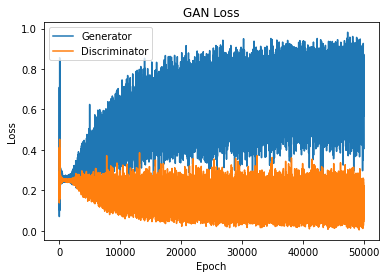

In [7]:
plt.plot(g_loss)
plt.plot(d_loss)
plt.title('GAN Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Generator', 'Discriminator'], loc='upper left')
plt.show()